In [11]:
from classes import *
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import random


In [12]:
def initialize_a_polygon():
    num_vertices = random.randint(3, 10)

    theta = 2 * np.pi / num_vertices
    vertices = []
    for i in range(num_vertices):
        r_vertex = np.sqrt(1/np.pi) + random.uniform(-0.1, 0.1)
        theta_vertex = i*theta + random.uniform(-0.001, 0.001)
        x = r_vertex * np.cos(theta_vertex)
        y = r_vertex * np.sin(theta_vertex)
        vertices.append(Vertex([x, y]))
    return Polygon(vertices)

def plot_configuration(polygon):
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(polygon.vertices_)):
        # ax.plot(P.vertices_[i].position_,P.vertices_[i-1].position_,color='black')
        ax.plot(polygon.vertices_[i].position_[0],polygon.vertices_[i].position_[1],'o',color='black')
        ForceArrow = FancyArrowPatch(posA = polygon.vertices_[i].position_,
                                posB = np.add(polygon.vertices_[i].position_,polygon.vertices_[i].force_),
                                arrowstyle='->,head_width=5,head_length=10',
                                color='blue', linewidth=2)
        EdgeArrow = FancyArrowPatch(posA = polygon.vertices_[i].position_,
                                posB = polygon.vertices_[i-1].position_,
                                arrowstyle='-',
                                color='black', linewidth=2)
        ax.add_patch(ForceArrow)
        ax.add_patch(EdgeArrow)
        


        # ax.add_patch(arrow)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    # plt.grid()
    plt.show()
    plt.savefig("Configuration.png")

In [23]:
def calculateForceVelocityProjections(polygon):
    ff = 0
    vv = 0
    power = 0

    for i in range(len(polygon.vertices_)):
        ff += np.dot(polygon.vertices_[i].force_,polygon.vertices_[i].force_)
        vv += np.dot(polygon.vertices_[i].velocity_,polygon.vertices_[i].velocity_)
        power += np.dot(polygon.vertices_[i].force_,polygon.vertices_[i].velocity_)

    return ff, vv, power

def FIREminimize(polygon):
    # FIRE algorithm parameters
    FIRE_finc = 1.1
    FIRE_fdec = 0.5
    FIRE_acoef0 = 0.1
    FIRE_acoef = 0.1
    FIRE_falpha = 0.99
    FIRE_dtmax = 0.05
    FIRE_dt = 0.001
    FIRE_equilibrium_tolerance = 1e-29
    FIRE_equilibrium_count = 0
    FIRE_itermax = 1000000
    FIRE_n_since_positive = 0

    for iter in range(FIRE_itermax):

        # Step 1: Update positions, forces, and velocities. 
        # note that initial velocities are zero (from the initialized Vertex objects)
        
        # Update positions of polygon vertices
        for j in range(len(polygon.vertices_)):
            polygon.vertices_[j].position_ = np.add(polygon.vertices_[j].position_,
                                                    np.multiply(FIRE_dt,
                                                                polygon.vertices_[j].velocity_))

        
        # Calculate forces on polygon vertices
        polygon.do_reconnections()
        polygon.compute_perimeter()
        polygon.compute_area()
        polygon.compute_forces()

        # Update velocities of polygon vertices
        for j in range(len(polygon.vertices_)):
            polygon.vertices_[j].velocity_ = np.add(polygon.vertices_[j].velocity_,
                                                    np.multiply(FIRE_dt,
                                                                polygon.vertices_[j].force_))

        # Step 2: Calculate ff, vv, and power
        ff, vv, power = calculateForceVelocityProjections(polygon)

            
        if (ff<FIRE_equilibrium_tolerance):
            FIRE_equilibrium_count += 1
            if (FIRE_equilibrium_count>1000):
                break
            
        
        
        else: FIRE_equilibrium_count = 0
        

        # Step 3: Check if  power is positive. 

        # If it is:
        # FIRE update the velocities.

        # If it is, and if it has been positive for 5 consecutive iterations:
        # increase the timestep, decrease acoef
        # Reset the counter for the number of iterations since the dot product was positive.

        # If it is not:
        # decrease the timestep, reset acoef and reset the velocities to zero.
        if power>0:
            FIRE_n_since_positive+=1
            if (FIRE_n_since_positive>5):
                FIRE_dt = min(FIRE_dt*FIRE_finc, FIRE_dtmax)
                FIRE_acoef*=FIRE_falpha
                FIRE_n_since_positive=0 
            

            force_multiple = np.sqrt(vv/ff)

            for j in range(len(polygon.vertices_)):
                polygon.vertices_[j].velocity_ = np.add(np.multiply((1 - FIRE_acoef),
                                                                    polygon.vertices_[j].velocity_),
                                                        np.multiply(force_multiple * FIRE_acoef, 
                                                                    polygon.vertices_[j].force_))
        else:
            FIRE_n_since_positive=0
            FIRE_acoef=FIRE_acoef0
            FIRE_dt*=FIRE_fdec
            for j in range(len(polygon.vertices_)):
                polygon.vertices_[j].velocity_ = [0, 0]


        if (iter%1000 == 0):
            print("Iteration ", iter, "ff = ", ff, "vv = ", vv, "power = ", power)
            plot_configuration(polygon)
    
    
    return

3.29900983403825
[[0. 0.]
 [0. 0.]]
0.7703913147578267


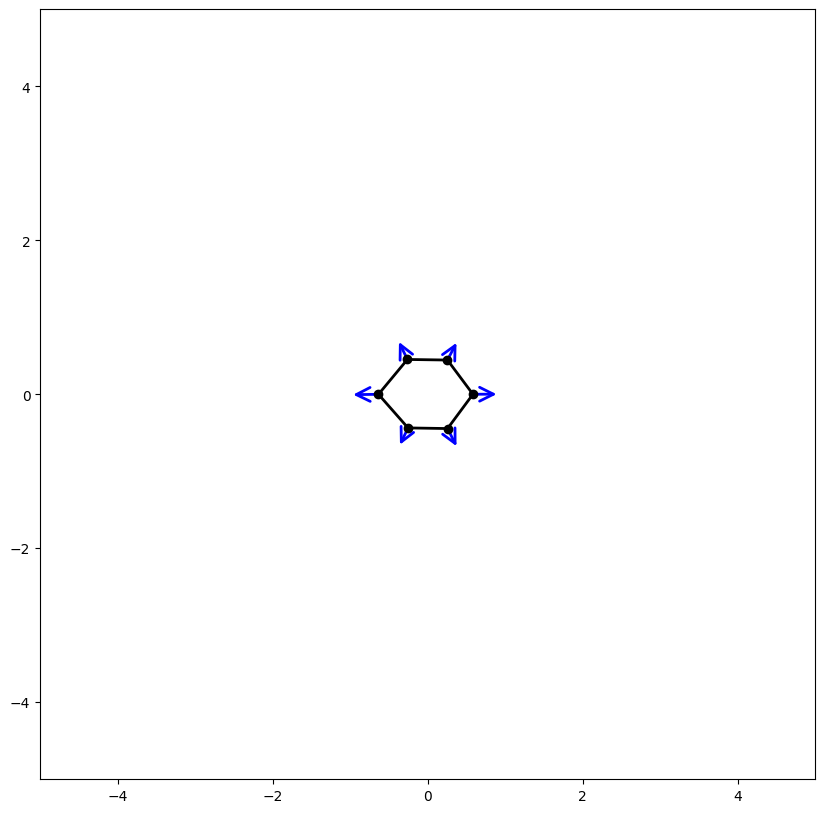

Iteration  0 ff =  0.5764207798053584 vv =  5.764207798053585e-07 power =  0.0005764207798053584


<Figure size 640x480 with 0 Axes>

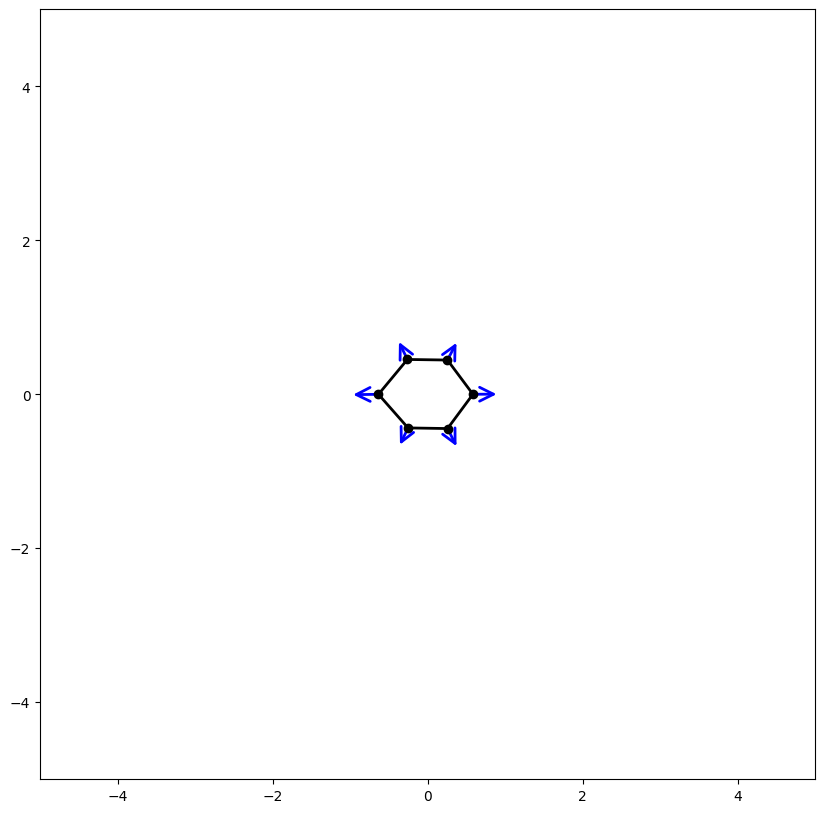

Iteration  1000 ff =  3.249156424410103e-22 vv =  8.634872305287152e-22 power =  5.254833884803441e-22


<Figure size 640x480 with 0 Axes>

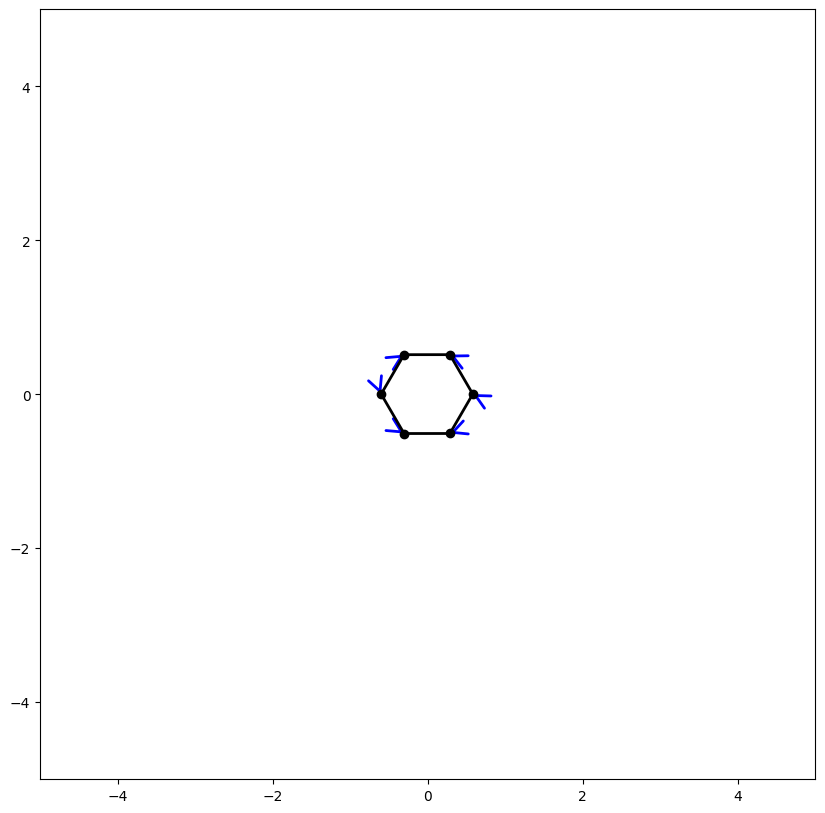

3.547092798055446
0.9080180603706451
[ 4.37150316e-16 -1.70084216e-18]
[2.46330734e-16 3.60822483e-16]
[-2.18575158e-16  4.57966998e-16]
[-4.92661467e-16 -7.18283939e-18]
[-2.01227923e-16 -4.57966998e-16]
[ 2.18575158e-16 -3.46944695e-16]


<Figure size 640x480 with 0 Axes>

In [20]:
P = initialize_a_polygon()

print(P.perimeter_)
print(P.stress_)
print(P.area_)

plot_configuration(P)
FIREminimize(P)
P.compute_area()
P.compute_perimeter()
P.compute_forces()
print(P.perimeter_)
print(P.area_)
for i in range(len(P.vertices_)):

    print(P.vertices_[i].force_)


3.2189471551773803
[[0. 0.]
 [0. 0.]]
0.6938479463802412


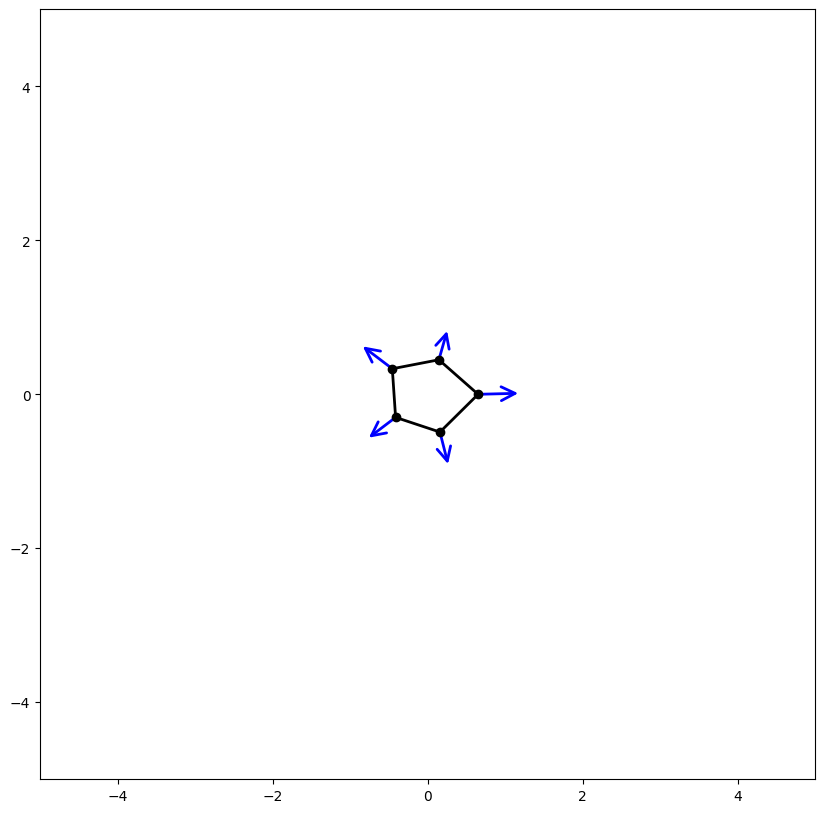

Iteration  0 ff =  1.189064071535396 vv =  1.1890640715353962e-06 power =  0.001189064071535396


<Figure size 640x480 with 0 Axes>

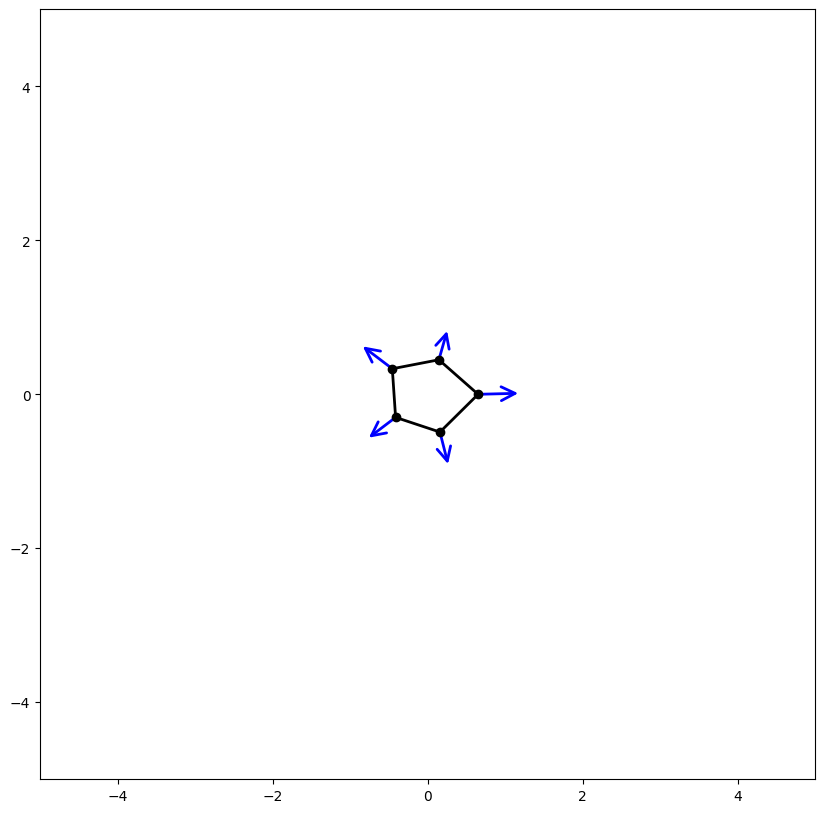

Iteration  1000 ff =  3.862839323747734e-28 vv =  1.3968992783482467e-28 power =  2.2213728050636444e-28


<Figure size 640x480 with 0 Axes>

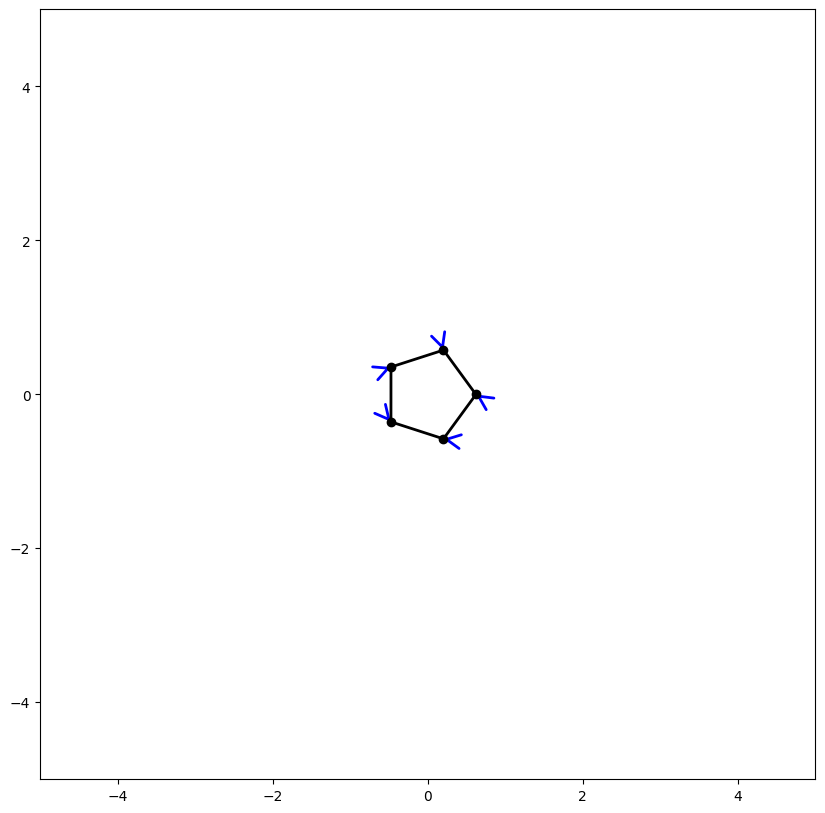

Iteration  2000 ff =  9.86453214364221e-31 vv =  9.788082019528986e-32 power =  3.1073276252472967e-31


<Figure size 640x480 with 0 Axes>

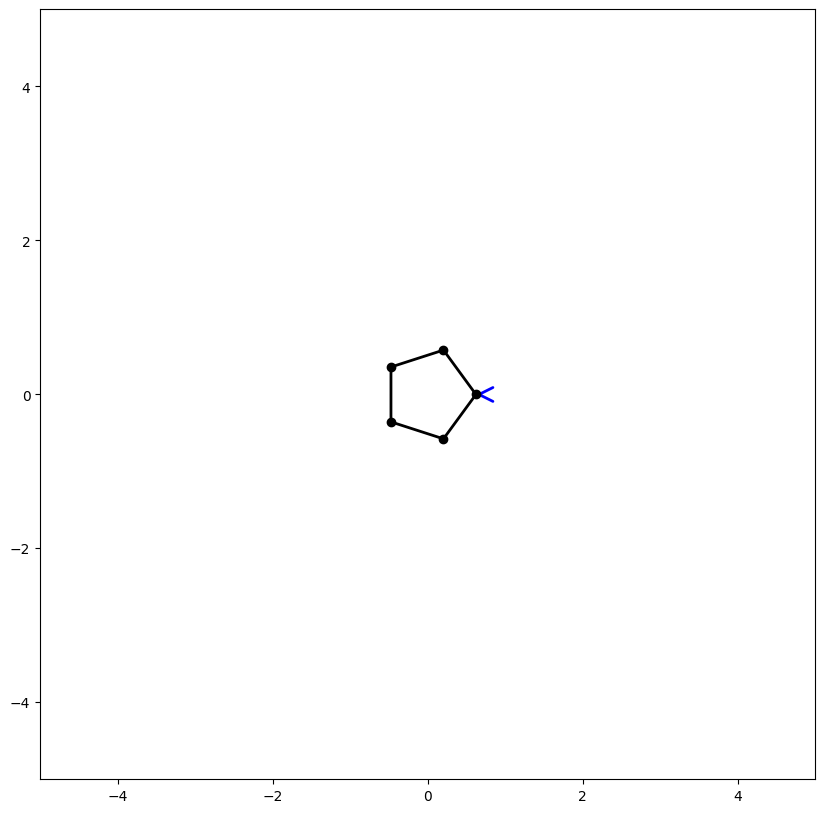

Iteration  3000 ff =  2.4580905233934452e-31 vv =  6.434675463563216e-31 power =  3.9770610729654455e-31


<Figure size 640x480 with 0 Axes>

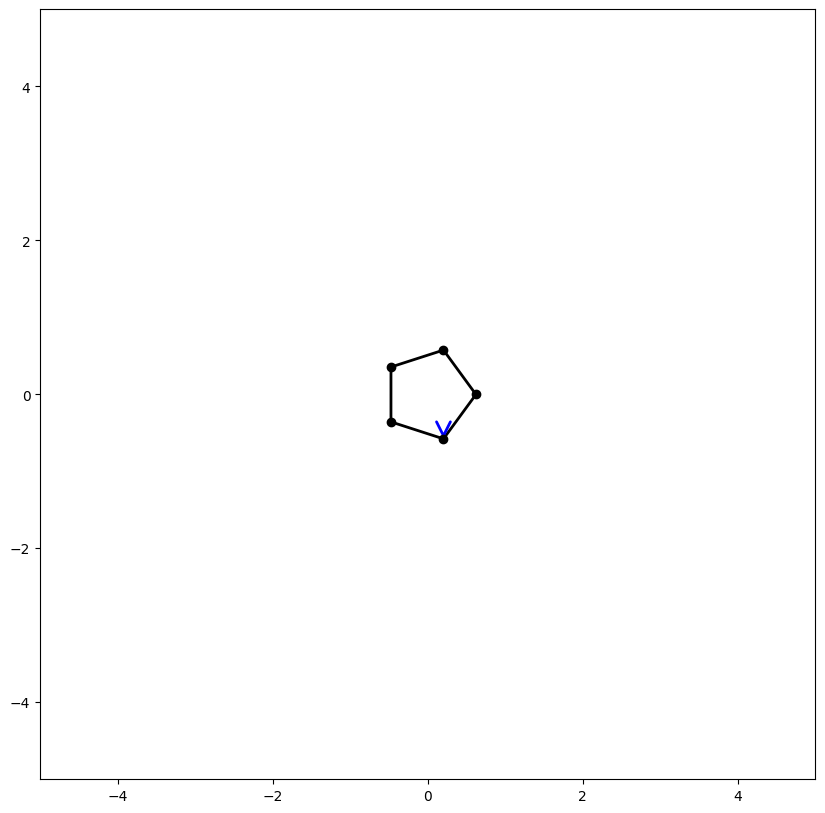

Iteration  4000 ff =  1.0150734971903775e-30 vv =  2.4995992124373663e-30 power =  1.5928832079418475e-30


<Figure size 640x480 with 0 Axes>

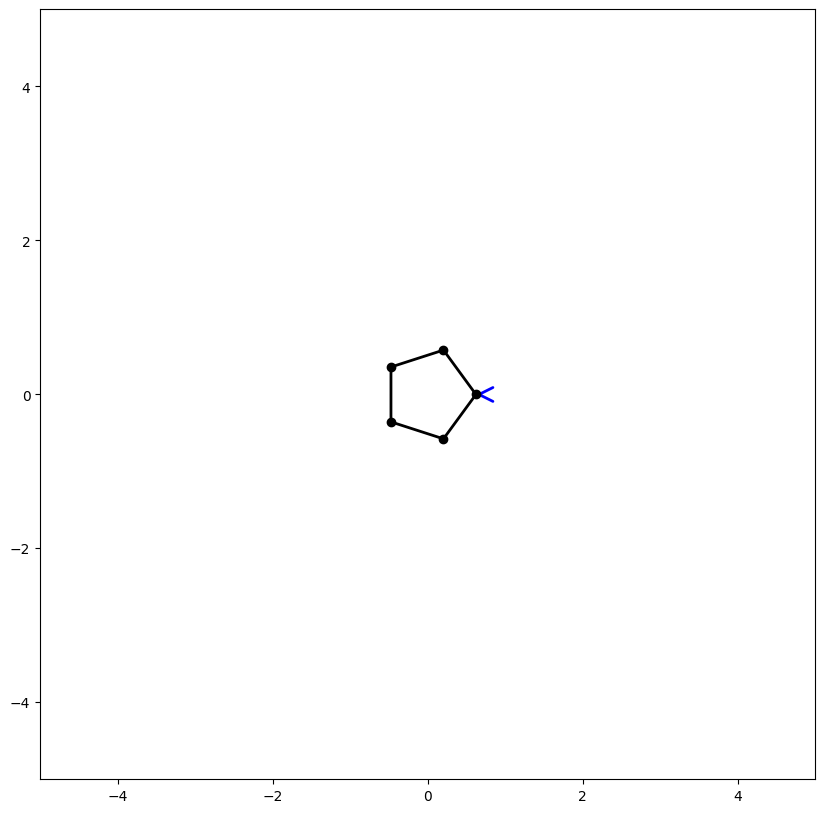

Iteration  5000 ff =  2.4580905233934452e-31 vv =  1.1525702475595094e-30 power =  5.3227079603067335e-31


<Figure size 640x480 with 0 Axes>

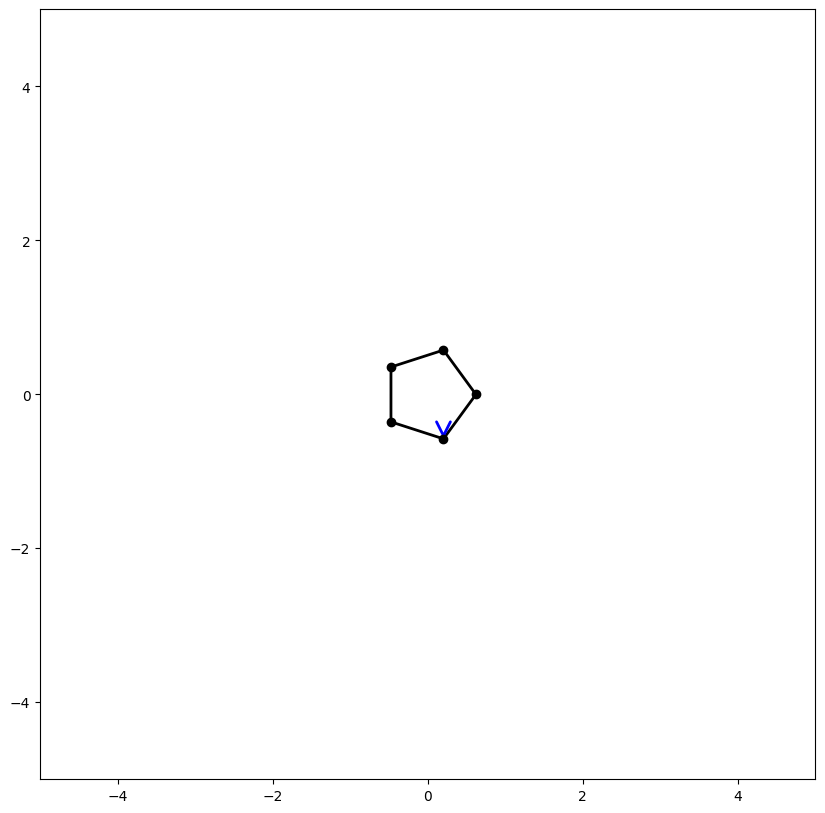

Iteration  6000 ff =  2.4580905233934452e-31 vv =  2.4580905233934464e-33 power =  2.4580905233934458e-32


<Figure size 640x480 with 0 Axes>

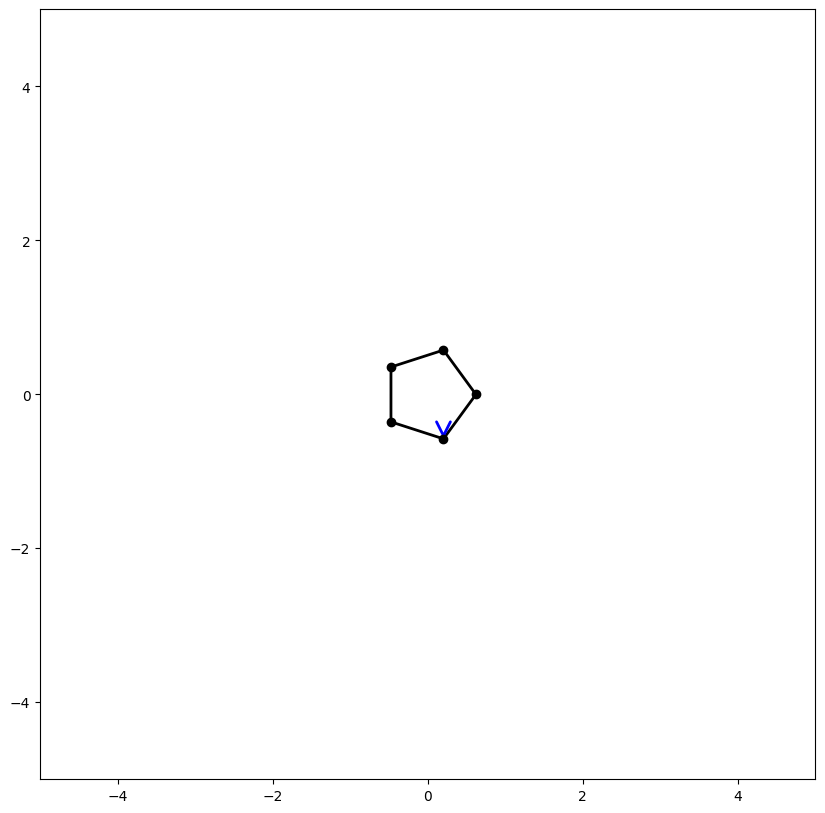

Iteration  7000 ff =  1.0150734971903775e-30 vv =  5.709788421695875e-33 power =  7.613051228927833e-32


<Figure size 640x480 with 0 Axes>

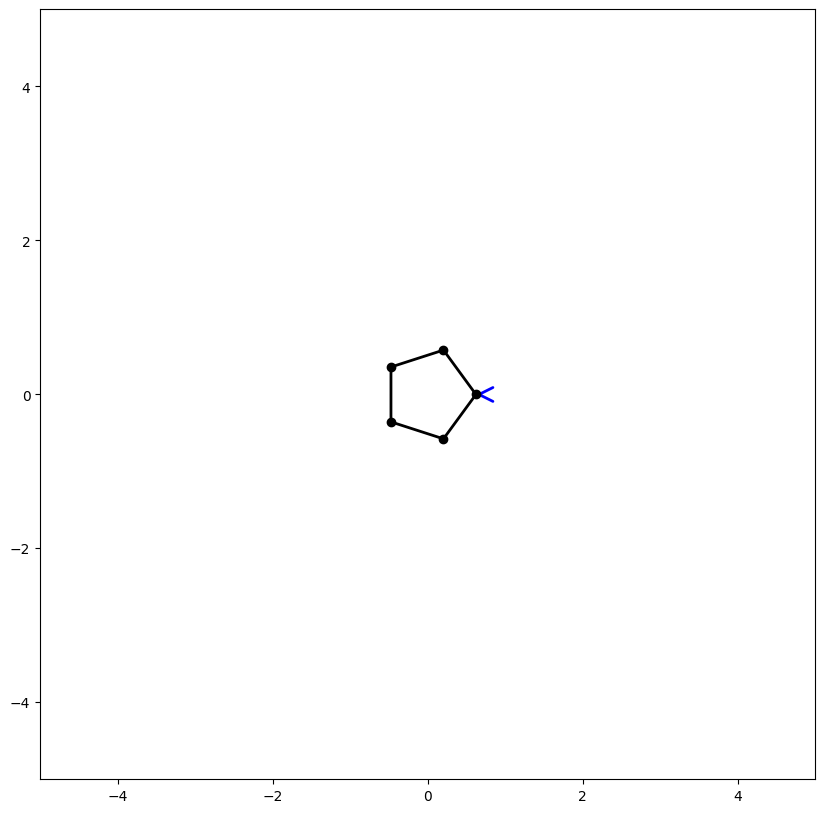

Iteration  8000 ff =  2.4580905233934452e-31 vv =  4.0468297076849084e-32 power =  9.973702298668906e-32


<Figure size 640x480 with 0 Axes>

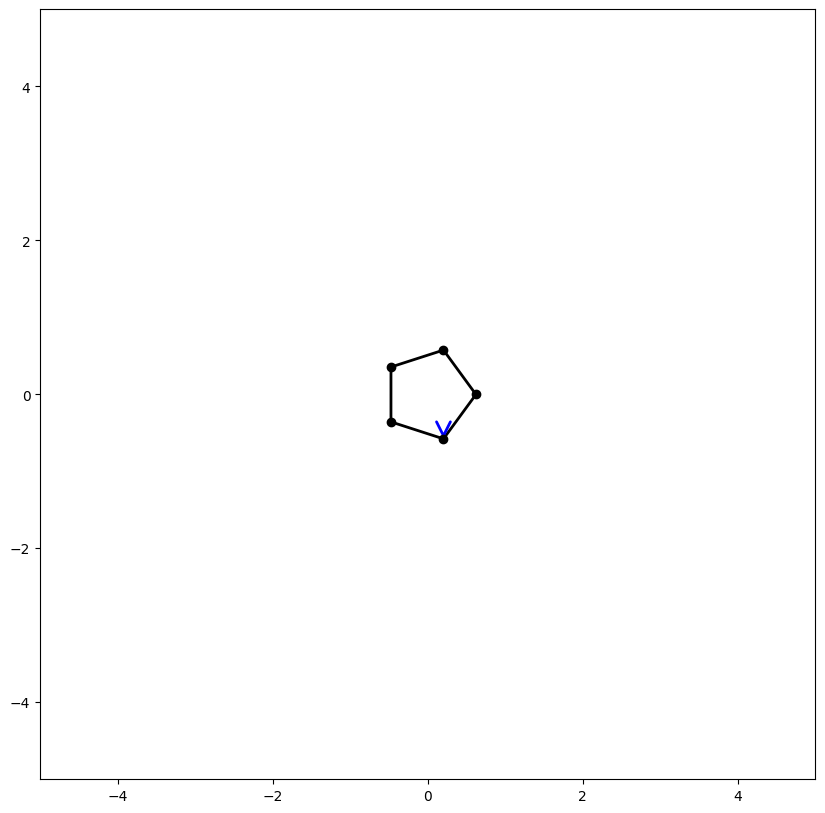

Iteration  9000 ff =  1.0150734971903775e-30 vv =  1.4312561687221756e-31 power =  3.8116009819498683e-31


<Figure size 640x480 with 0 Axes>

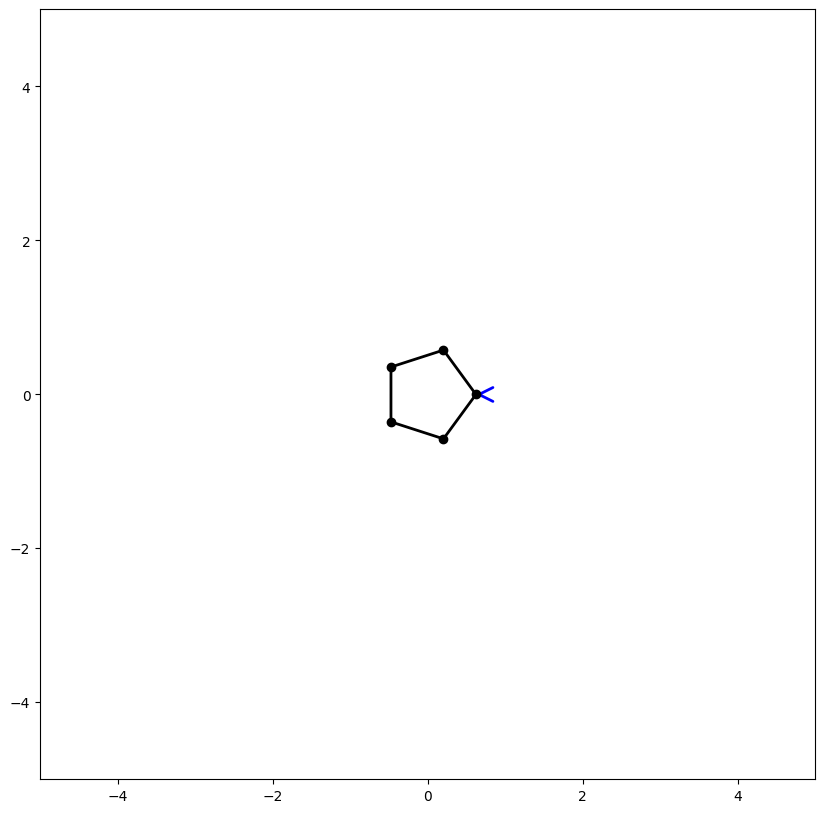

Iteration  10000 ff =  2.4580905233934452e-31 vv =  1.4549612726301982e-31 power =  1.8911442346253646e-31


<Figure size 640x480 with 0 Axes>

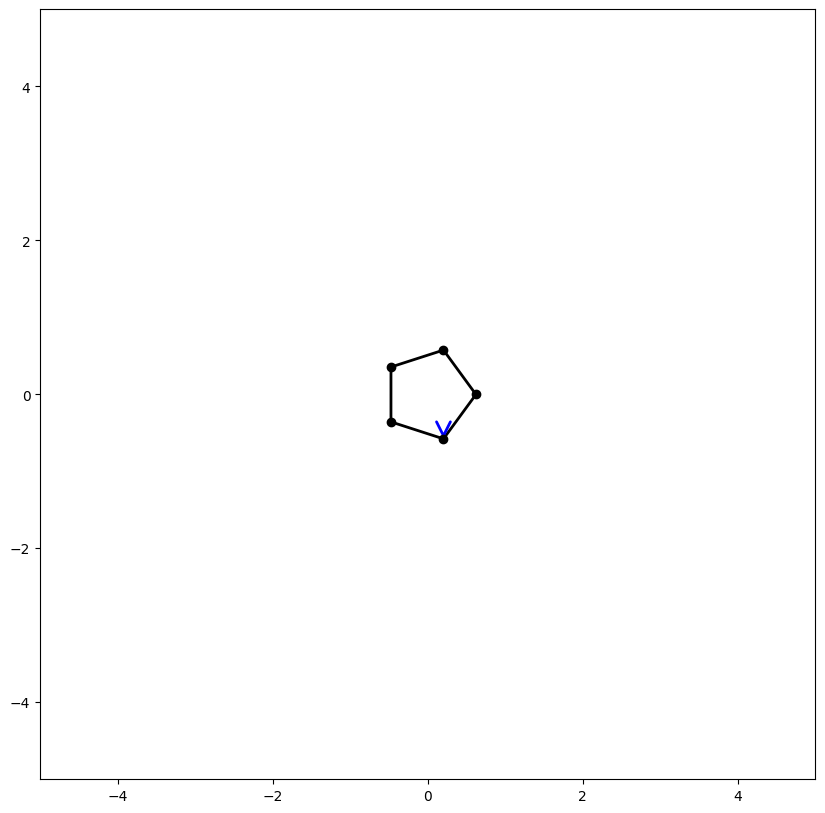

Iteration  11000 ff =  1.0150734971903775e-30 vv =  5.450195822191638e-31 power =  7.437976427499922e-31


<Figure size 640x480 with 0 Axes>

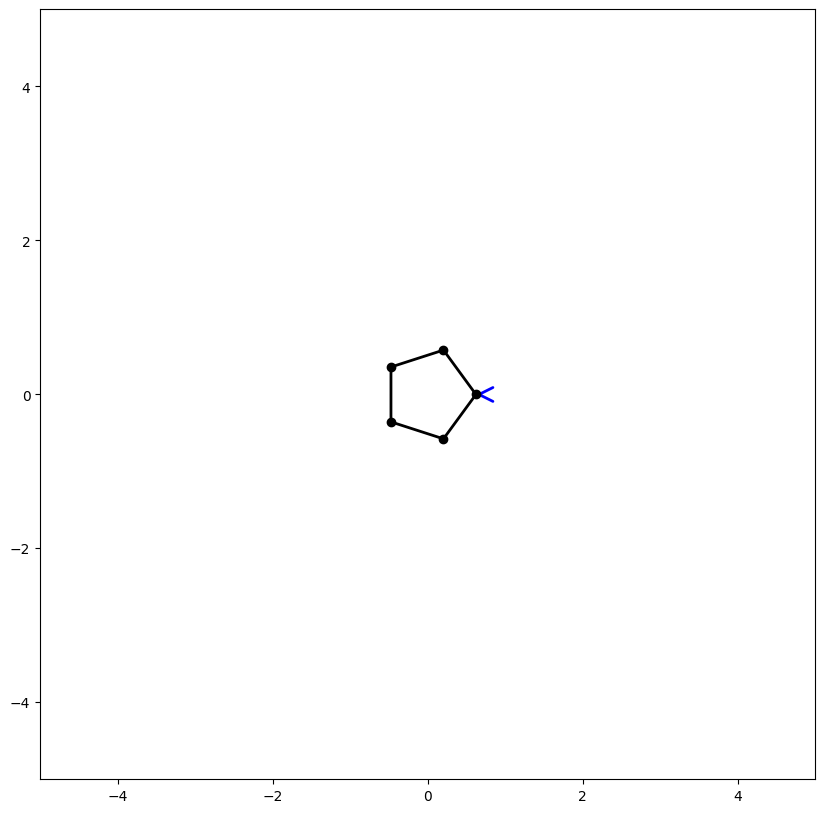

Iteration  12000 ff =  2.4580905233934452e-31 vv =  3.549276036116549e-31 power =  2.9537166061227914e-31


<Figure size 640x480 with 0 Axes>

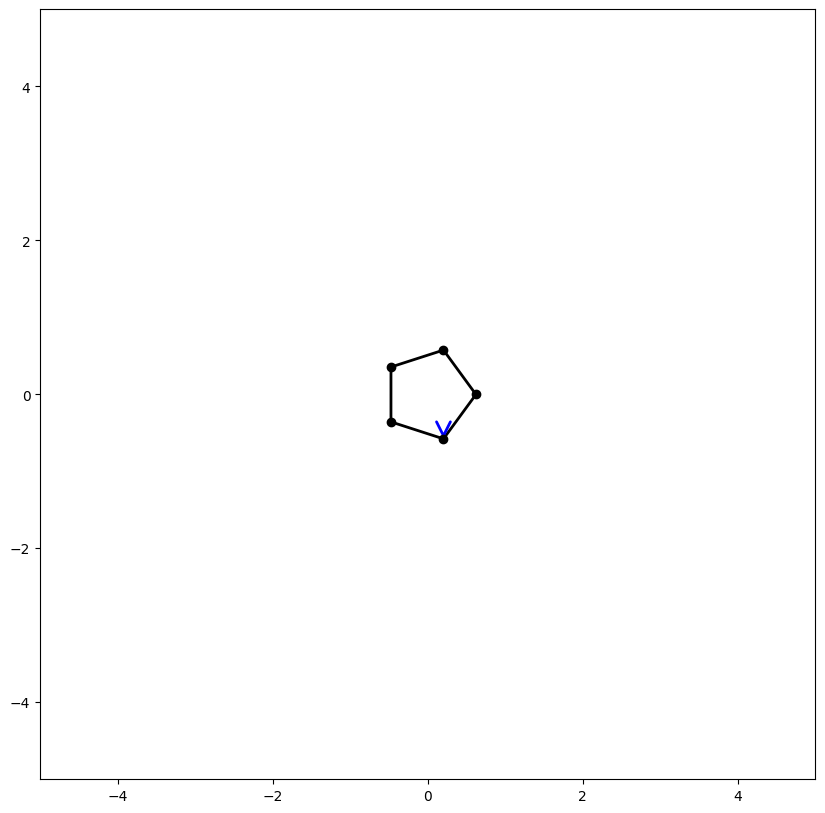

Iteration  13000 ff =  1.0150734971903775e-30 vv =  1.3596293828653152e-30 power =  1.1747866838485574e-30


<Figure size 640x480 with 0 Axes>

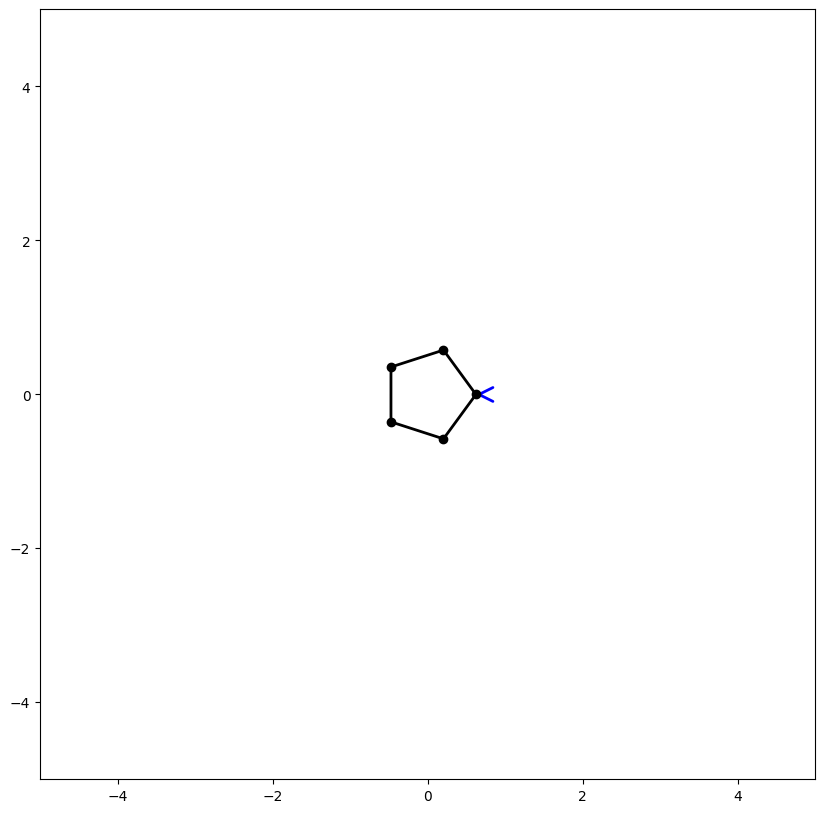

Iteration  14000 ff =  2.4580905233934452e-31 vv =  7.2330286423062075e-31 power =  4.216567224779684e-31


<Figure size 640x480 with 0 Axes>

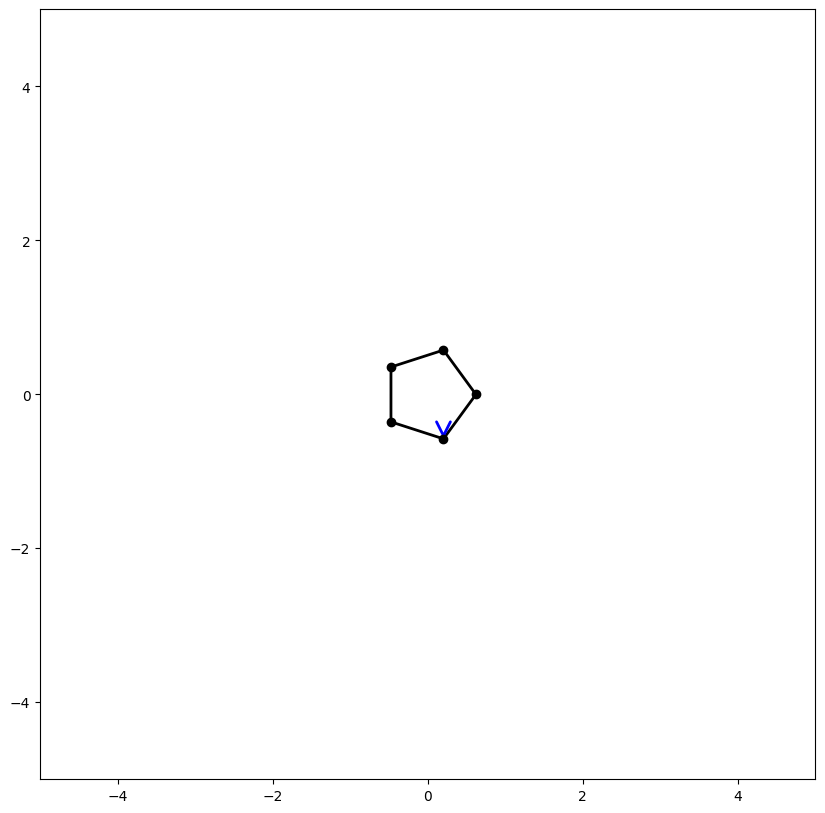

Iteration  15000 ff =  1.0150734971903775e-30 vv =  2.8196439367900996e-30 power =  1.691787762028432e-30


<Figure size 640x480 with 0 Axes>

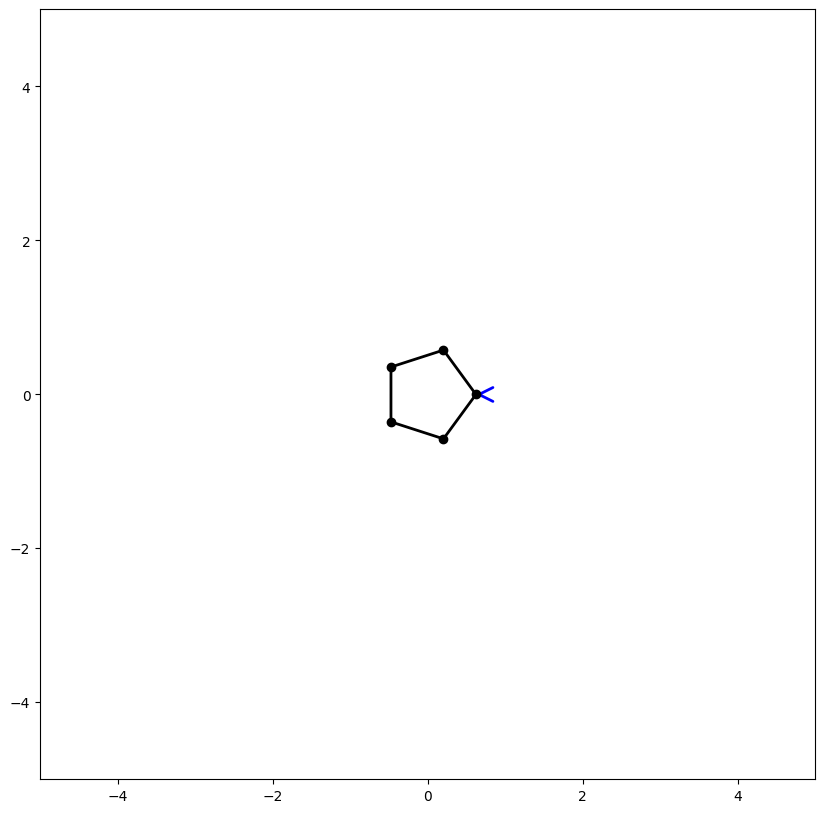

Iteration  16000 ff =  2.4580905233934452e-31 vv =  1.2614824972890376e-30 power =  5.568517012646079e-31


<Figure size 640x480 with 0 Axes>

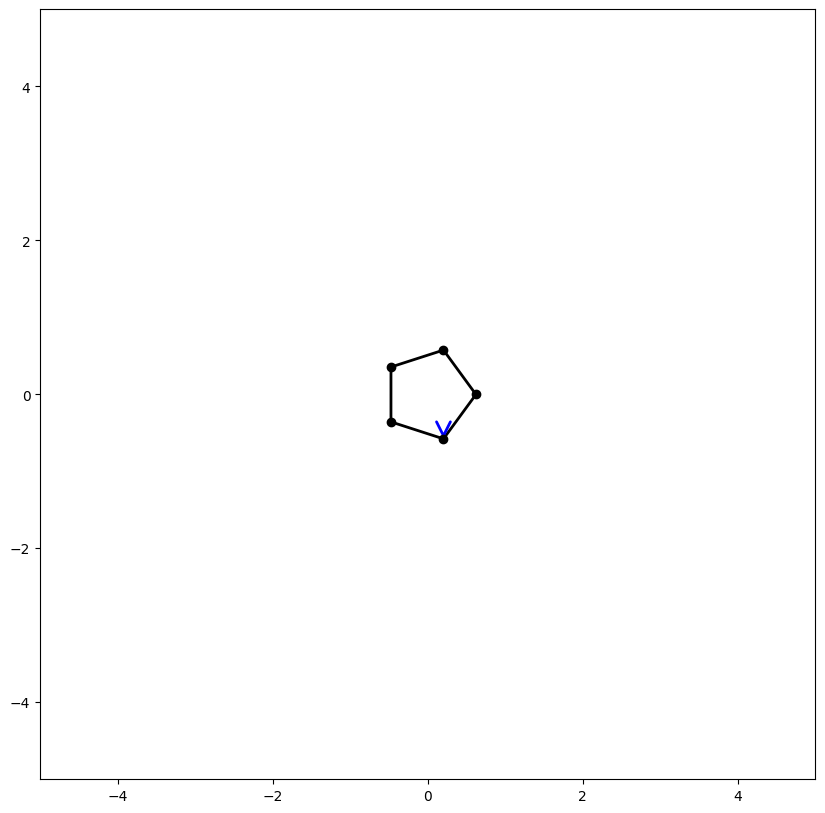

Iteration  17000 ff =  2.4580905233934452e-31 vv =  5.530703677635255e-33 power =  3.6871357850901686e-32


<Figure size 640x480 with 0 Axes>

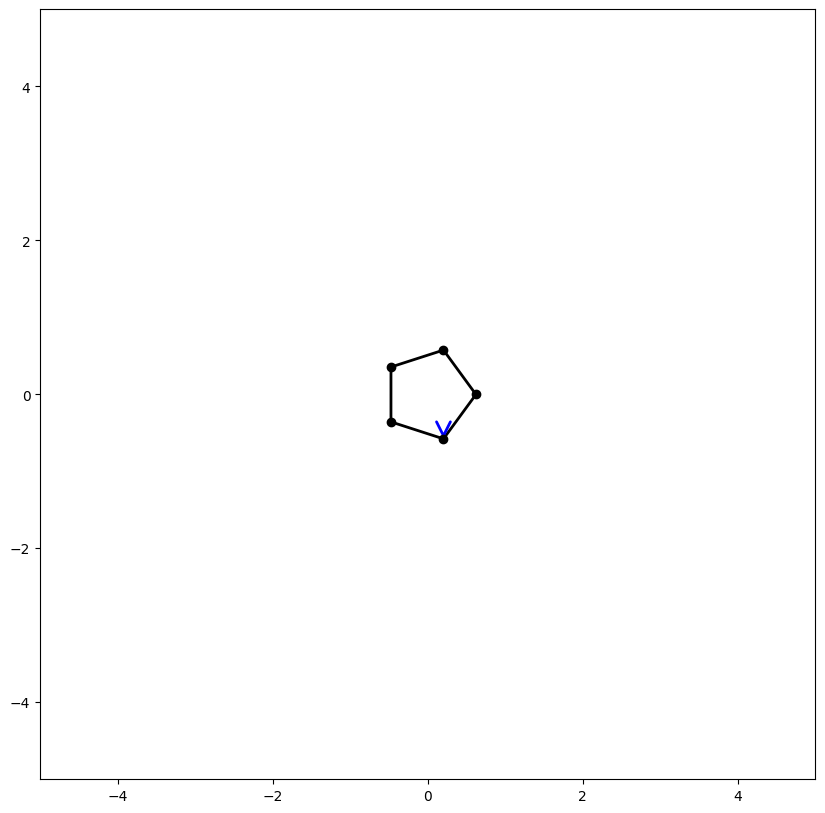

Iteration  18000 ff =  1.0150734971903775e-30 vv =  1.586052339359965e-32 power =  1.268841871487972e-31


<Figure size 640x480 with 0 Axes>

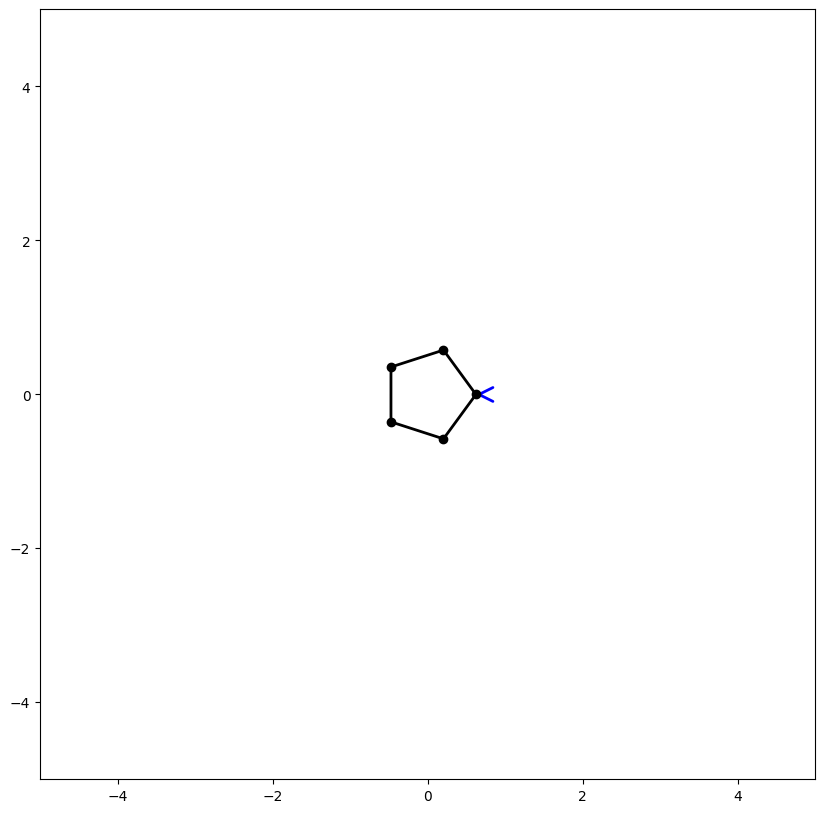

Iteration  19000 ff =  2.4580905233934452e-31 vv =  5.343619944206355e-32 power =  1.1460847065321942e-31


<Figure size 640x480 with 0 Axes>

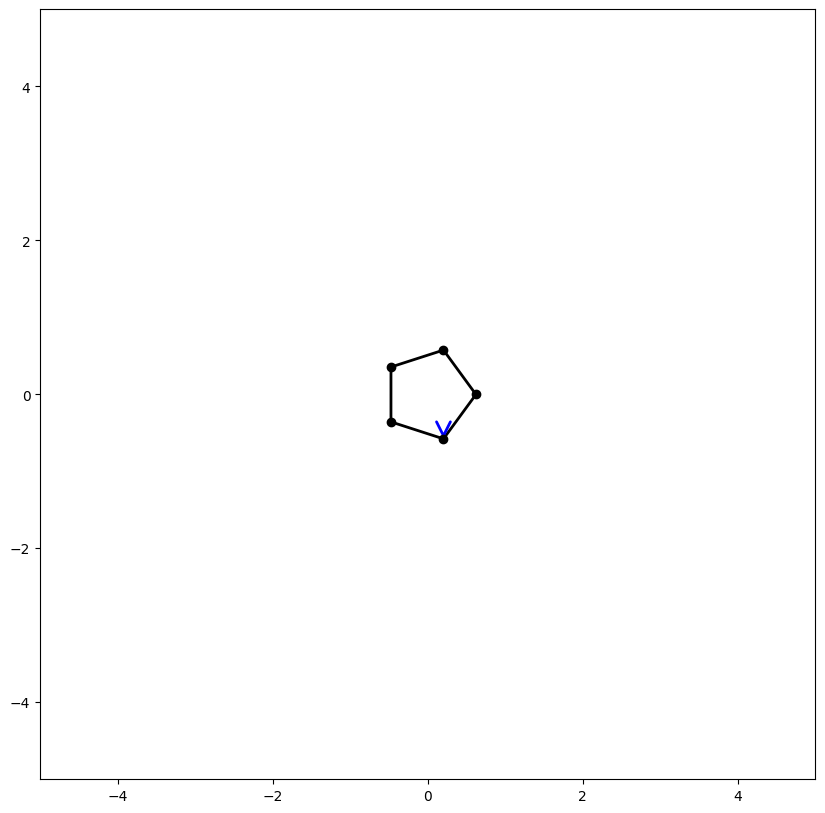

Iteration  20000 ff =  1.0150734971903775e-30 vv =  1.9296141152190206e-31 power =  4.425720447750047e-31


<Figure size 640x480 with 0 Axes>

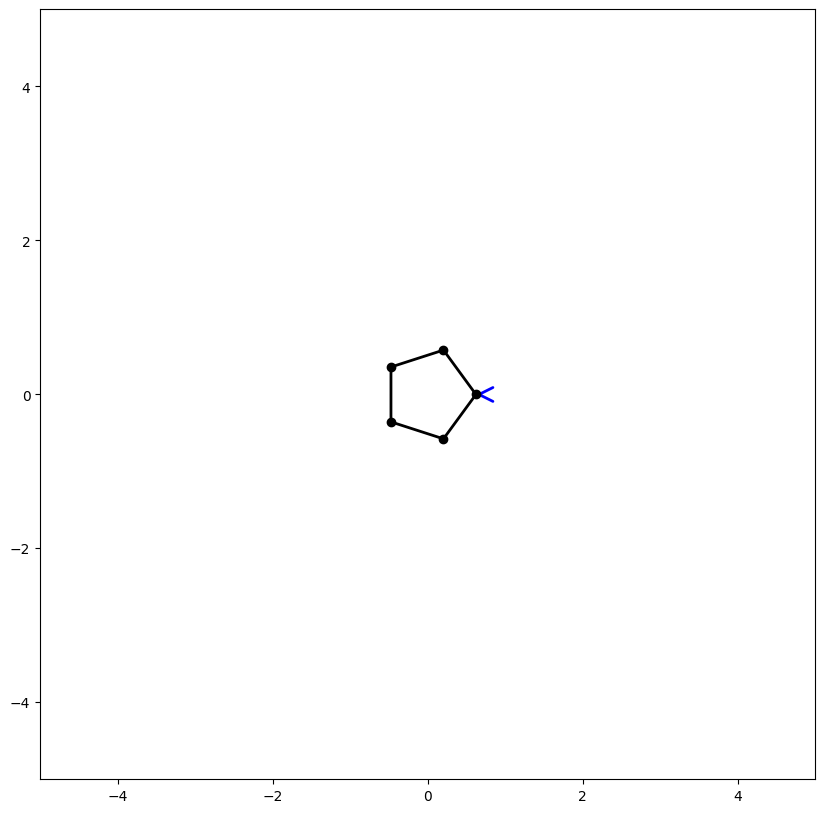

Iteration  21000 ff =  2.4580905233934452e-31 vv =  1.7450165383714809e-31 power =  2.0710887513903815e-31


<Figure size 640x480 with 0 Axes>

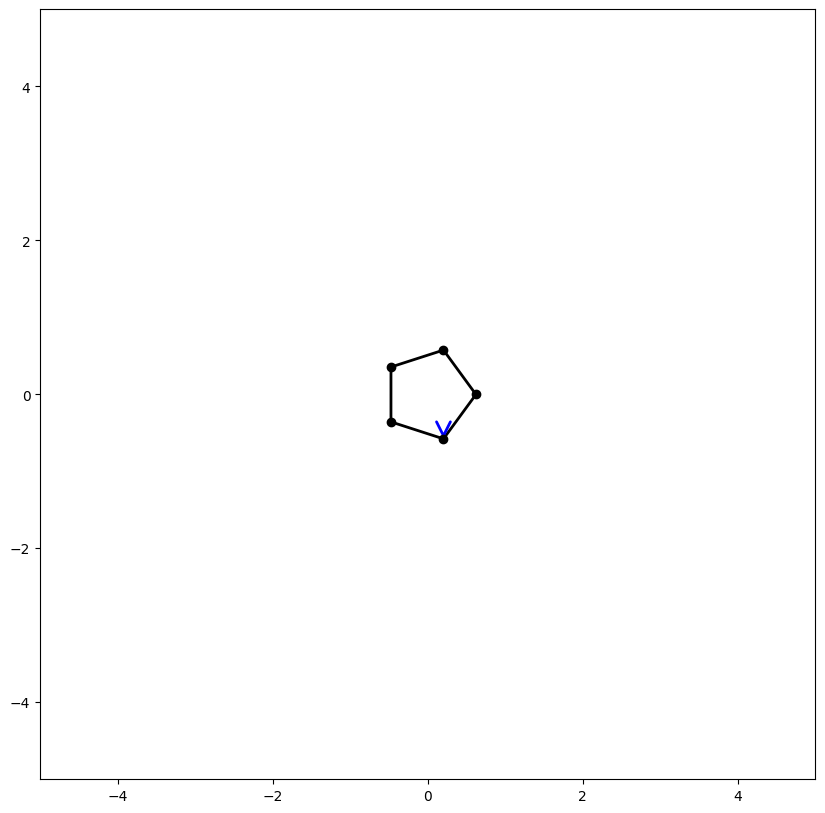

Iteration  22000 ff =  1.0150734971903775e-30 vv =  6.593587455689523e-31 power =  8.181060981118139e-31


<Figure size 640x480 with 0 Axes>

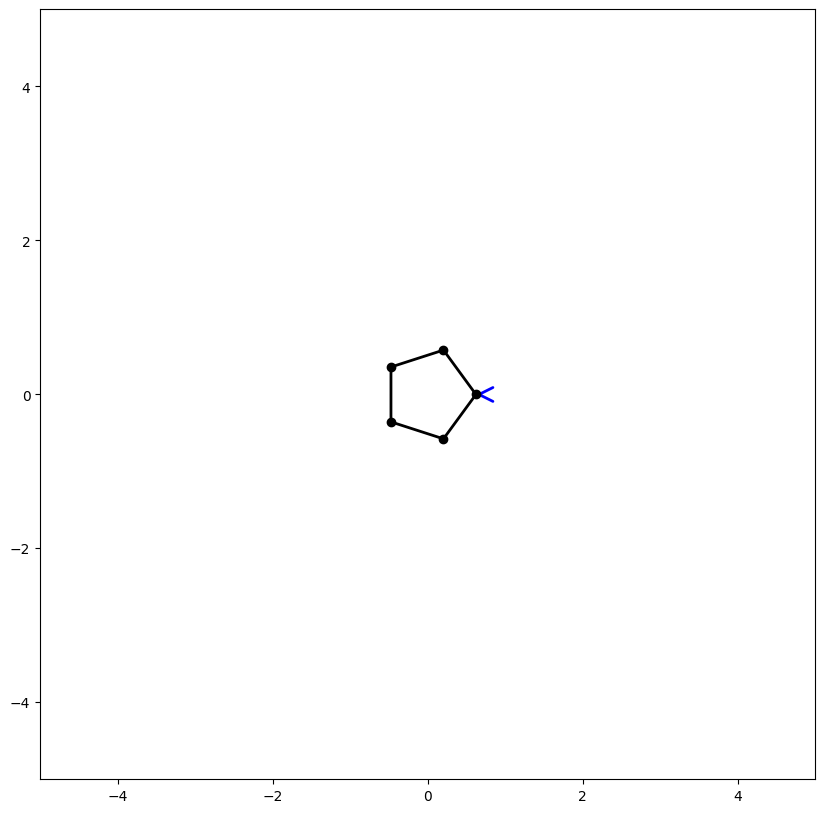

Iteration  23000 ff =  2.4580905233934452e-31 vv =  4.091831303190418e-31 power =  3.1714494714084626e-31


<Figure size 640x480 with 0 Axes>

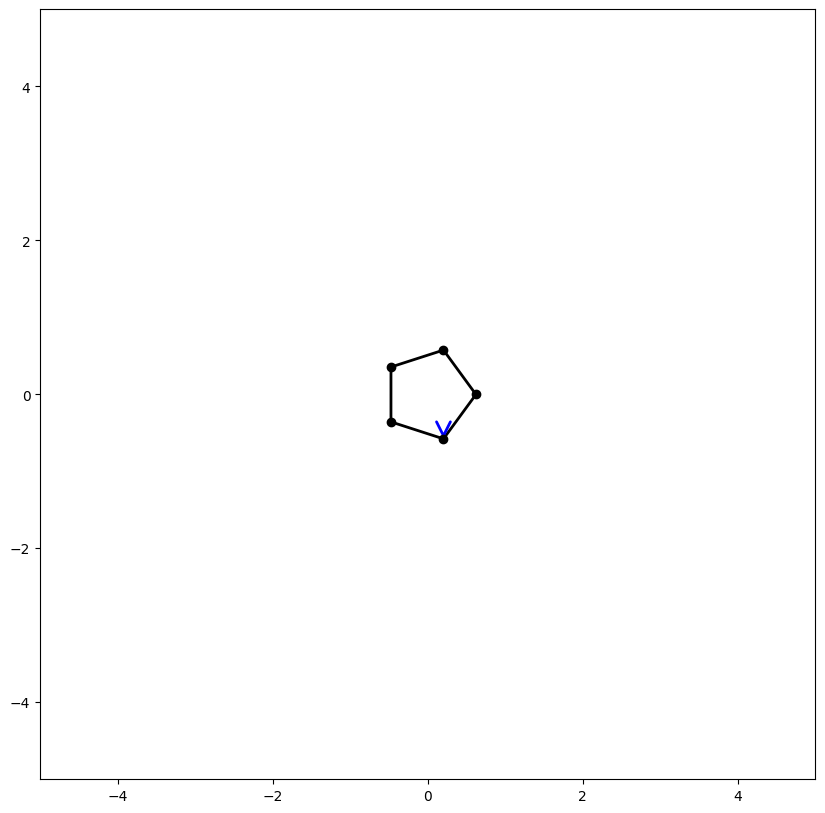

Iteration  24000 ff =  1.0150734971903775e-30 vv =  1.5757143487779582e-30 power =  1.2646999148363616e-30


<Figure size 640x480 with 0 Axes>

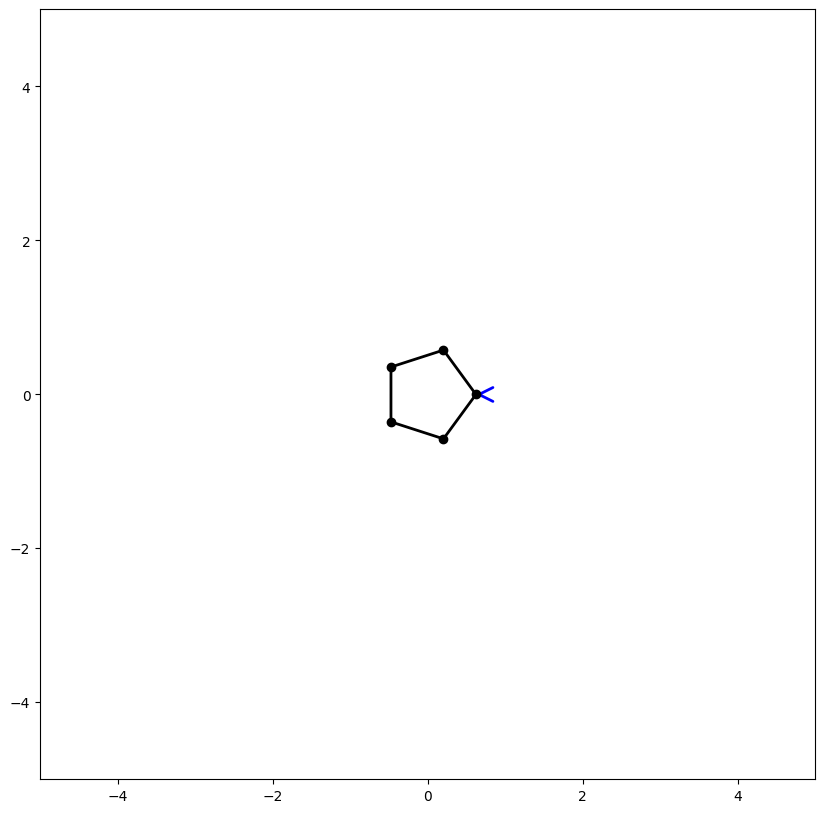

Iteration  25000 ff =  2.4580905233934452e-31 vv =  8.100922992496078e-31 power =  4.462376277119029e-31


<Figure size 640x480 with 0 Axes>

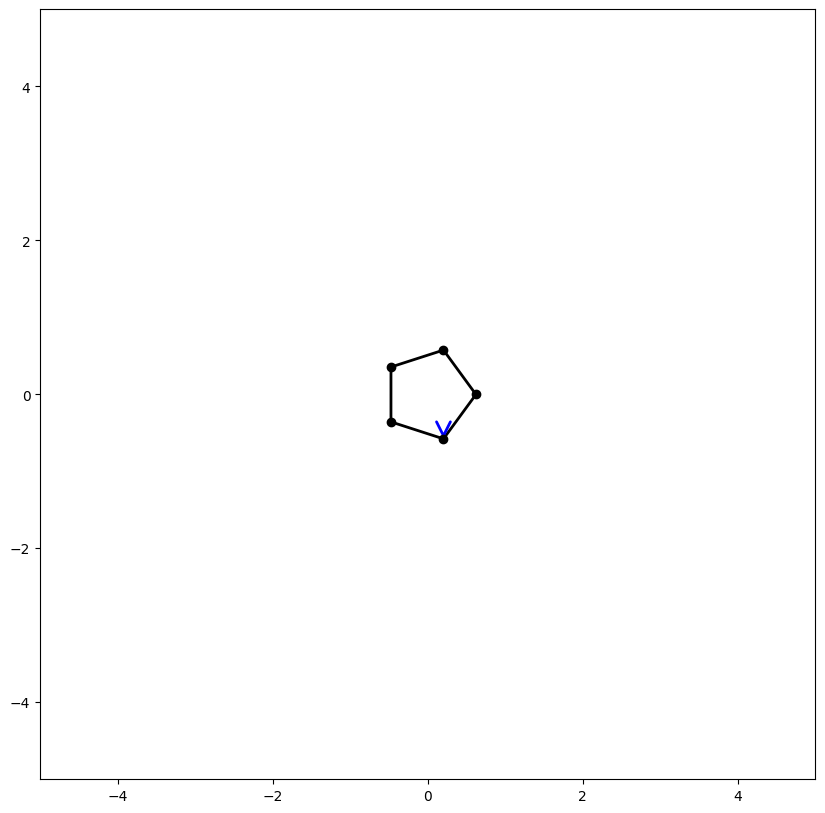

Iteration  26000 ff =  1.0150734971903775e-30 vv =  3.163555623959731e-30 power =  1.7919937139312434e-30


<Figure size 640x480 with 0 Axes>

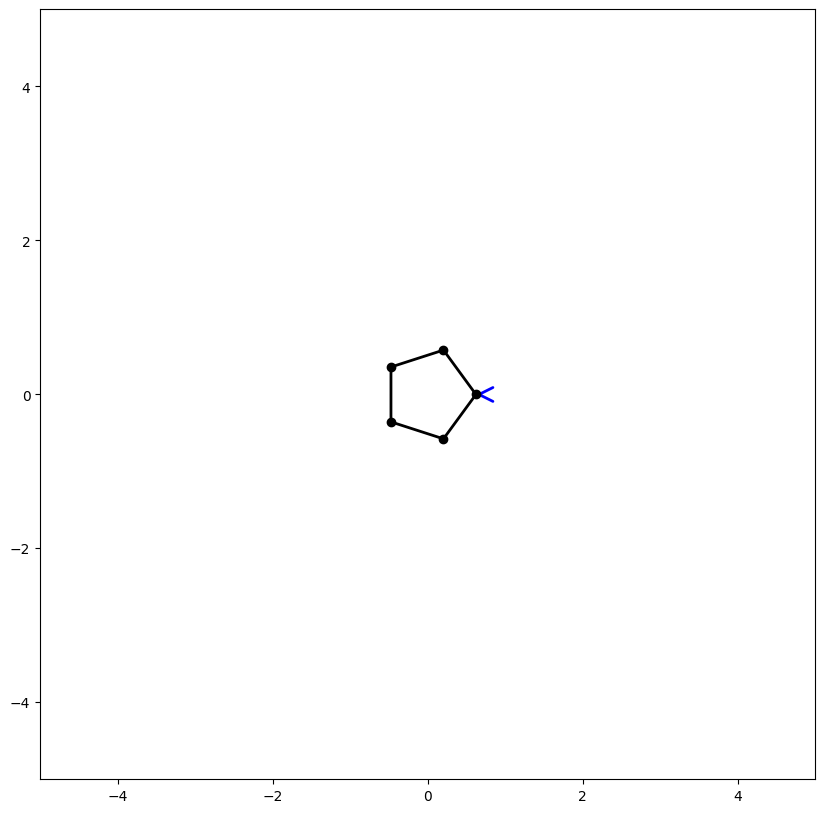

Iteration  27000 ff =  2.4580905233934452e-31 vv =  1.3753109280653523e-30 power =  5.814326064985423e-31


<Figure size 640x480 with 0 Axes>

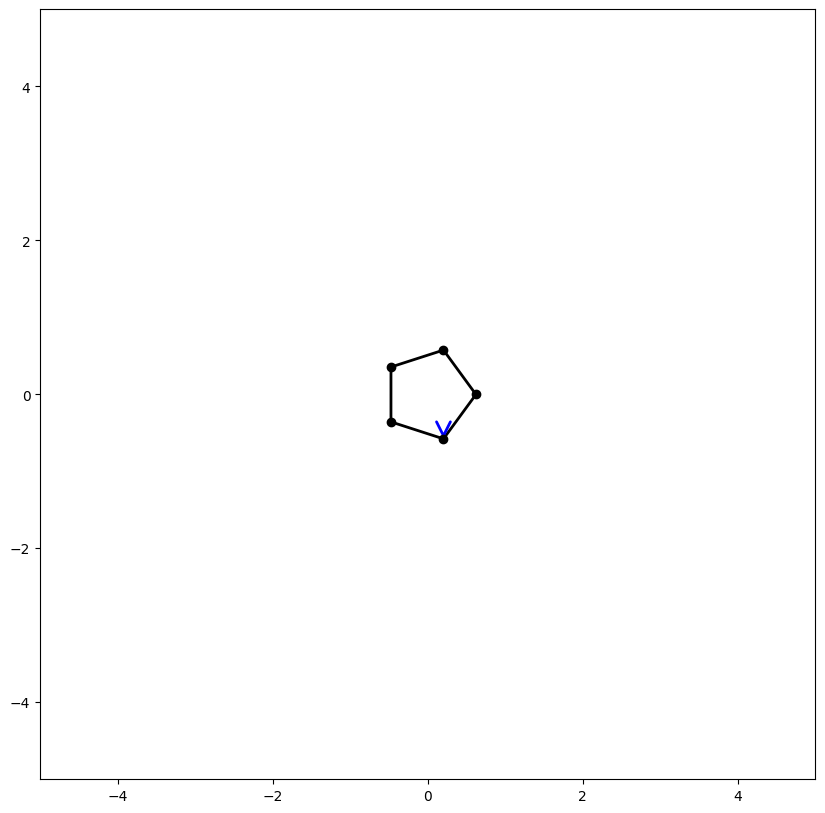

Iteration  28000 ff =  2.4580905233934452e-31 vv =  1.0330125424560959e-32 power =  5.039085572956564e-32


<Figure size 640x480 with 0 Axes>

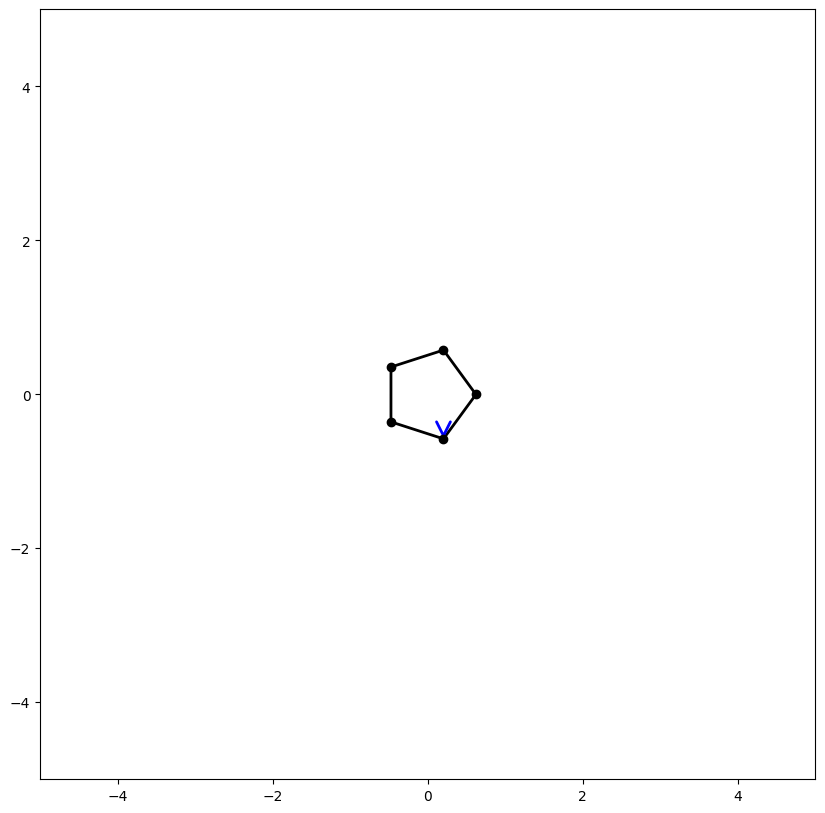

Iteration  29000 ff =  1.0150734971903775e-30 vv =  3.1981159370854335e-32 power =  1.8017554575129205e-31


<Figure size 640x480 with 0 Axes>

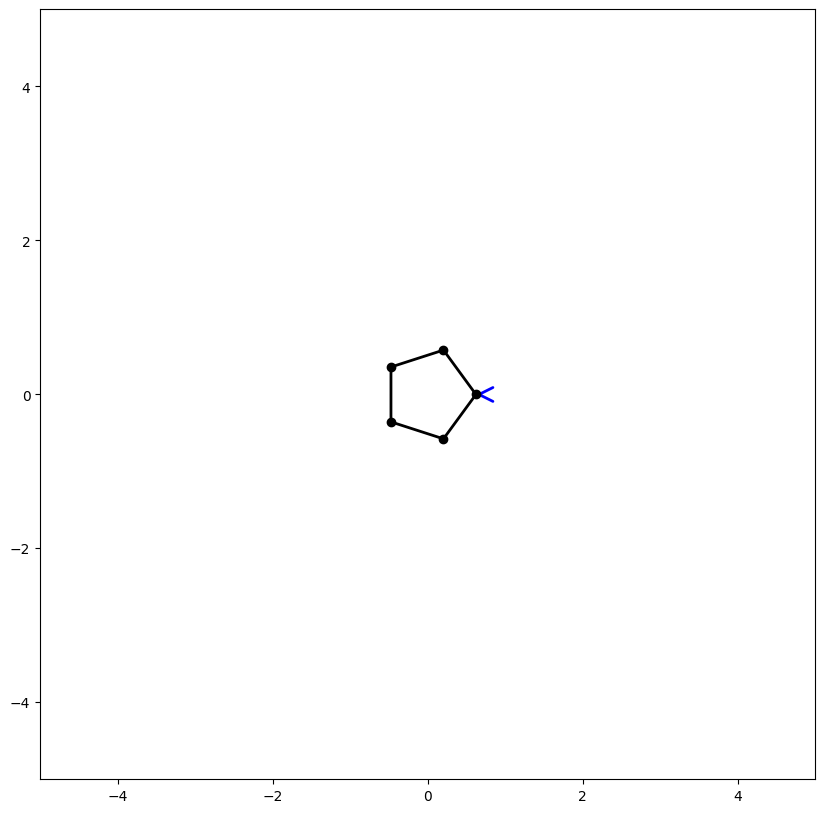

Iteration  30000 ff =  2.4580905233934452e-31 vv =  6.898914978722223e-32 power =  1.3022349070307627e-31


<Figure size 640x480 with 0 Axes>

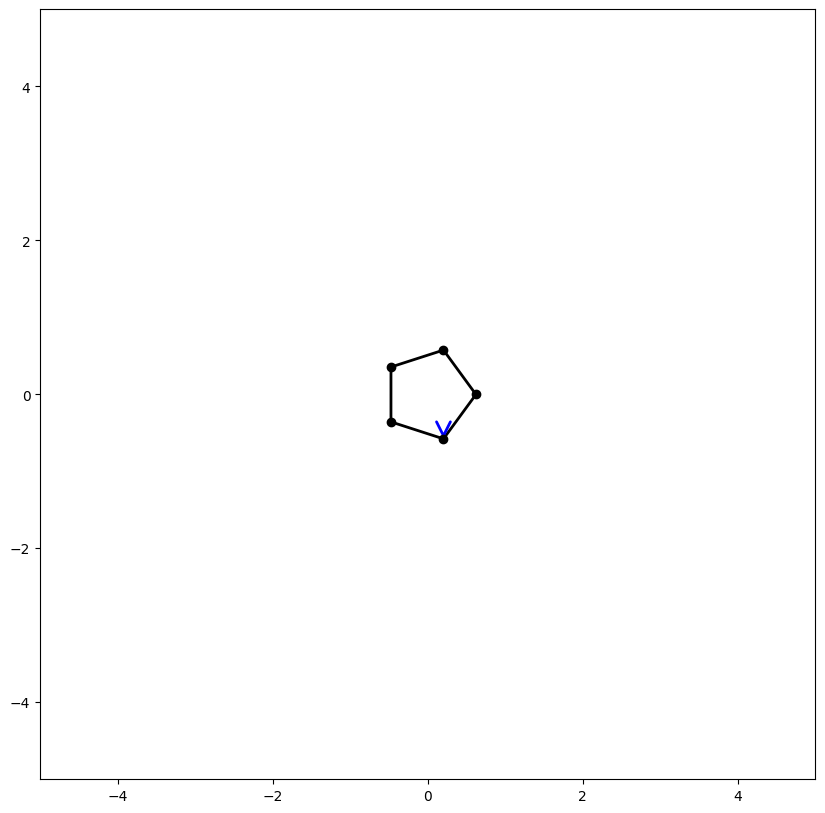

Iteration  31000 ff =  1.0150734971903775e-30 vv =  2.502280517077687e-31 power =  5.039839913550225e-31


<Figure size 640x480 with 0 Axes>

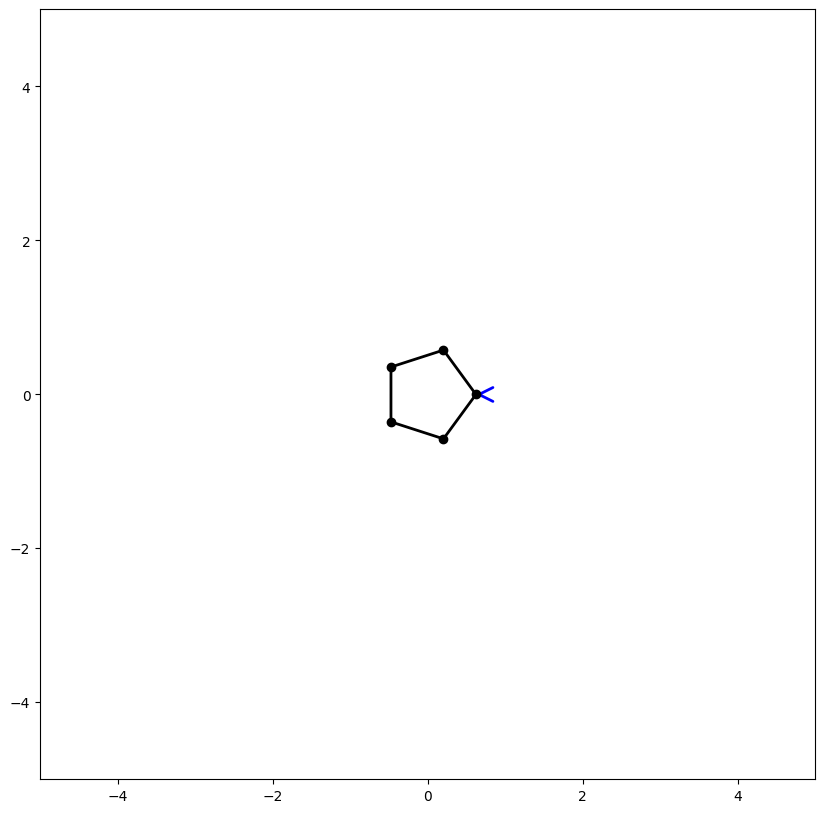

Iteration  32000 ff =  2.4580905233934452e-31 vv =  2.0614174808123293e-31 power =  2.251033268155399e-31


<Figure size 640x480 with 0 Axes>

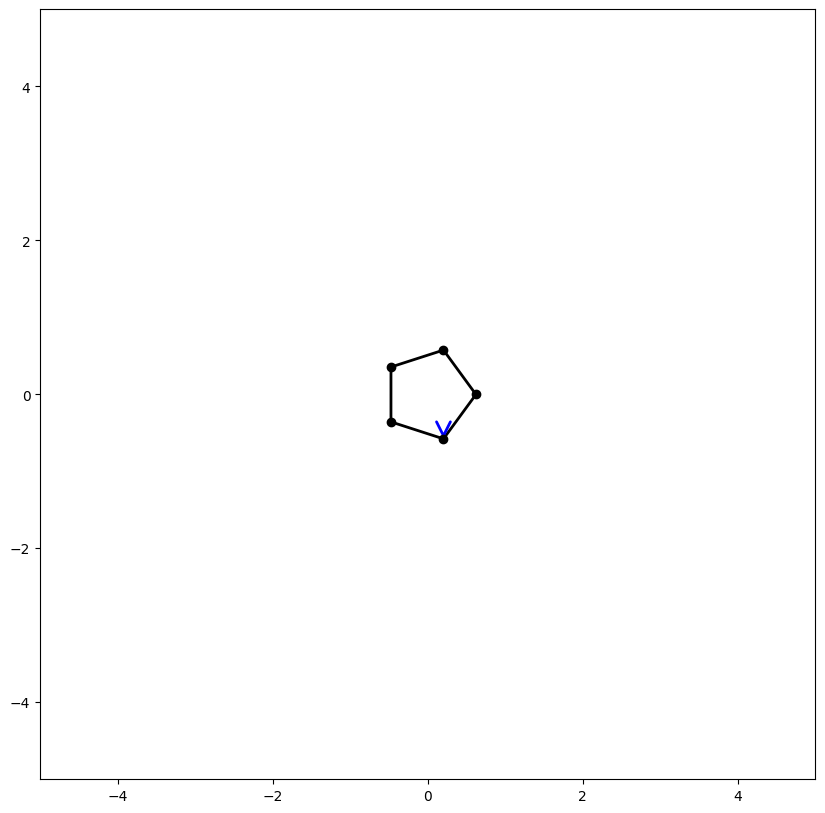

Iteration  33000 ff =  1.0150734971903775e-30 vv =  7.8457740986826506e-31 power =  8.924145534736353e-31


<Figure size 640x480 with 0 Axes>

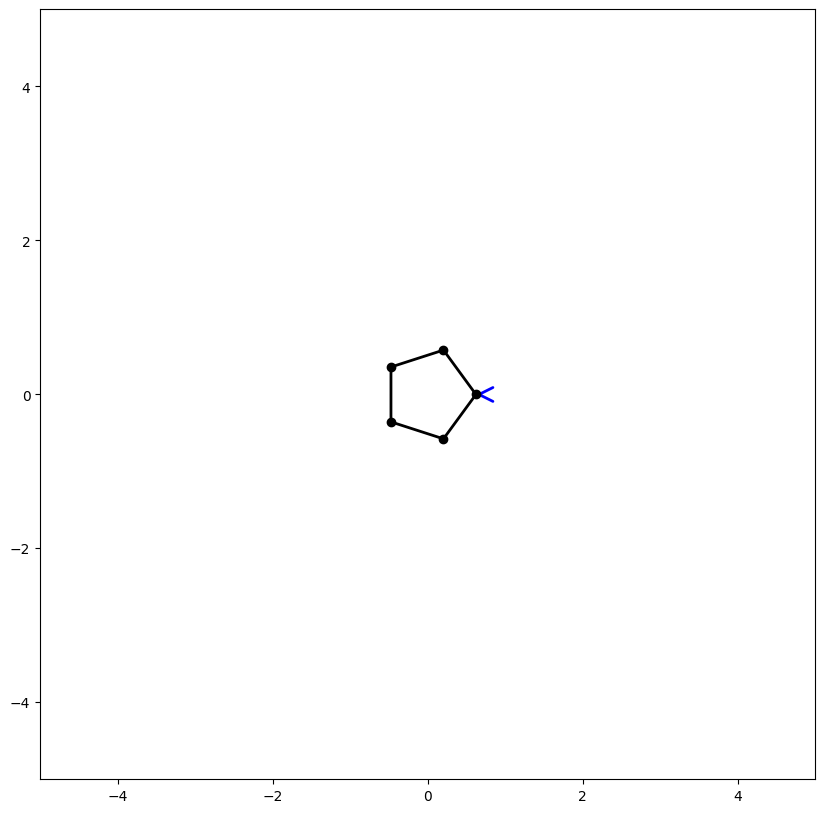

Iteration  34000 ff =  2.4580905233934452e-31 vv =  4.672959275520122e-31 power =  3.389182336694134e-31


<Figure size 640x480 with 0 Axes>

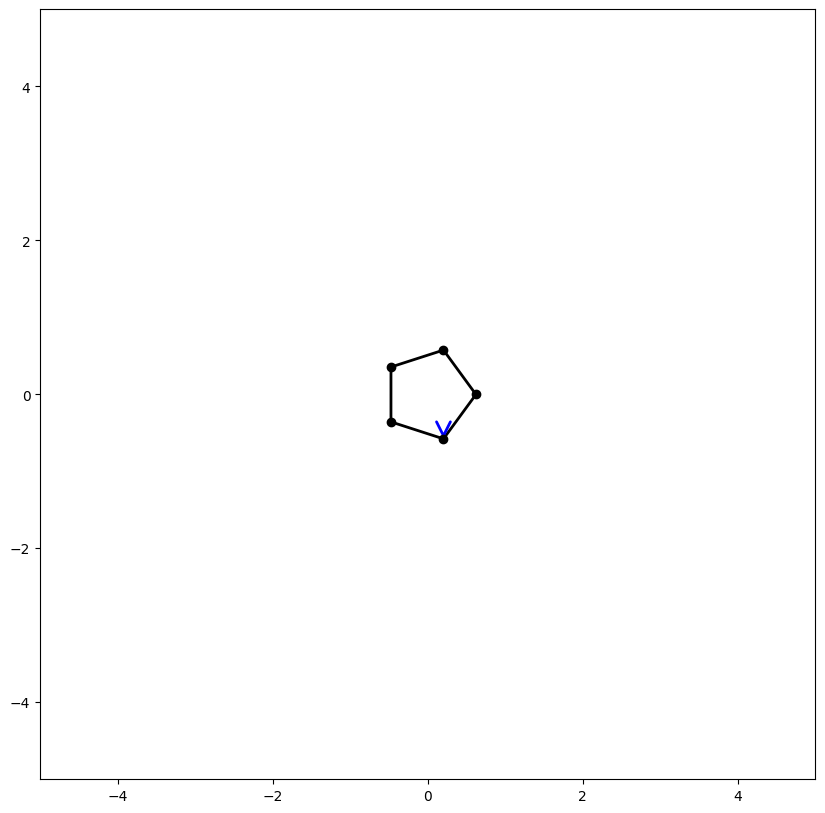

Iteration  35000 ff =  1.0150734971903775e-30 vv =  1.8077279920308e-30 power =  1.354613145824166e-30


<Figure size 640x480 with 0 Axes>

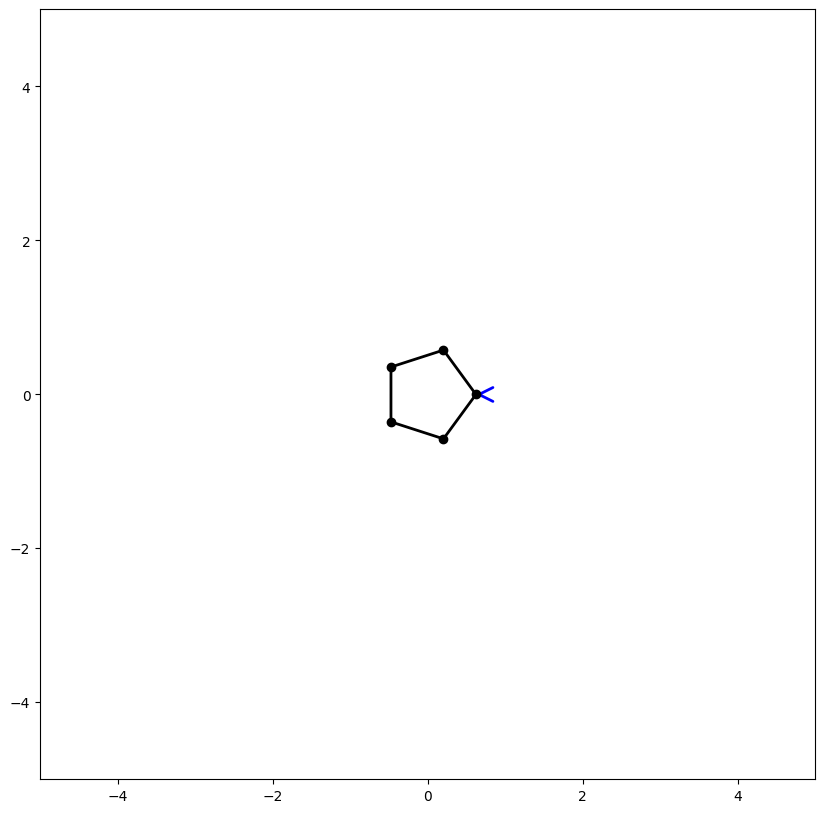

Iteration  36000 ff =  2.4580905233934452e-31 vv =  9.01797915315382e-31 power =  4.708185329458373e-31


<Figure size 640x480 with 0 Axes>

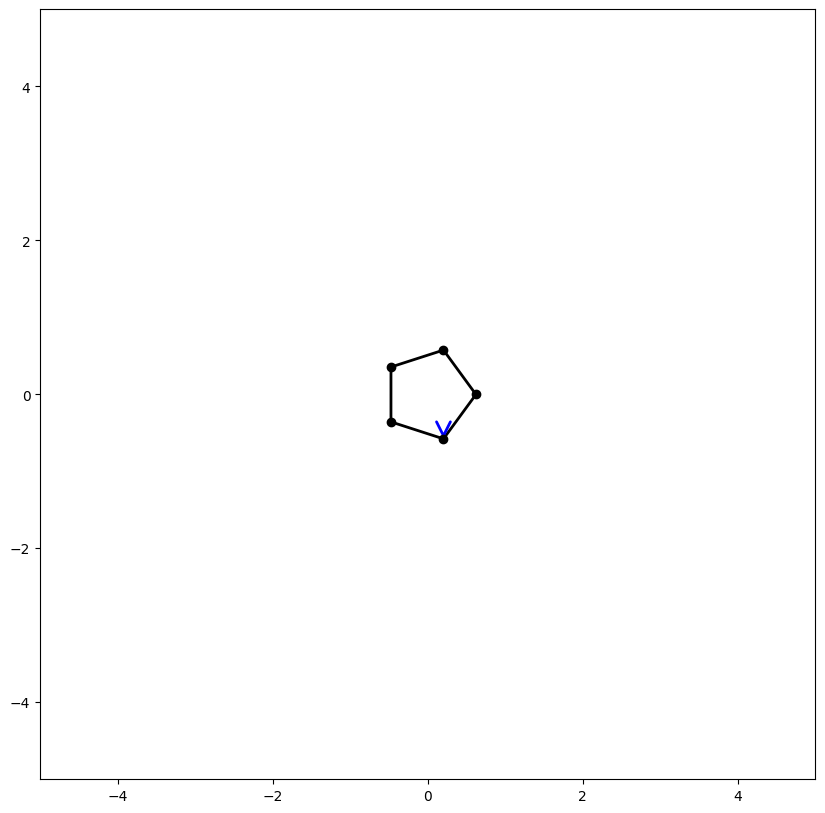

Iteration  37000 ff =  1.0150734971903775e-30 vv =  3.532105101717883e-30 power =  1.893501063650281e-30


<Figure size 640x480 with 0 Axes>

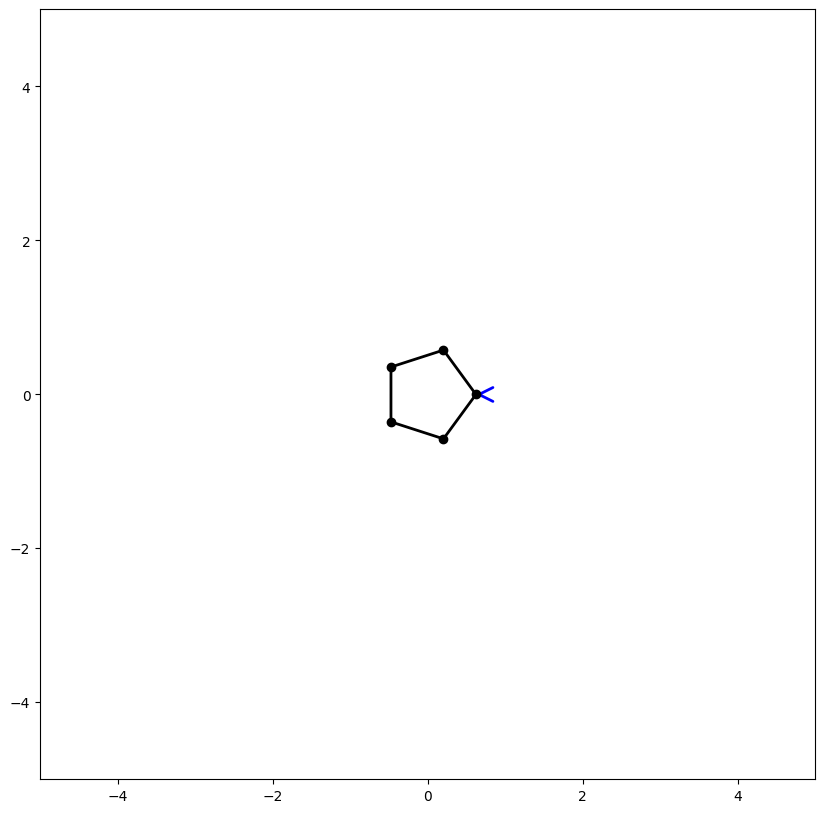

Iteration  38000 ff =  2.4580905233934452e-31 vv =  1.4940555398884537e-30 power =  6.060135117324766e-31


<Figure size 640x480 with 0 Axes>

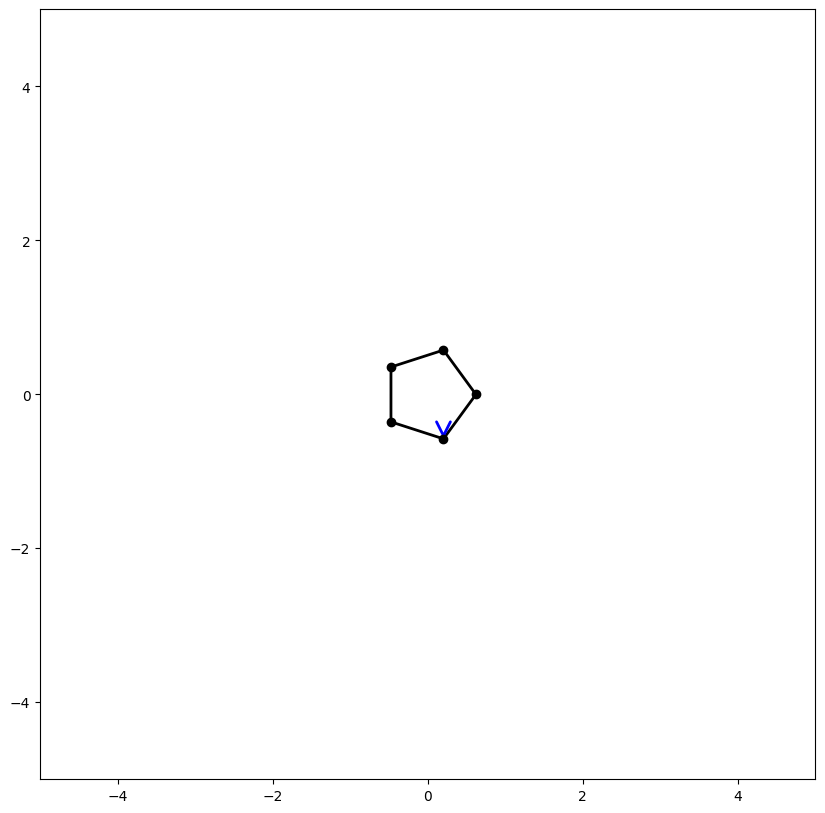

Iteration  39000 ff =  2.4580905233934452e-31 vv =  1.66166919381397e-32 power =  6.391035360822959e-32


<Figure size 640x480 with 0 Axes>

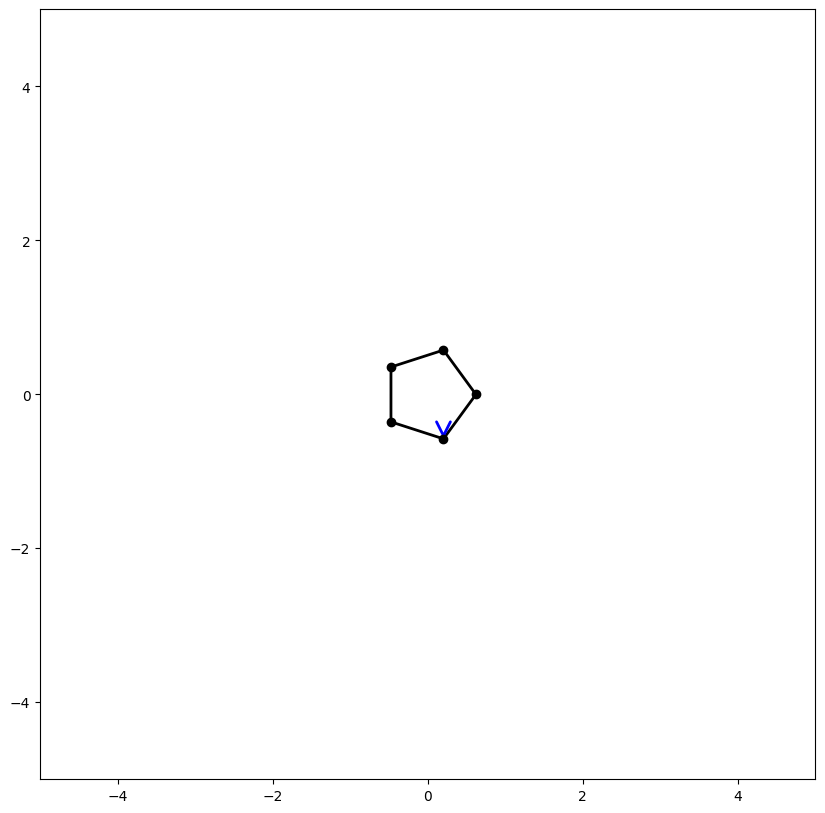

Iteration  40000 ff =  1.0150734971903775e-30 vv =  5.487106673249736e-32 power =  2.3600458809676283e-31


<Figure size 640x480 with 0 Axes>

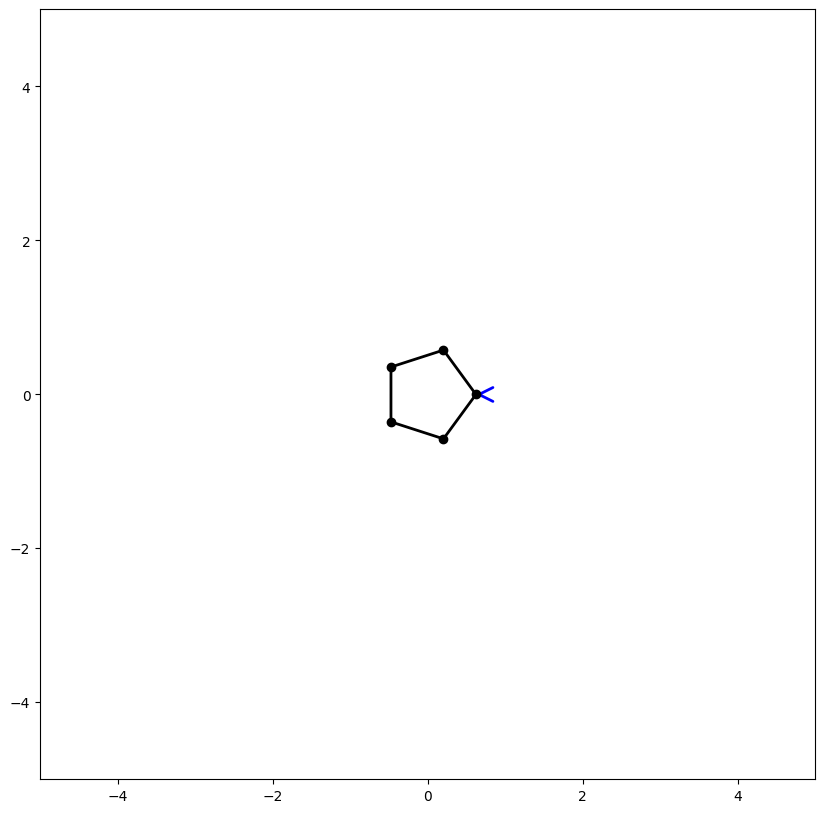

Iteration  41000 ff =  2.4580905233934452e-31 vv =  8.741056072623007e-32 power =  1.4658208313625967e-31


<Figure size 640x480 with 0 Axes>

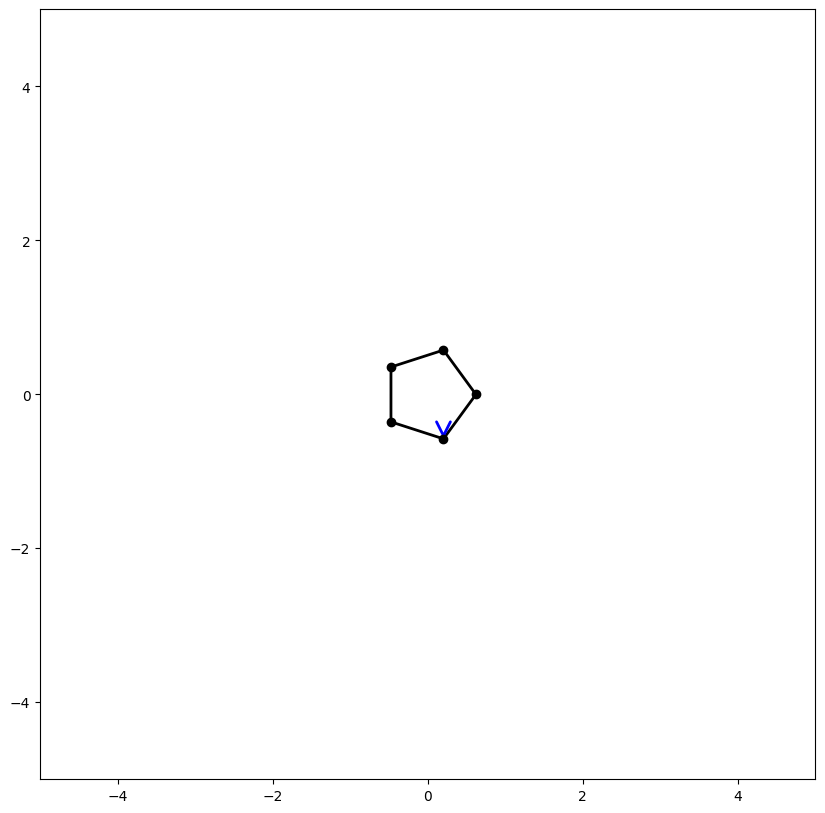

Iteration  42000 ff =  1.0150734971903775e-30 vv =  3.2180398250651247e-31 power =  5.715371325930422e-31


<Figure size 640x480 with 0 Axes>

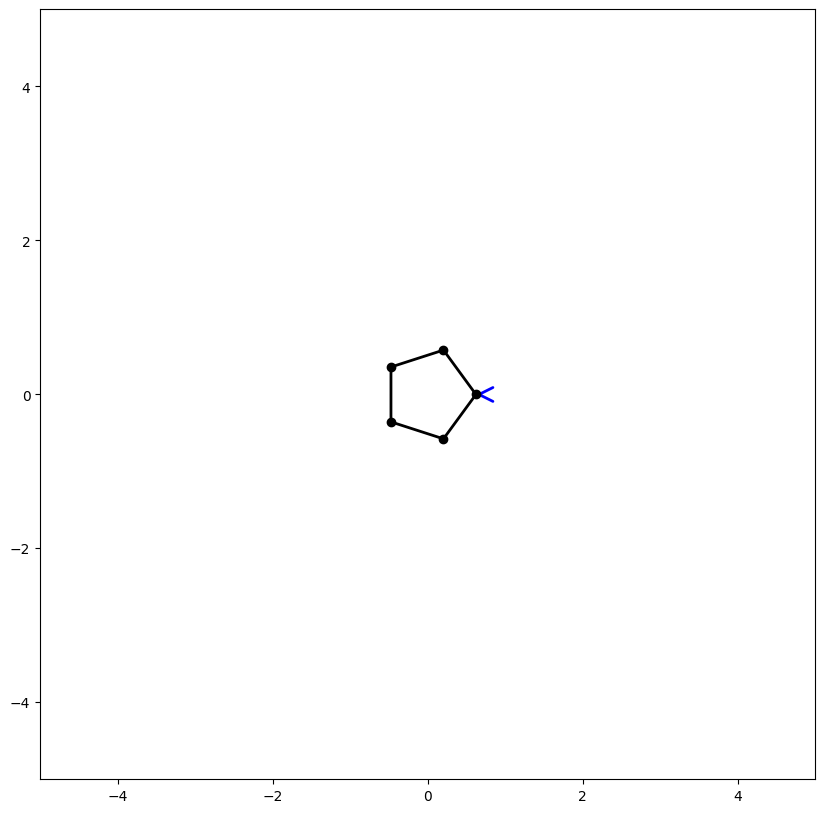

Iteration  43000 ff =  2.4580905233934452e-31 vv =  2.439887774085262e-31 power =  2.4489722365969182e-31


<Figure size 640x480 with 0 Axes>

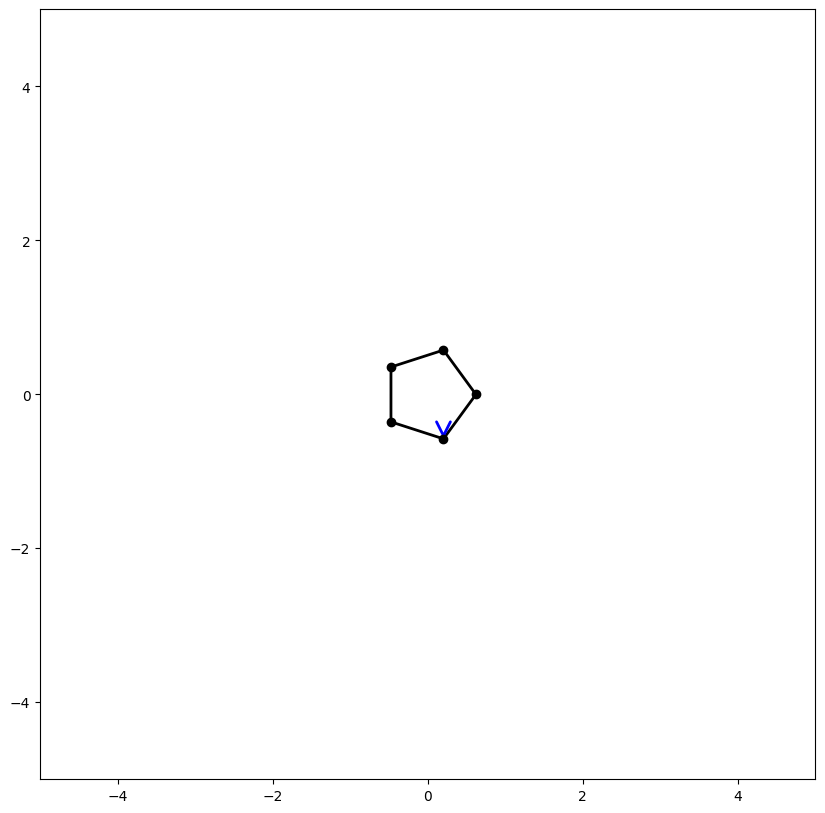

Iteration  44000 ff =  1.0150734971903775e-30 vv =  9.27766070279469e-31 power =  9.704384316035481e-31


<Figure size 640x480 with 0 Axes>

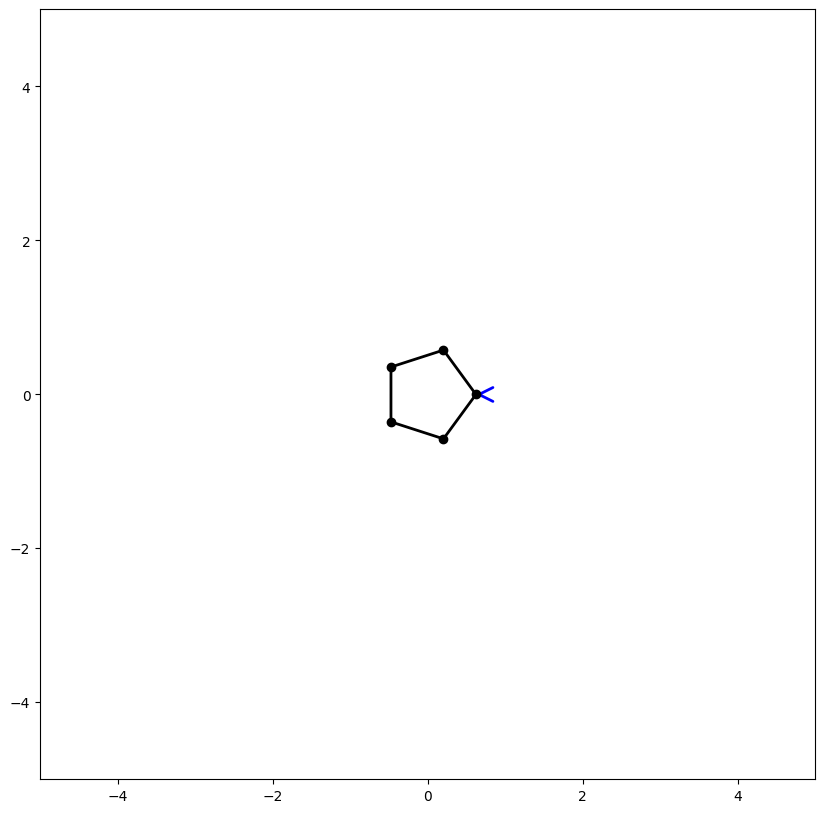

Iteration  45000 ff =  2.4580905233934452e-31 vv =  5.324657520497902e-31 power =  3.6178018452440884e-31


<Figure size 640x480 with 0 Axes>

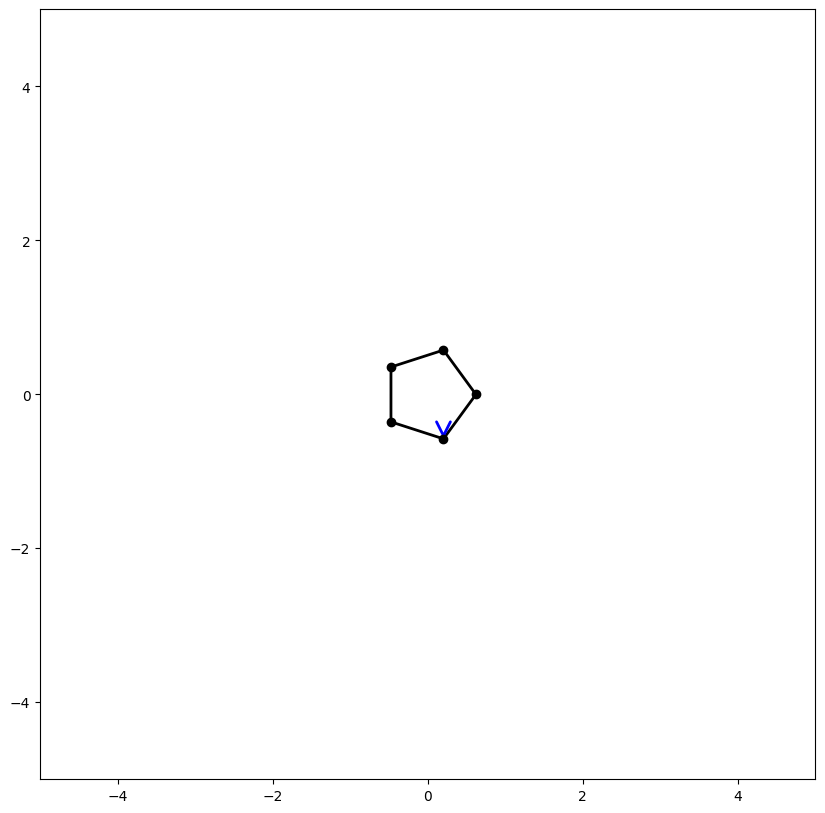

Iteration  46000 ff =  1.0150734971903775e-30 vv =  2.0556703126238404e-30 power =  1.4445263768119702e-30


<Figure size 640x480 with 0 Axes>

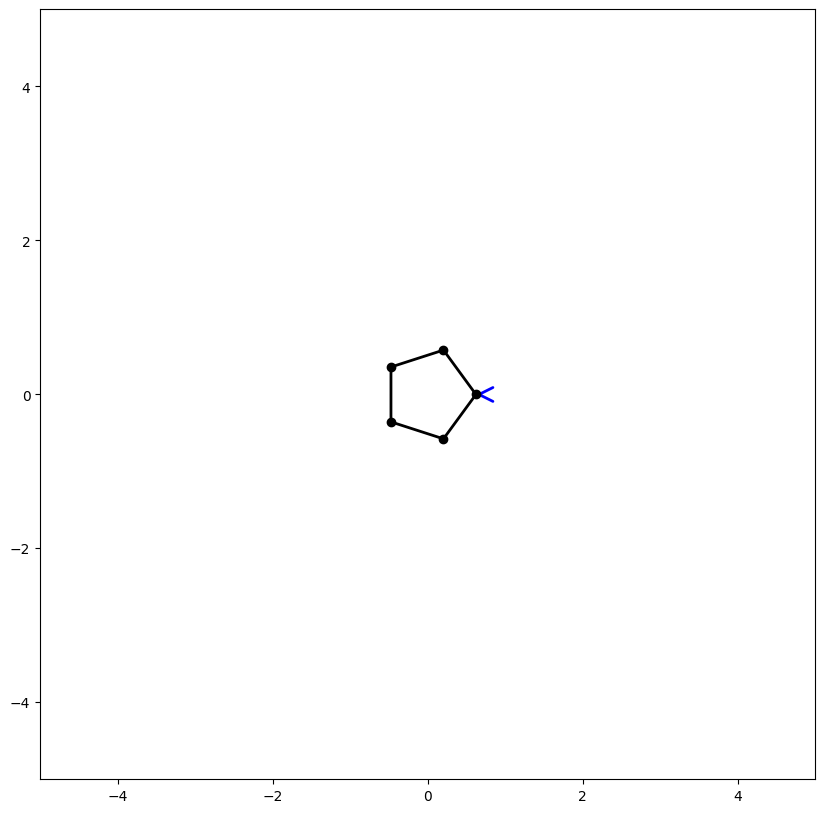

Iteration  47000 ff =  2.4580905233934452e-31 vv =  9.984197124279427e-31 power =  4.953994381797717e-31


<Figure size 640x480 with 0 Axes>

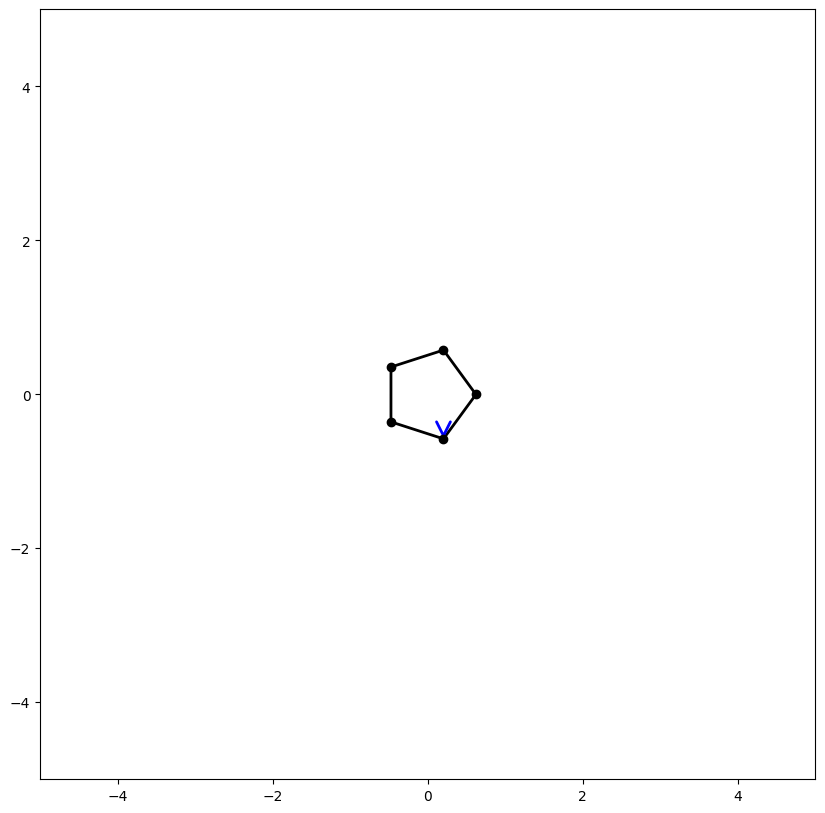

Iteration  48000 ff =  2.4580905233934452e-31 vv =  1.5363065771209036e-34 power =  6.145226308483614e-33


<Figure size 640x480 with 0 Axes>

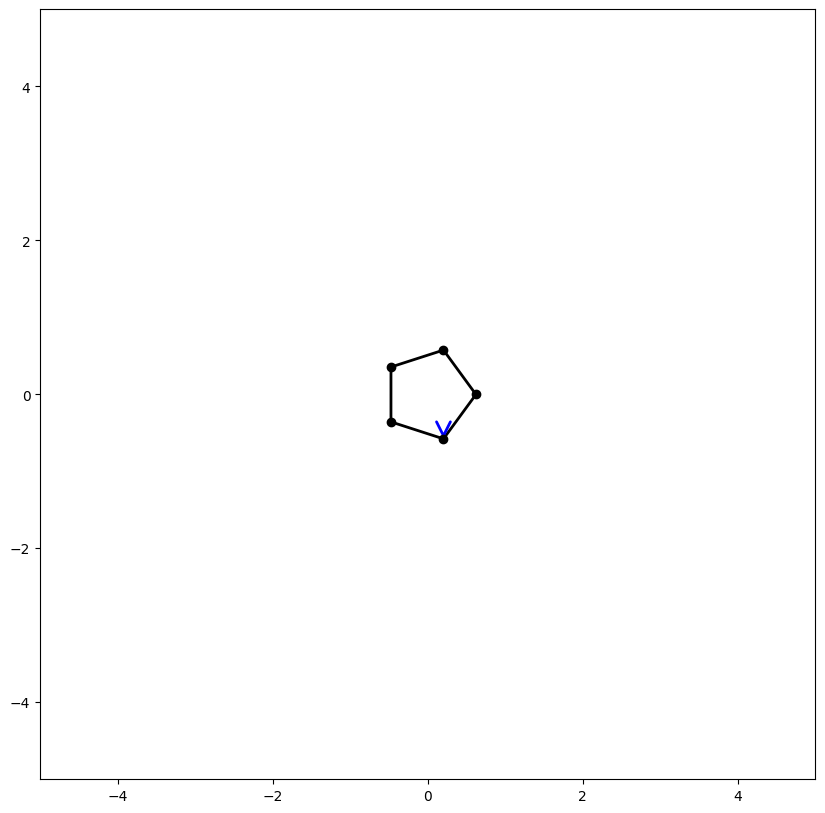

Iteration  49000 ff =  1.0150734971903775e-30 vv =  1.4523060522614651e-30 power =  -1.0042767768810839e-30


<Figure size 640x480 with 0 Axes>

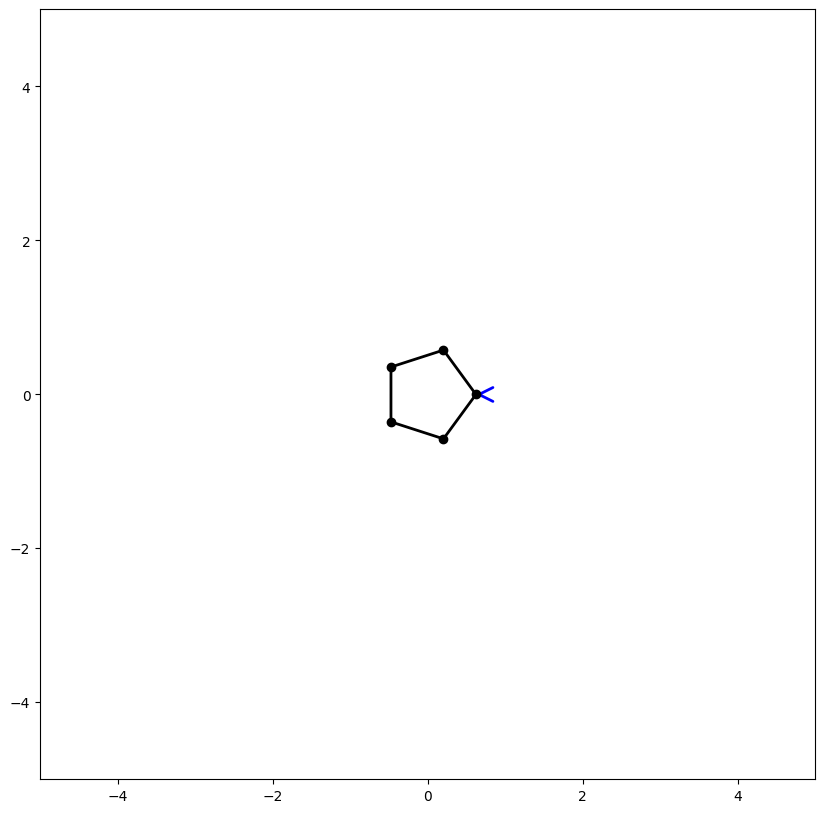

Iteration  50000 ff =  2.4580905233934452e-31 vv =  2.4390403218371479e-32 power =  7.742985148689355e-32


<Figure size 640x480 with 0 Axes>

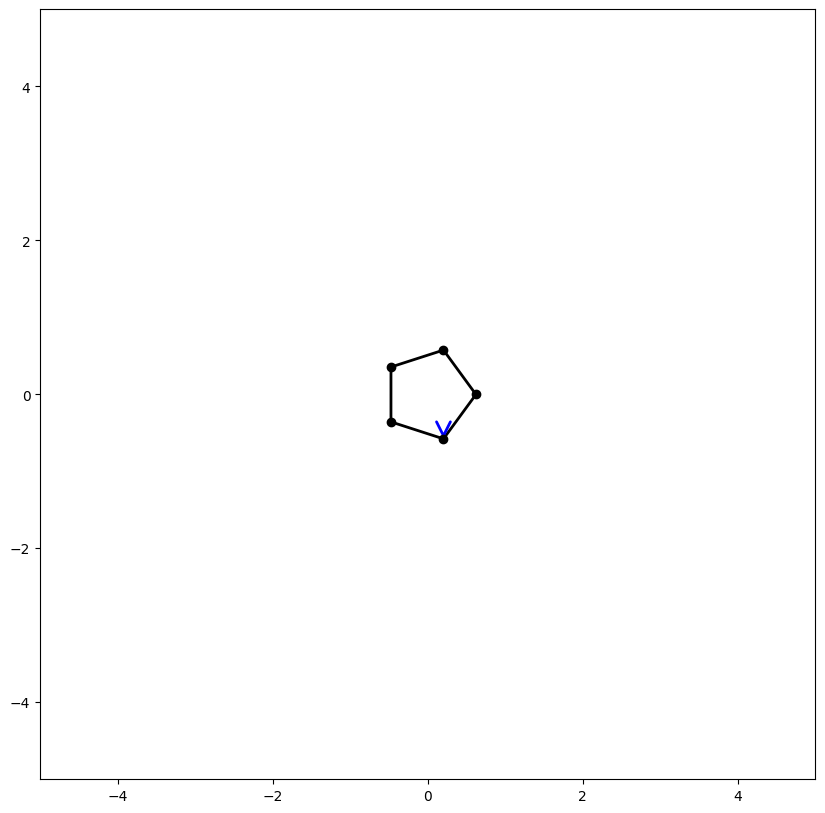

Iteration  51000 ff =  1.0150734971903775e-30 vv =  8.390216875214216e-32 power =  2.9183363044223356e-31


<Figure size 640x480 with 0 Axes>

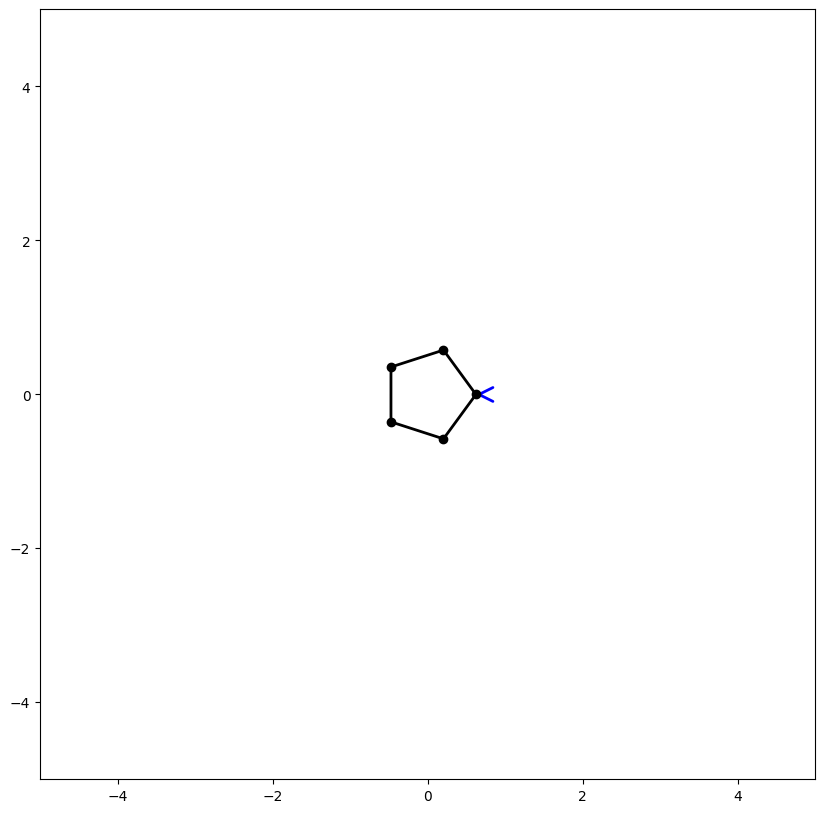

Iteration  52000 ff =  2.4580905233934452e-31 vv =  1.080093003180946e-31 power =  1.6294067556944308e-31


<Figure size 640x480 with 0 Axes>

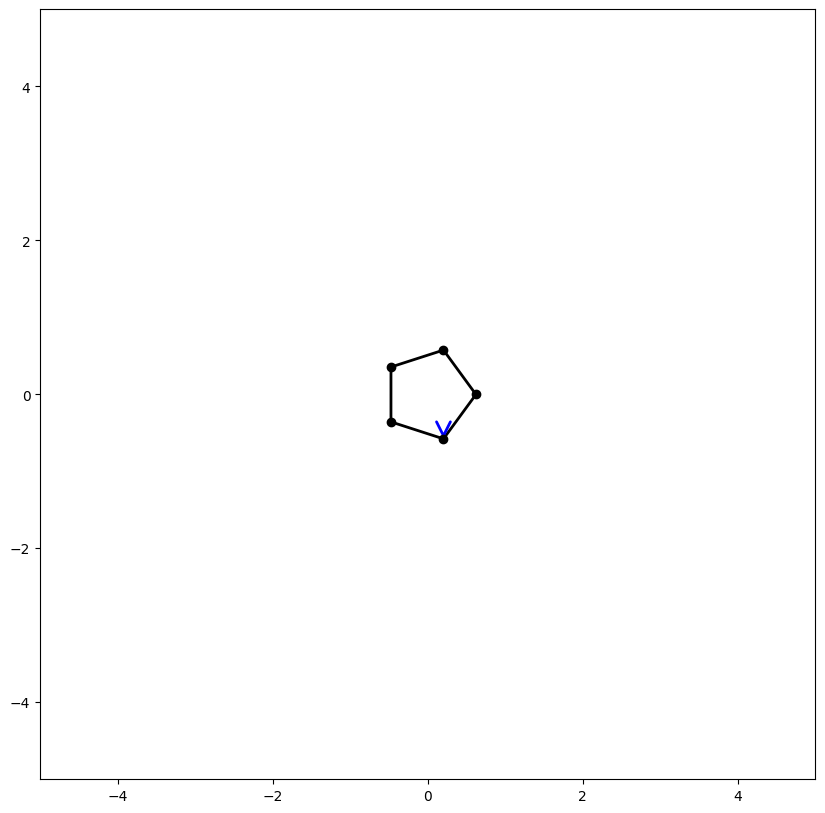

Iteration  53000 ff =  1.0150734971903775e-30 vv =  4.0237123640403655e-31 power =  6.3909027383106186e-31


<Figure size 640x480 with 0 Axes>

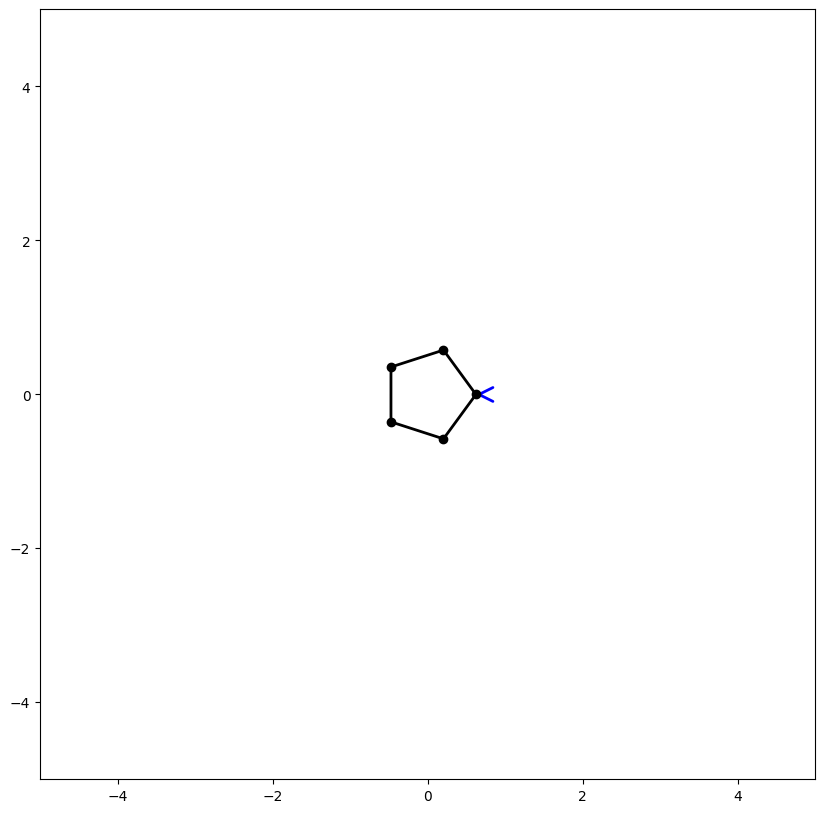

Iteration  54000 ff =  2.4580905233934452e-31 vv =  2.85023633616467e-31 power =  2.646911205038437e-31


<Figure size 640x480 with 0 Axes>

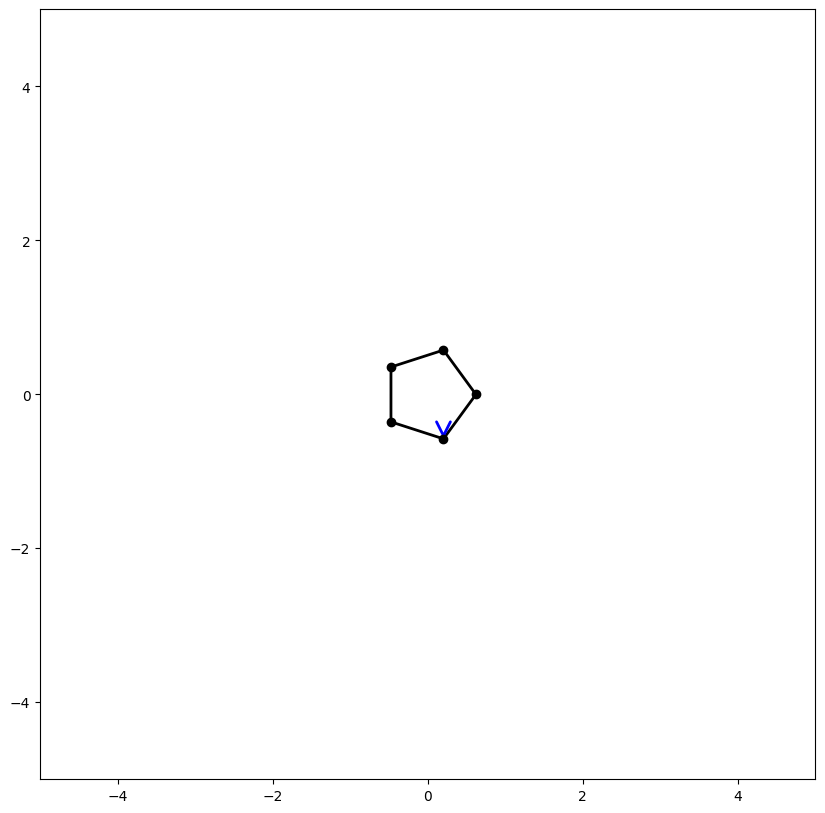

Iteration  55000 ff =  1.0150734971903775e-30 vv =  1.090638248202114e-30 power =  1.0521777325015517e-30


<Figure size 640x480 with 0 Axes>

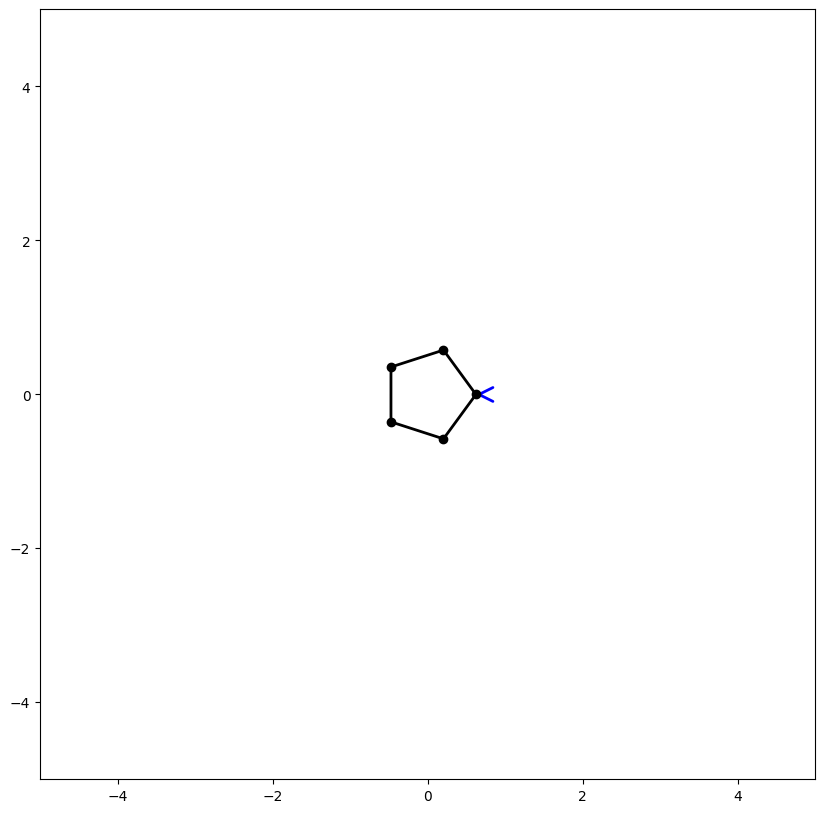

Iteration  56000 ff =  2.4580905233934452e-31 vv =  6.053001239201554e-31 power =  3.8573079970583263e-31


<Figure size 640x480 with 0 Axes>

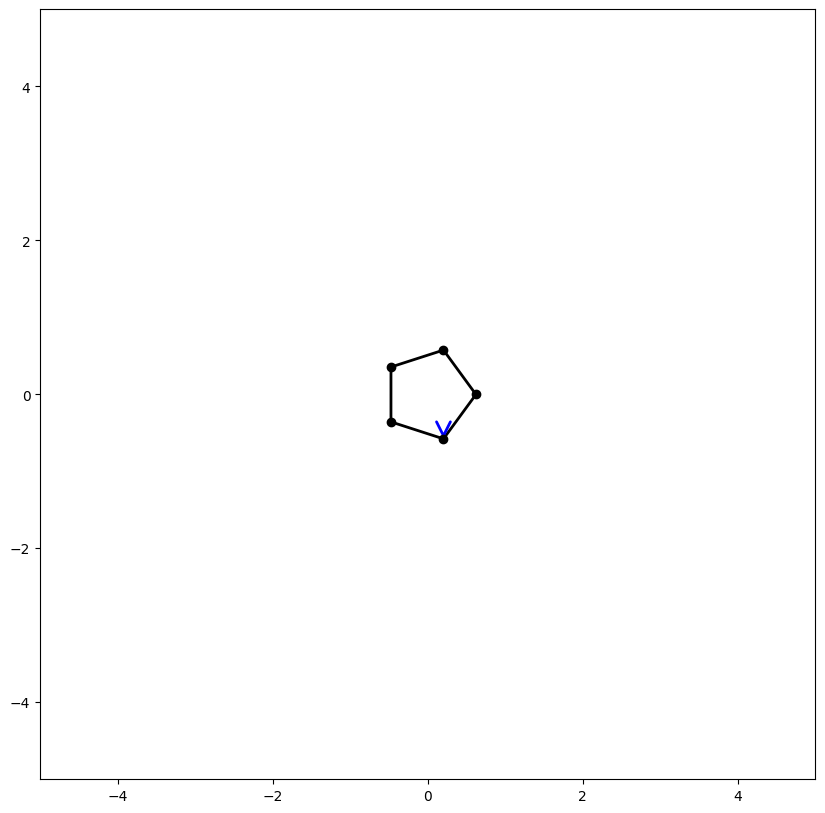

Iteration  57000 ff =  1.0150734971903775e-30 vv =  2.3468044876041146e-30 power =  1.5434309308985554e-30


<Figure size 640x480 with 0 Axes>

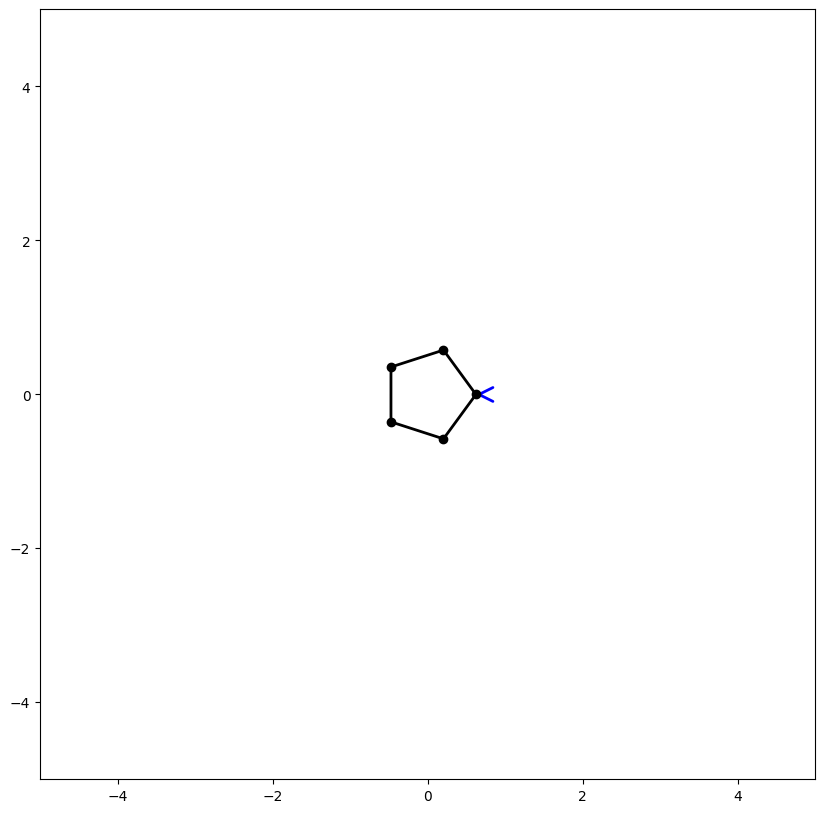

Iteration  58000 ff =  2.4580905233934452e-31 vv =  1.0999576905872905e-30 power =  5.199803434137061e-31


<Figure size 640x480 with 0 Axes>

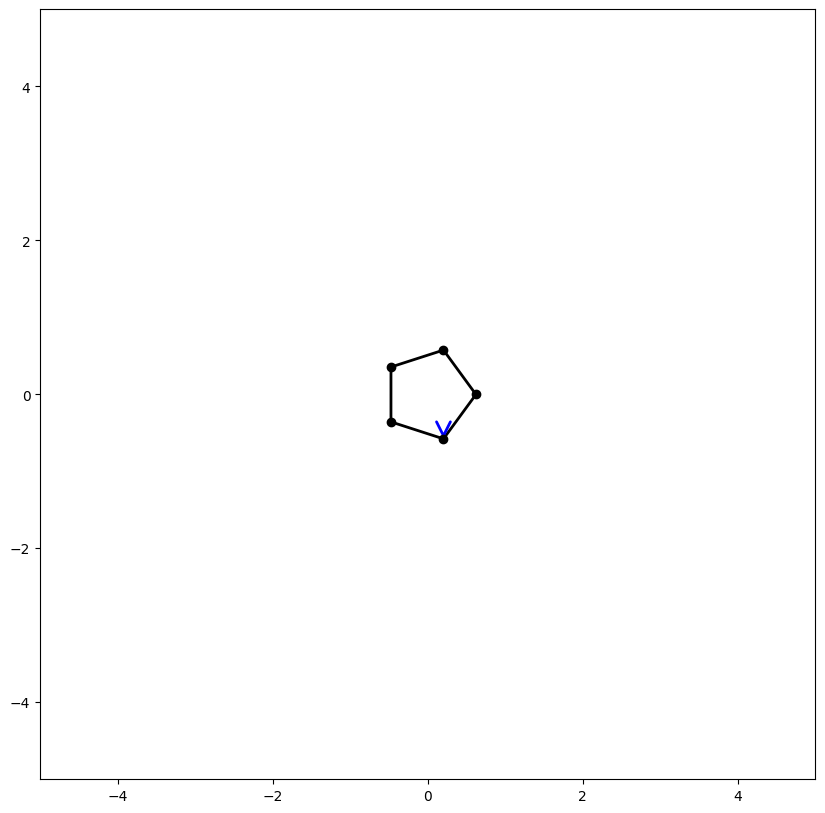

Iteration  59000 ff =  2.4580905233934452e-31 vv =  1.3826759194088132e-33 power =  1.843567892545084e-32


<Figure size 640x480 with 0 Axes>

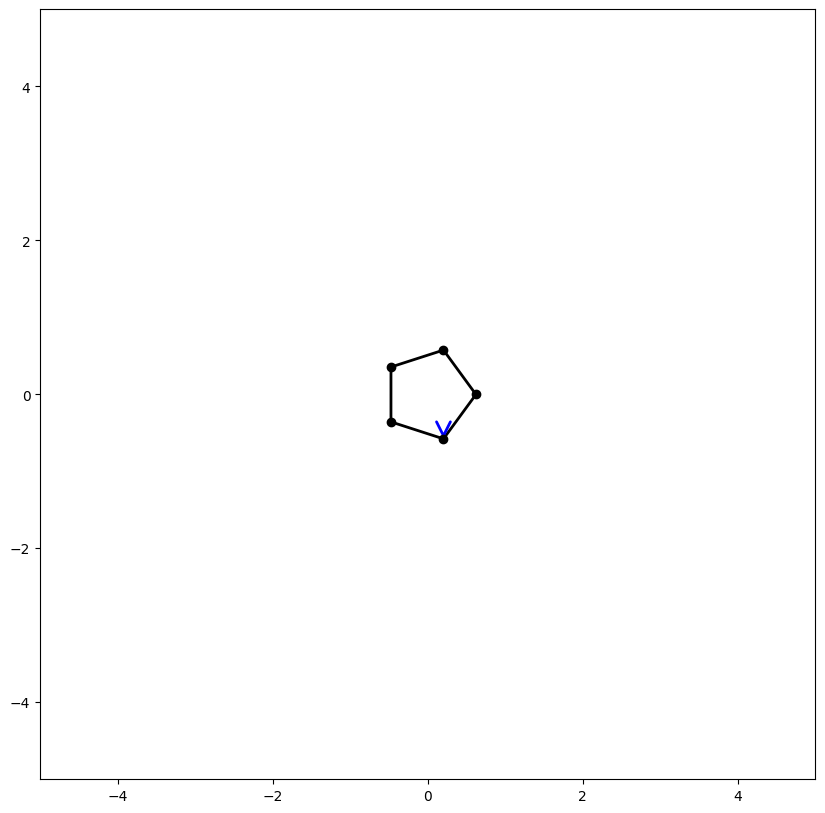

Iteration  60000 ff =  1.0150734971903775e-30 vv =  2.5376837429759438e-33 power =  5.075367485951889e-32


<Figure size 640x480 with 0 Axes>

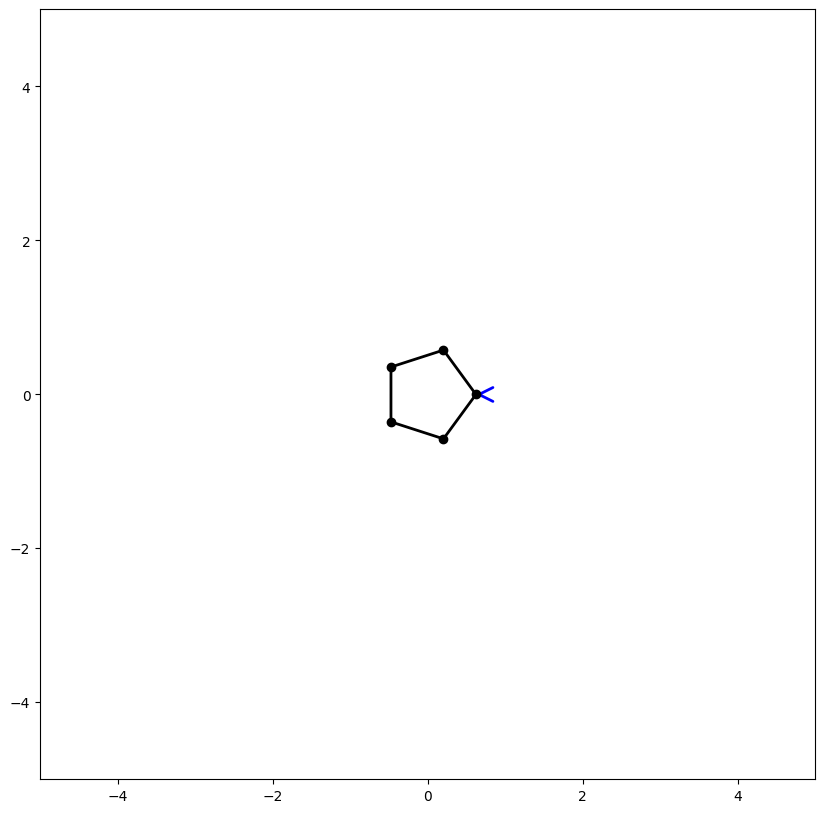

Iteration  61000 ff =  2.4580905233934452e-31 vv =  3.4659137832110675e-32 power =  9.230129915342389e-32


<Figure size 640x480 with 0 Axes>

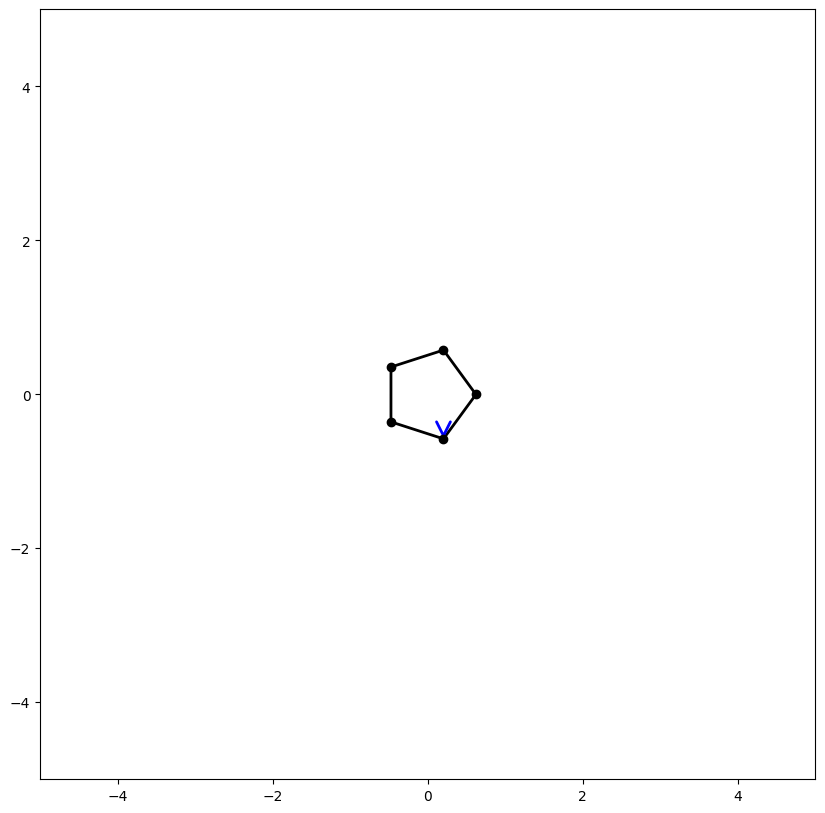

Iteration  62000 ff =  1.0150734971903775e-30 vv =  1.2099428662344363e-31 power =  3.504541249049779e-31


<Figure size 640x480 with 0 Axes>

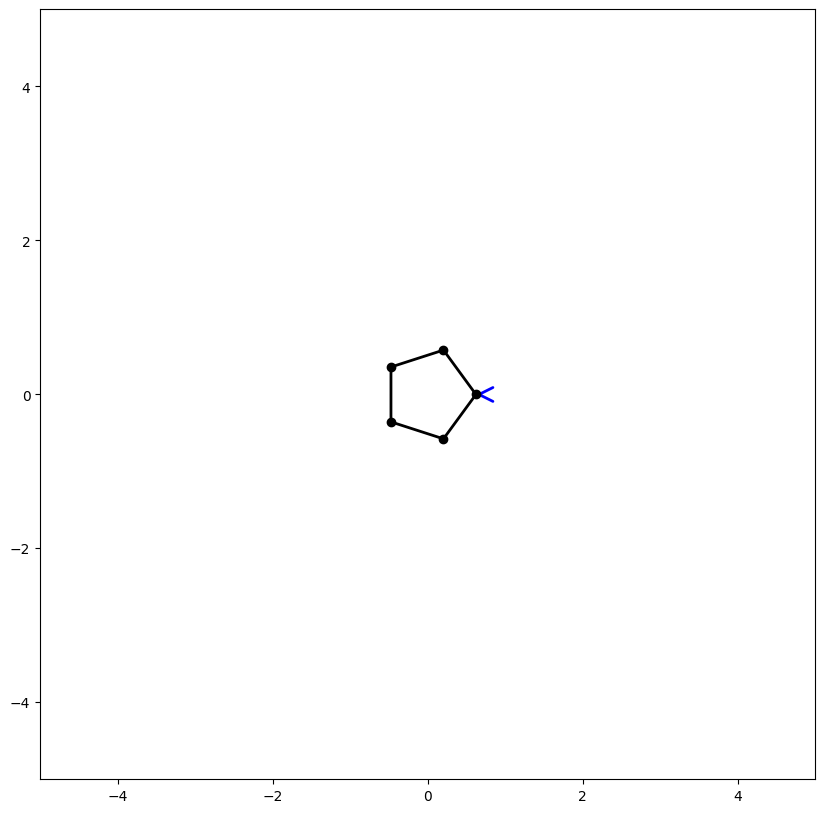

Iteration  63000 ff =  2.4580905233934452e-31 vv =  1.3198132685218938e-31 power =  1.8011719762428565e-31


<Figure size 640x480 with 0 Axes>

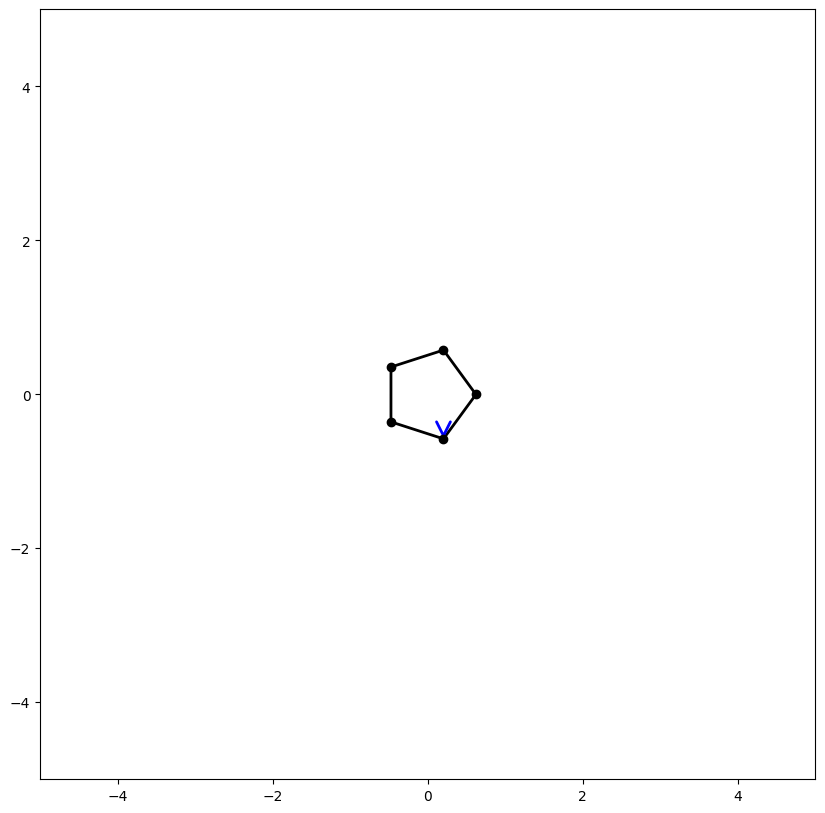

Iteration  64000 ff =  1.0150734971903775e-30 vv =  4.919298134003411e-31 power =  7.066434150690815e-31


<Figure size 640x480 with 0 Axes>

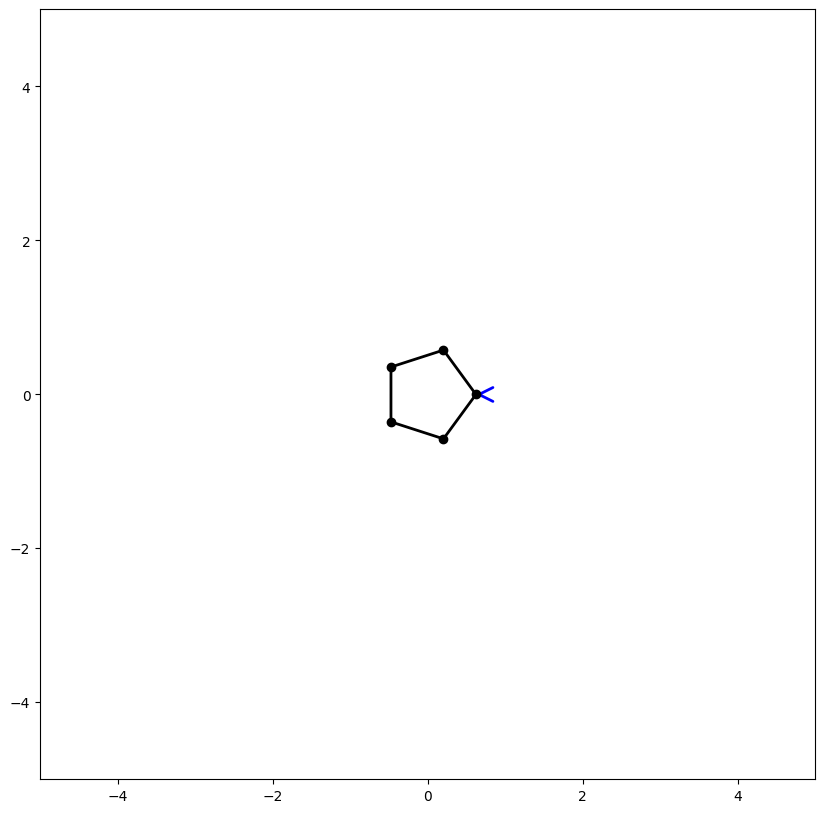

Iteration  65000 ff =  2.4580905233934452e-31 vv =  3.292463167050553e-31 power =  2.8448501734799555e-31


<Figure size 640x480 with 0 Axes>

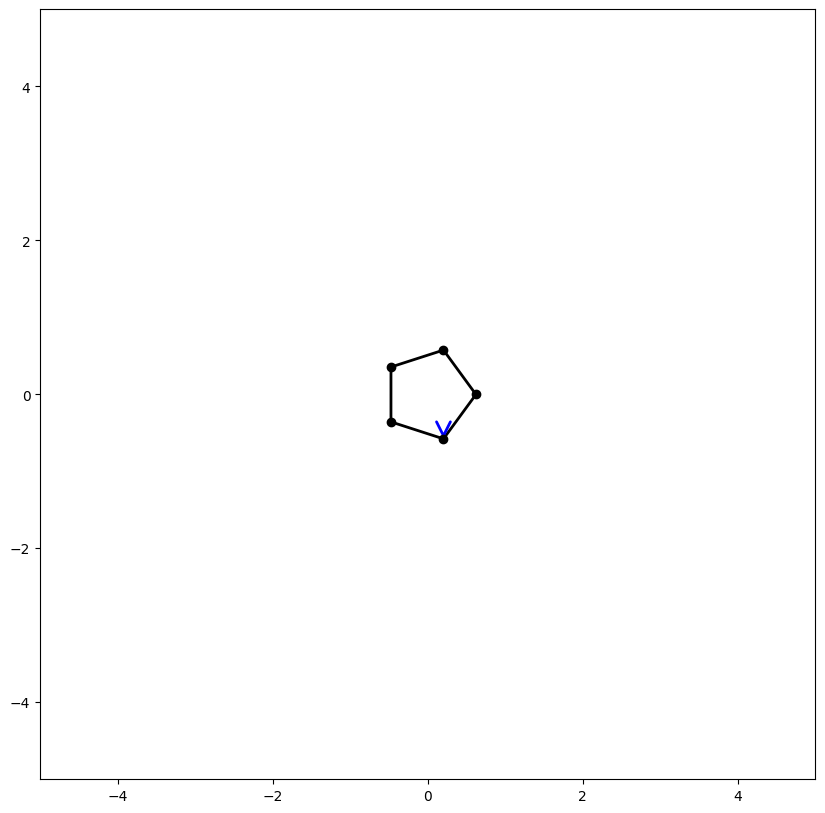

Iteration  66000 ff =  1.0150734971903775e-30 vv =  1.2666746222736837e-30 power =  1.1339170333995555e-30


<Figure size 640x480 with 0 Axes>

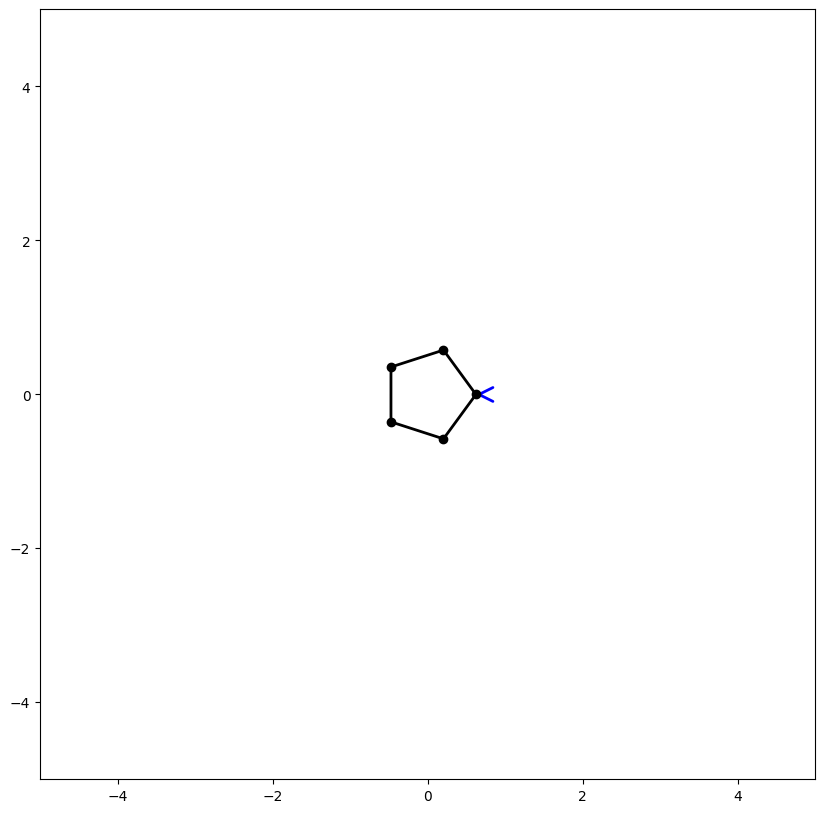

Iteration  67000 ff =  2.4580905233934452e-31 vv =  6.828017931264766e-31 power =  4.0968141488725655e-31


<Figure size 640x480 with 0 Axes>

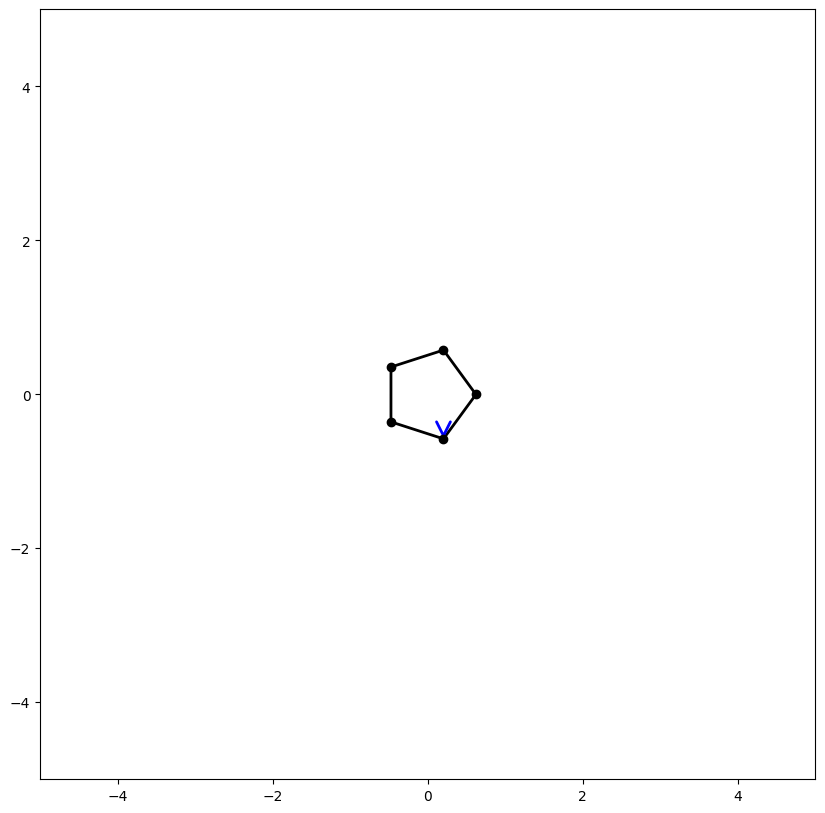

Iteration  68000 ff =  1.0150734971903775e-30 vv =  2.657212362166028e-30 power =  1.6423354849851395e-30


<Figure size 640x480 with 0 Axes>

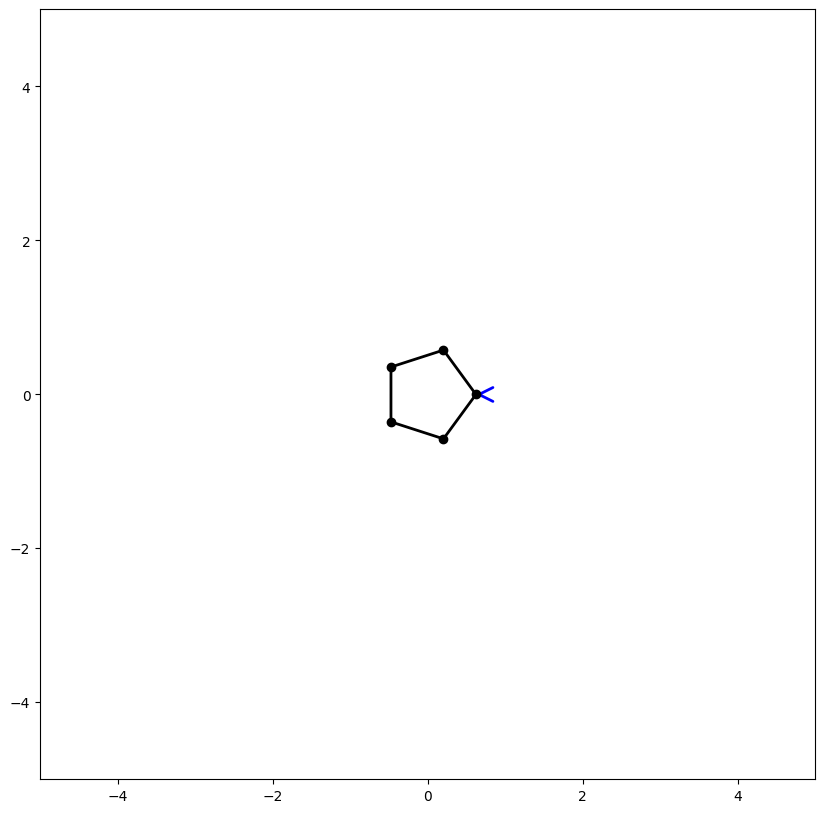

Iteration  69000 ff =  2.4580905233934452e-31 vv =  1.2064118497934251e-30 power =  5.4456124864764064e-31


<Figure size 640x480 with 0 Axes>

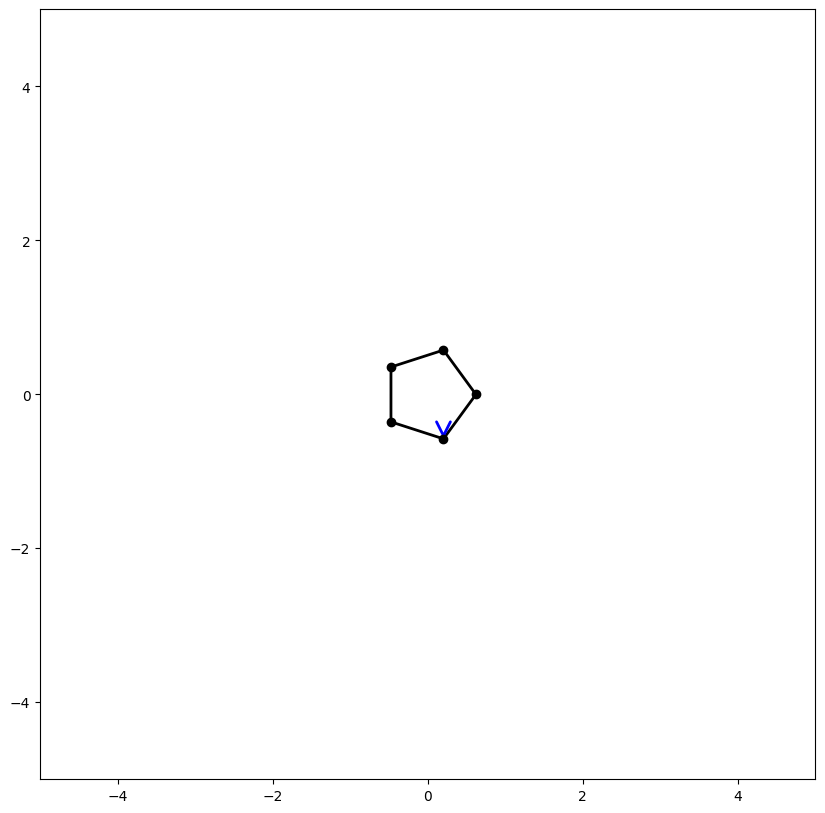

Iteration  70000 ff =  2.4580905233934452e-31 vv =  3.84076644280226e-33 power =  3.0726131542418076e-32


<Figure size 640x480 with 0 Axes>

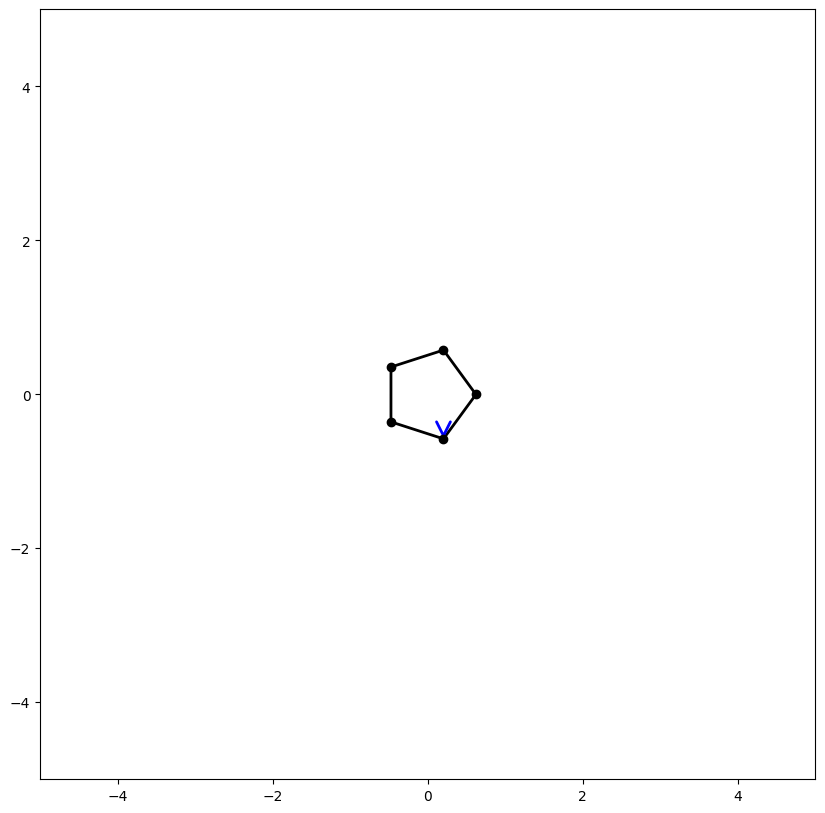

Iteration  71000 ff =  1.0150734971903775e-30 vv =  1.0150734971903775e-32 power =  1.0150734971903777e-31


<Figure size 640x480 with 0 Axes>

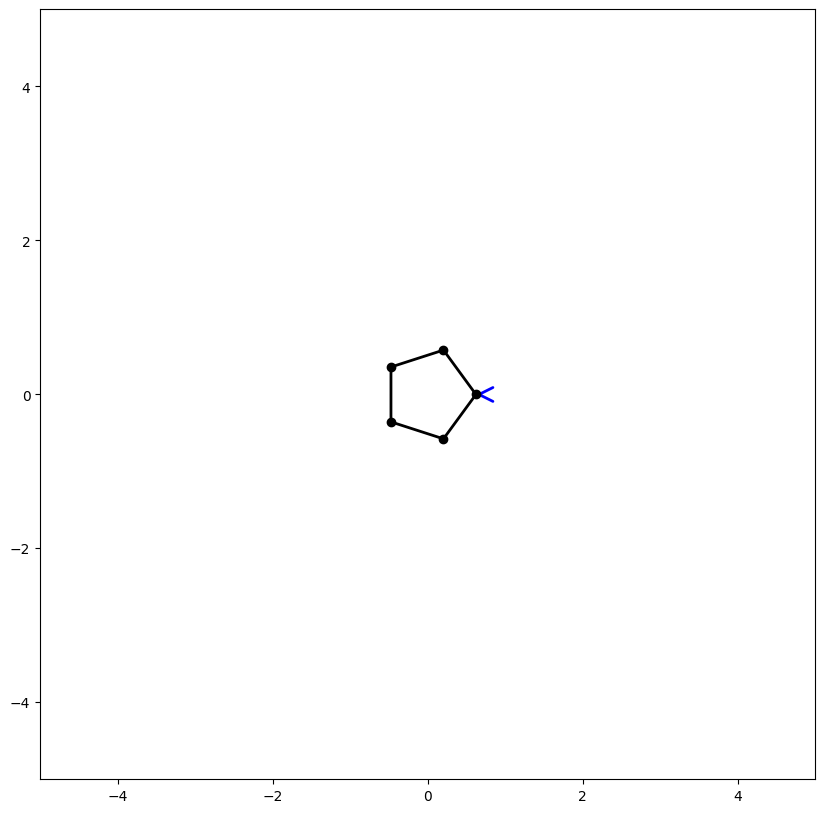

Iteration  72000 ff =  2.4580905233934452e-31 vv =  4.6727317613500046e-32 power =  1.0717274681995422e-31


<Figure size 640x480 with 0 Axes>

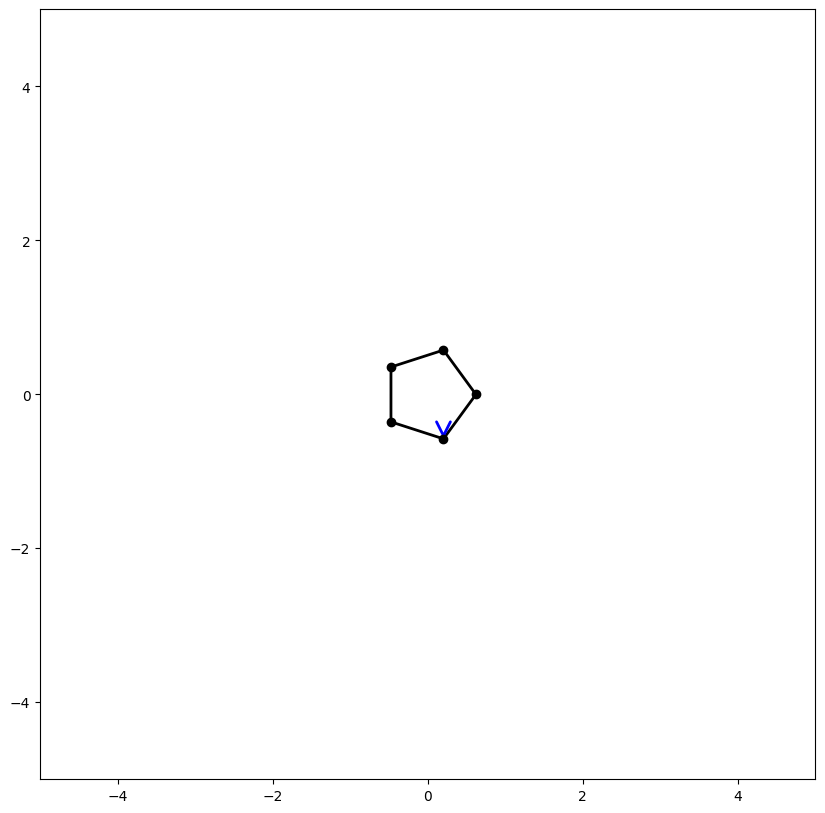

Iteration  73000 ff =  1.0150734971903775e-30 vv =  1.6711465850503704e-31 power =  4.118660714849957e-31


<Figure size 640x480 with 0 Axes>

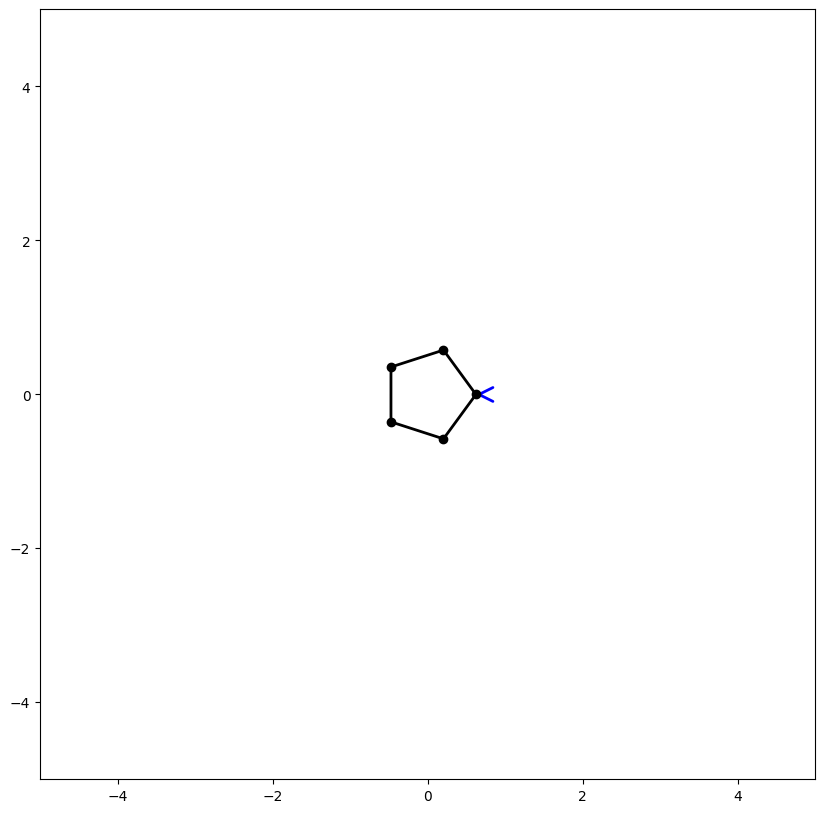

Iteration  74000 ff =  2.4580905233934452e-31 vv =  1.5966956959133935e-31 power =  1.9811164930078737e-31


<Figure size 640x480 with 0 Axes>

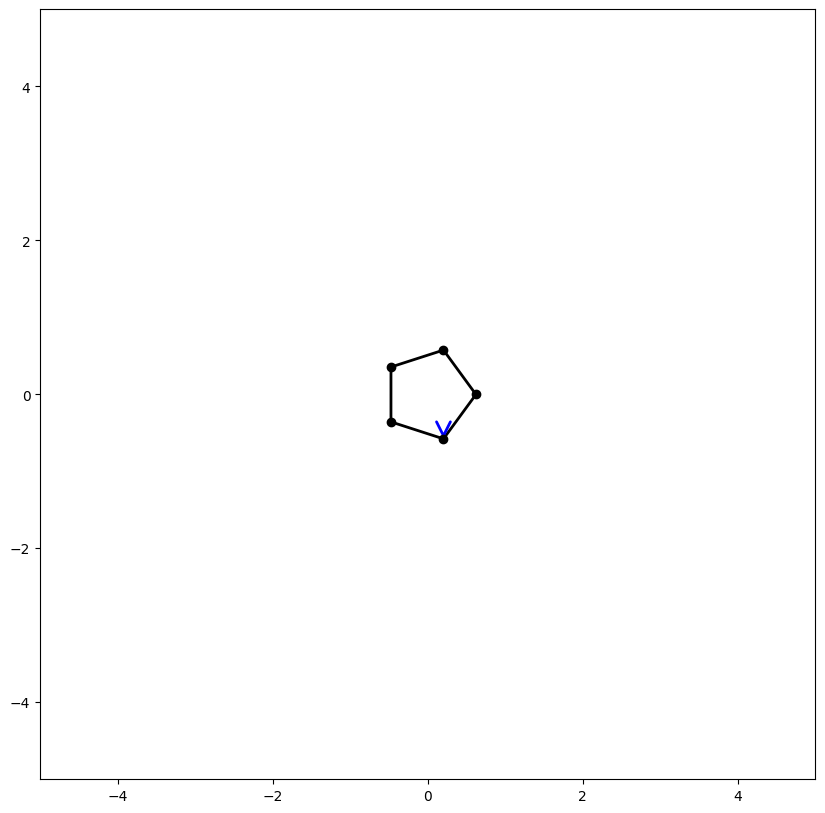

Iteration  75000 ff =  1.0150734971903775e-30 vv =  6.008292262753675e-31 power =  7.80951870430903e-31


<Figure size 640x480 with 0 Axes>

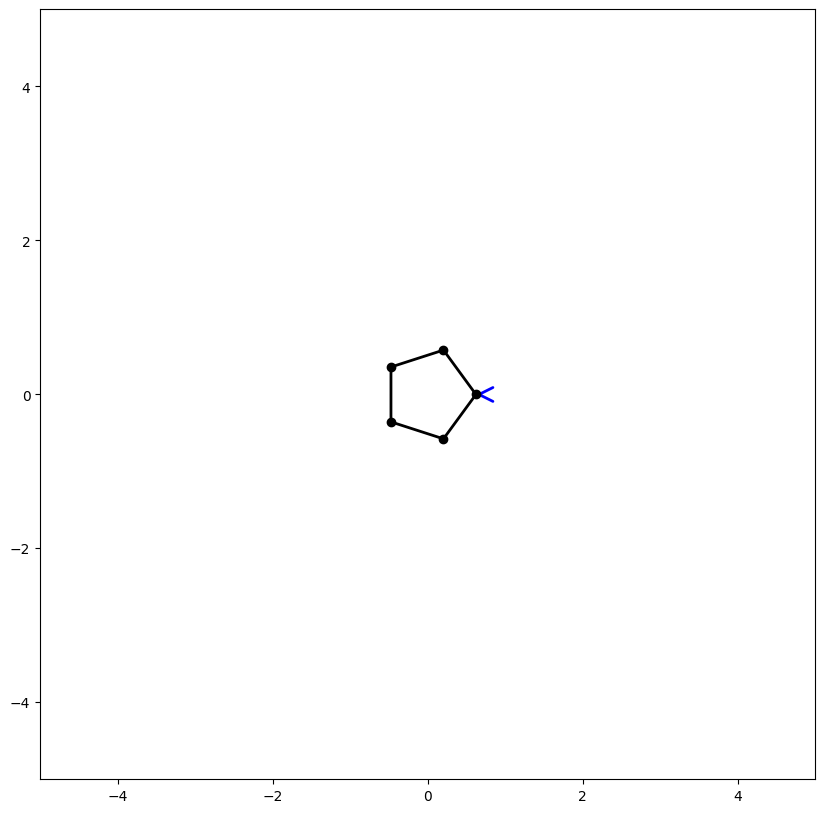

Iteration  76000 ff =  2.4580905233934452e-31 vv =  3.8157320814965044e-31 power =  3.0625830387656277e-31


<Figure size 640x480 with 0 Axes>

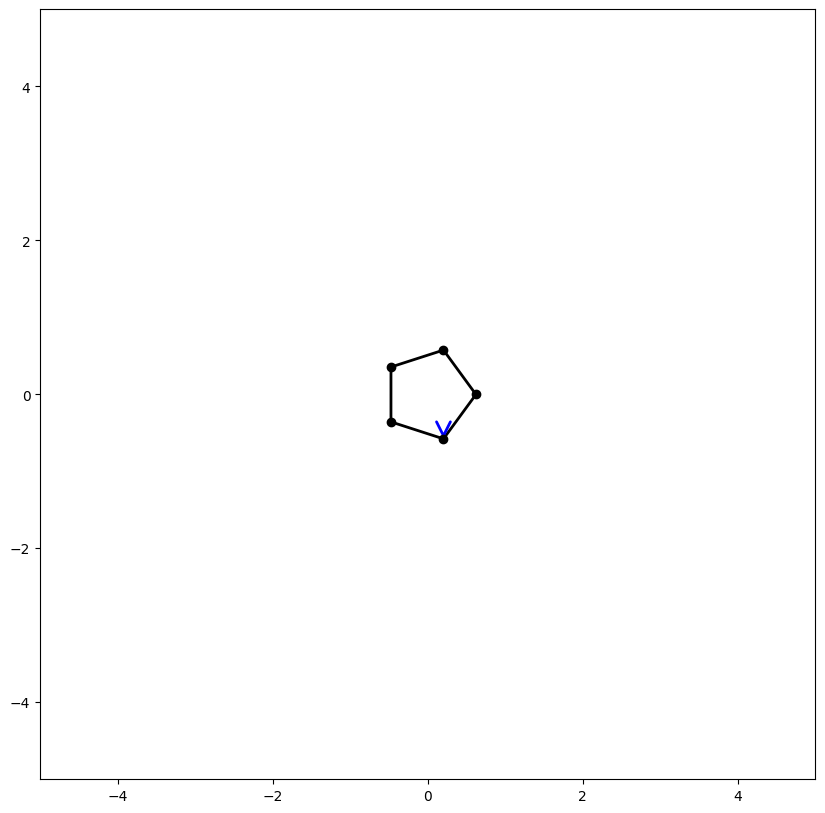

Iteration  77000 ff =  1.0150734971903775e-30 vv =  1.465680781154112e-30 power =  1.2197432993424597e-30


<Figure size 640x480 with 0 Axes>

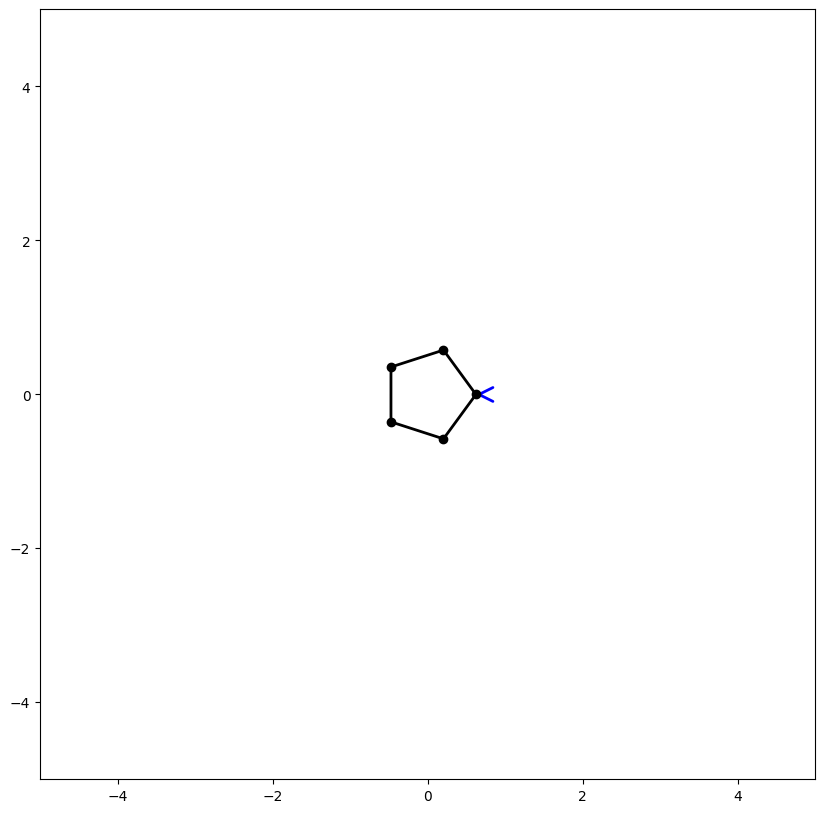

Iteration  78000 ff =  2.4580905233934452e-31 vv =  7.660830591092658e-31 power =  4.339471750949357e-31


<Figure size 640x480 with 0 Axes>

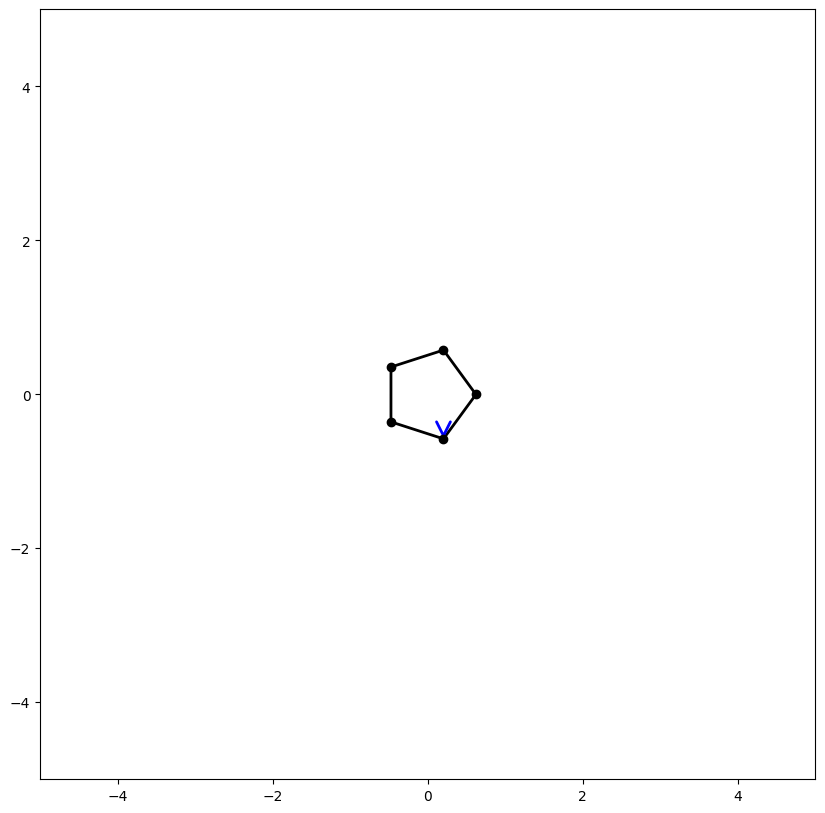

Iteration  79000 ff =  1.0150734971903775e-30 vv =  2.9868939363095826e-30 power =  1.7412400390717243e-30


<Figure size 640x480 with 0 Axes>

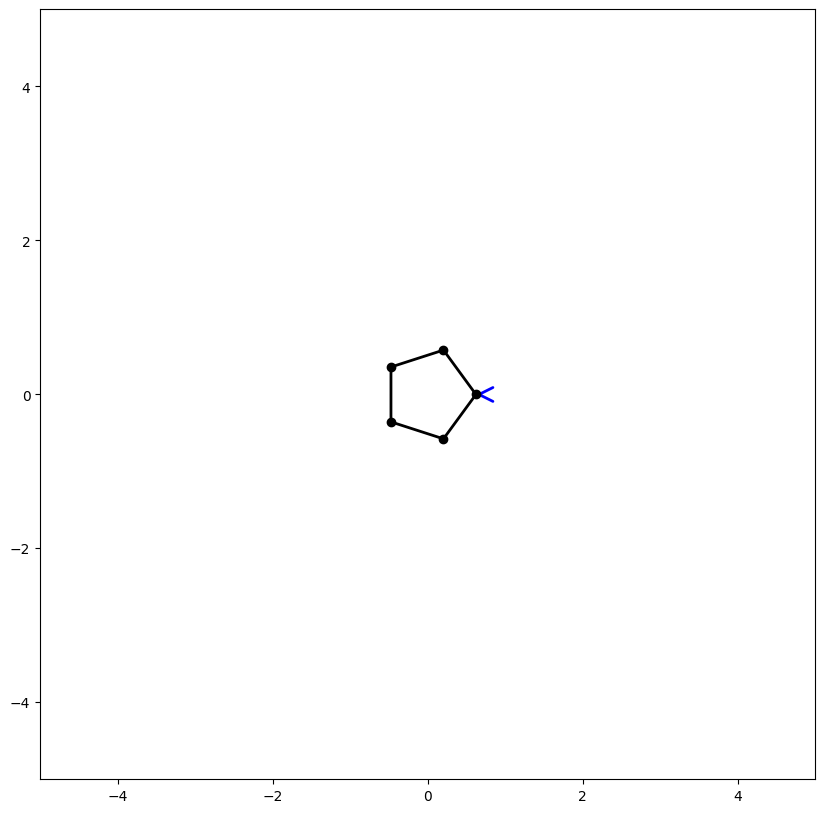

Iteration  80000 ff =  2.4580905233934452e-31 vv =  1.3177821900463467e-30 power =  5.6914215388157515e-31


<Figure size 640x480 with 0 Axes>

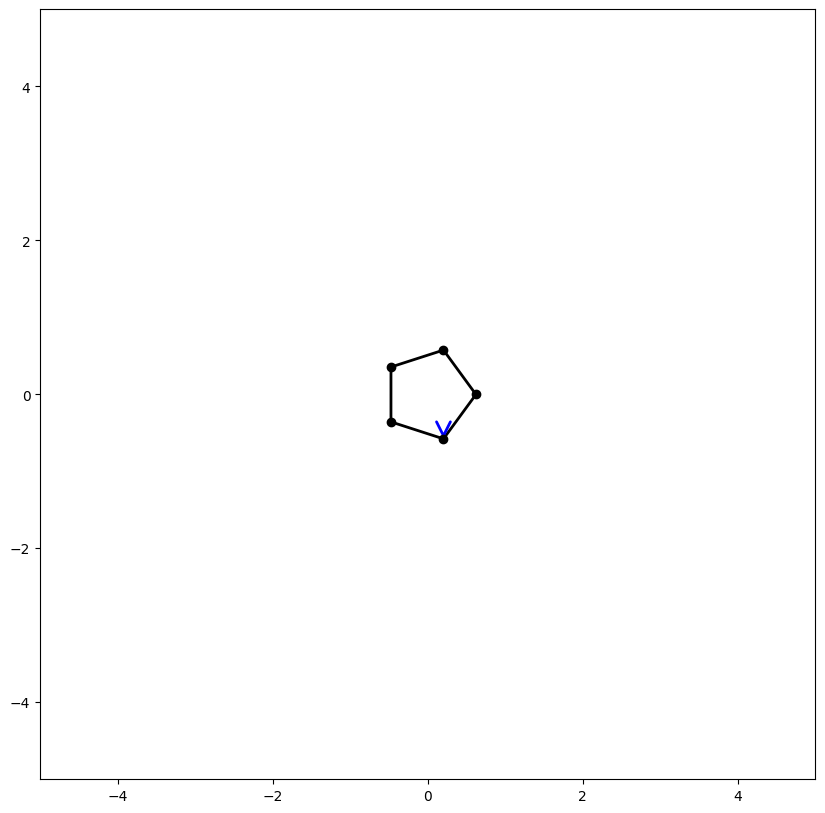

Iteration  81000 ff =  2.4580905233934452e-31 vv =  7.744521455266476e-33 power =  4.363110679023366e-32


<Figure size 640x480 with 0 Axes>

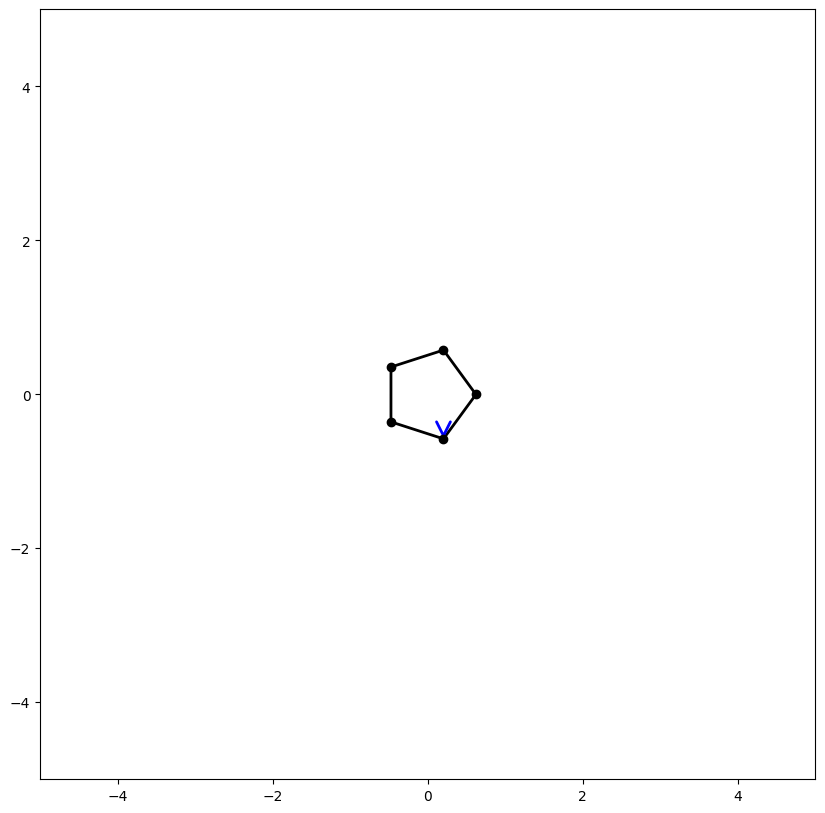

Iteration  82000 ff =  1.0150734971903775e-30 vv =  2.2839153686783496e-32 power =  1.5226102457855664e-31


<Figure size 640x480 with 0 Axes>

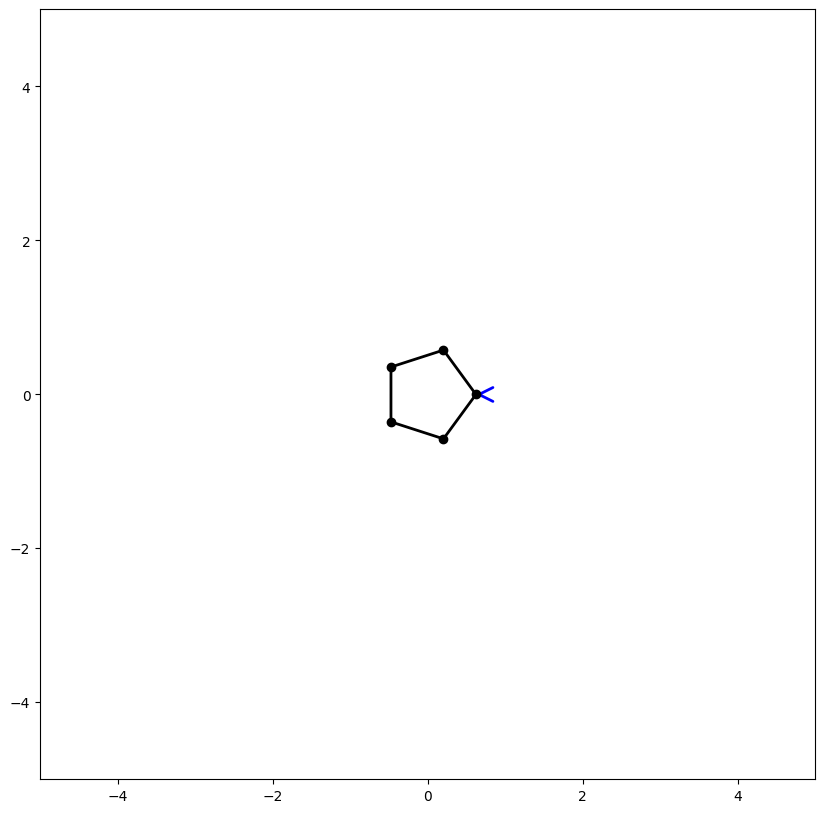

Iteration  83000 ff =  2.4580905233934452e-31 vv =  6.059494256253959e-32 power =  1.2204419448648457e-31


<Figure size 640x480 with 0 Axes>

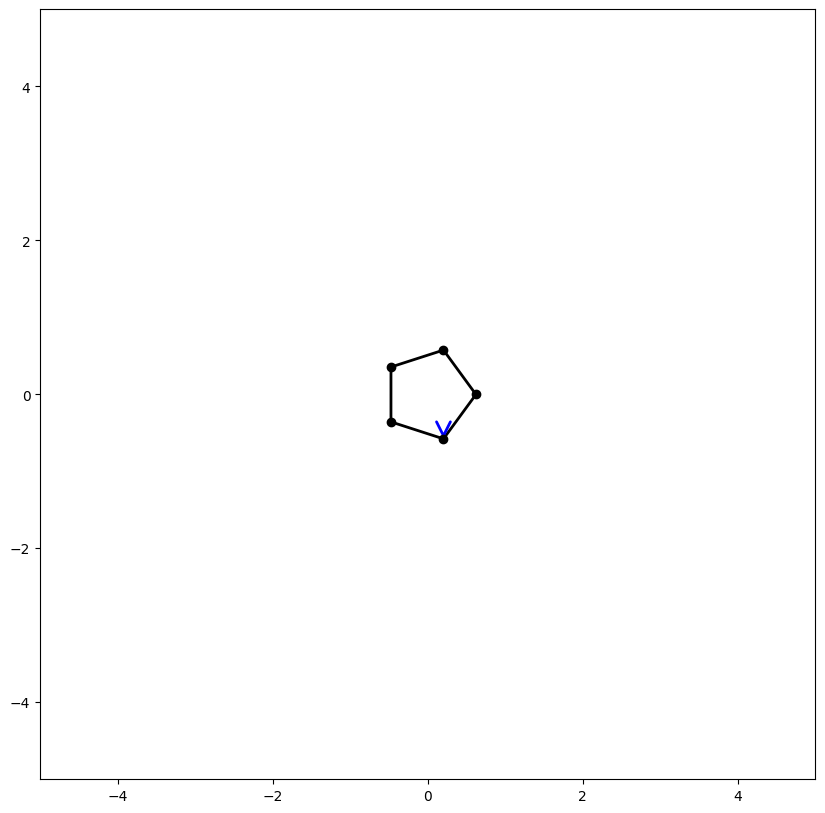

Iteration  84000 ff =  1.0150734971903775e-30 vv =  2.2066587592281258e-31 power =  4.732780180650136e-31


<Figure size 640x480 with 0 Axes>

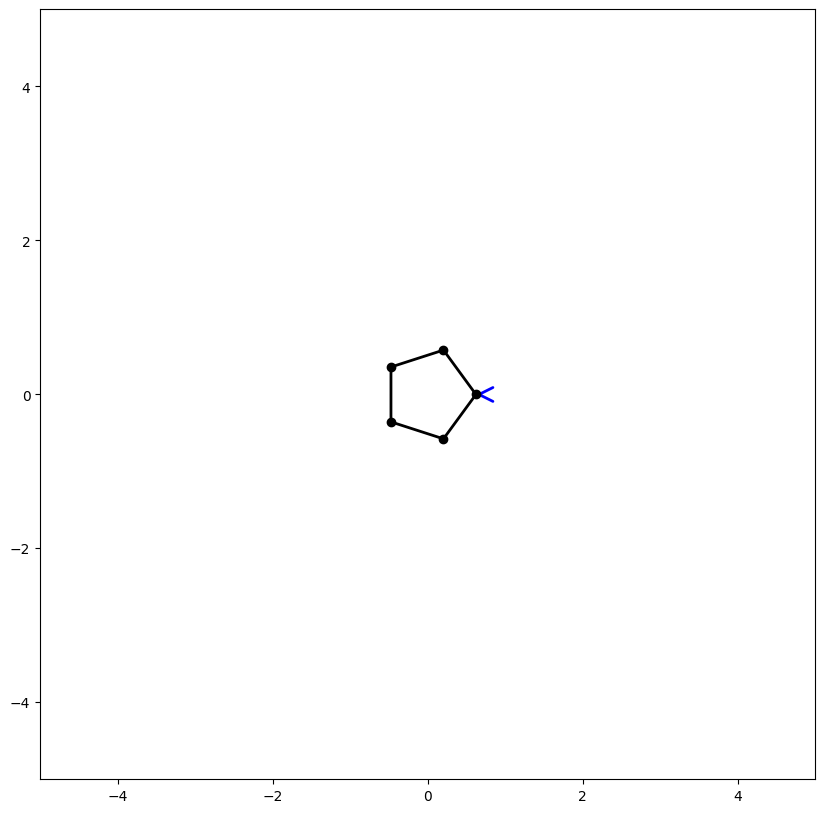

Iteration  85000 ff =  2.4580905233934452e-31 vv =  1.8999238000044595e-31 power =  2.16106100977289e-31


<Figure size 640x480 with 0 Axes>

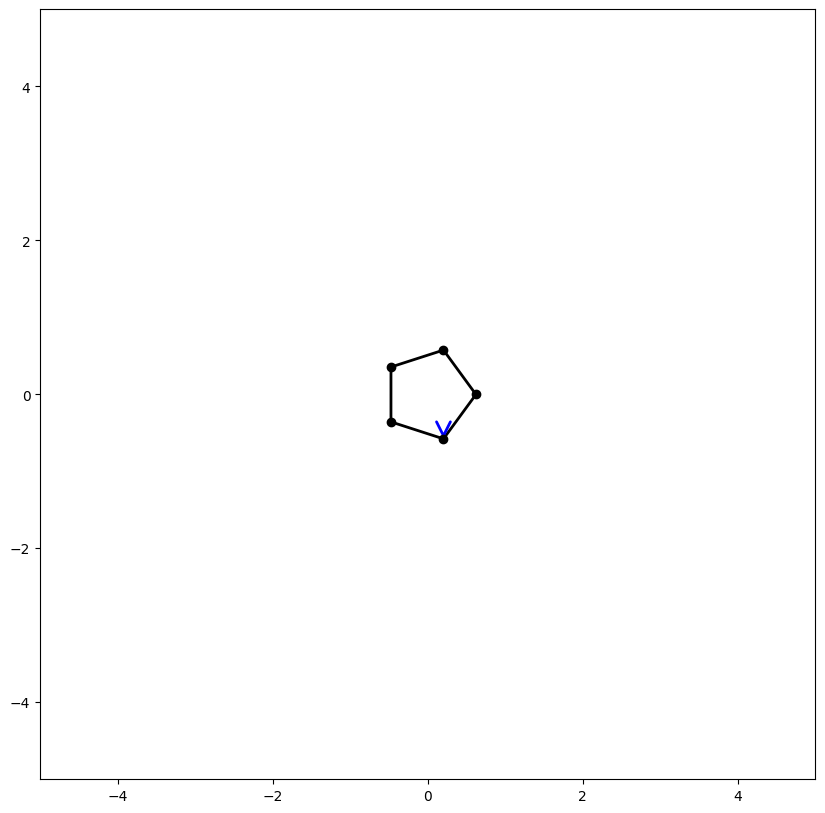

Iteration  86000 ff =  1.0150734971903775e-30 vv =  7.206081400999181e-31 power =  8.552603257927246e-31


<Figure size 640x480 with 0 Axes>

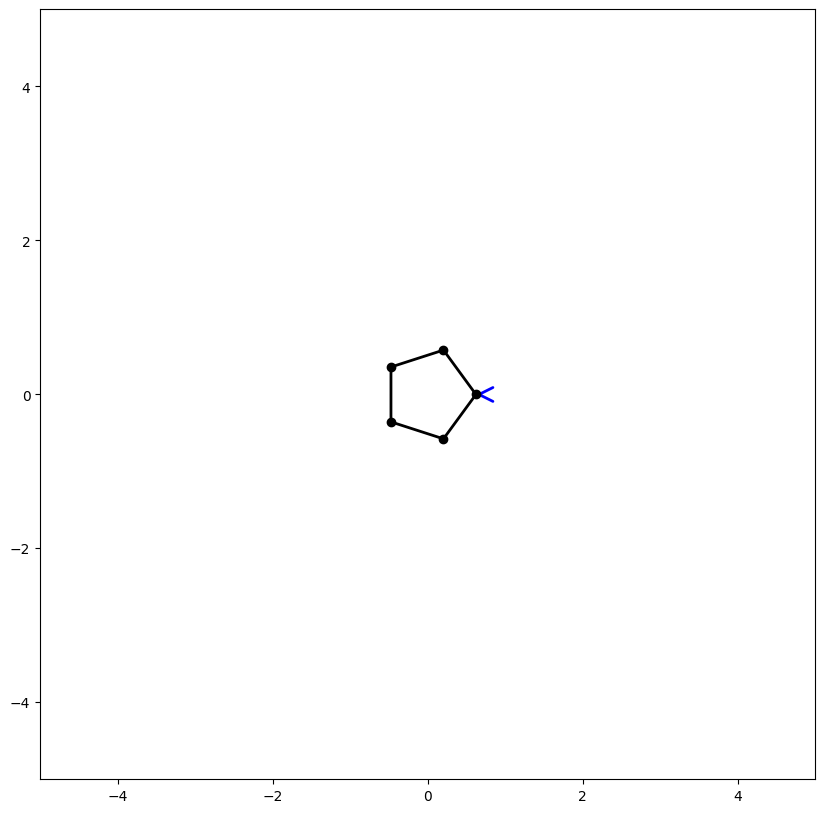

Iteration  87000 ff =  2.4580905233934452e-31 vv =  4.377573701198291e-31 power =  3.280315904051299e-31


<Figure size 640x480 with 0 Axes>

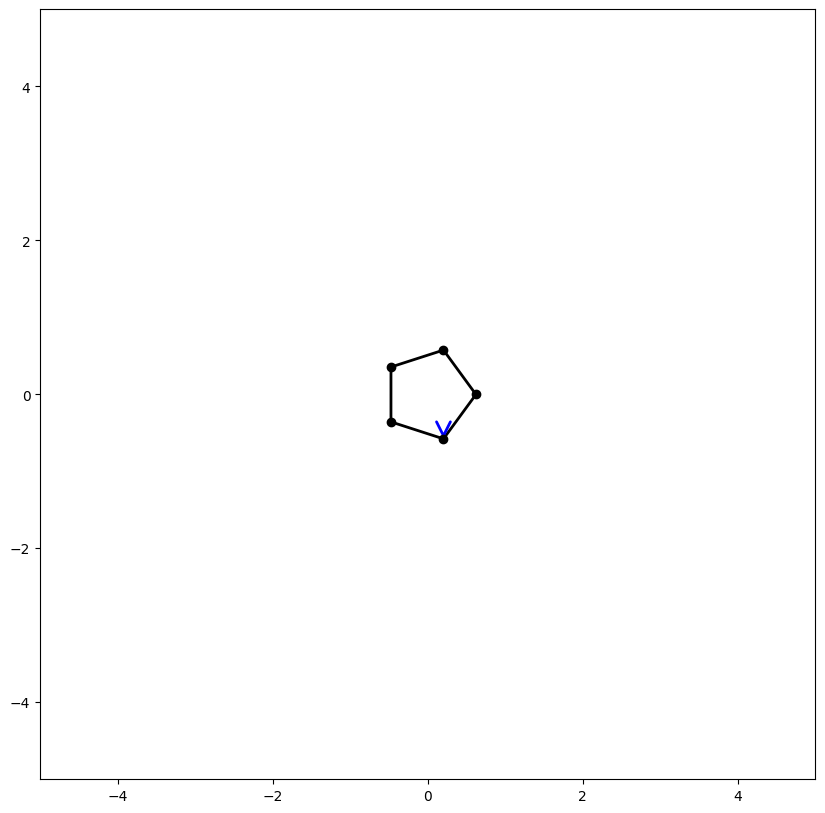

Iteration  88000 ff =  1.0150734971903775e-30 vv =  1.6897300857368543e-30 power =  1.3096565303302638e-30


<Figure size 640x480 with 0 Axes>

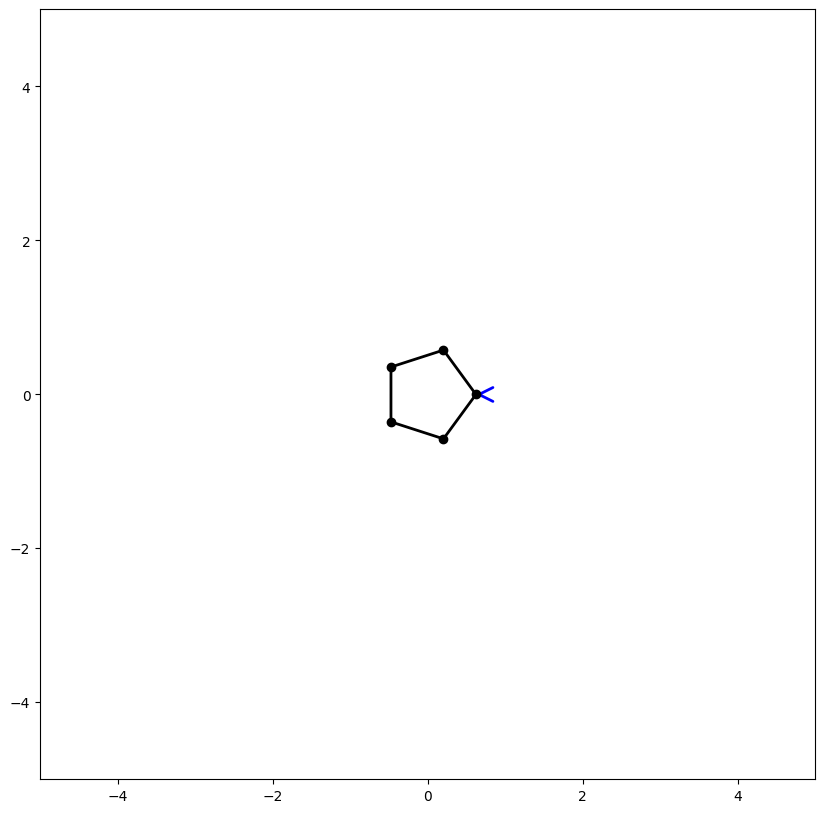

Iteration  89000 ff =  2.4580905233934452e-31 vv =  8.553305846516464e-31 power =  4.585280803288701e-31


<Figure size 640x480 with 0 Axes>

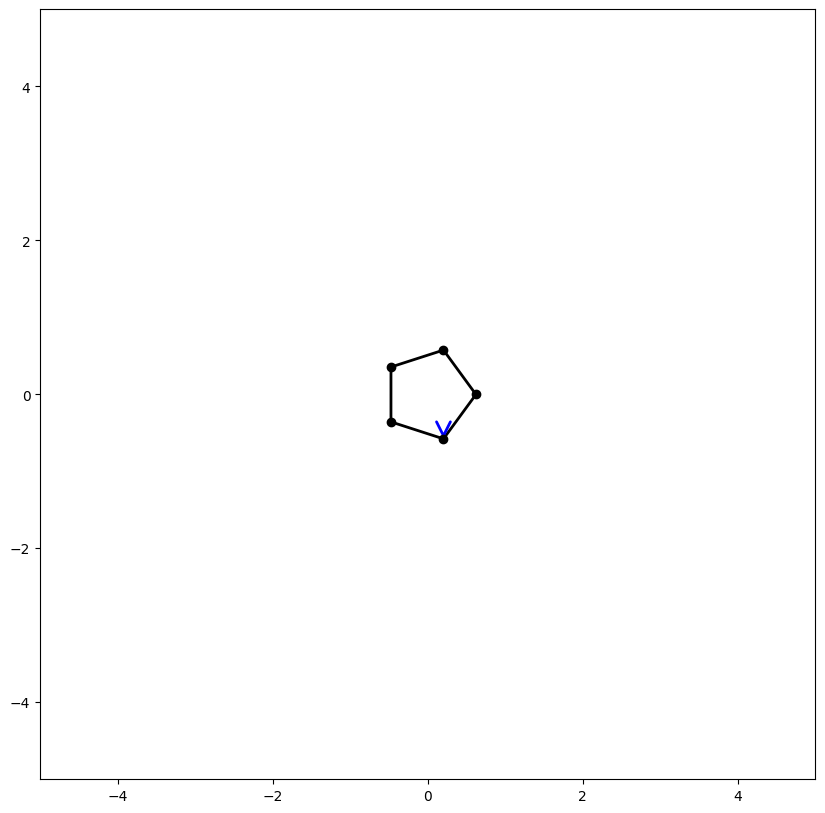

Iteration  90000 ff =  1.0150734971903775e-30 vv =  3.345292679095831e-30 power =  1.842747388790762e-30


<Figure size 640x480 with 0 Axes>

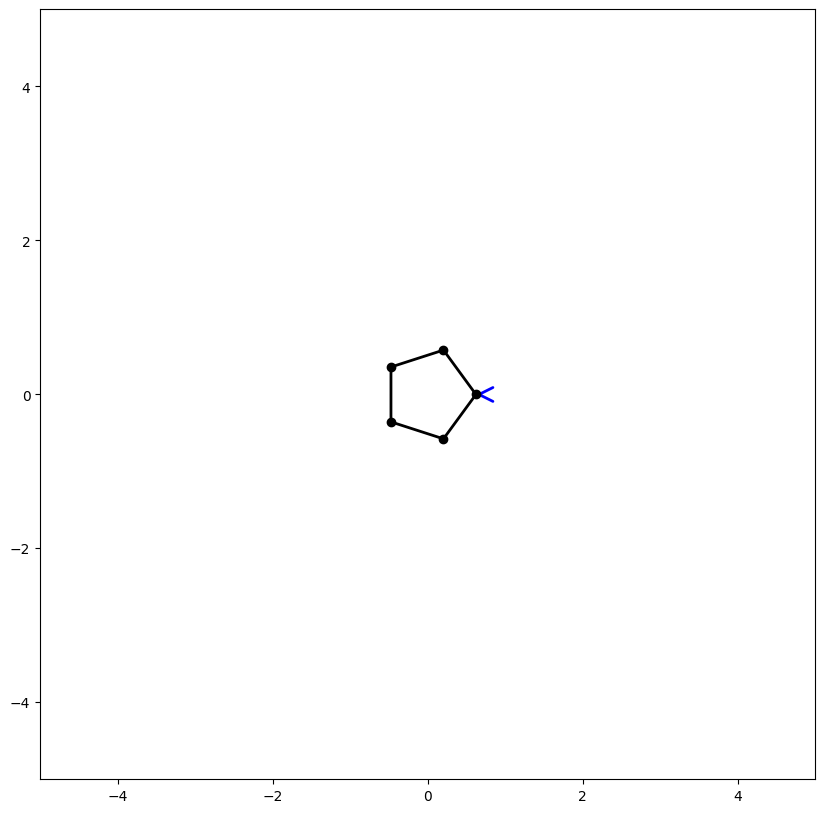

Iteration  91000 ff =  2.4580905233934452e-31 vv =  1.4340687113460547e-30 power =  5.937230591155095e-31


<Figure size 640x480 with 0 Axes>

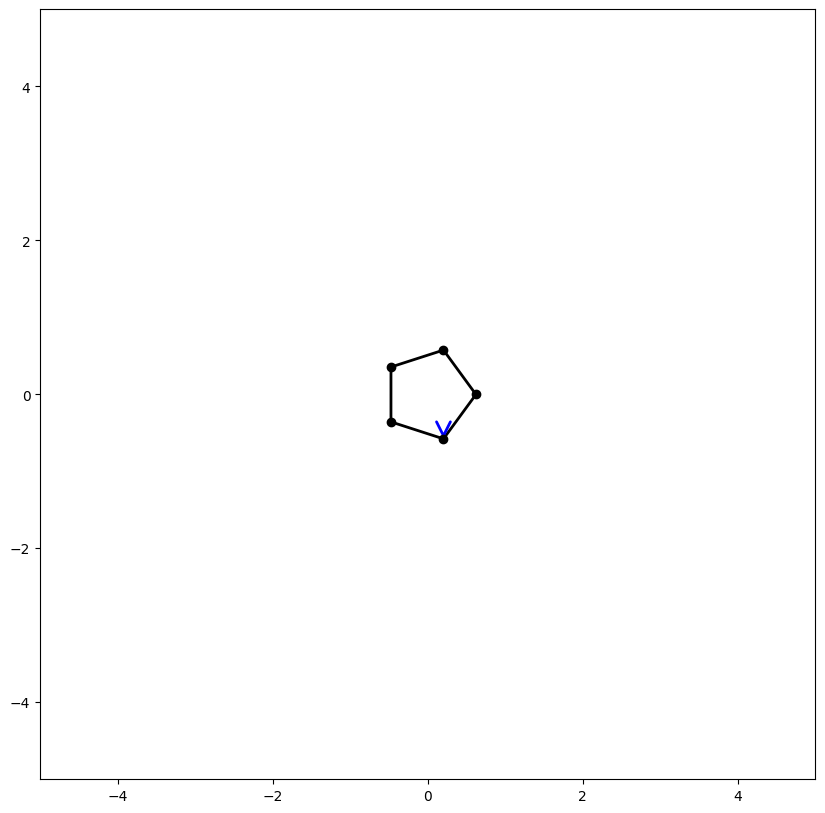

Iteration  92000 ff =  2.4580905233934452e-31 vv =  1.32875155855187e-32 power =  5.715060466889763e-32


<Figure size 640x480 with 0 Axes>

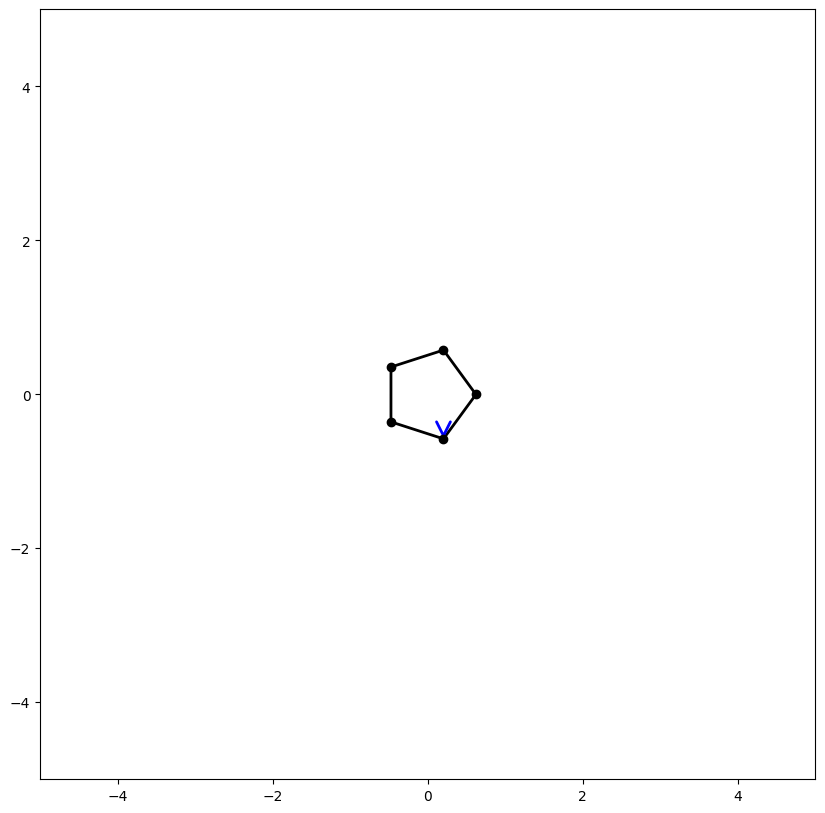

Iteration  93000 ff =  1.0150734971903775e-30 vv =  4.2658463719425627e-32 power =  2.0809006692402744e-31


<Figure size 640x480 with 0 Axes>

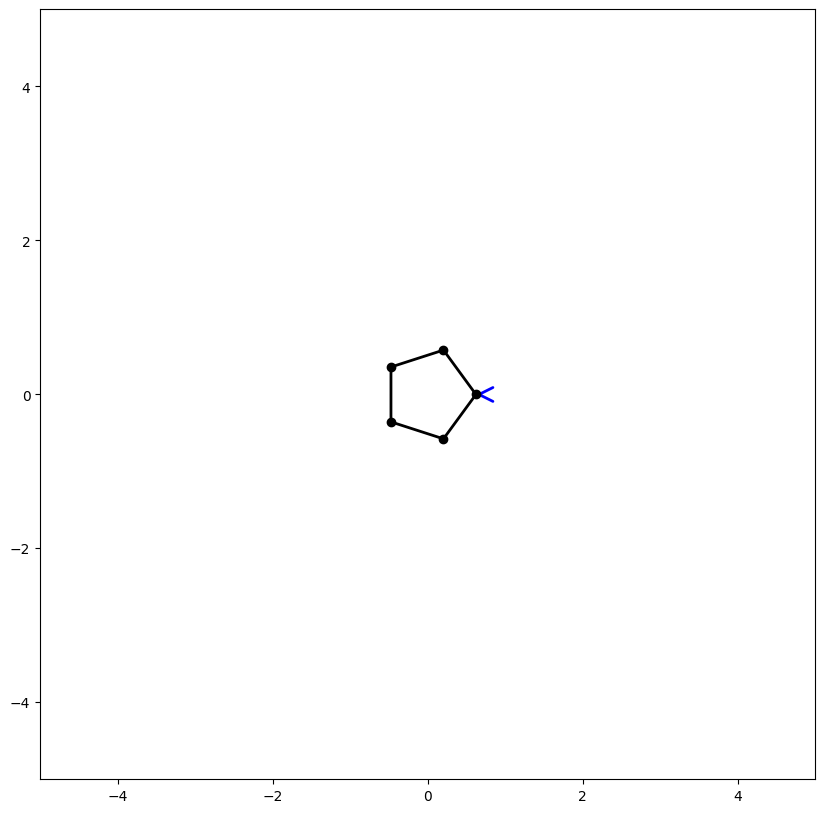

Iteration  94000 ff =  2.4580905233934452e-31 vv =  7.792768917511906e-32 power =  1.3840278691966797e-31


<Figure size 640x480 with 0 Axes>

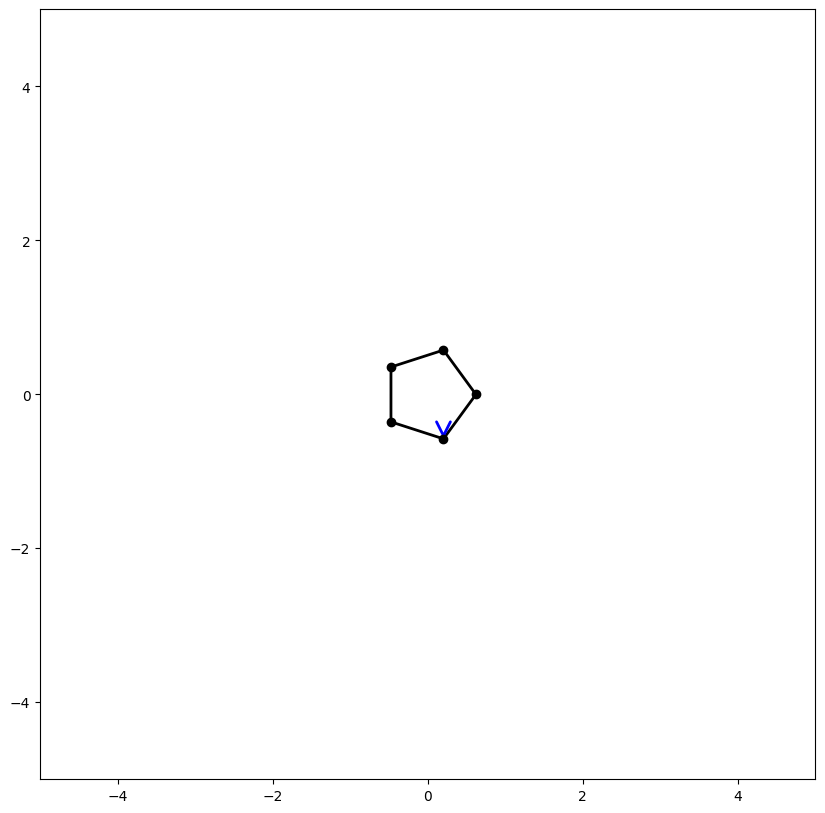

Iteration  95000 ff =  1.0150734971903775e-30 vv =  2.8489210171979305e-31 power =  5.377605619740323e-31


<Figure size 640x480 with 0 Axes>

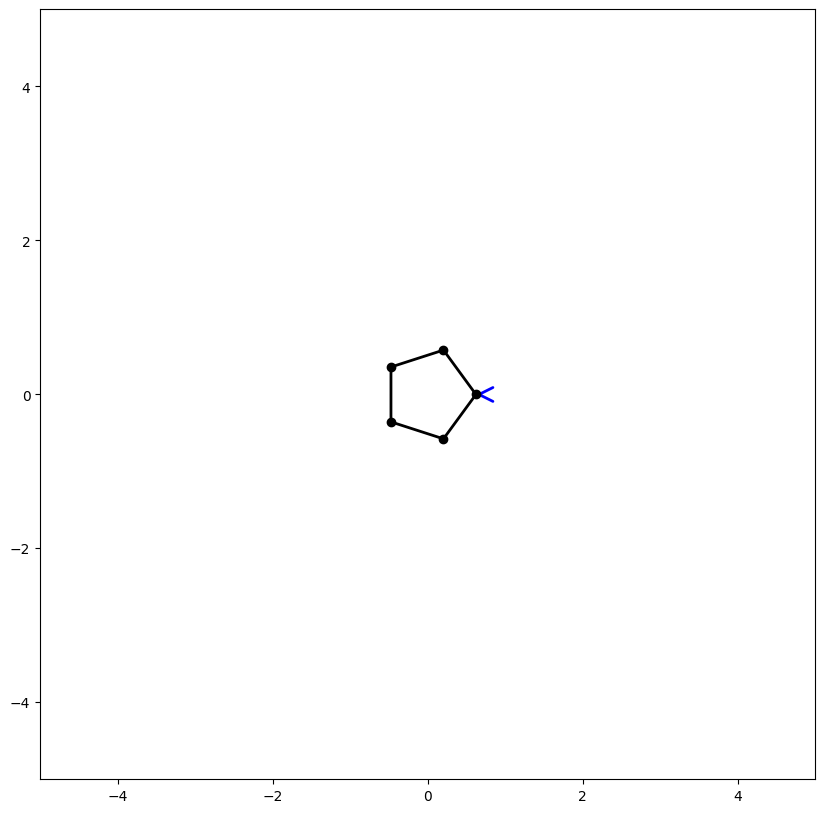

Iteration  96000 ff =  2.4580905233934452e-31 vv =  2.2466678438479865e-31 power =  2.350002752376158e-31


<Figure size 640x480 with 0 Axes>

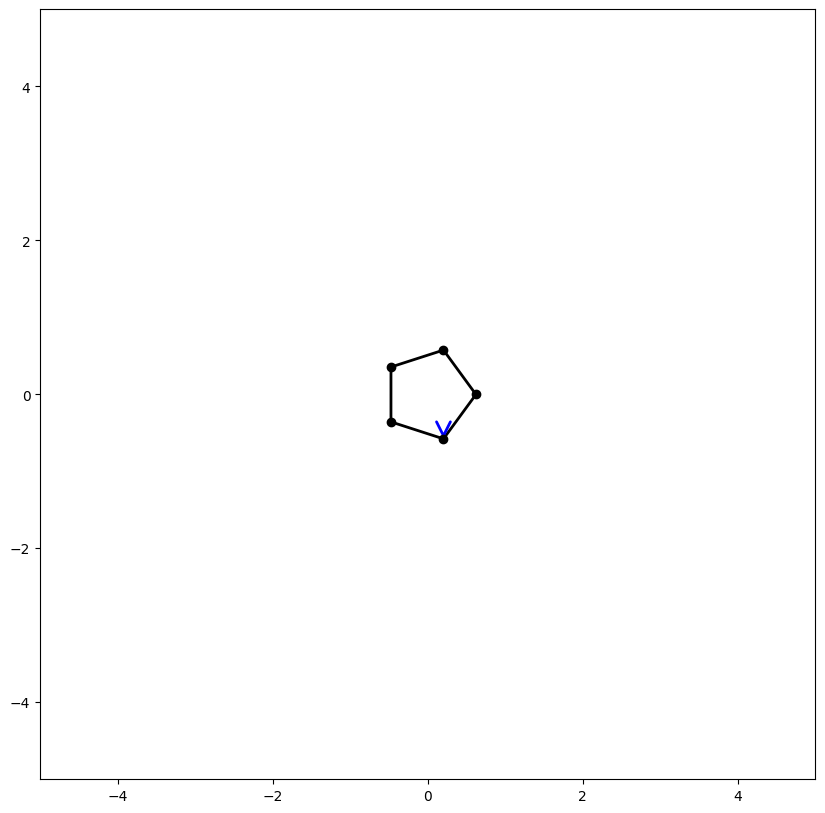

Iteration  97000 ff =  1.0150734971903775e-30 vv =  8.512665548739932e-31 power =  9.295687811545463e-31


<Figure size 640x480 with 0 Axes>

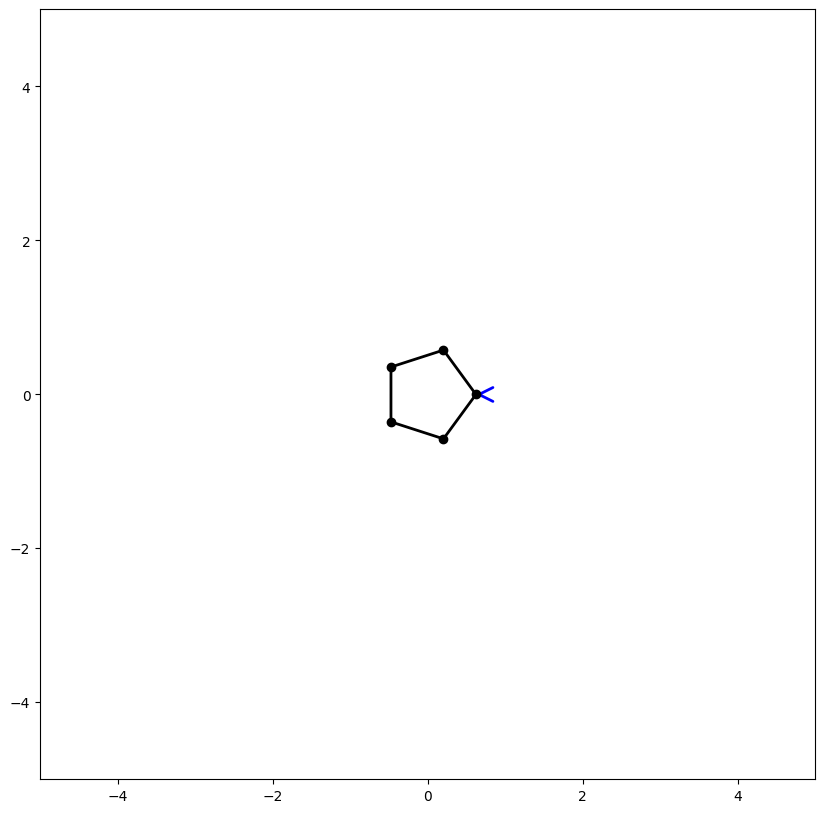

Iteration  98000 ff =  2.4580905233934452e-31 vv =  4.977988026155911e-31 power =  3.4980487693369697e-31


<Figure size 640x480 with 0 Axes>

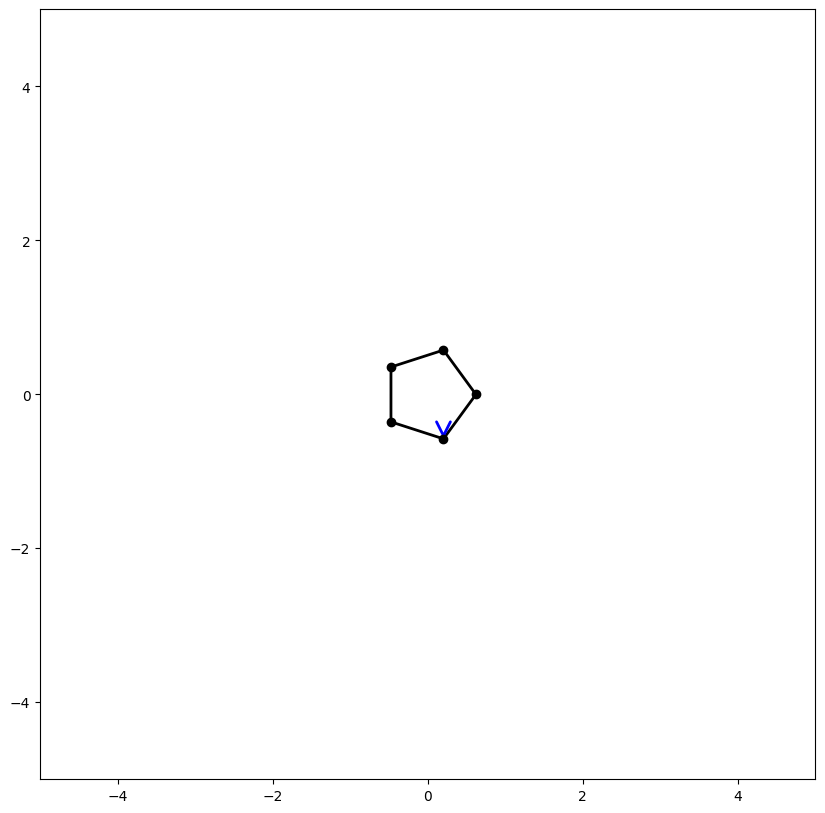

Iteration  99000 ff =  1.0150734971903775e-30 vv =  1.9297080676597955e-30 power =  1.399569761318068e-30


<Figure size 640x480 with 0 Axes>

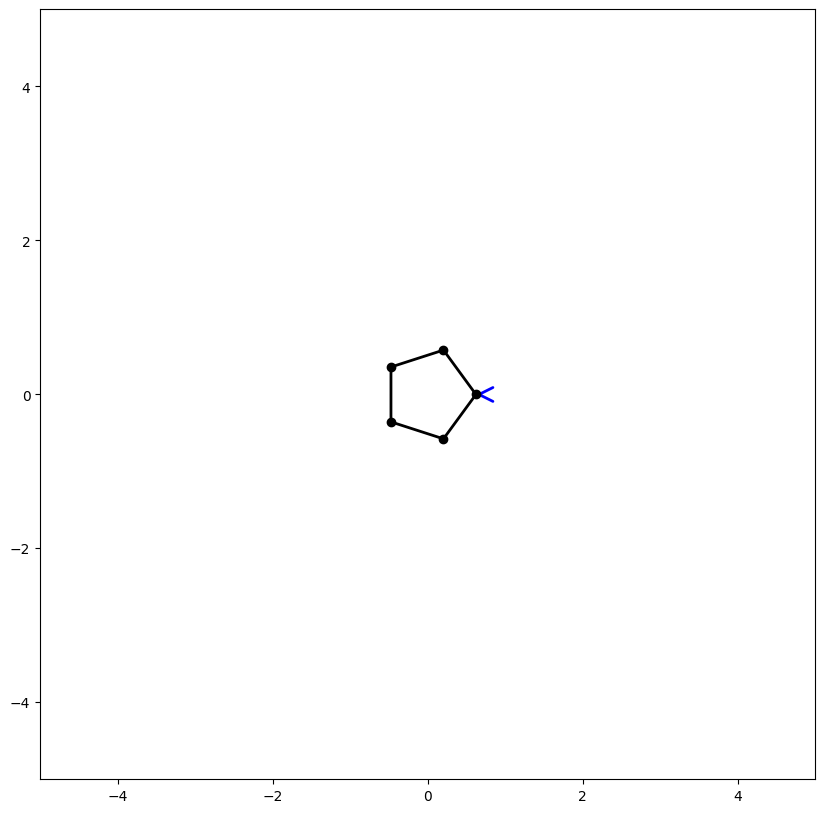

Iteration  100000 ff =  2.4580905233934452e-31 vv =  9.49494291240814e-31 power =  4.831089855628045e-31


<Figure size 640x480 with 0 Axes>

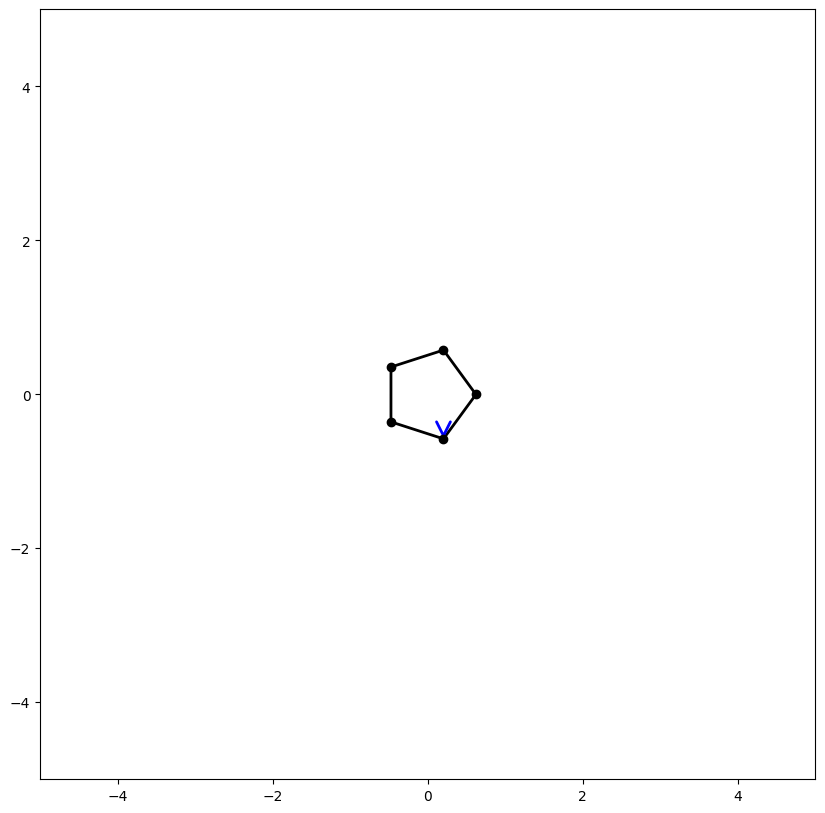

Iteration  101000 ff =  2.4580905233934452e-31 vv =  3.45447961367144e-30 power =  -7.70109654155944e-31


<Figure size 640x480 with 0 Axes>

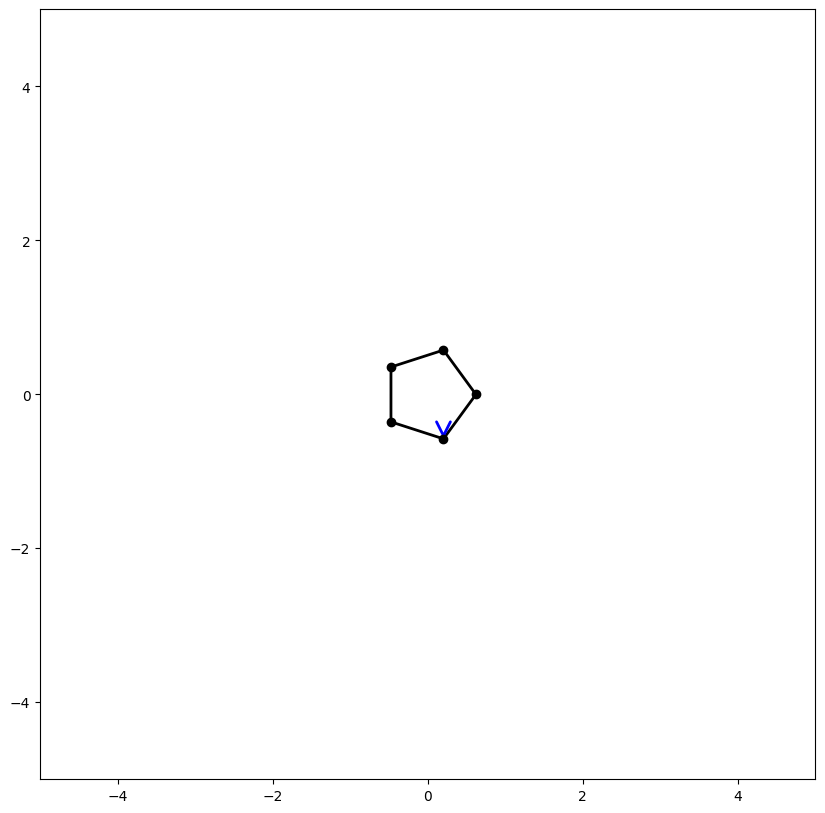

Iteration  102000 ff =  2.4580905233934452e-31 vv =  1.5552714136925495e-30 power =  6.183039643494438e-31


<Figure size 640x480 with 0 Axes>

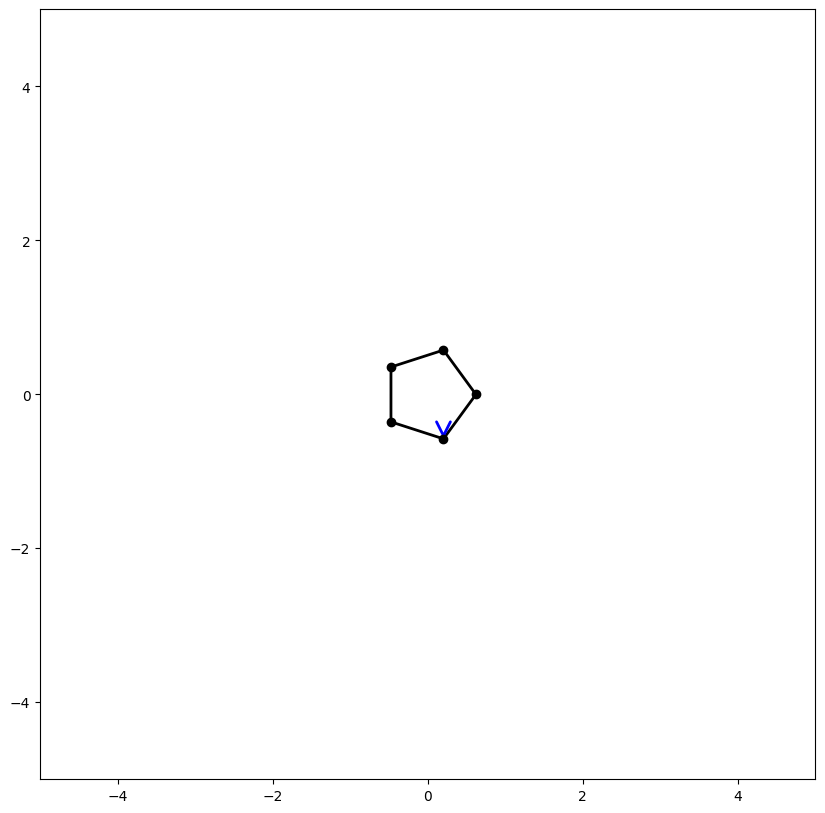

Iteration  103000 ff =  2.4580905233934452e-31 vv =  2.031765448242396e-32 power =  7.067010254756157e-32


<Figure size 640x480 with 0 Axes>

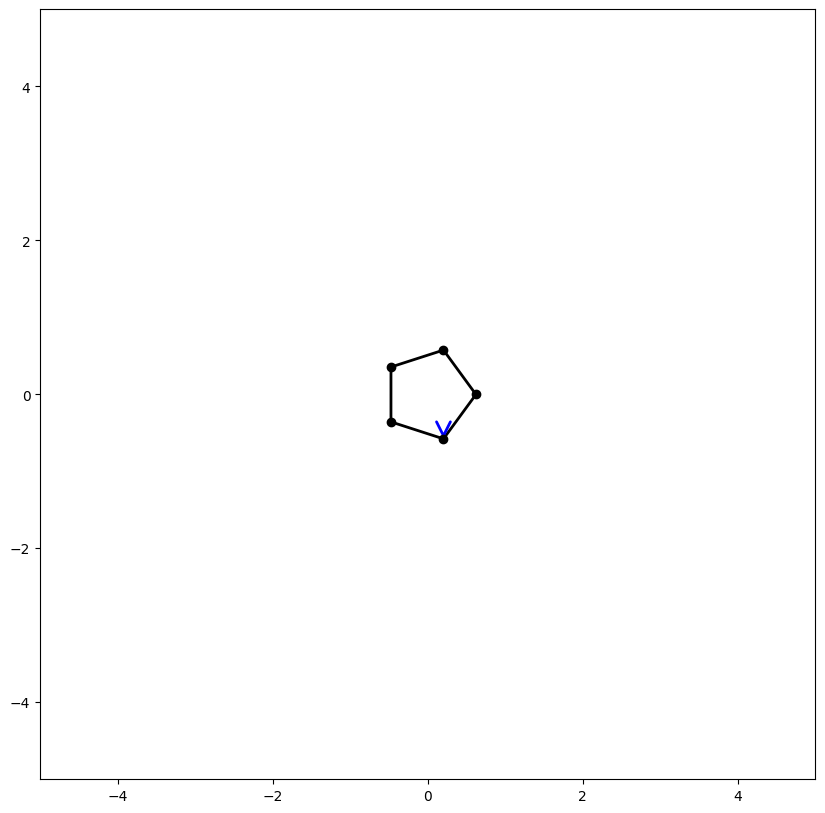

Iteration  104000 ff =  1.0150734971903775e-30 vv =  6.861896841006954e-32 power =  2.639191092694982e-31


<Figure size 640x480 with 0 Axes>

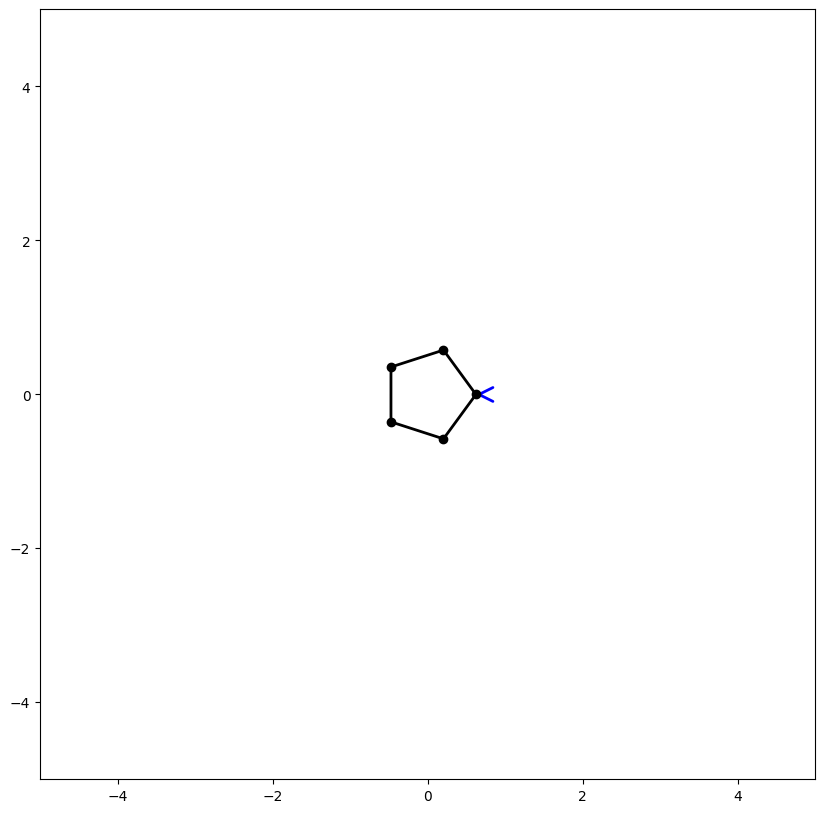

Iteration  105000 ff =  2.4580905233934452e-31 vv =  9.743776444055526e-32 power =  1.5476137935285135e-31


<Figure size 640x480 with 0 Axes>

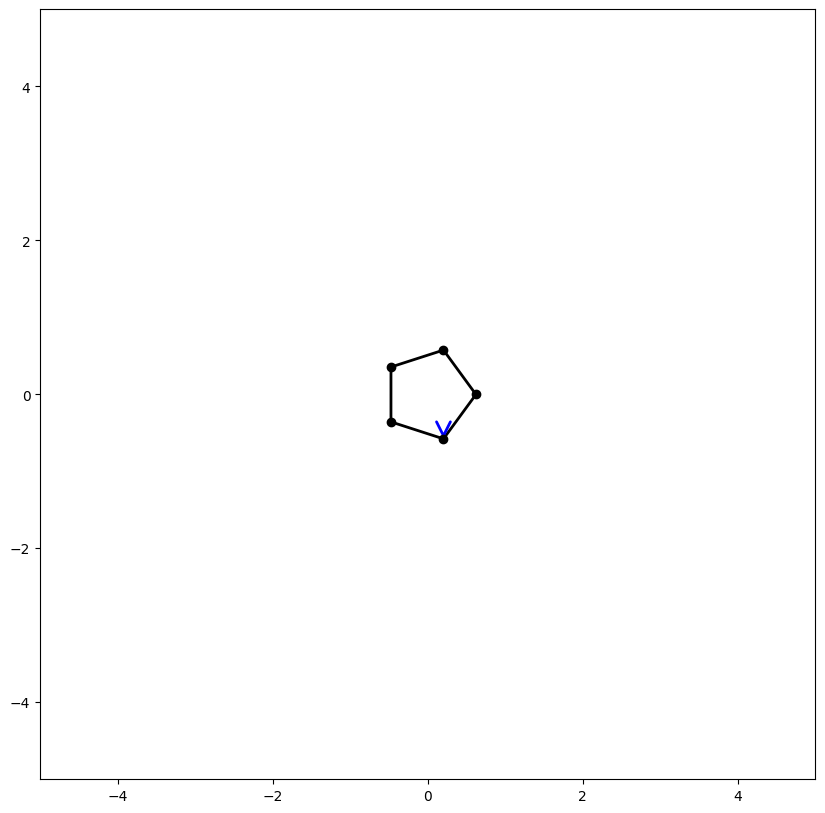

Iteration  106000 ff =  1.0150734971903775e-30 vv =  3.6096369406792697e-31 power =  6.05313703212052e-31


<Figure size 640x480 with 0 Axes>

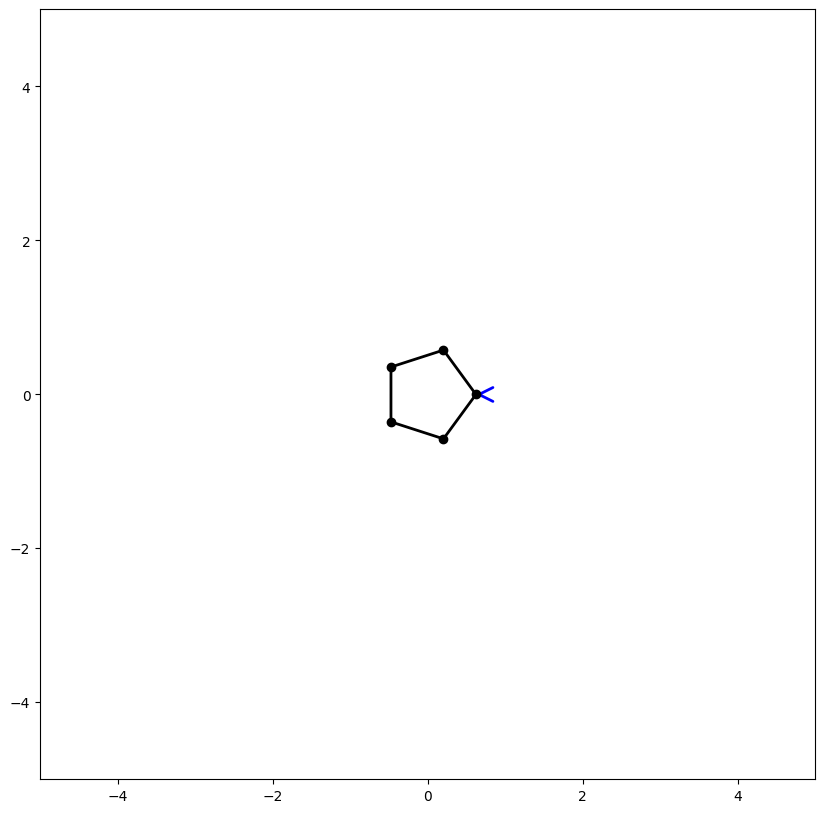

Iteration  107000 ff =  2.4580905233934452e-31 vv =  2.6410772715241566e-31 power =  2.5479417208176774e-31


<Figure size 640x480 with 0 Axes>

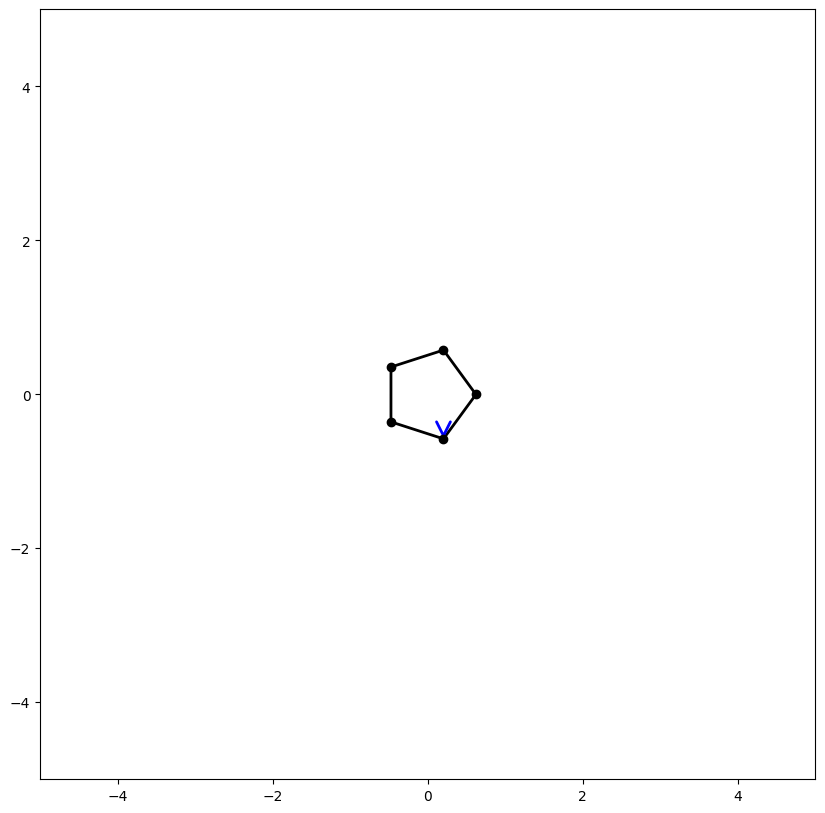

Iteration  108000 ff =  1.0150734971903775e-30 vv =  1.0075566347221761e-30 power =  1.01130808205255e-30


<Figure size 640x480 with 0 Axes>

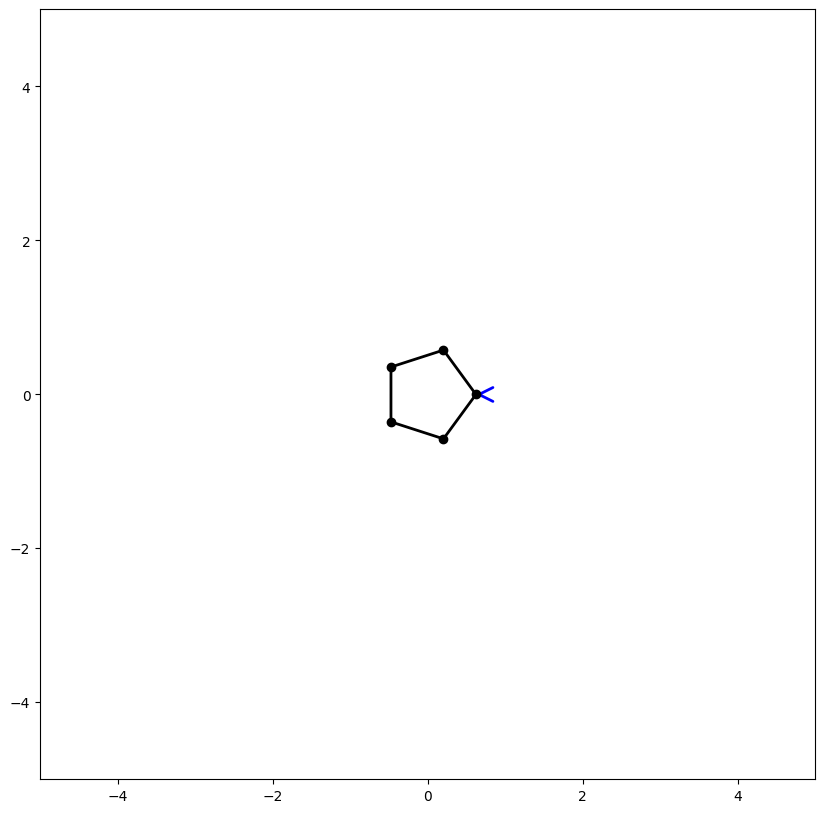

Iteration  109000 ff =  2.4580905233934452e-31 vv =  5.682995258179783e-31 power =  3.737554921151207e-31


<Figure size 640x480 with 0 Axes>

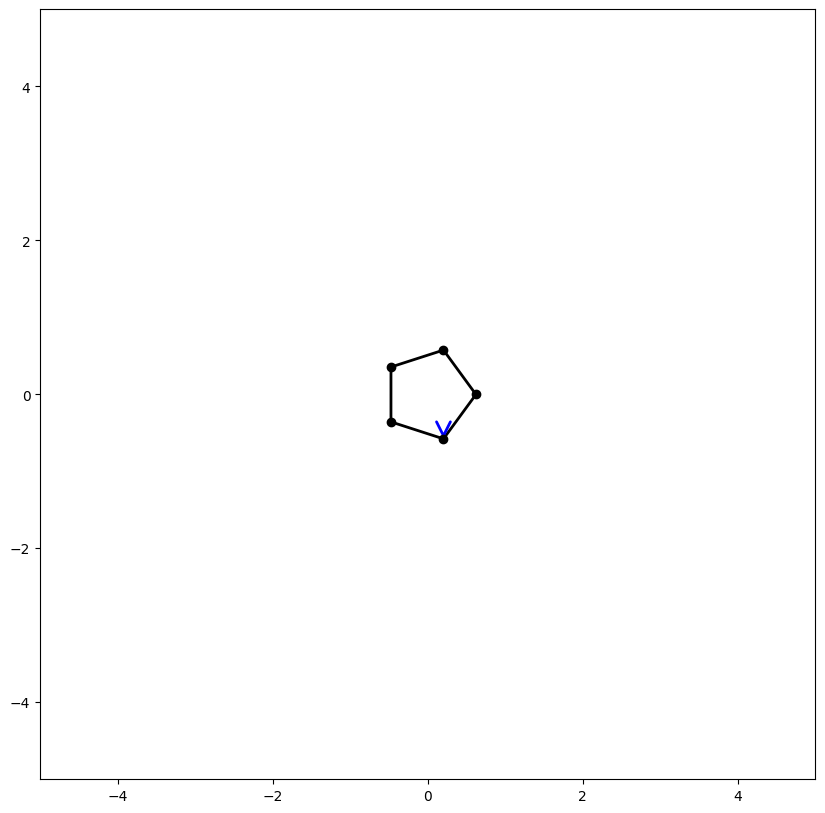

Iteration  110000 ff =  1.0150734971903775e-30 vv =  2.1988281876662723e-30 power =  1.4939786538552626e-30


<Figure size 640x480 with 0 Axes>

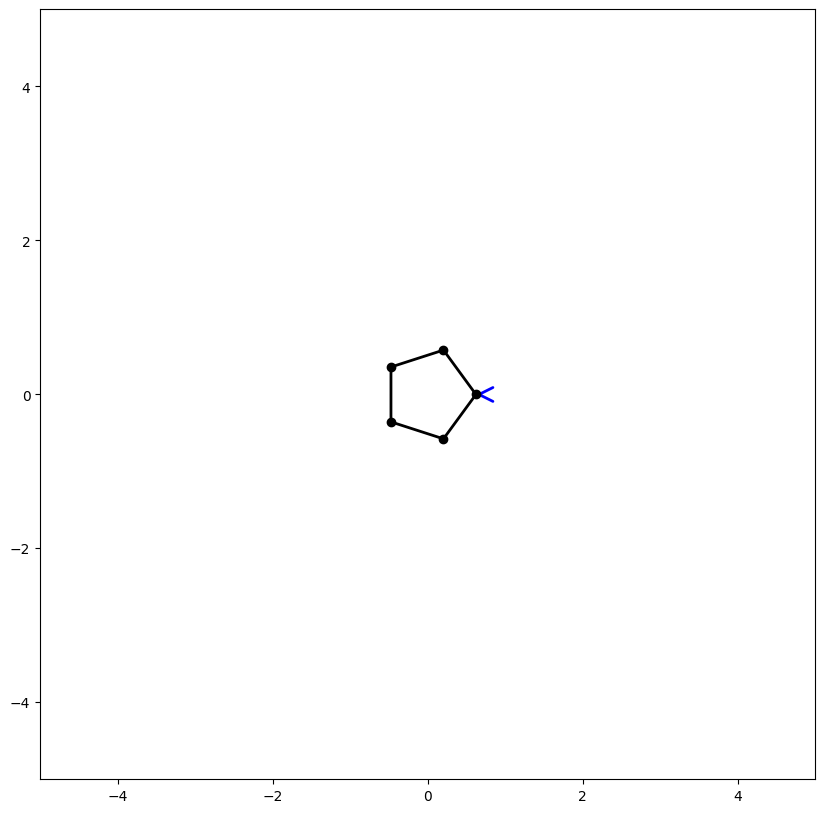

Iteration  111000 ff =  2.4580905233934452e-31 vv =  1.0485741788767681e-30 power =  5.076898907967389e-31


<Figure size 640x480 with 0 Axes>

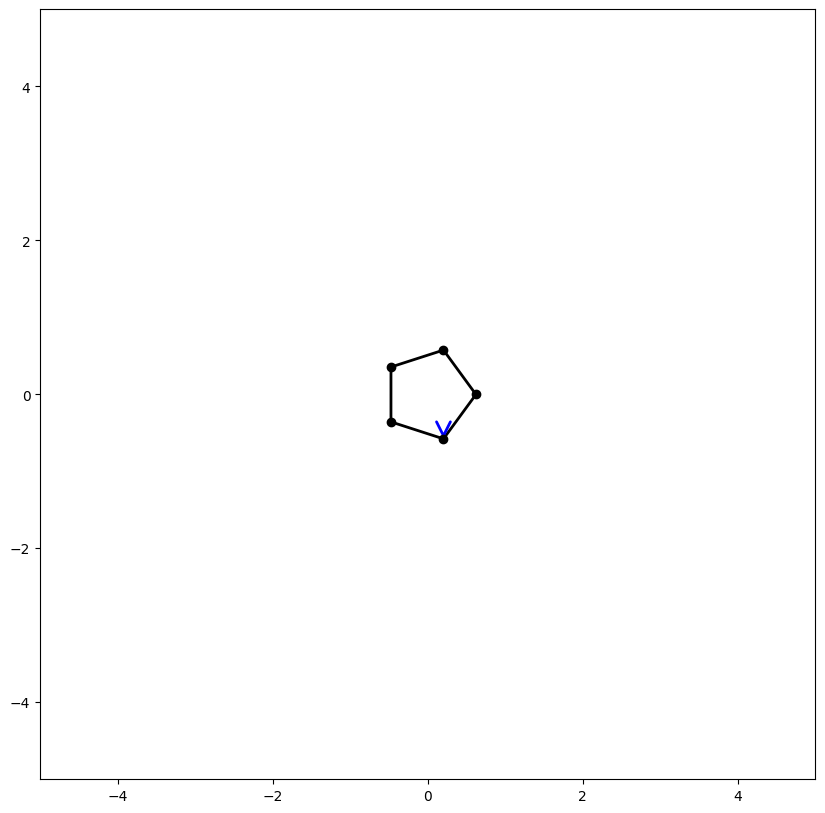

Iteration  112000 ff =  2.4580905233934452e-31 vv =  6.145226308483614e-34 power =  1.2290452616967228e-32


<Figure size 640x480 with 0 Axes>

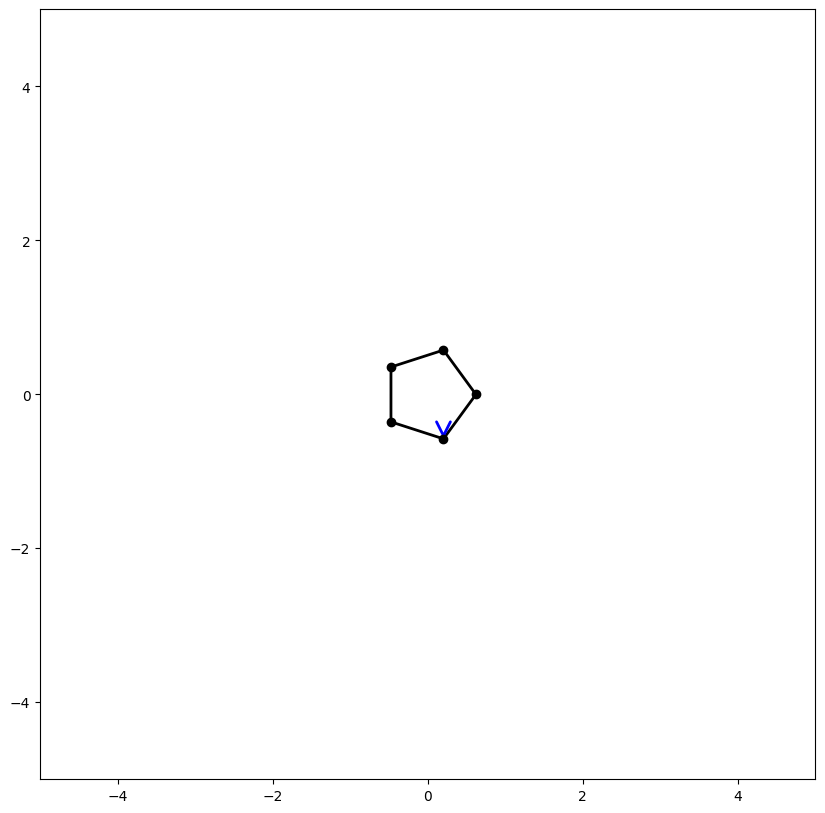

Iteration  113000 ff =  1.0150734971903775e-30 vv =  6.344209357439859e-34 power =  2.5376837429759443e-32


<Figure size 640x480 with 0 Axes>

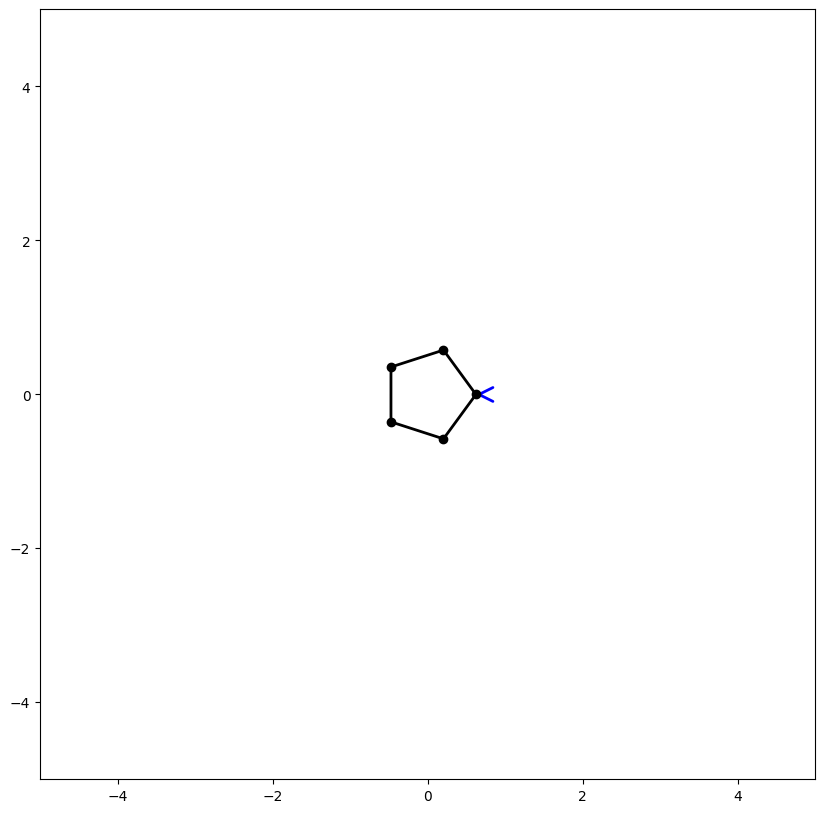

Iteration  114000 ff =  2.4580905233934452e-31 vv =  2.92998398792848e-32 power =  8.486557532015873e-32


<Figure size 640x480 with 0 Axes>

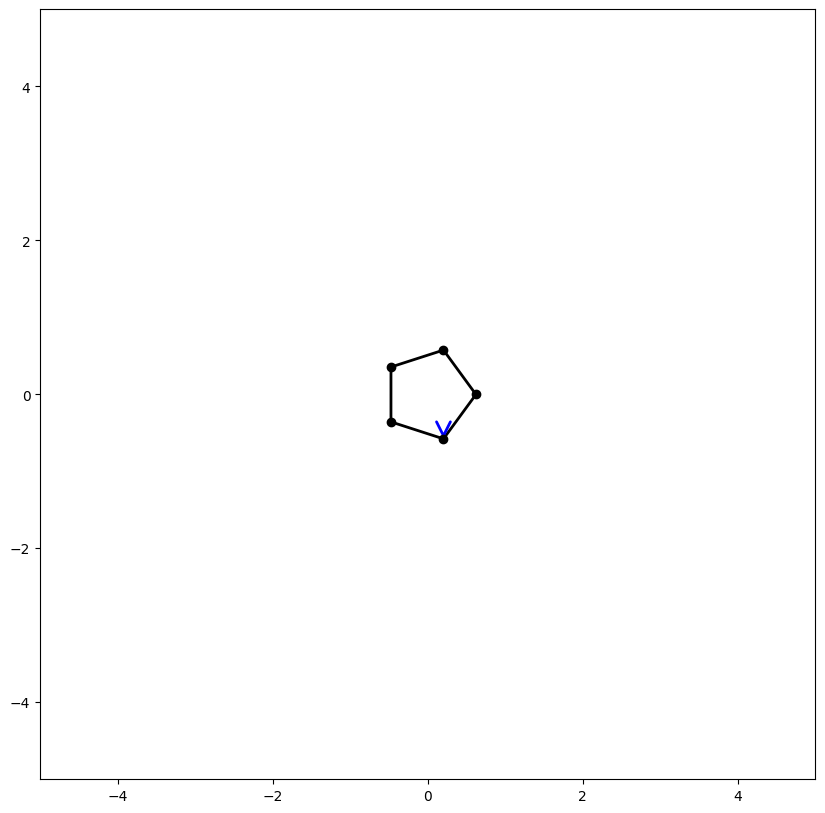

Iteration  115000 ff =  1.0150734971903775e-30 vv =  1.0072066775871525e-31 power =  3.19748151614969e-31


<Figure size 640x480 with 0 Axes>

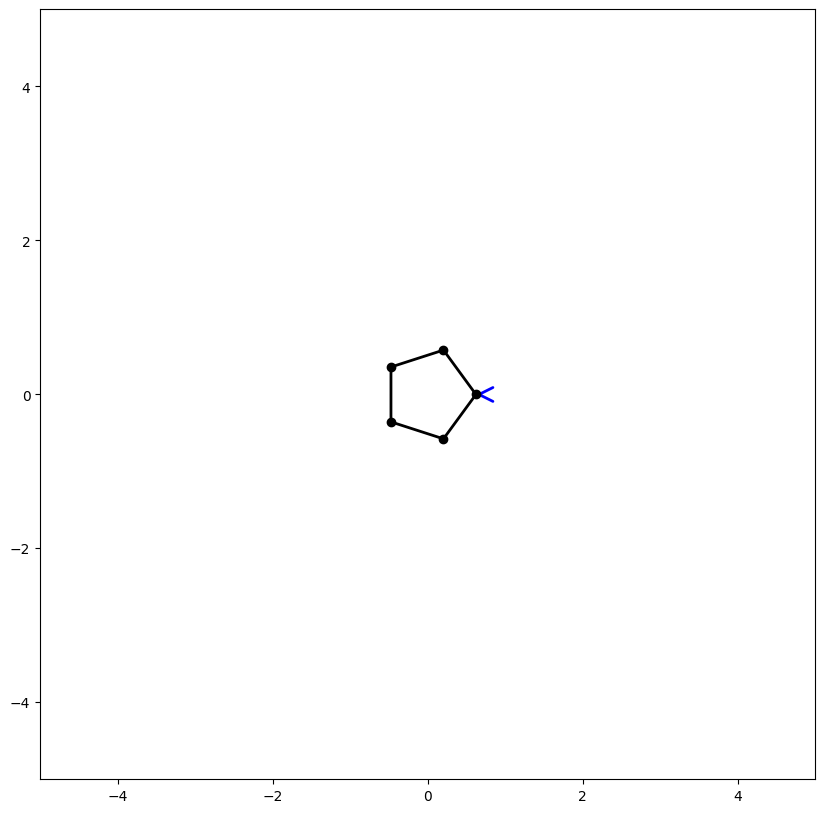

Iteration  116000 ff =  2.4580905233934452e-31 vv =  1.1912516835884814e-31 power =  1.7111997178603474e-31


<Figure size 640x480 with 0 Axes>

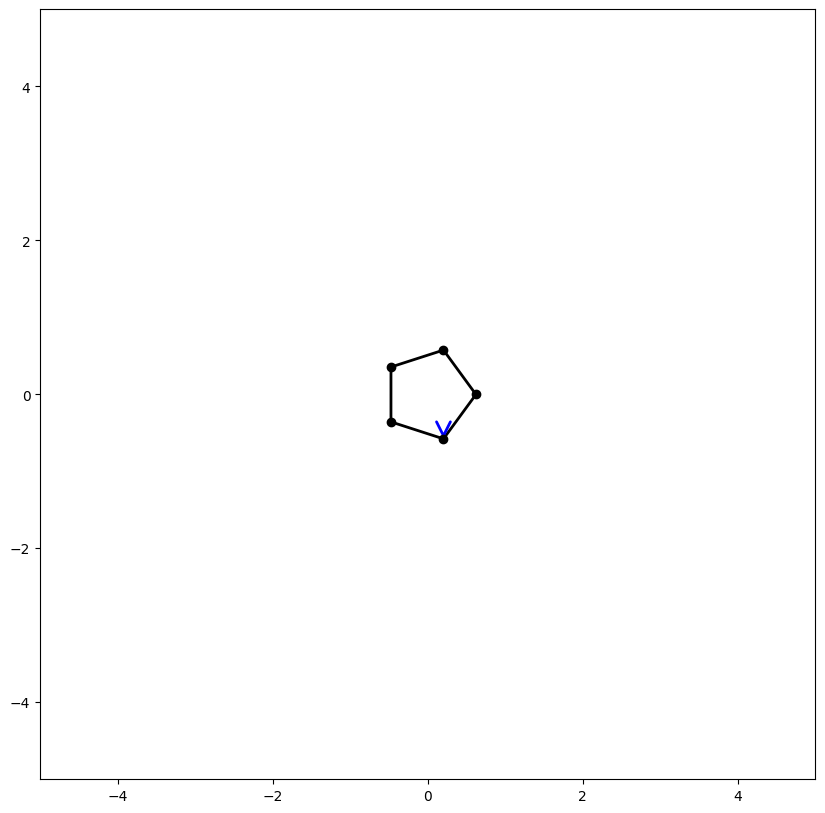

Iteration  117000 ff =  1.0150734971903775e-30 vv =  4.460266095148413e-31 power =  6.728668444500716e-31


<Figure size 640x480 with 0 Axes>

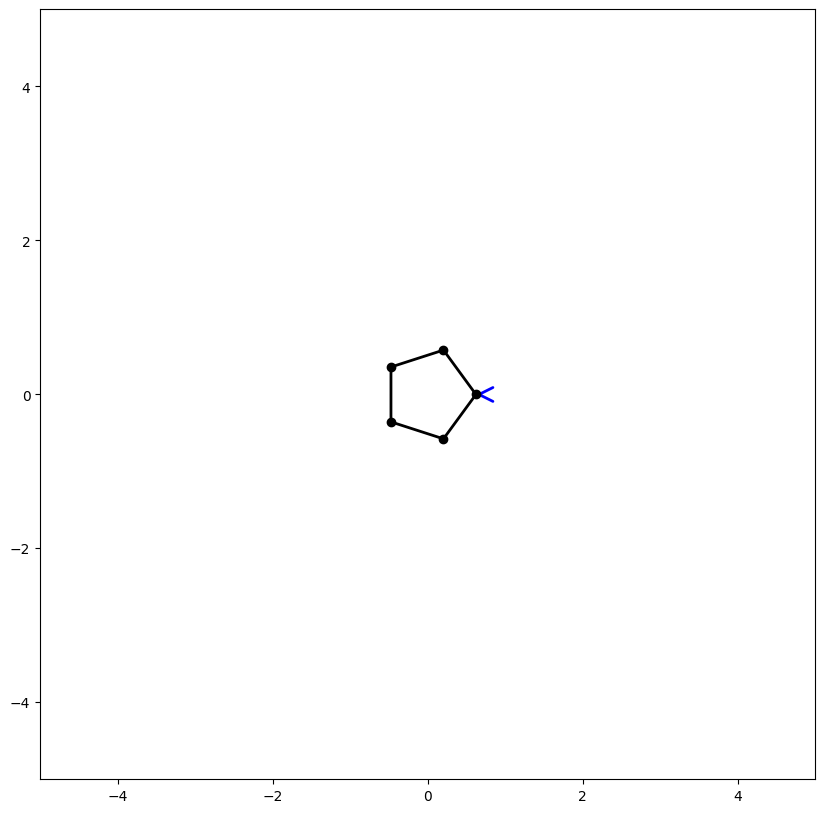

Iteration  118000 ff =  2.4580905233934452e-31 vv =  3.067364968006802e-31 power =  2.7458806892591963e-31


<Figure size 640x480 with 0 Axes>

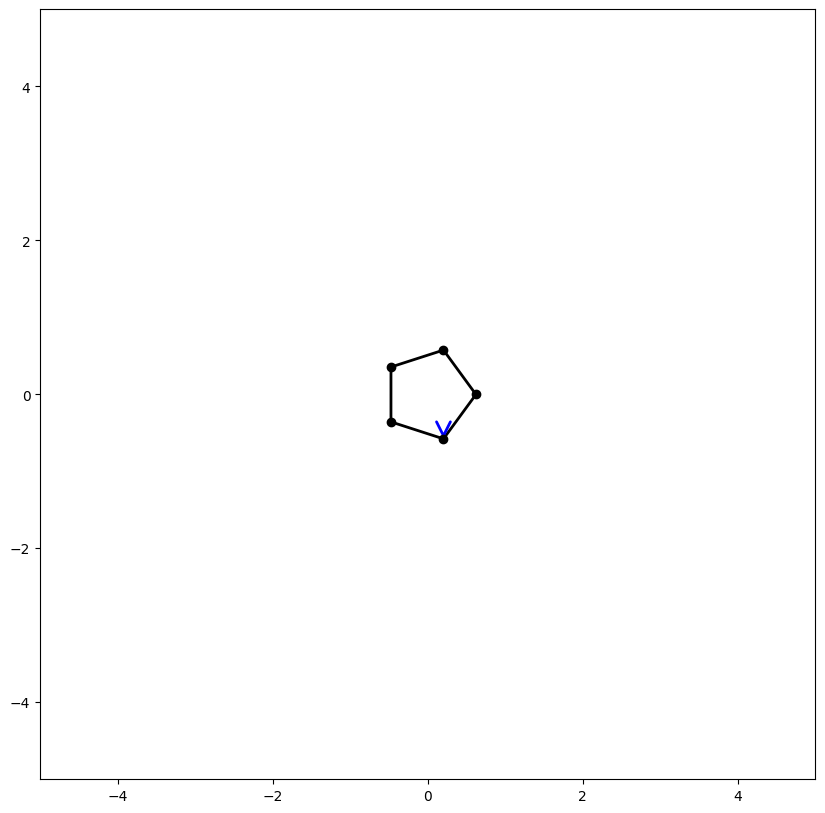

Iteration  119000 ff =  1.0150734971903775e-30 vv =  1.1770109107192834e-30 power =  1.0930473829505537e-30


<Figure size 640x480 with 0 Axes>

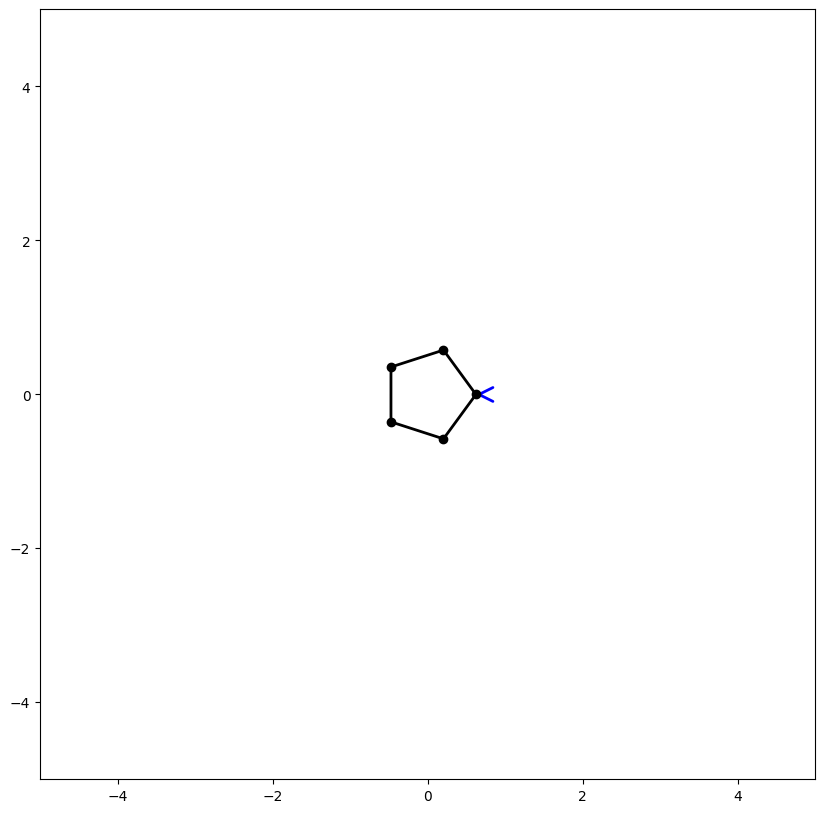

Iteration  120000 ff =  2.4580905233934452e-31 vv =  6.434675463563216e-31 power =  3.9770610729654455e-31


<Figure size 640x480 with 0 Axes>

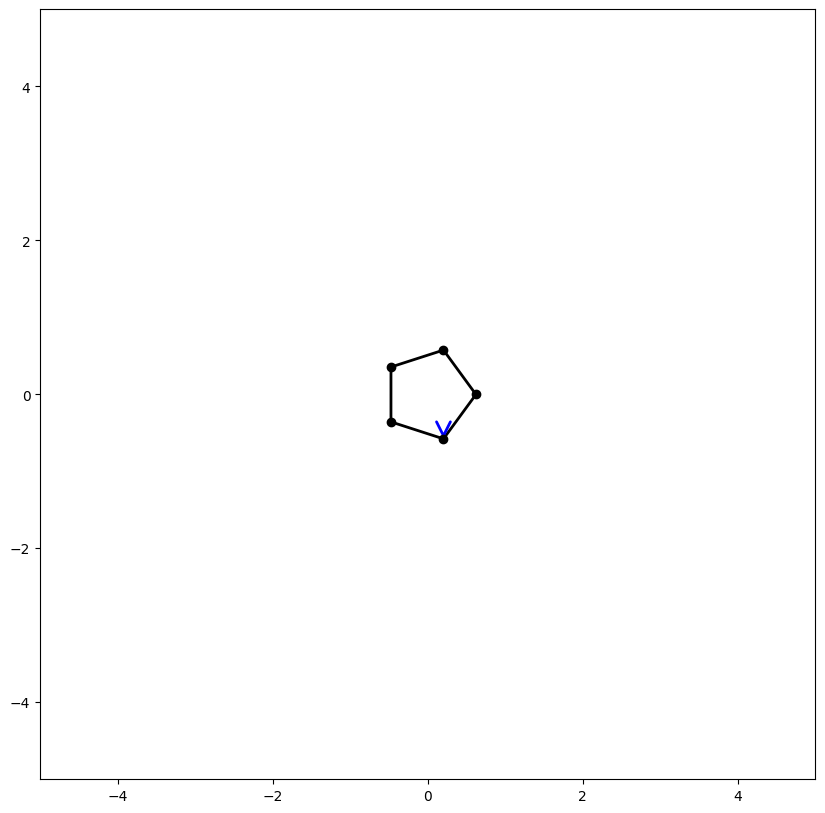

Iteration  121000 ff =  1.0150734971903775e-30 vv =  2.4995992124373663e-30 power =  1.5928832079418475e-30


<Figure size 640x480 with 0 Axes>

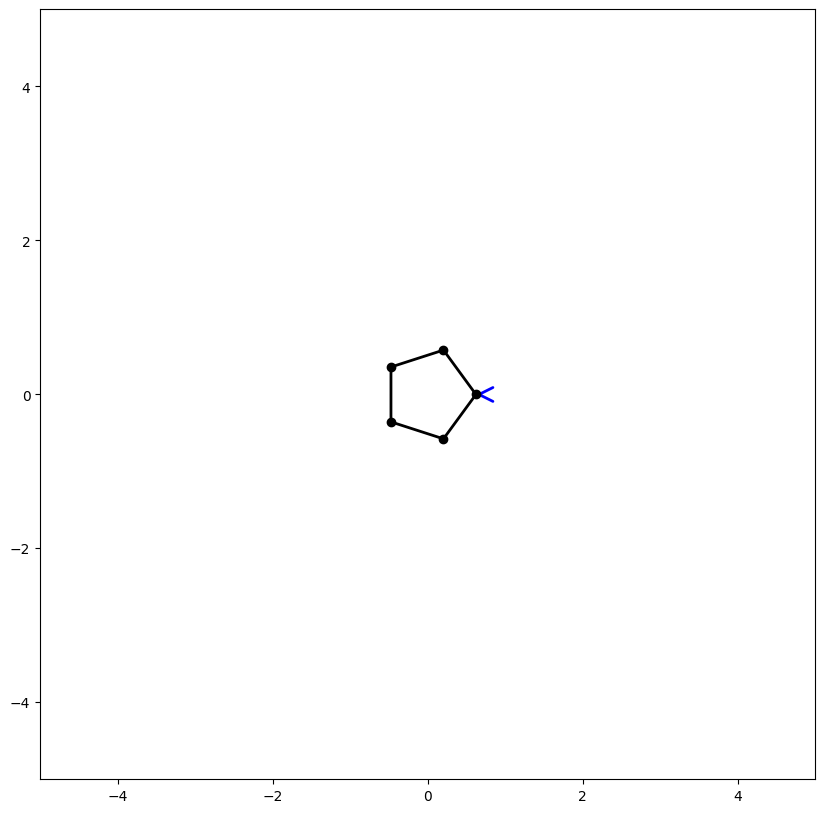

Iteration  122000 ff =  2.4580905233934452e-31 vv =  1.1525702475595094e-30 power =  5.3227079603067335e-31


<Figure size 640x480 with 0 Axes>

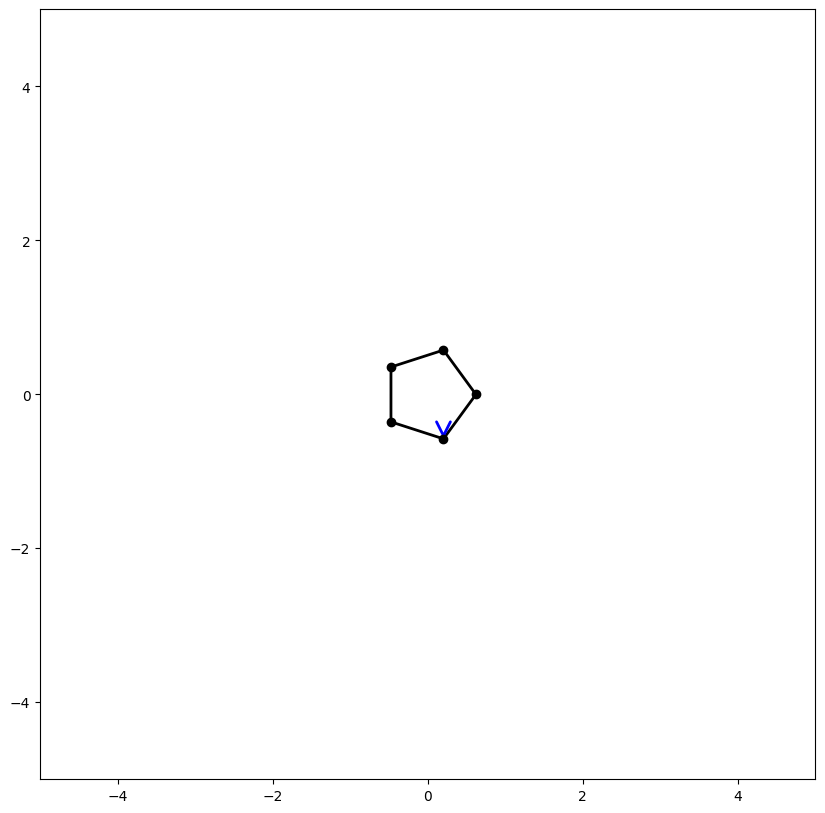

Iteration  123000 ff =  2.4580905233934452e-31 vv =  2.4580905233934464e-33 power =  2.4580905233934458e-32


<Figure size 640x480 with 0 Axes>

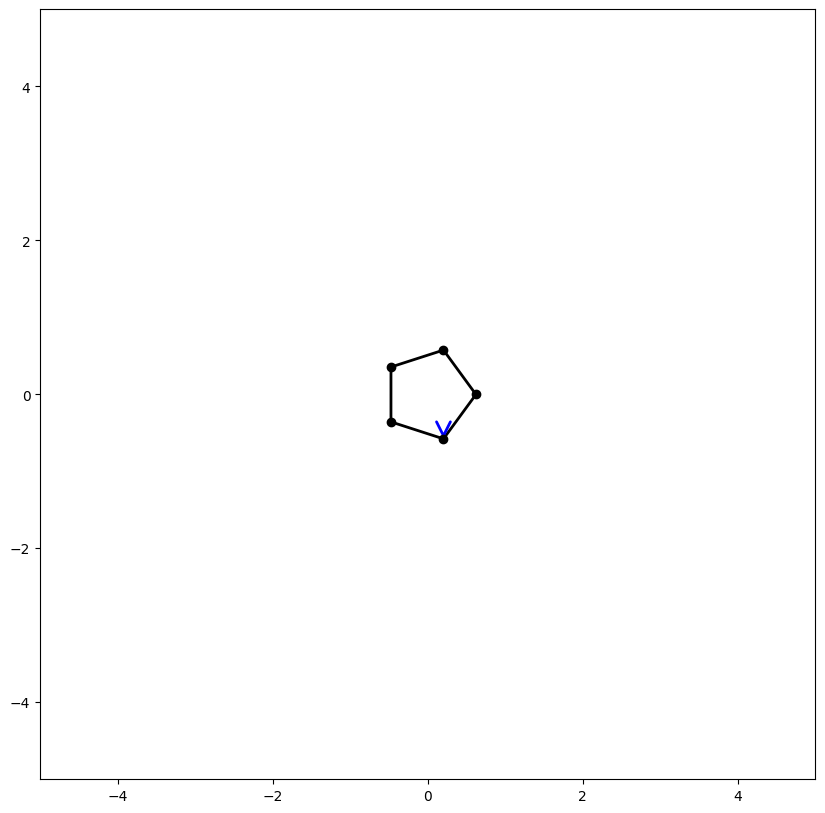

Iteration  124000 ff =  1.0150734971903775e-30 vv =  5.709788421695875e-33 power =  7.613051228927833e-32


<Figure size 640x480 with 0 Axes>

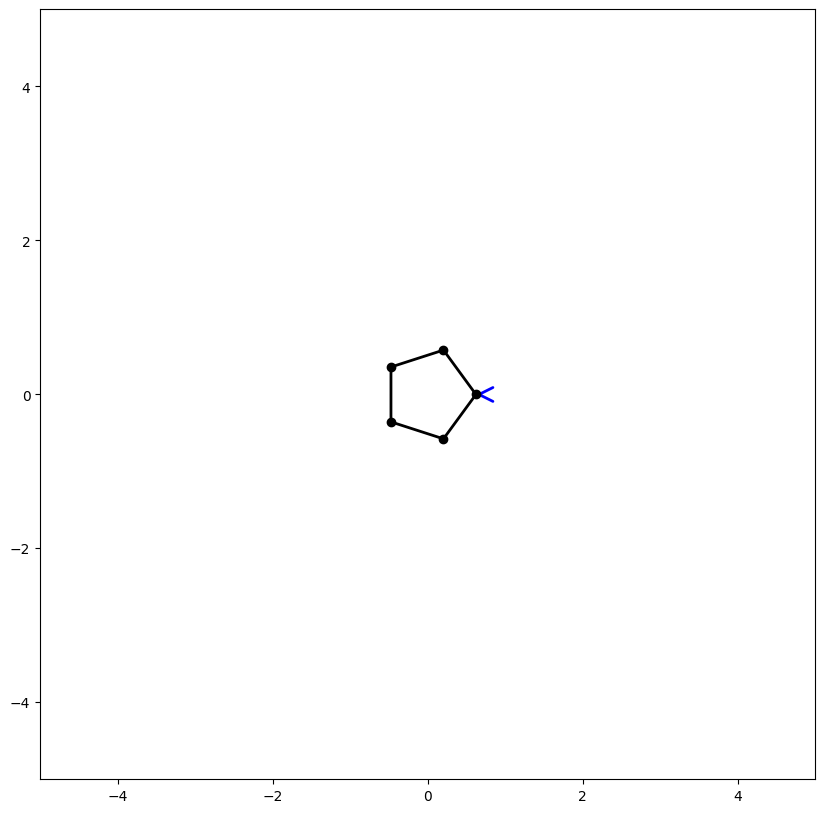

Iteration  125000 ff =  2.4580905233934452e-31 vv =  4.0468297076849084e-32 power =  9.973702298668906e-32


<Figure size 640x480 with 0 Axes>

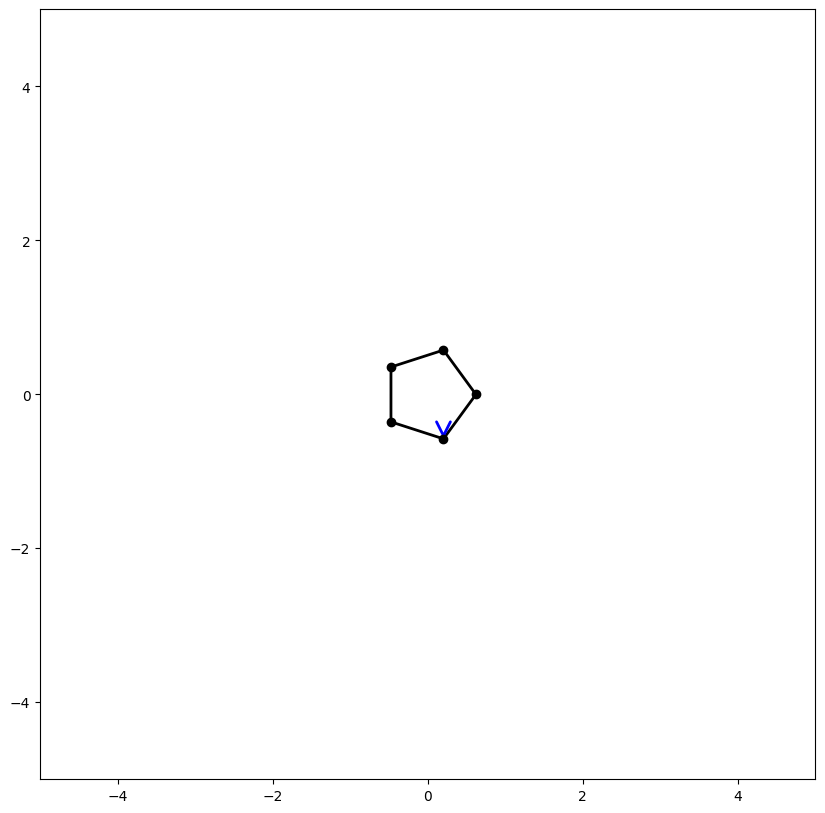

Iteration  126000 ff =  1.0150734971903775e-30 vv =  1.4312561687221756e-31 power =  3.8116009819498683e-31


<Figure size 640x480 with 0 Axes>

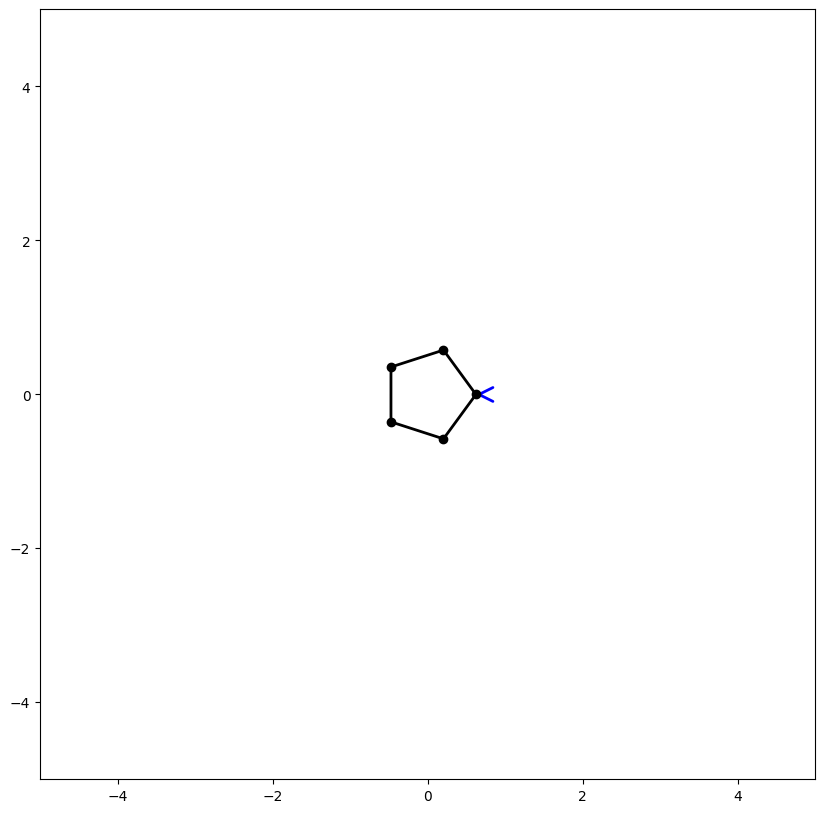

Iteration  127000 ff =  2.4580905233934452e-31 vv =  1.4549612726301982e-31 power =  1.8911442346253646e-31


<Figure size 640x480 with 0 Axes>

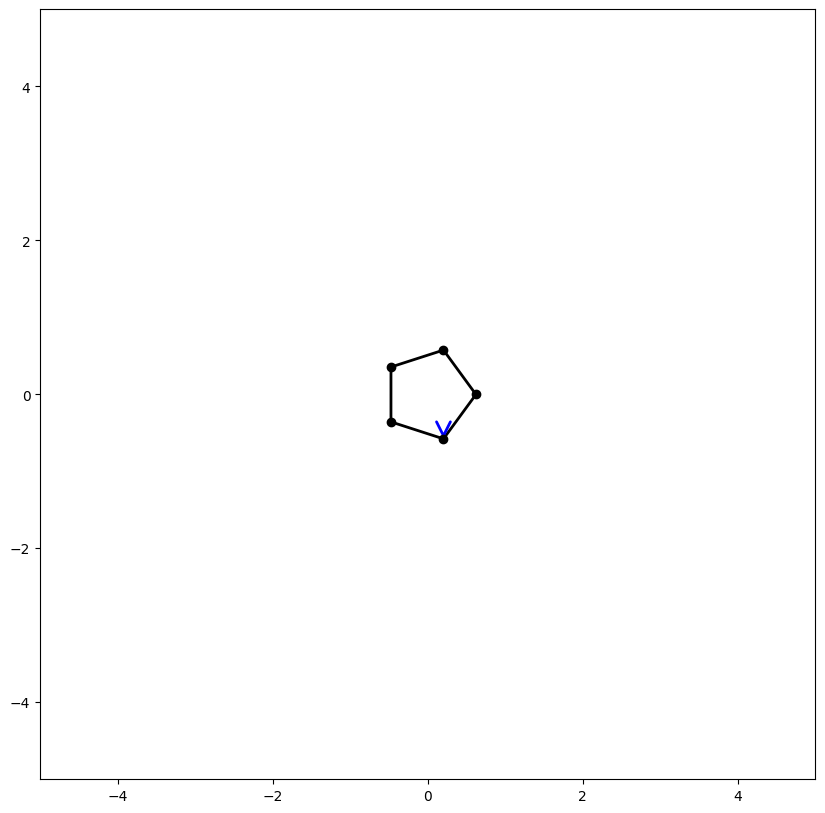

Iteration  128000 ff =  1.0150734971903775e-30 vv =  5.450195822191638e-31 power =  7.437976427499922e-31


<Figure size 640x480 with 0 Axes>

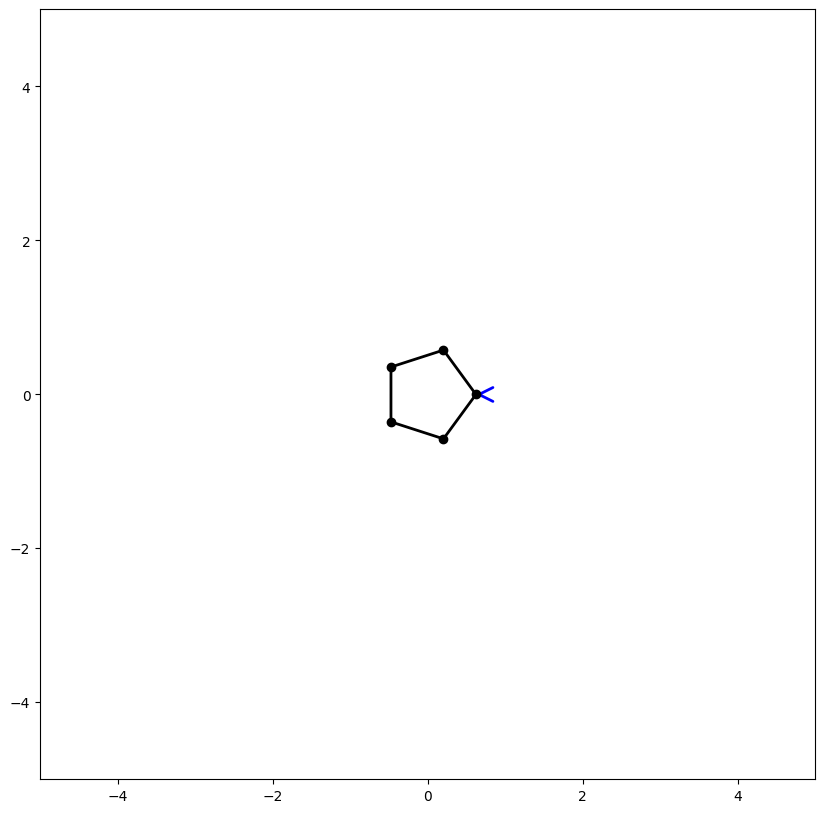

Iteration  129000 ff =  2.4580905233934452e-31 vv =  3.549276036116549e-31 power =  2.9537166061227914e-31


<Figure size 640x480 with 0 Axes>

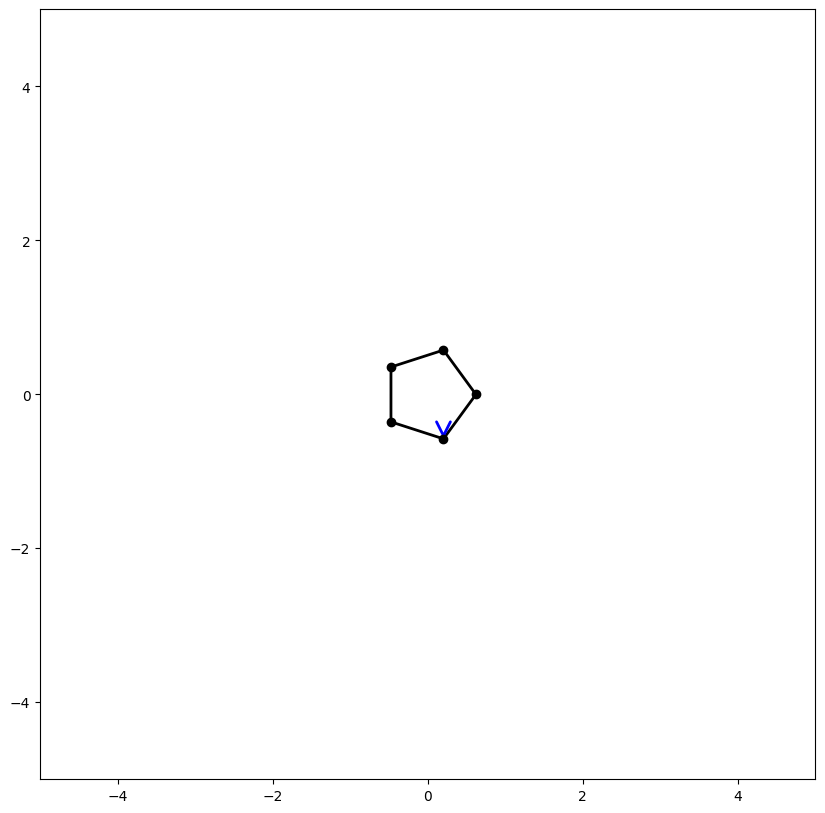

Iteration  130000 ff =  1.0150734971903775e-30 vv =  1.3596293828653152e-30 power =  1.1747866838485574e-30


<Figure size 640x480 with 0 Axes>

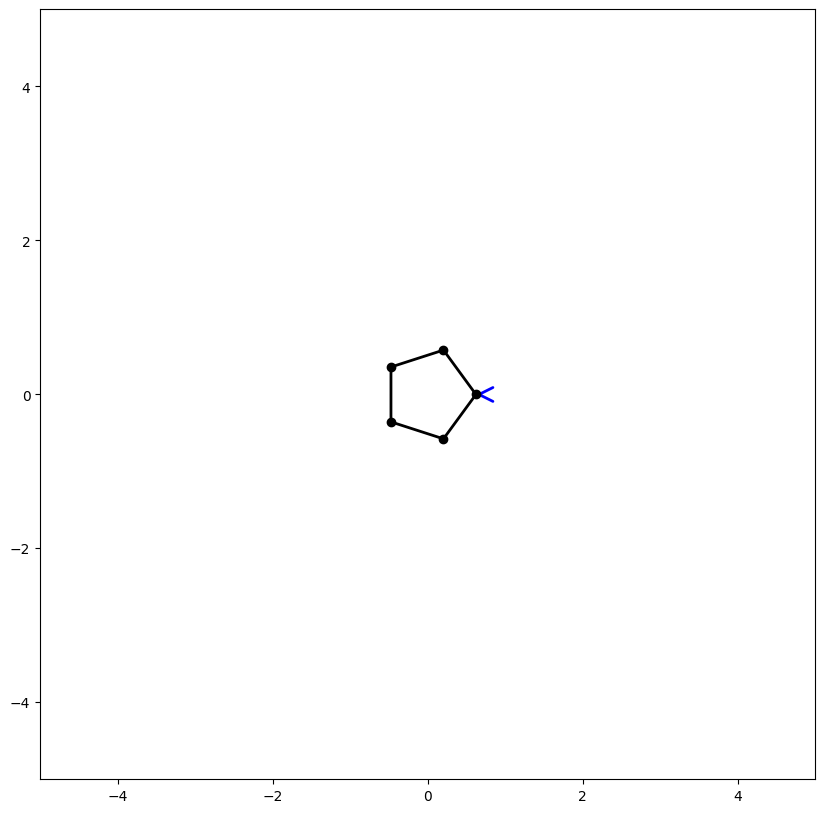

Iteration  131000 ff =  2.4580905233934452e-31 vv =  7.2330286423062075e-31 power =  4.216567224779684e-31


<Figure size 640x480 with 0 Axes>

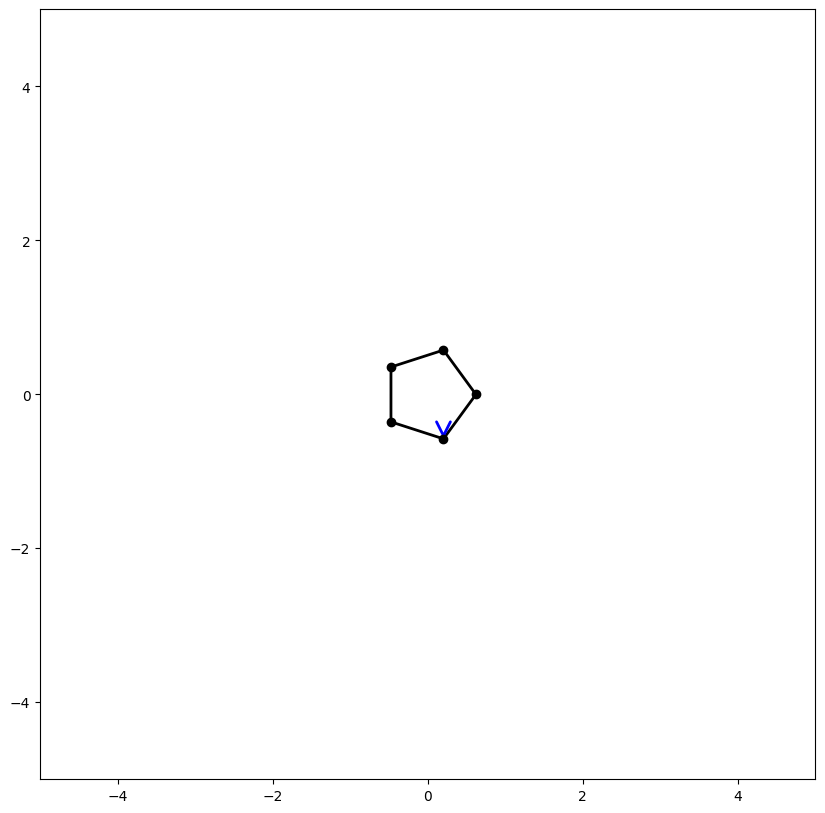

Iteration  132000 ff =  1.0150734971903775e-30 vv =  2.8196439367900996e-30 power =  1.691787762028432e-30


<Figure size 640x480 with 0 Axes>

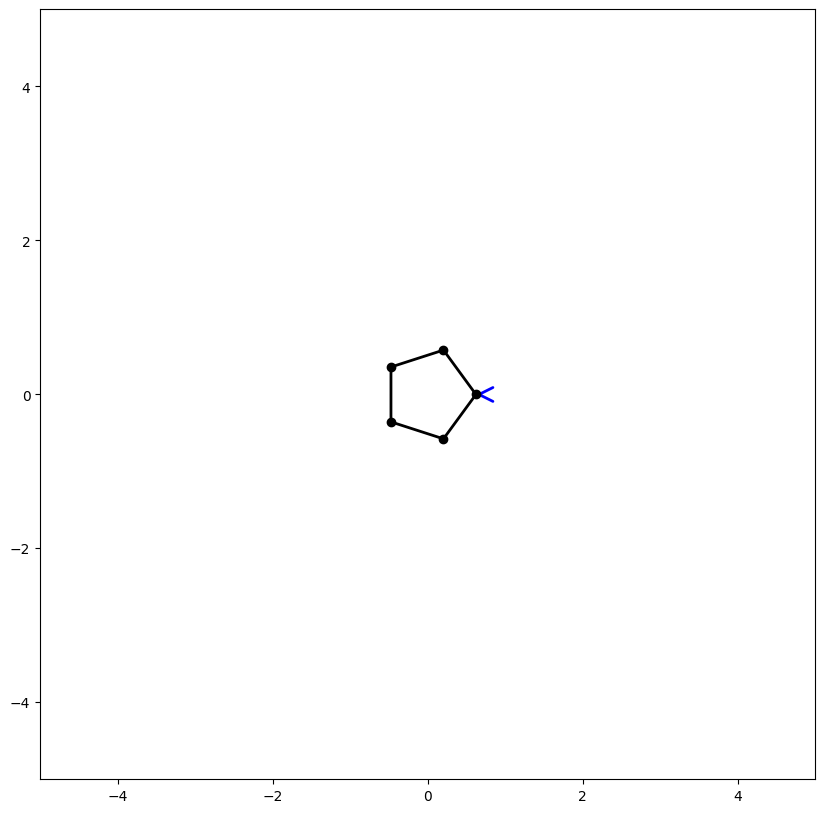

Iteration  133000 ff =  2.4580905233934452e-31 vv =  1.2614824972890376e-30 power =  5.568517012646079e-31


<Figure size 640x480 with 0 Axes>

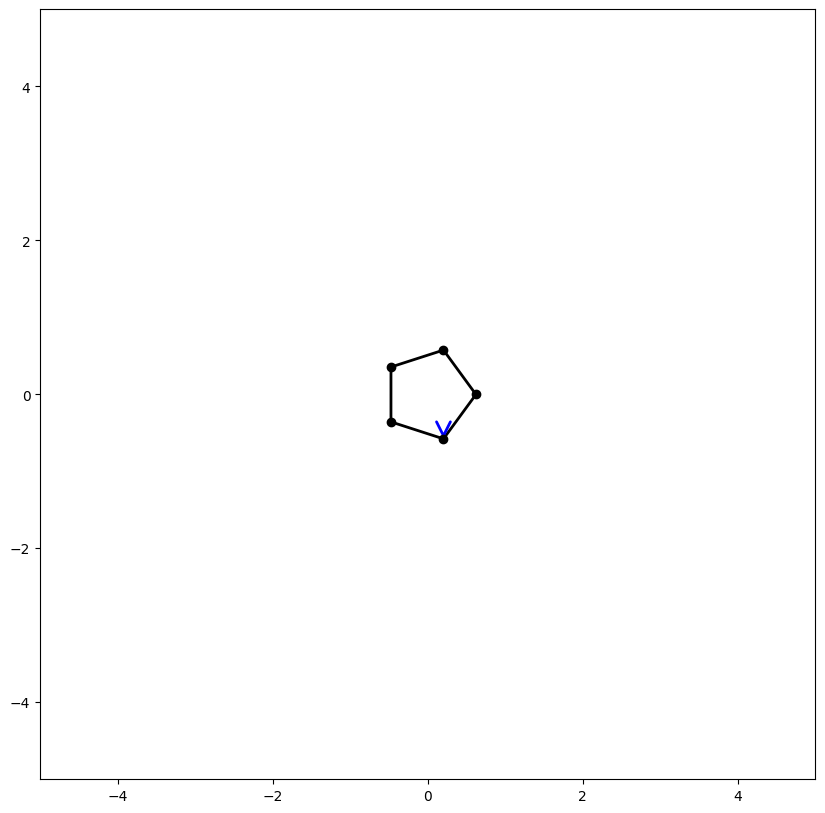

Iteration  134000 ff =  2.4580905233934452e-31 vv =  5.530703677635255e-33 power =  3.6871357850901686e-32


<Figure size 640x480 with 0 Axes>

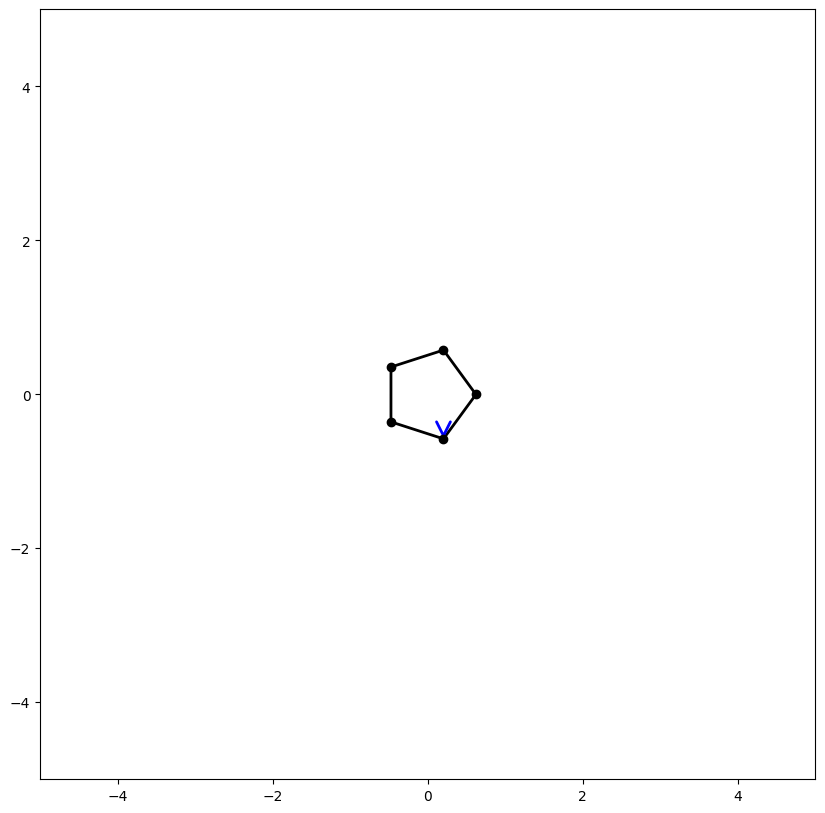

Iteration  135000 ff =  1.0150734971903775e-30 vv =  1.586052339359965e-32 power =  1.268841871487972e-31


<Figure size 640x480 with 0 Axes>

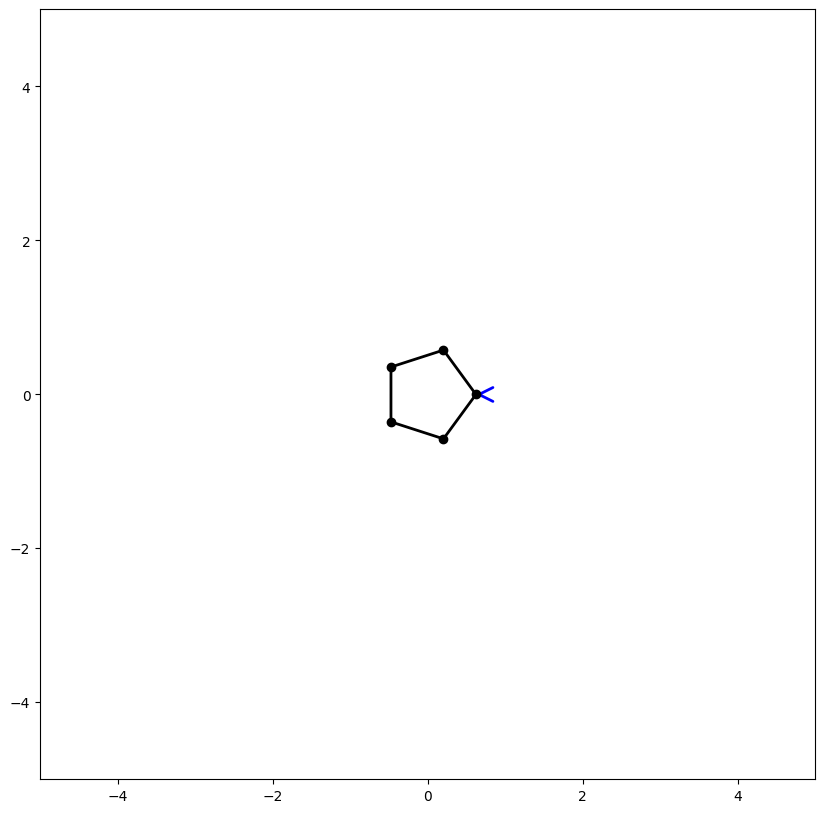

Iteration  136000 ff =  2.4580905233934452e-31 vv =  5.343619944206355e-32 power =  1.1460847065321942e-31


<Figure size 640x480 with 0 Axes>

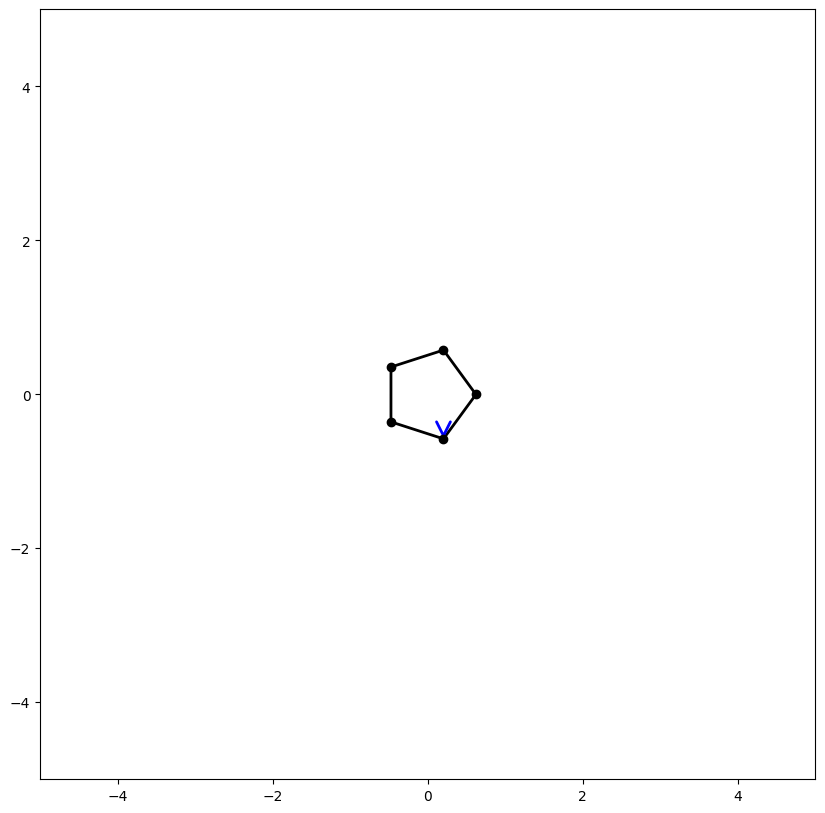

Iteration  137000 ff =  1.0150734971903775e-30 vv =  1.9296141152190206e-31 power =  4.425720447750047e-31


<Figure size 640x480 with 0 Axes>

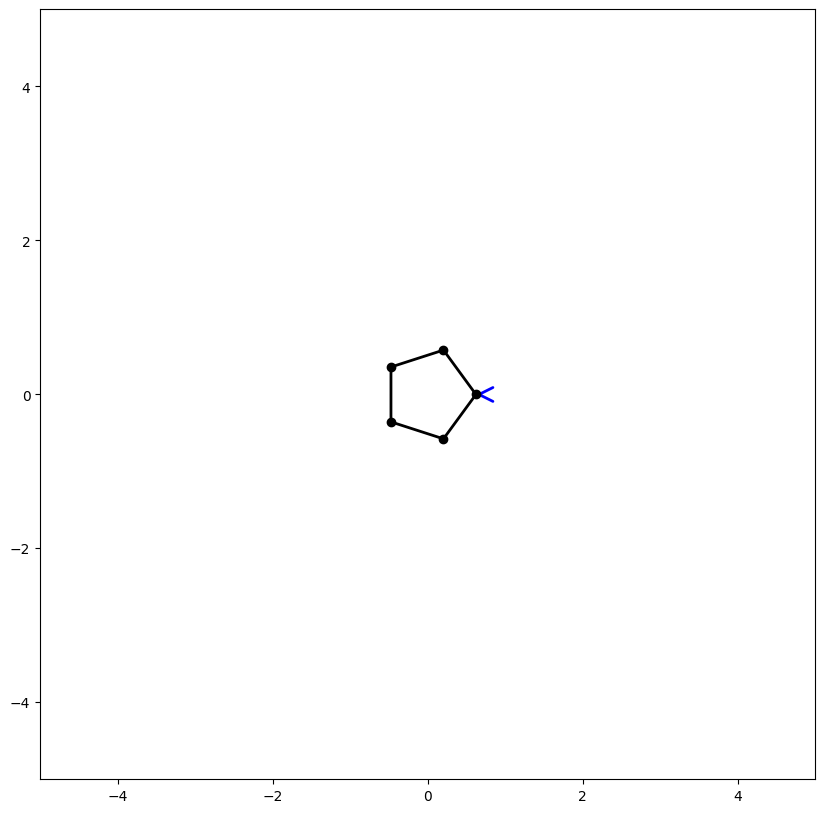

Iteration  138000 ff =  2.4580905233934452e-31 vv =  1.7450165383714809e-31 power =  2.0710887513903815e-31


<Figure size 640x480 with 0 Axes>

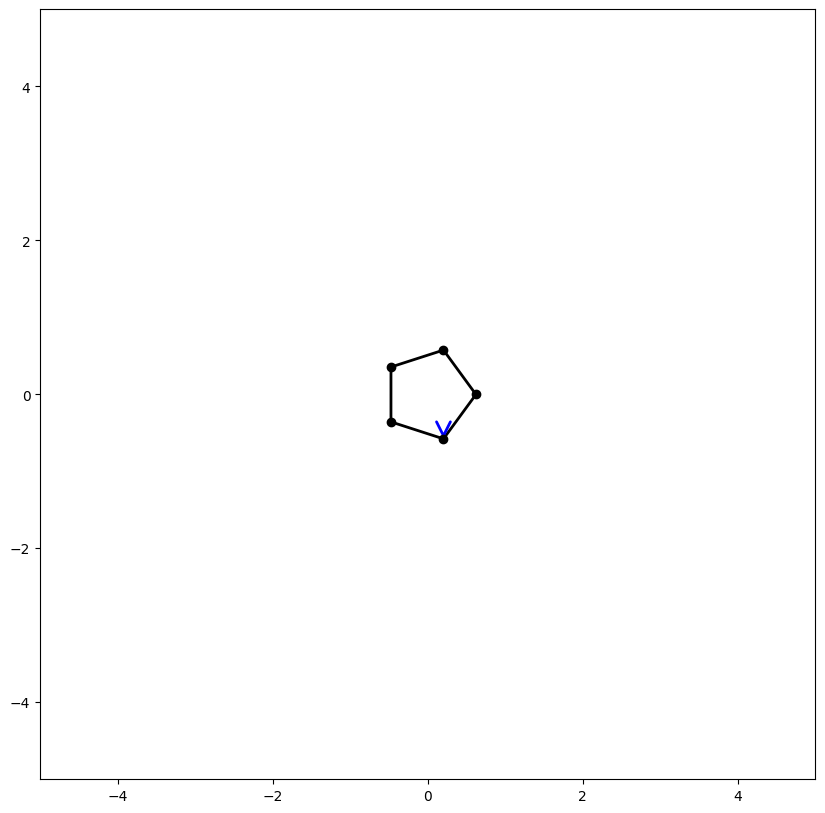

Iteration  139000 ff =  1.0150734971903775e-30 vv =  6.593587455689523e-31 power =  8.181060981118139e-31


<Figure size 640x480 with 0 Axes>

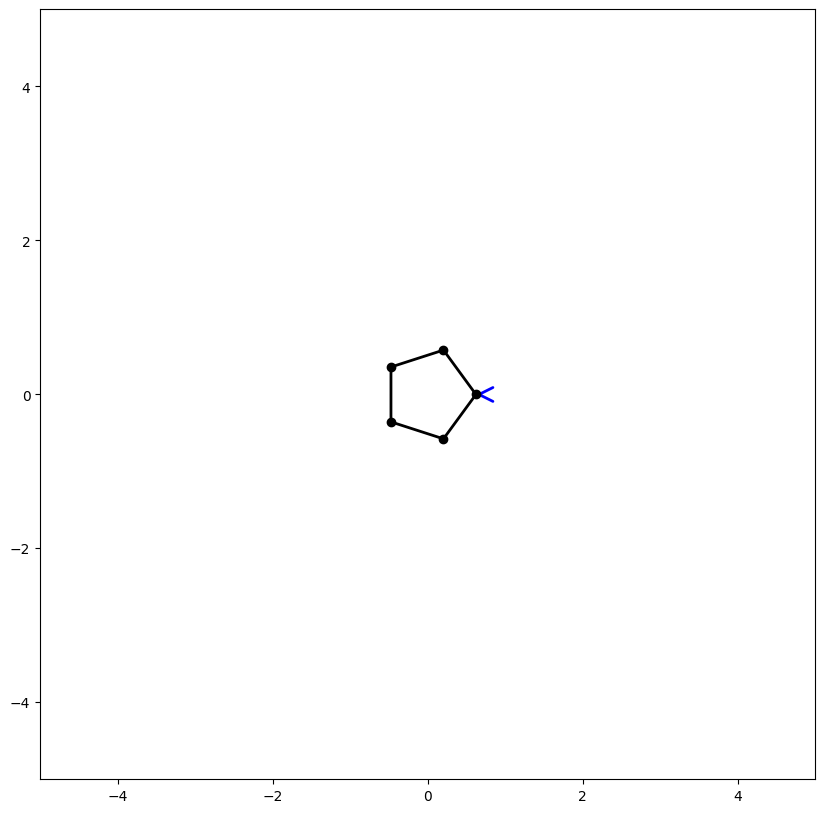

Iteration  140000 ff =  2.4580905233934452e-31 vv =  4.091831303190418e-31 power =  3.1714494714084626e-31


<Figure size 640x480 with 0 Axes>

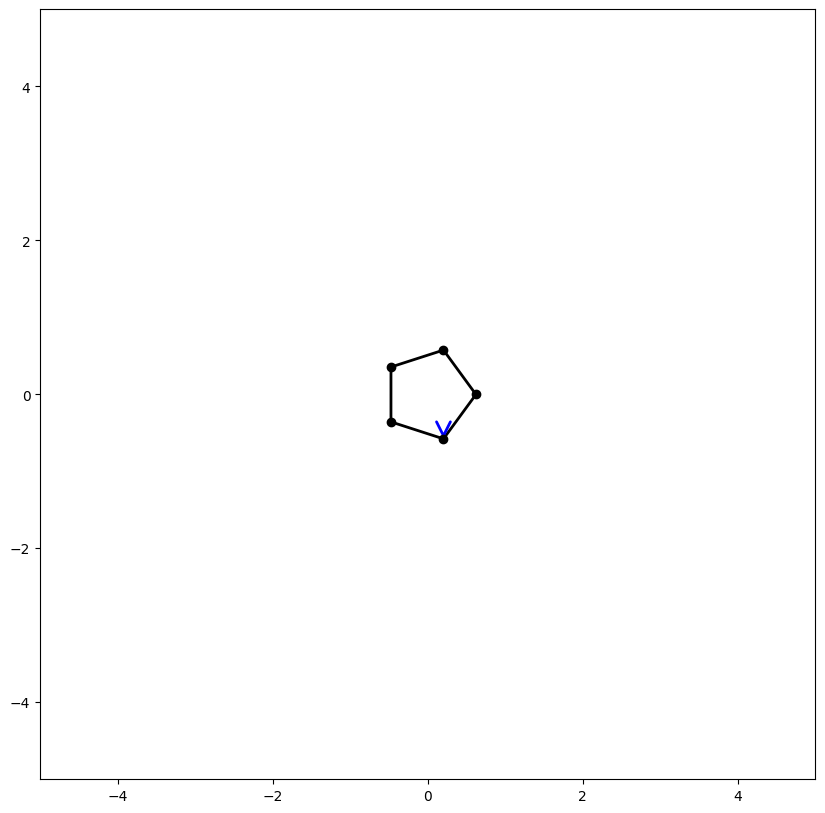

Iteration  141000 ff =  1.0150734971903775e-30 vv =  1.5757143487779582e-30 power =  1.2646999148363616e-30


<Figure size 640x480 with 0 Axes>

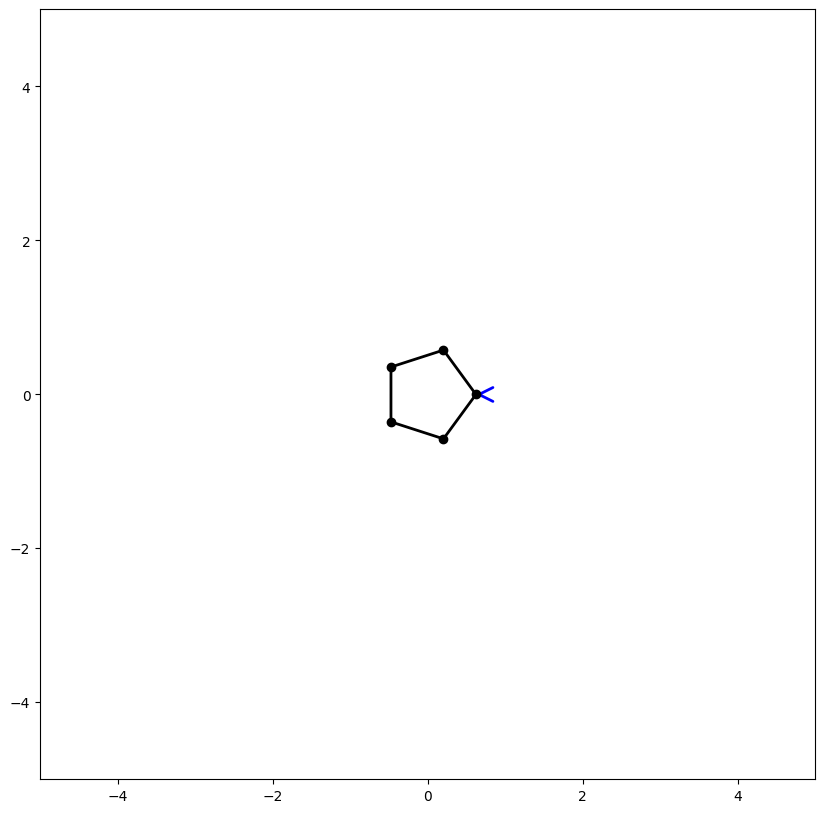

Iteration  142000 ff =  2.4580905233934452e-31 vv =  8.100922992496078e-31 power =  4.462376277119029e-31


<Figure size 640x480 with 0 Axes>

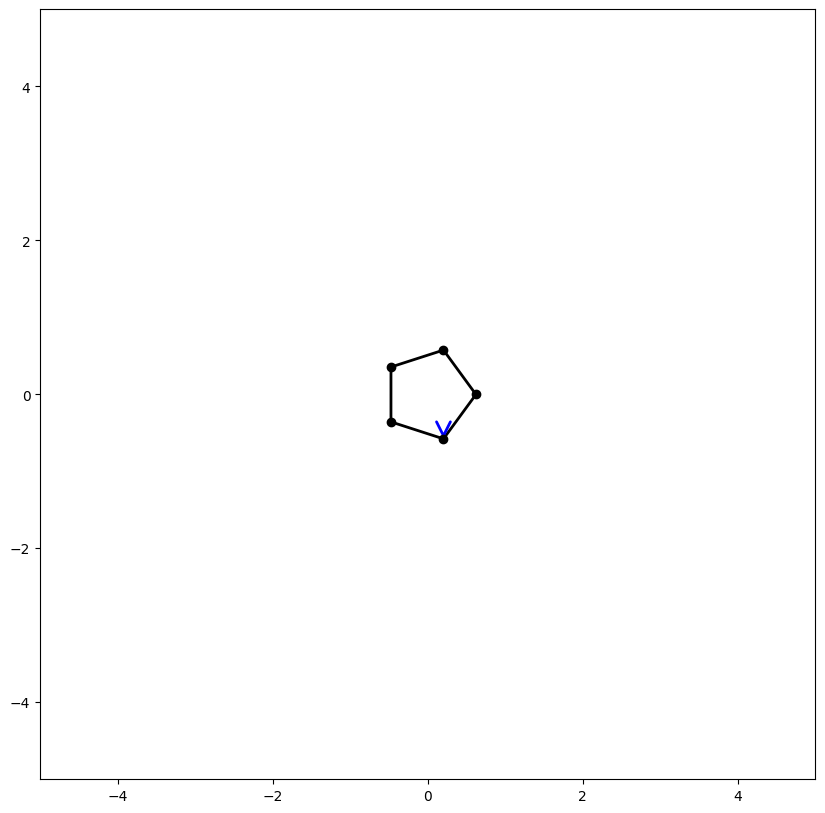

Iteration  143000 ff =  1.0150734971903775e-30 vv =  3.163555623959731e-30 power =  1.7919937139312434e-30


<Figure size 640x480 with 0 Axes>

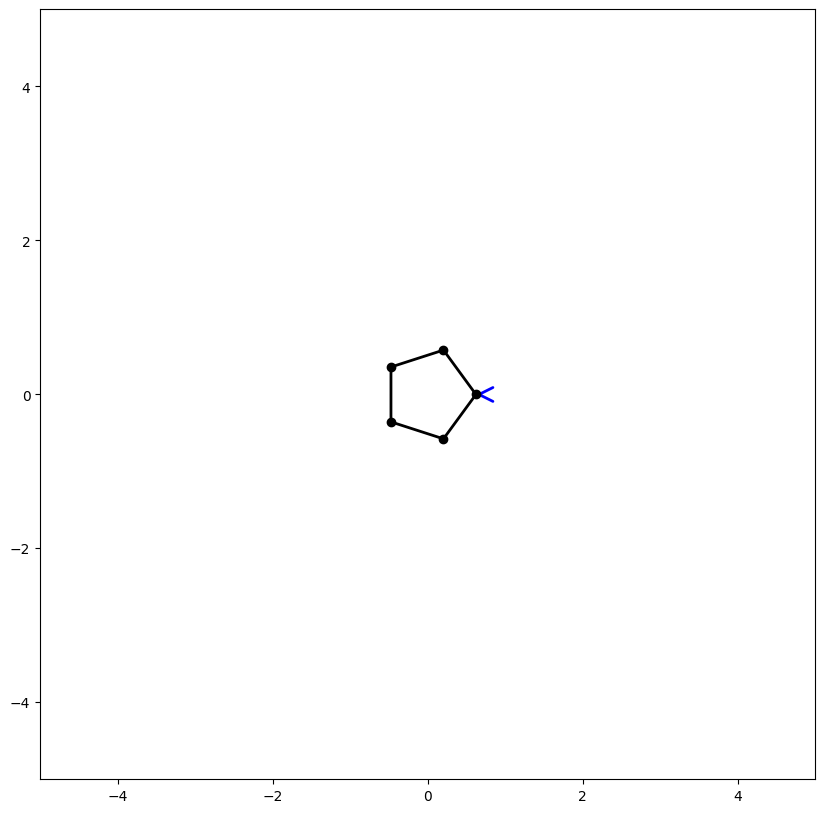

Iteration  144000 ff =  2.4580905233934452e-31 vv =  1.3753109280653523e-30 power =  5.814326064985423e-31


<Figure size 640x480 with 0 Axes>

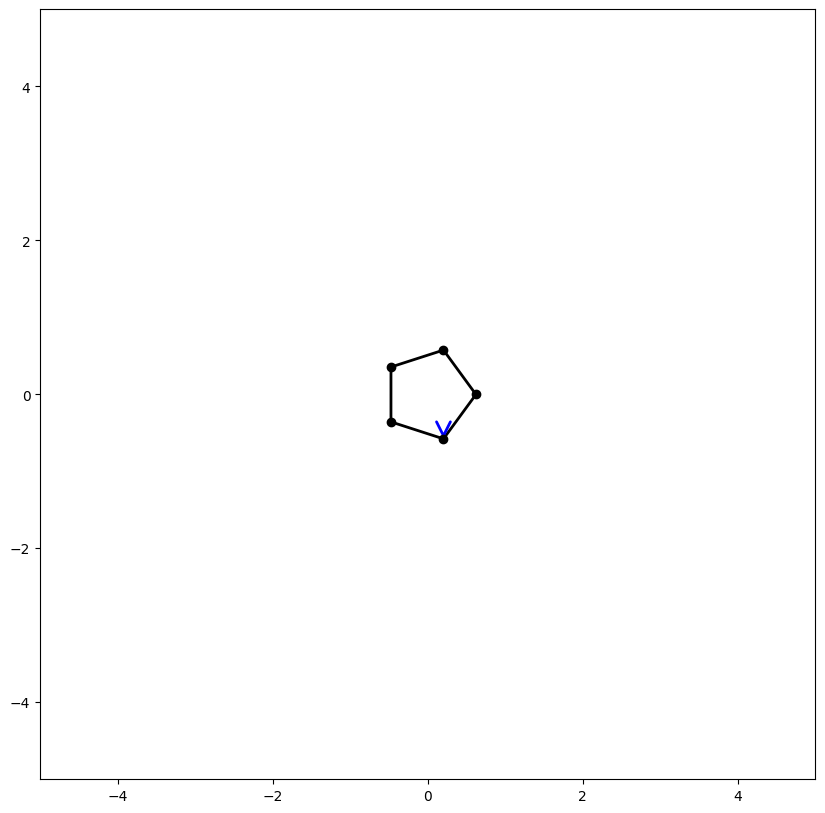

Iteration  145000 ff =  2.4580905233934452e-31 vv =  1.0330125424560959e-32 power =  5.039085572956564e-32


<Figure size 640x480 with 0 Axes>

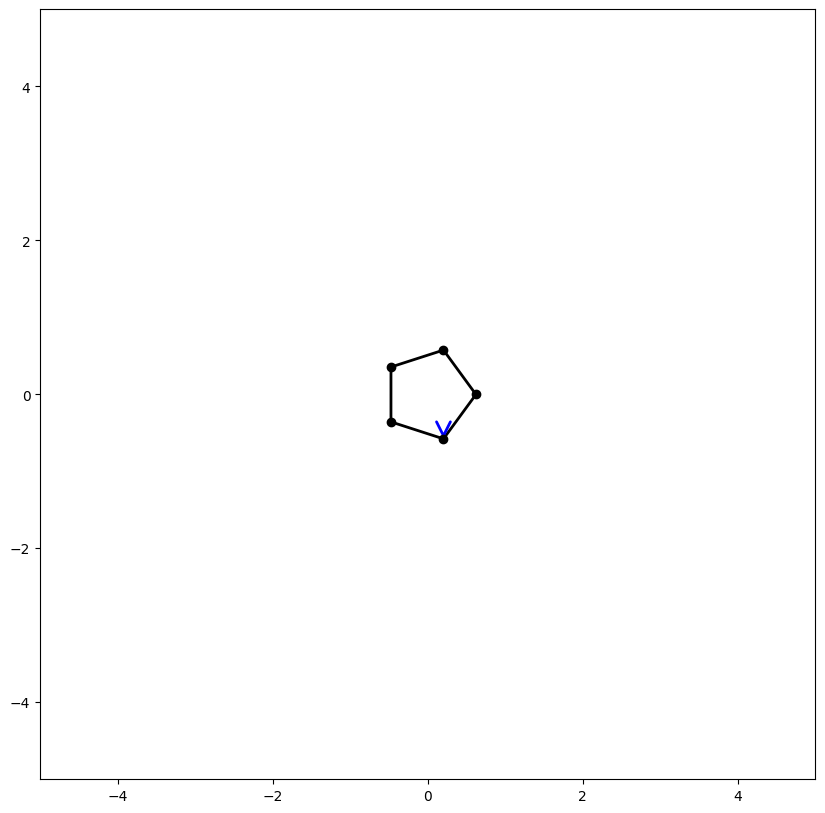

Iteration  146000 ff =  1.0150734971903775e-30 vv =  3.1981159370854335e-32 power =  1.8017554575129205e-31


<Figure size 640x480 with 0 Axes>

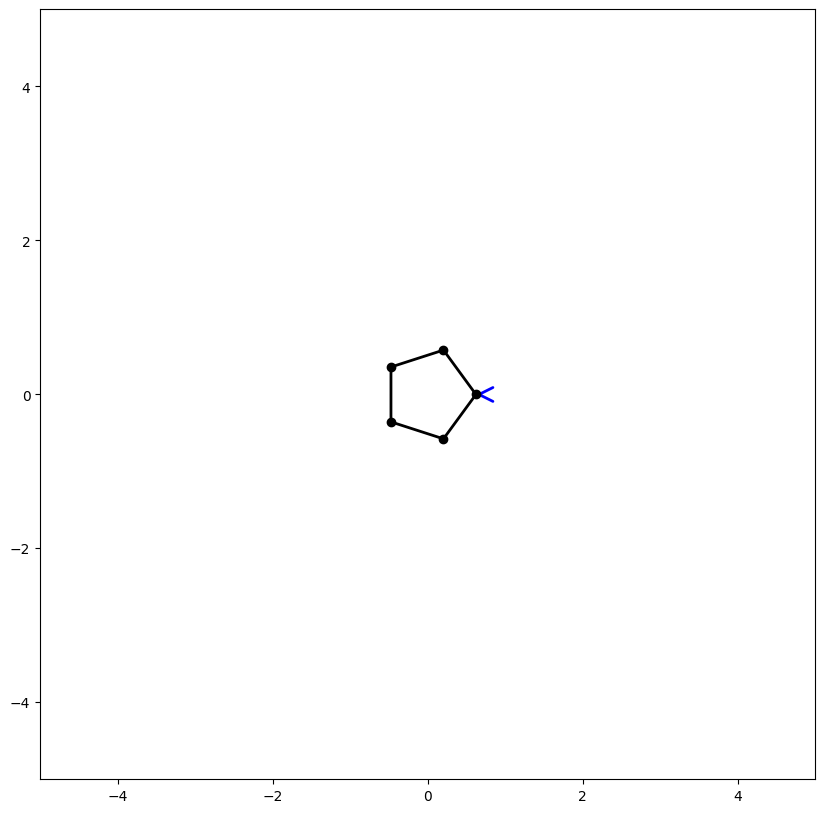

Iteration  147000 ff =  2.4580905233934452e-31 vv =  6.898914978722223e-32 power =  1.3022349070307627e-31


<Figure size 640x480 with 0 Axes>

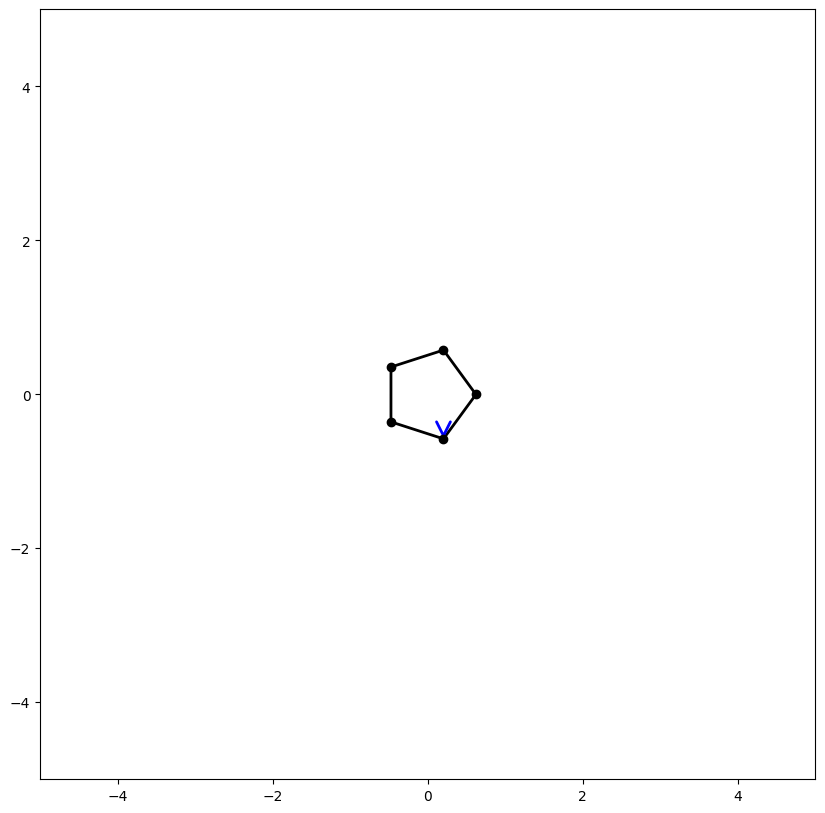

Iteration  148000 ff =  1.0150734971903775e-30 vv =  2.502280517077687e-31 power =  5.039839913550225e-31


<Figure size 640x480 with 0 Axes>

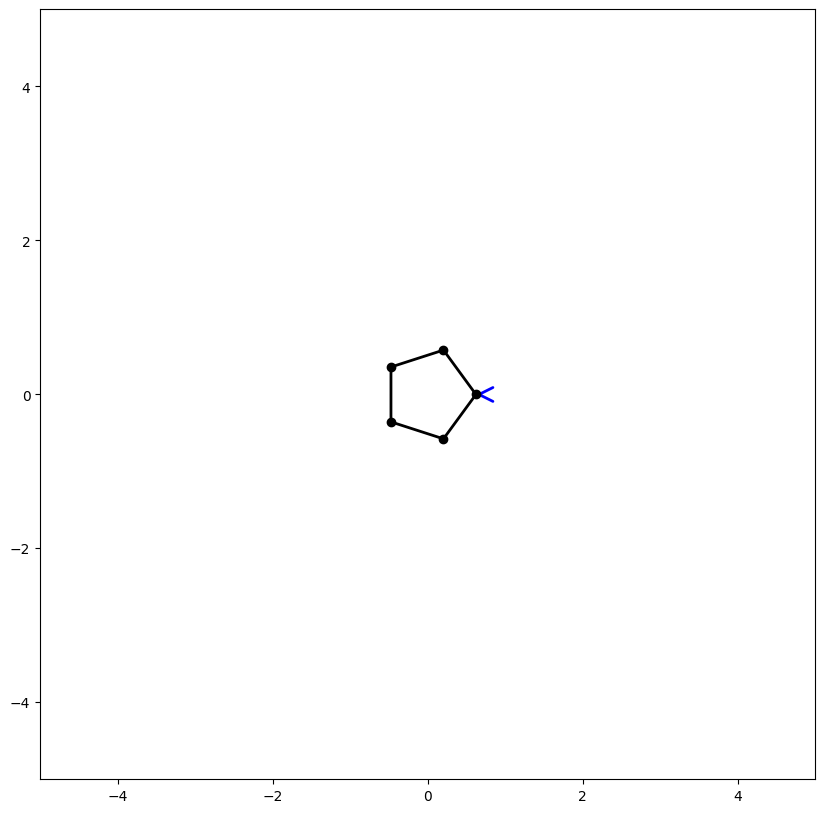

Iteration  149000 ff =  2.4580905233934452e-31 vv =  2.0614174808123293e-31 power =  2.251033268155399e-31


<Figure size 640x480 with 0 Axes>

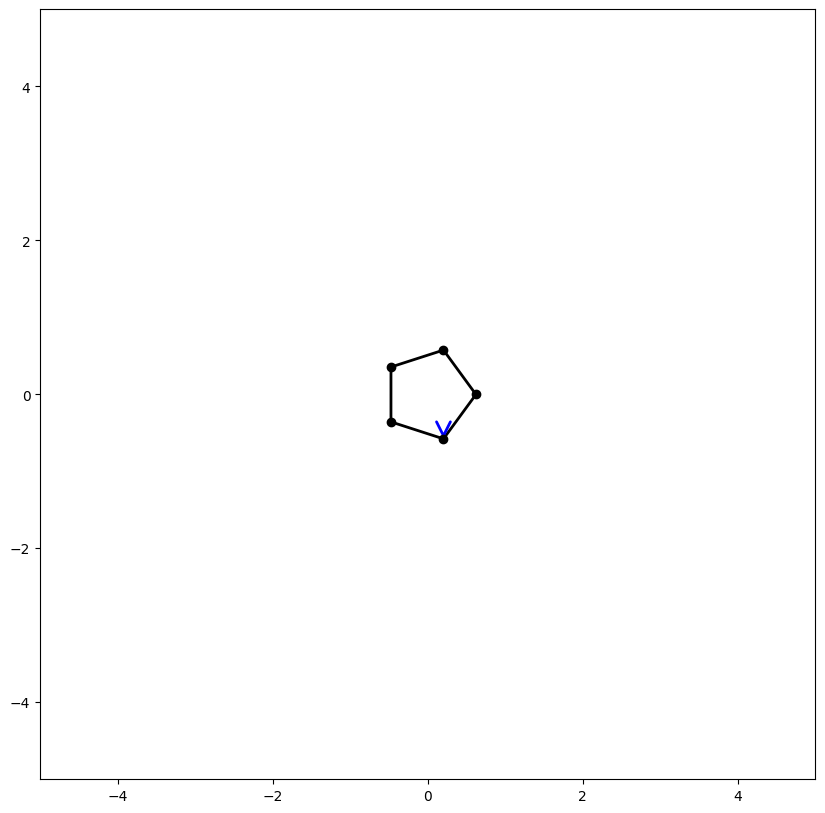

Iteration  150000 ff =  1.0150734971903775e-30 vv =  7.8457740986826506e-31 power =  8.924145534736353e-31


<Figure size 640x480 with 0 Axes>

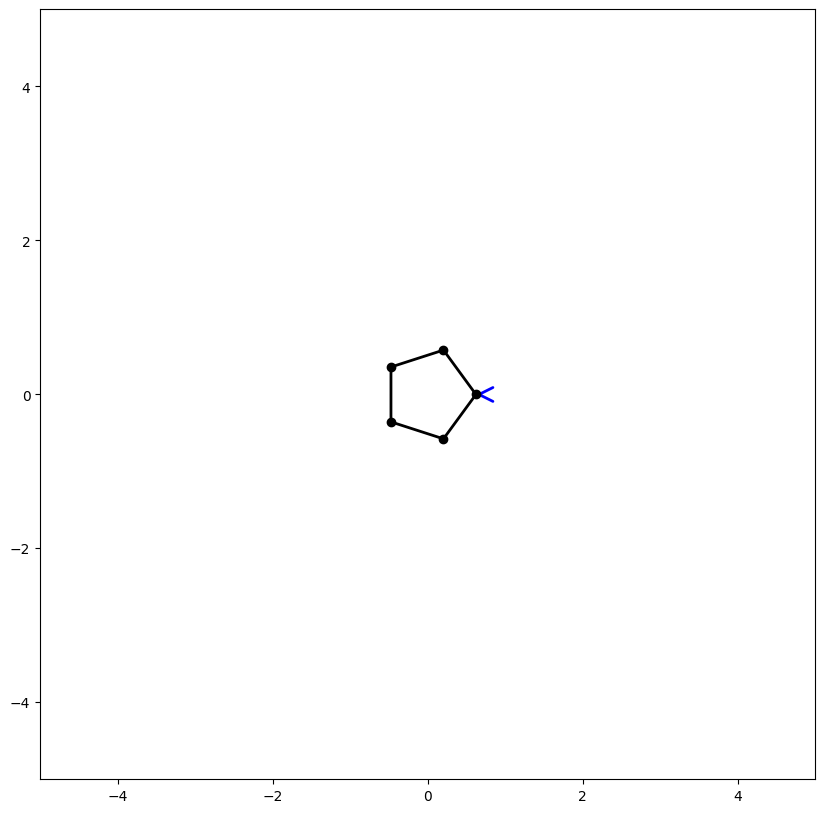

Iteration  151000 ff =  2.4580905233934452e-31 vv =  4.672959275520122e-31 power =  3.389182336694134e-31


<Figure size 640x480 with 0 Axes>

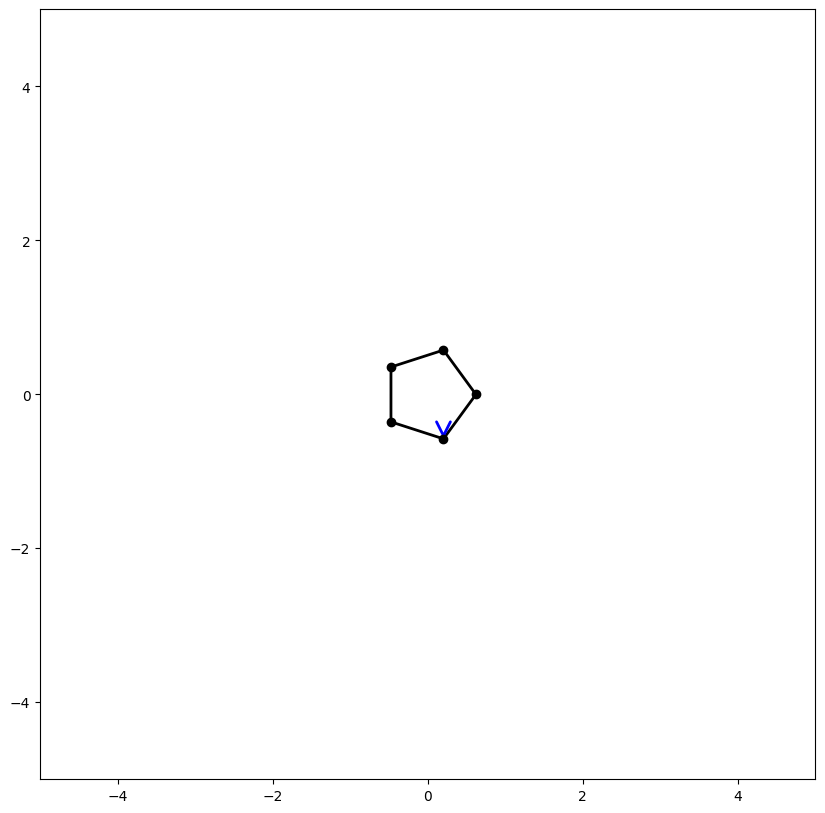

Iteration  152000 ff =  1.0150734971903775e-30 vv =  1.8077279920308e-30 power =  1.354613145824166e-30


<Figure size 640x480 with 0 Axes>

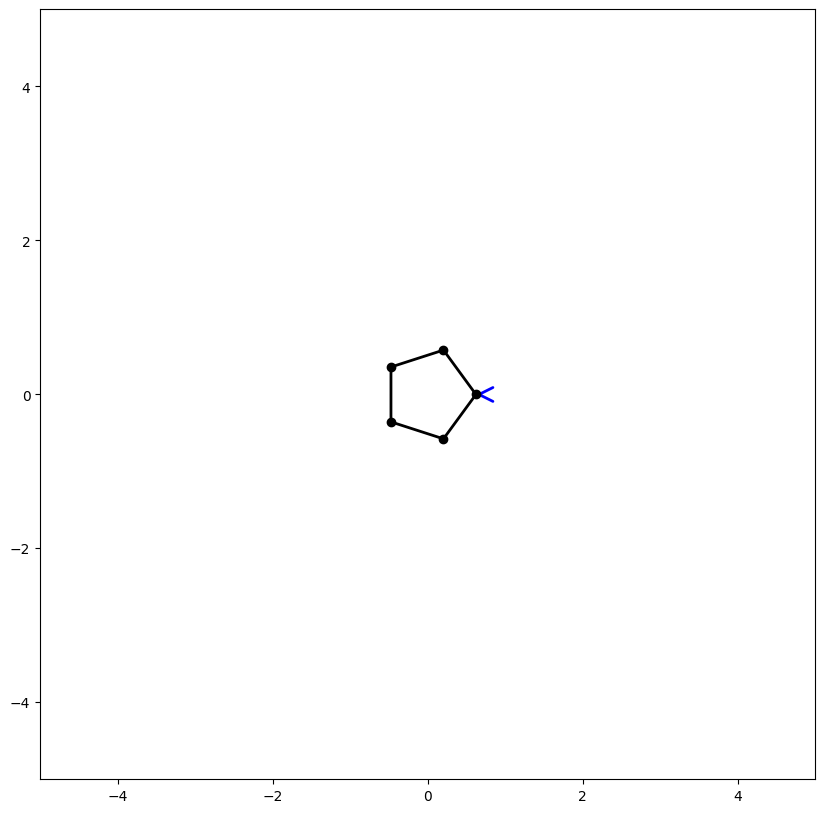

Iteration  153000 ff =  2.4580905233934452e-31 vv =  9.01797915315382e-31 power =  4.708185329458373e-31


<Figure size 640x480 with 0 Axes>

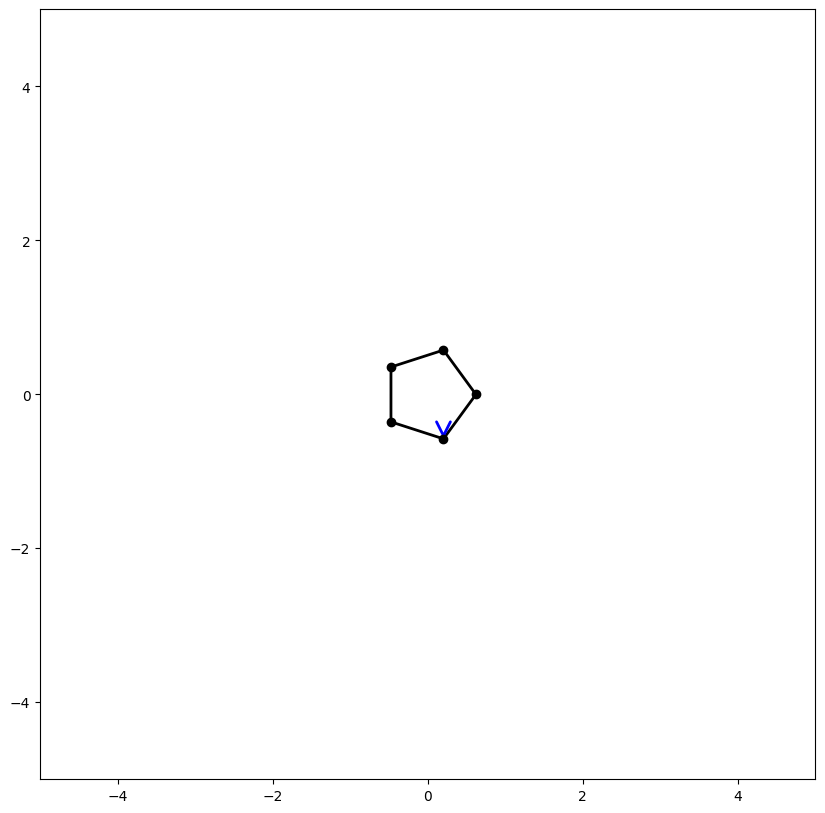

Iteration  154000 ff =  1.0150734971903775e-30 vv =  3.532105101717883e-30 power =  1.893501063650281e-30


<Figure size 640x480 with 0 Axes>

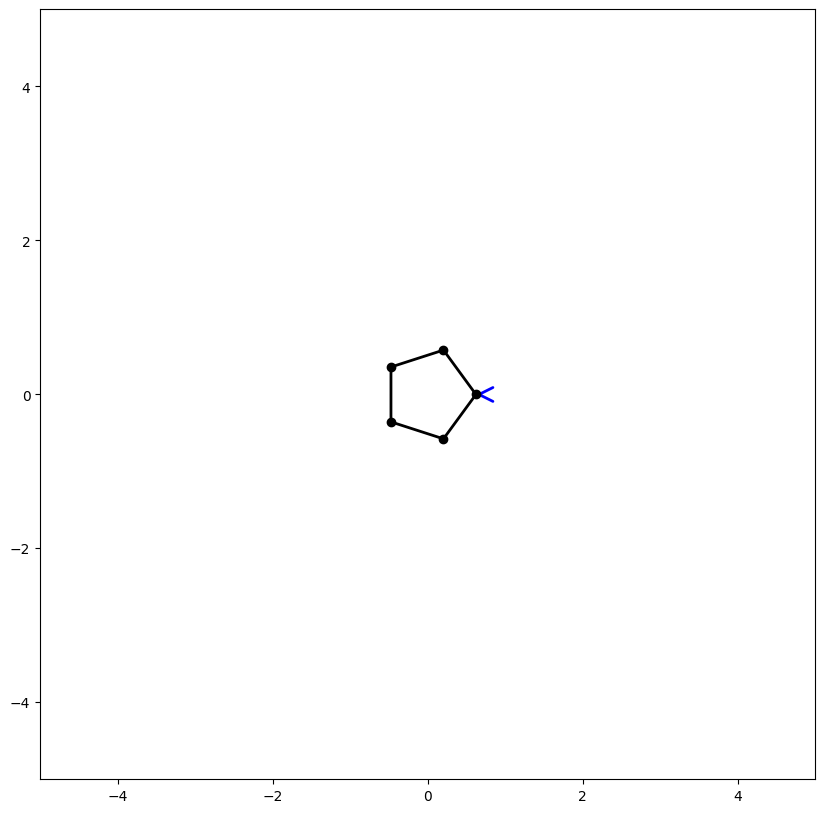

Iteration  155000 ff =  2.4580905233934452e-31 vv =  1.4940555398884537e-30 power =  6.060135117324766e-31


<Figure size 640x480 with 0 Axes>

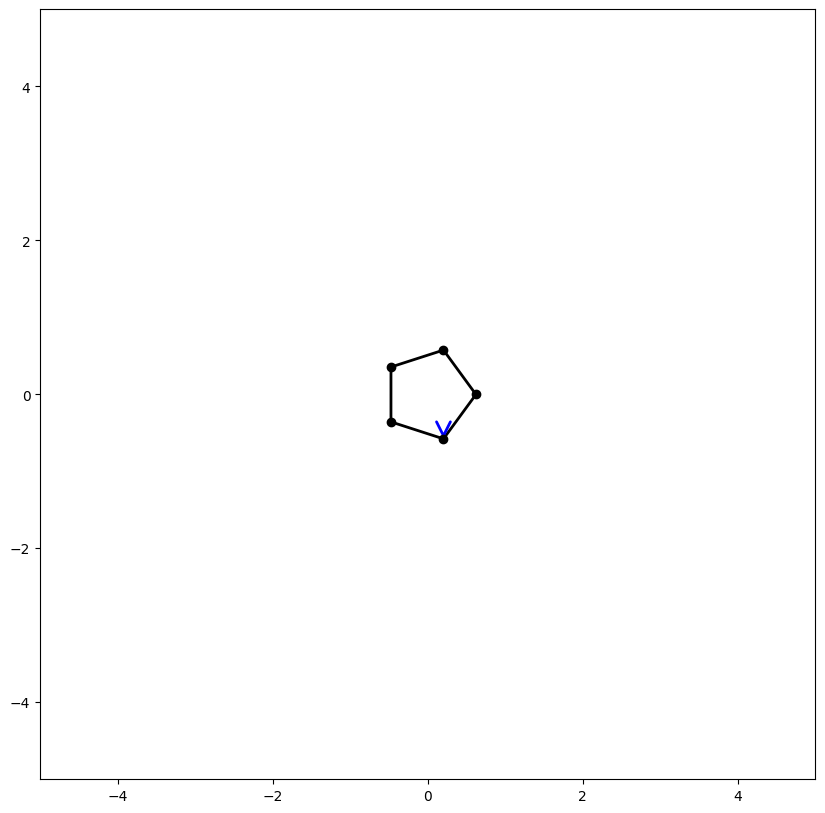

Iteration  156000 ff =  2.4580905233934452e-31 vv =  1.66166919381397e-32 power =  6.391035360822959e-32


<Figure size 640x480 with 0 Axes>

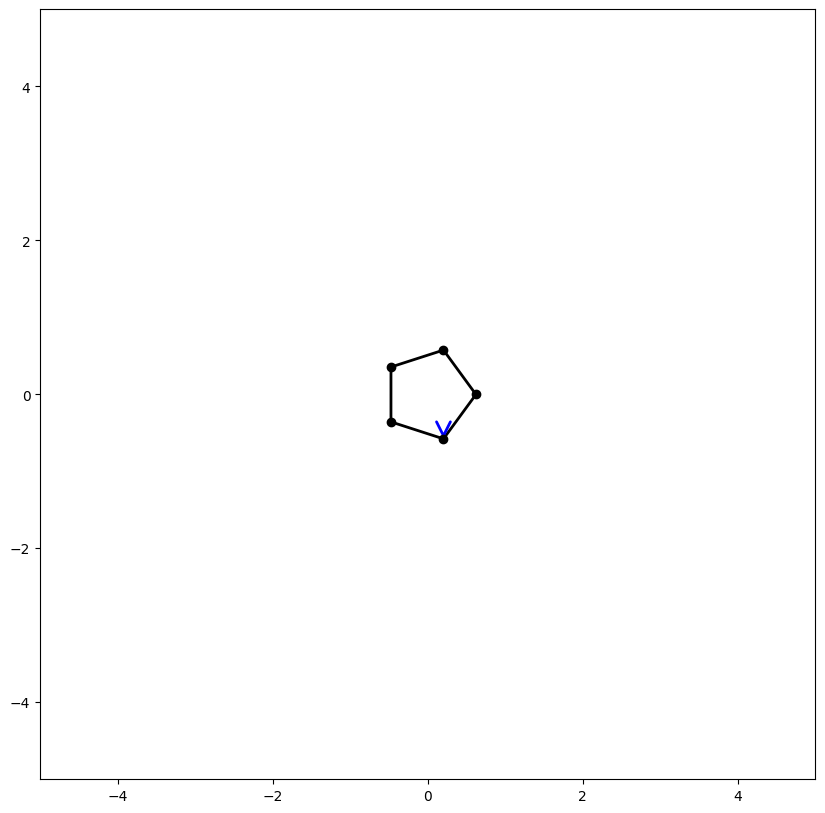

Iteration  157000 ff =  1.0150734971903775e-30 vv =  5.487106673249736e-32 power =  2.3600458809676283e-31


<Figure size 640x480 with 0 Axes>

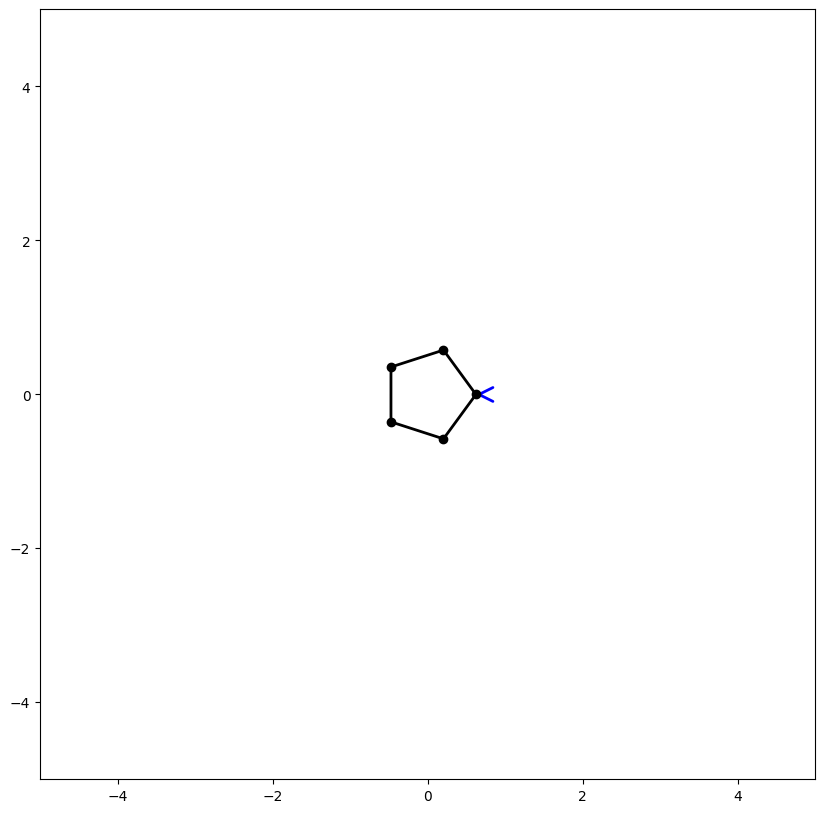

Iteration  158000 ff =  2.4580905233934452e-31 vv =  8.741056072623007e-32 power =  1.4658208313625967e-31


<Figure size 640x480 with 0 Axes>

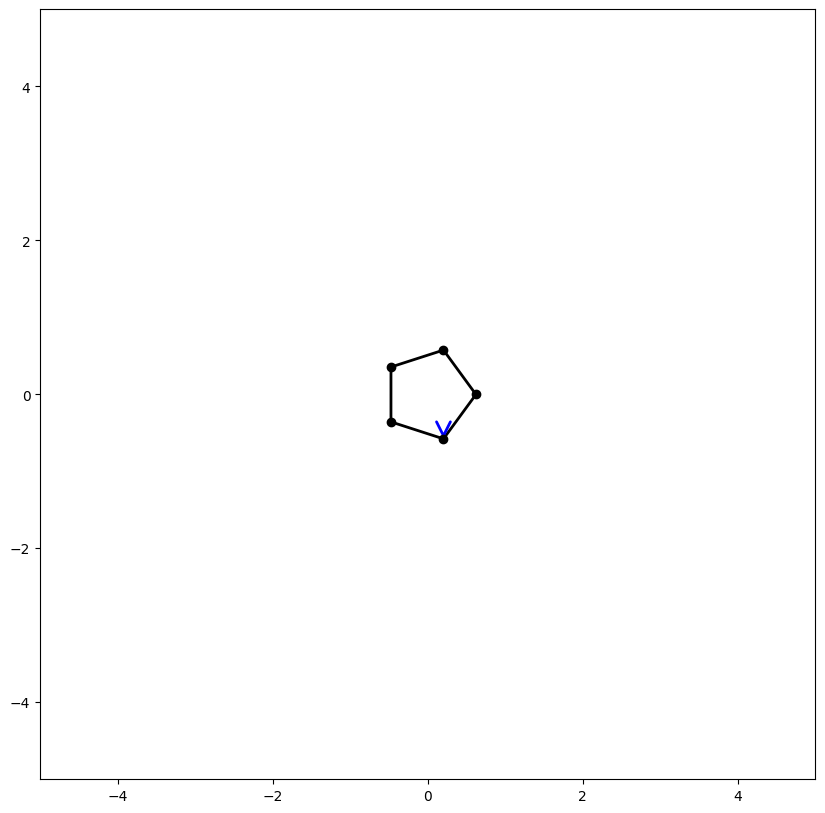

Iteration  159000 ff =  1.0150734971903775e-30 vv =  3.2180398250651247e-31 power =  5.715371325930422e-31


<Figure size 640x480 with 0 Axes>

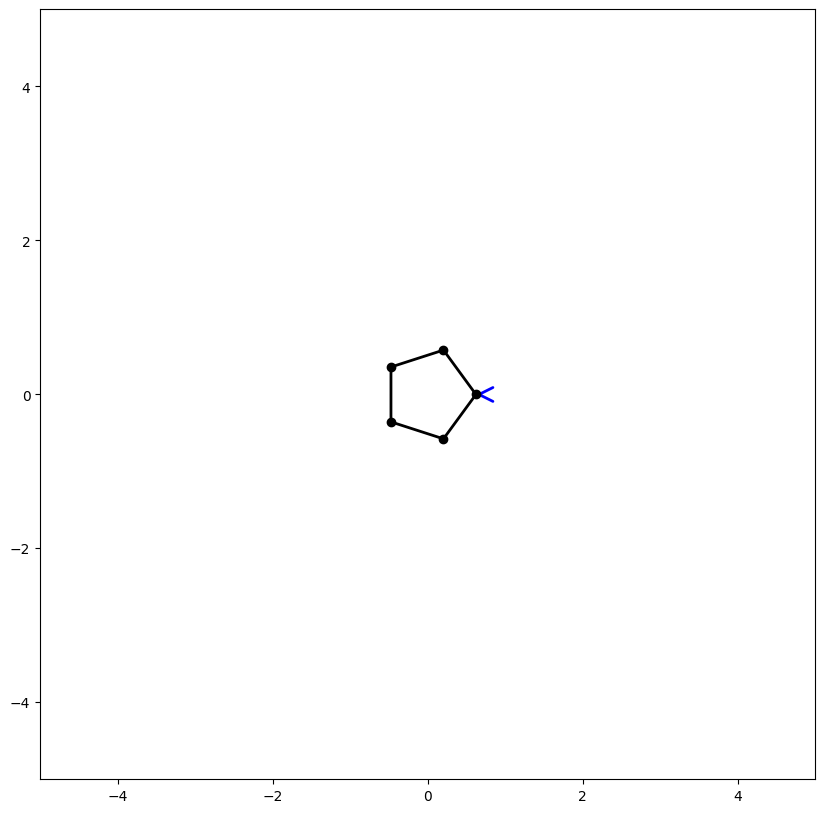

Iteration  160000 ff =  2.4580905233934452e-31 vv =  2.439887774085262e-31 power =  2.4489722365969182e-31


<Figure size 640x480 with 0 Axes>

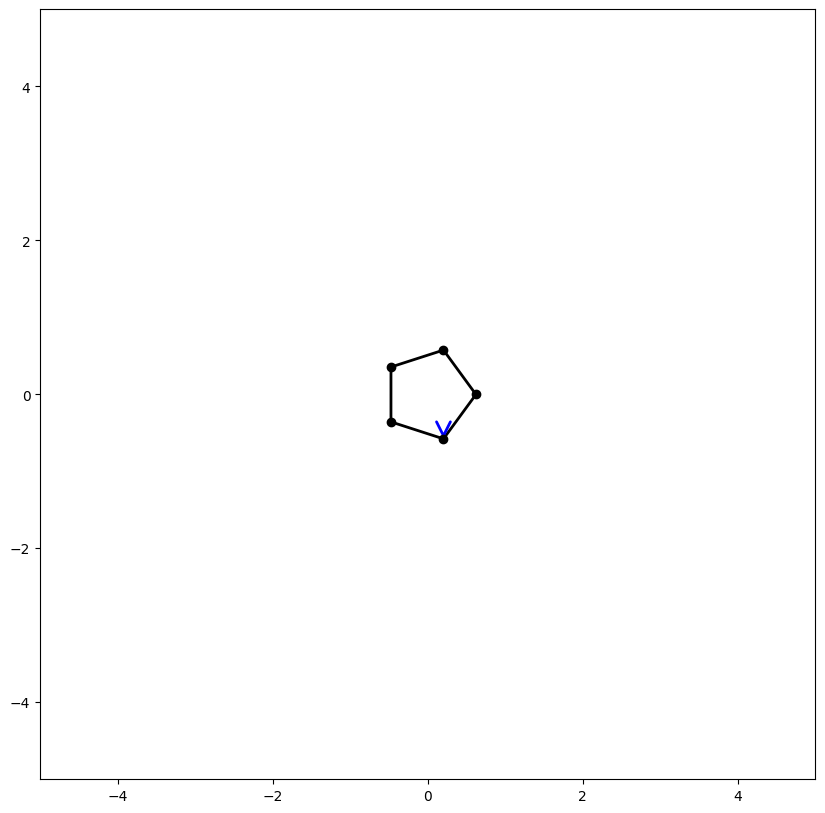

Iteration  161000 ff =  1.0150734971903775e-30 vv =  9.27766070279469e-31 power =  9.704384316035481e-31


<Figure size 640x480 with 0 Axes>

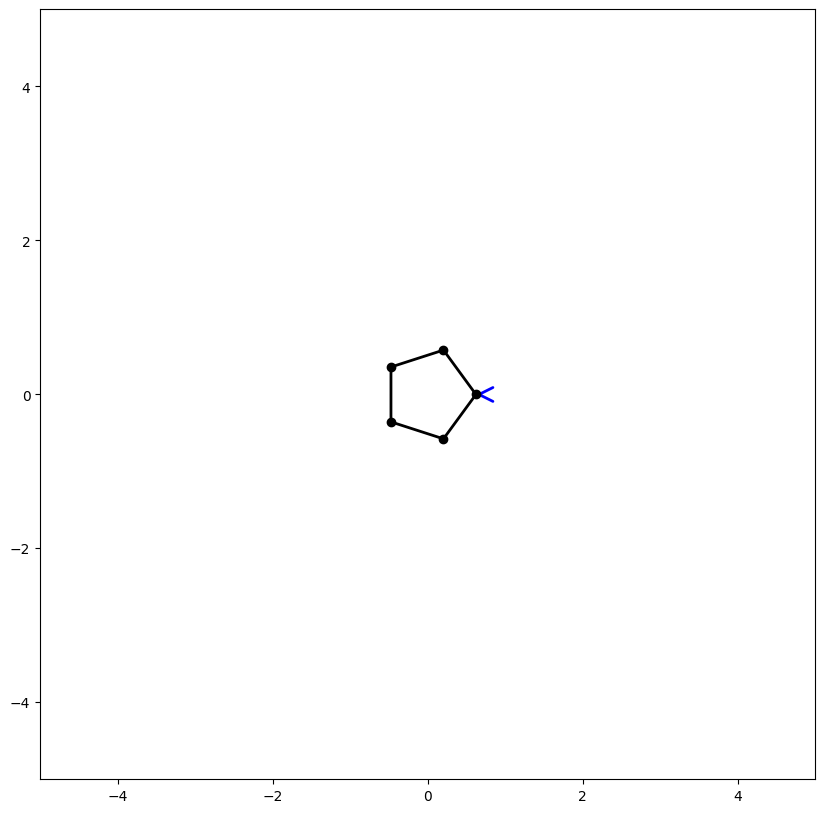

Iteration  162000 ff =  2.4580905233934452e-31 vv =  5.324657520497902e-31 power =  3.6178018452440884e-31


<Figure size 640x480 with 0 Axes>

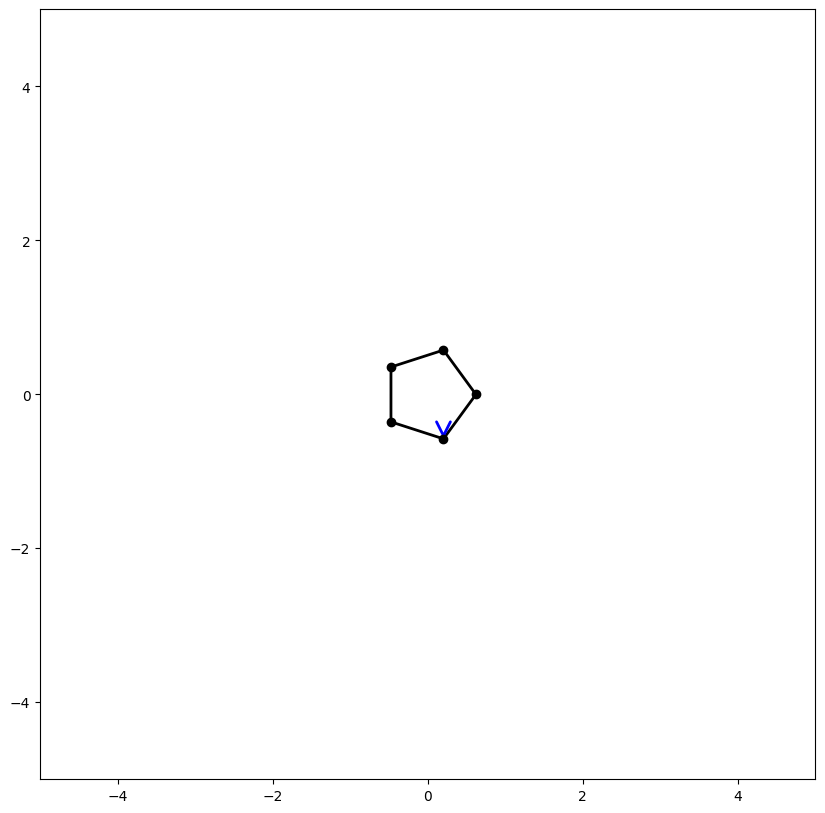

Iteration  163000 ff =  1.0150734971903775e-30 vv =  2.0556703126238404e-30 power =  1.4445263768119702e-30


<Figure size 640x480 with 0 Axes>

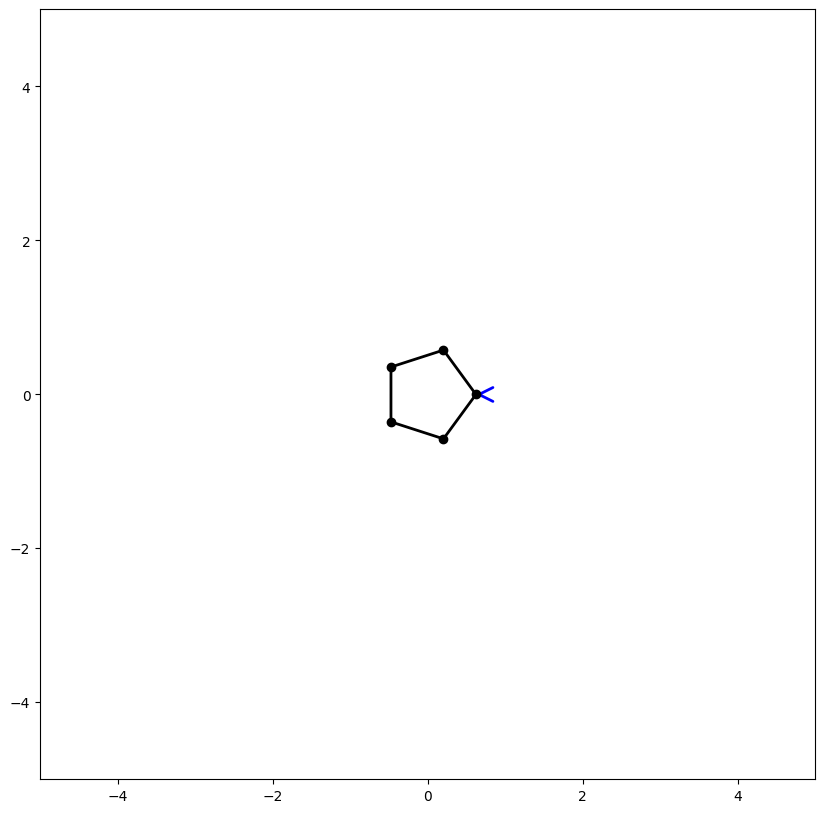

Iteration  164000 ff =  2.4580905233934452e-31 vv =  9.984197124279427e-31 power =  4.953994381797717e-31


<Figure size 640x480 with 0 Axes>

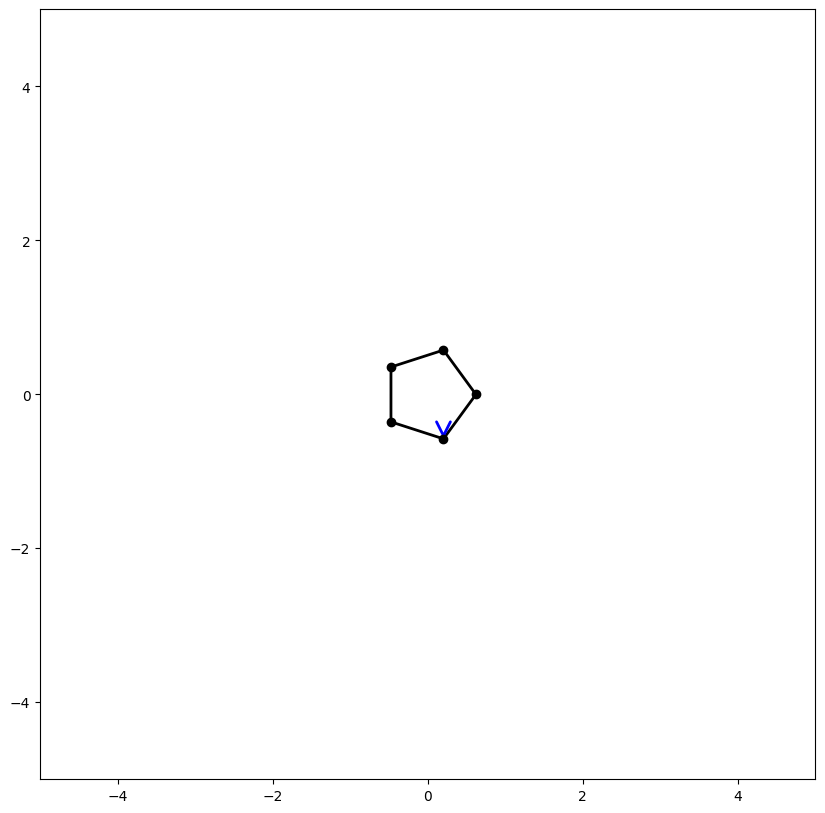

Iteration  165000 ff =  2.4580905233934452e-31 vv =  1.5363065771209036e-34 power =  6.145226308483614e-33


<Figure size 640x480 with 0 Axes>

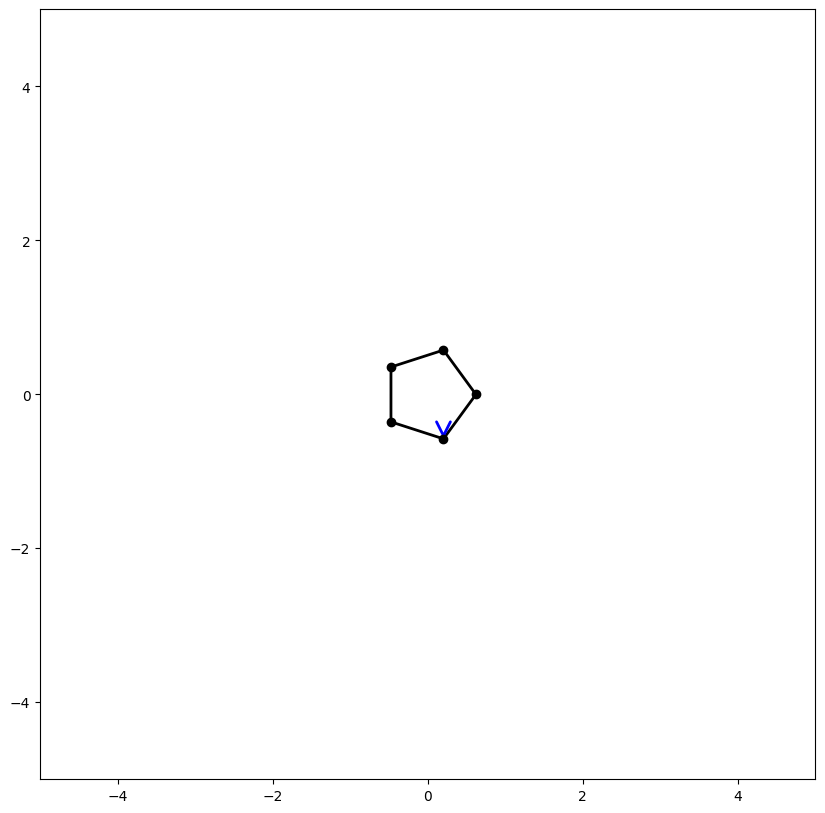

Iteration  166000 ff =  1.0150734971903775e-30 vv =  1.4523060522614651e-30 power =  -1.0042767768810839e-30


<Figure size 640x480 with 0 Axes>

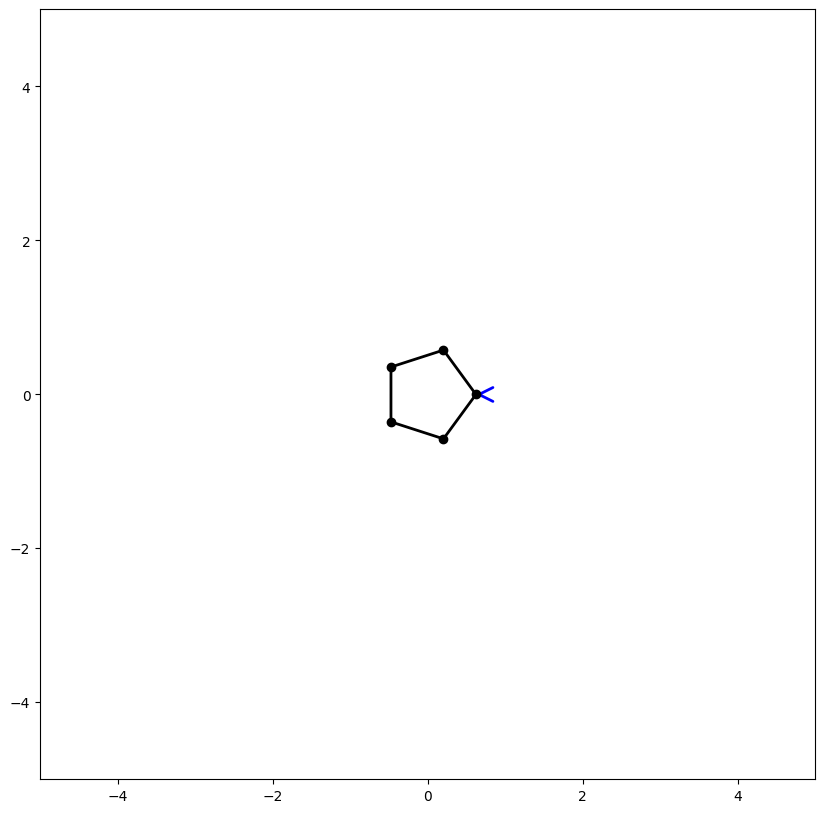

Iteration  167000 ff =  2.4580905233934452e-31 vv =  2.4390403218371479e-32 power =  7.742985148689355e-32


<Figure size 640x480 with 0 Axes>

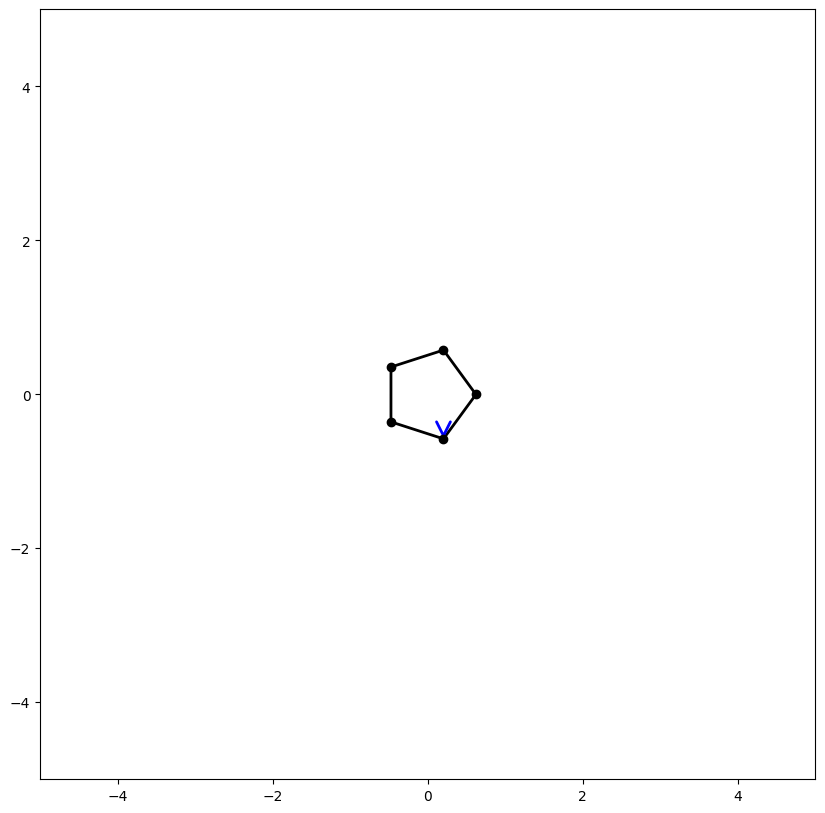

Iteration  168000 ff =  1.0150734971903775e-30 vv =  8.390216875214216e-32 power =  2.9183363044223356e-31


<Figure size 640x480 with 0 Axes>

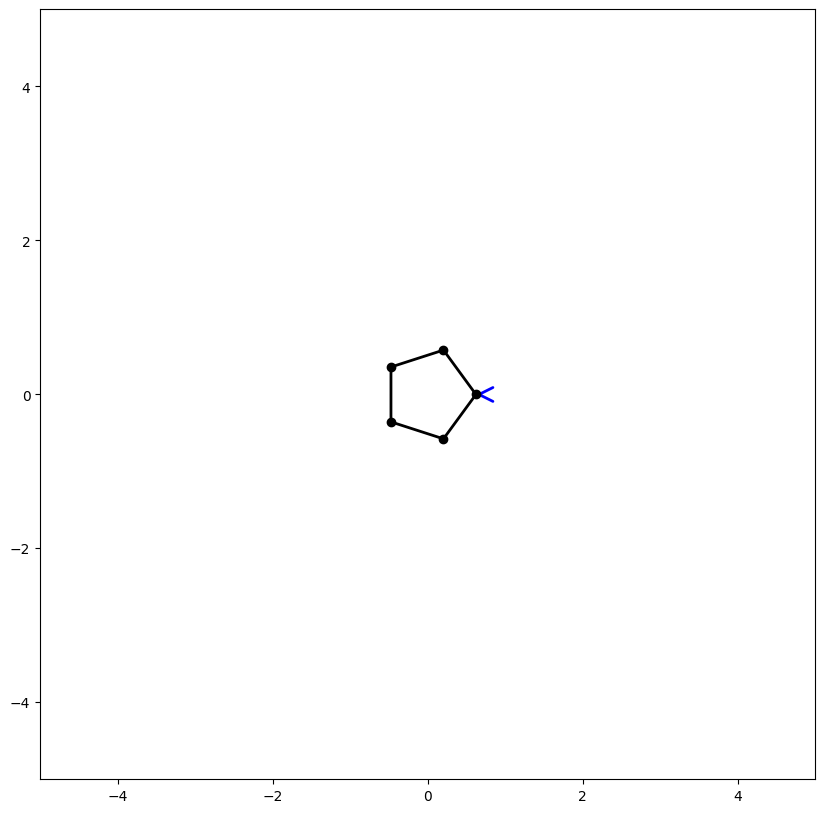

Iteration  169000 ff =  2.4580905233934452e-31 vv =  1.080093003180946e-31 power =  1.6294067556944308e-31


<Figure size 640x480 with 0 Axes>

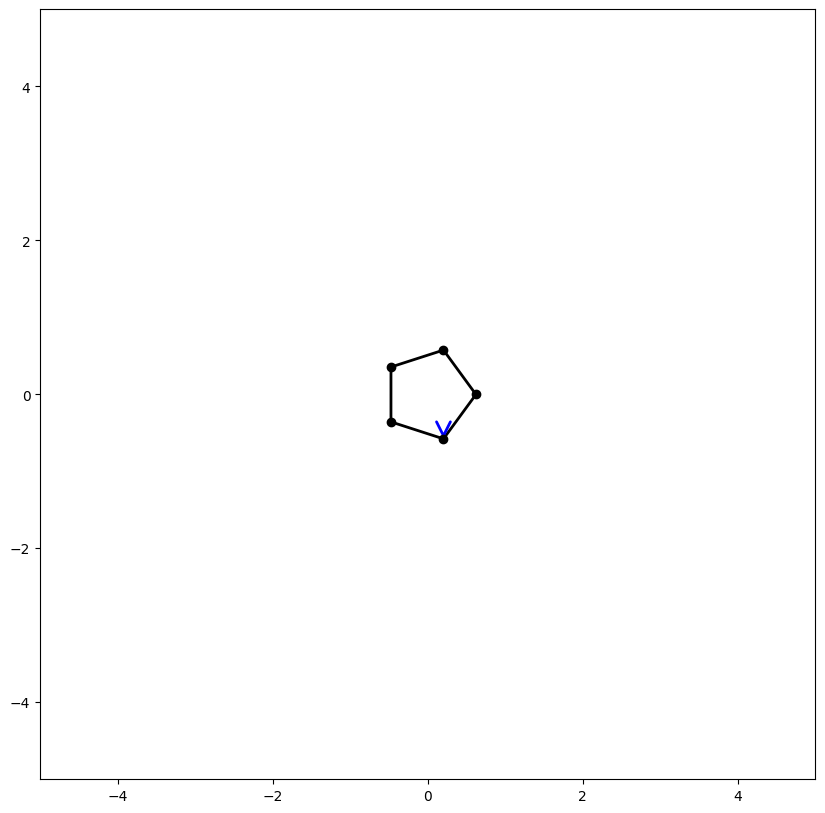

Iteration  170000 ff =  1.0150734971903775e-30 vv =  4.0237123640403655e-31 power =  6.3909027383106186e-31


<Figure size 640x480 with 0 Axes>

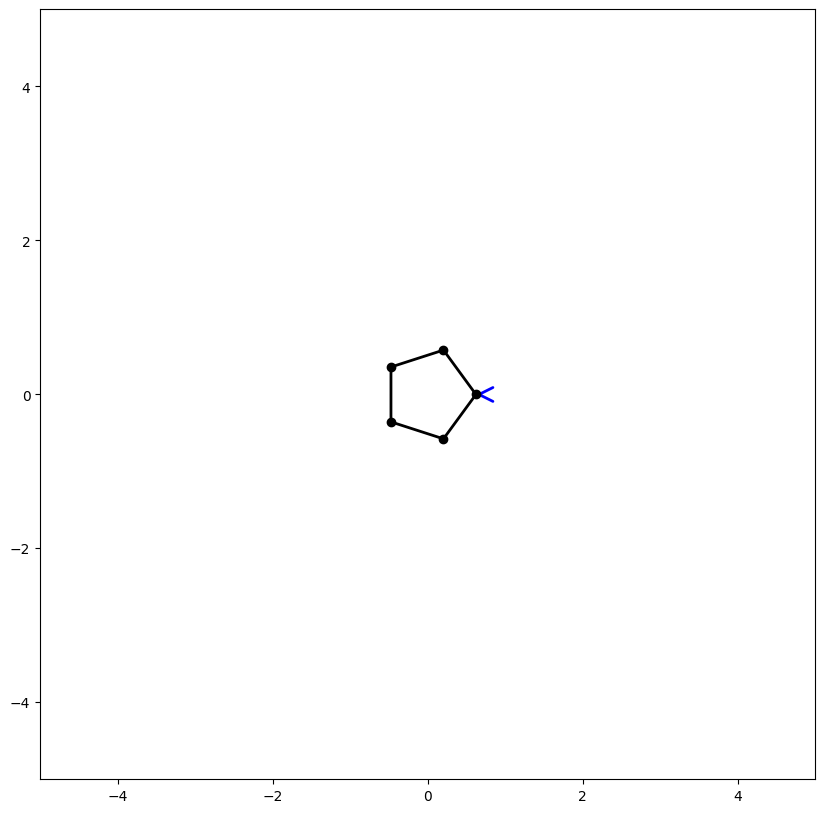

Iteration  171000 ff =  2.4580905233934452e-31 vv =  2.85023633616467e-31 power =  2.646911205038437e-31


<Figure size 640x480 with 0 Axes>

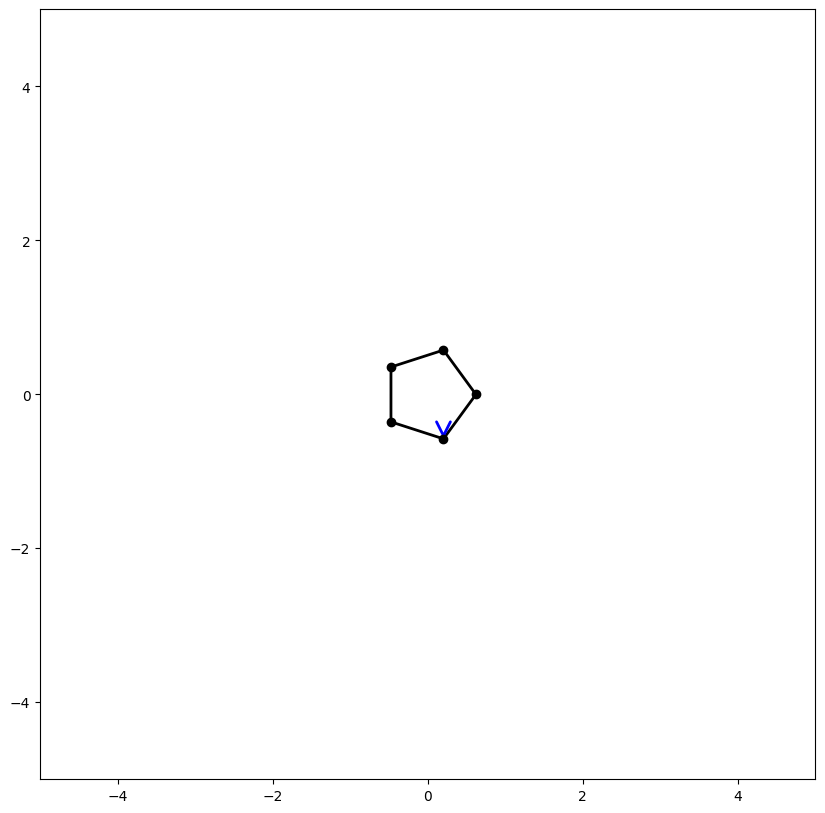

Iteration  172000 ff =  1.0150734971903775e-30 vv =  1.090638248202114e-30 power =  1.0521777325015517e-30


<Figure size 640x480 with 0 Axes>

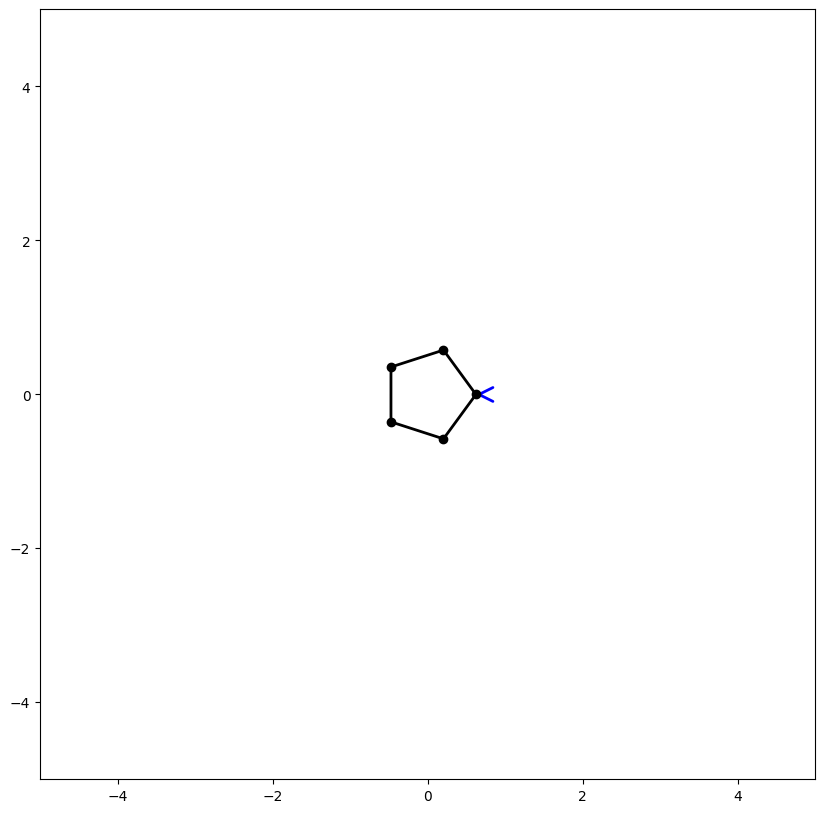

Iteration  173000 ff =  2.4580905233934452e-31 vv =  6.053001239201554e-31 power =  3.8573079970583263e-31


<Figure size 640x480 with 0 Axes>

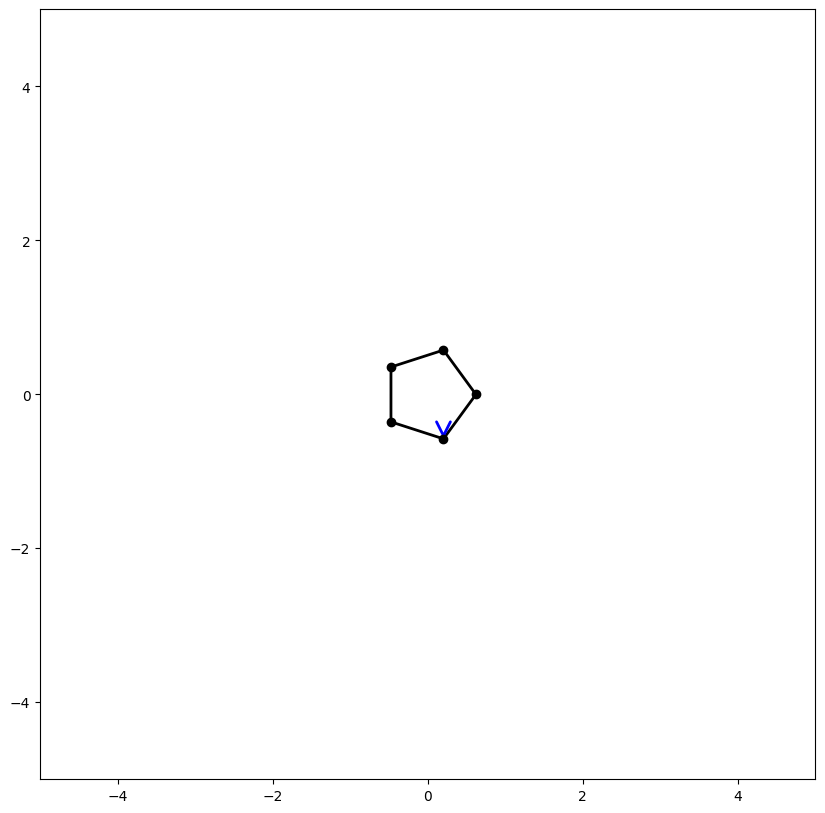

Iteration  174000 ff =  1.0150734971903775e-30 vv =  2.3468044876041146e-30 power =  1.5434309308985554e-30


<Figure size 640x480 with 0 Axes>

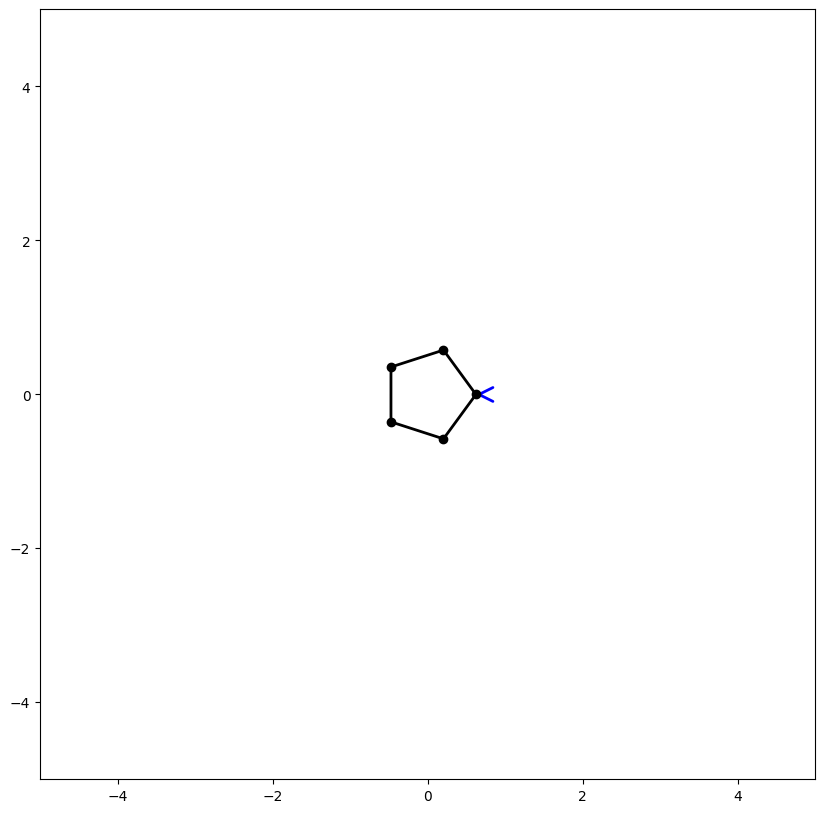

Iteration  175000 ff =  2.4580905233934452e-31 vv =  1.0999576905872905e-30 power =  5.199803434137061e-31


<Figure size 640x480 with 0 Axes>

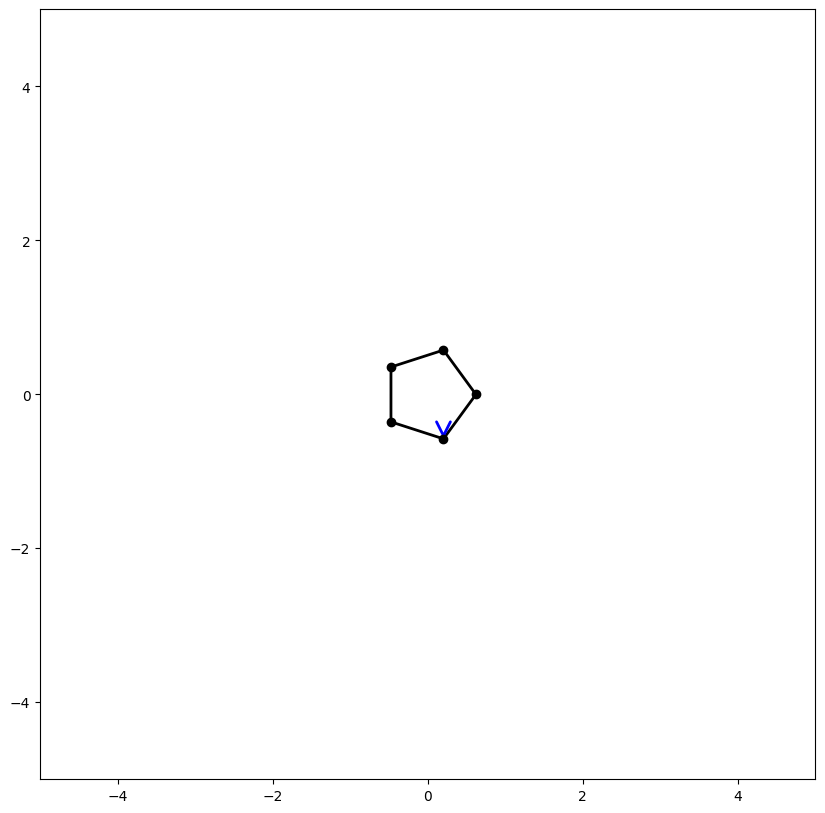

Iteration  176000 ff =  2.4580905233934452e-31 vv =  1.3826759194088132e-33 power =  1.843567892545084e-32


<Figure size 640x480 with 0 Axes>

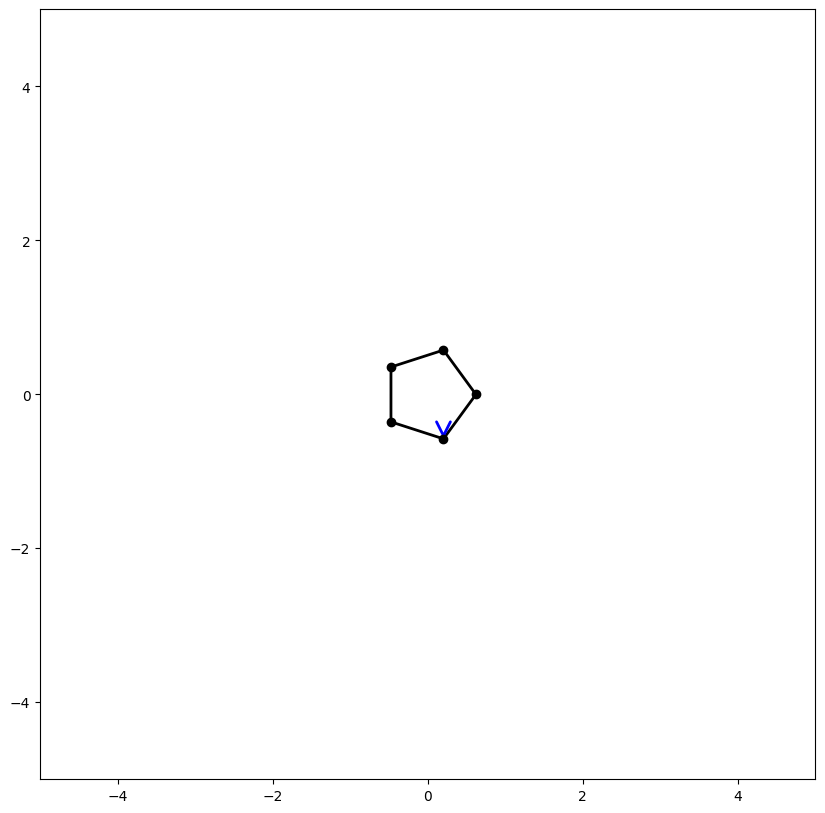

Iteration  177000 ff =  1.0150734971903775e-30 vv =  2.5376837429759438e-33 power =  5.075367485951889e-32


<Figure size 640x480 with 0 Axes>

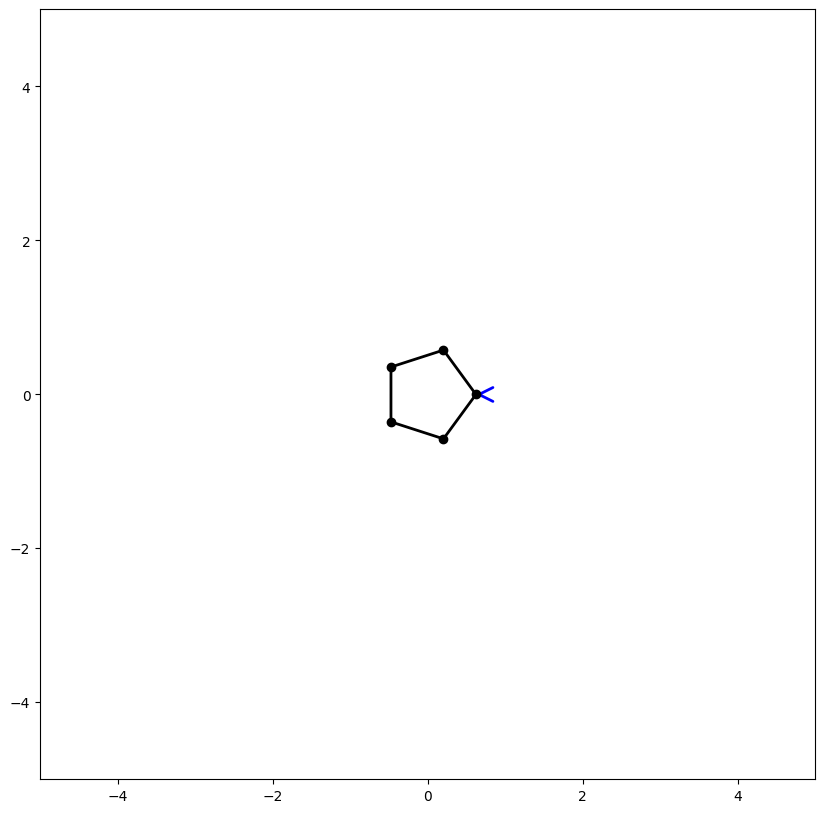

Iteration  178000 ff =  2.4580905233934452e-31 vv =  3.4659137832110675e-32 power =  9.230129915342389e-32


<Figure size 640x480 with 0 Axes>

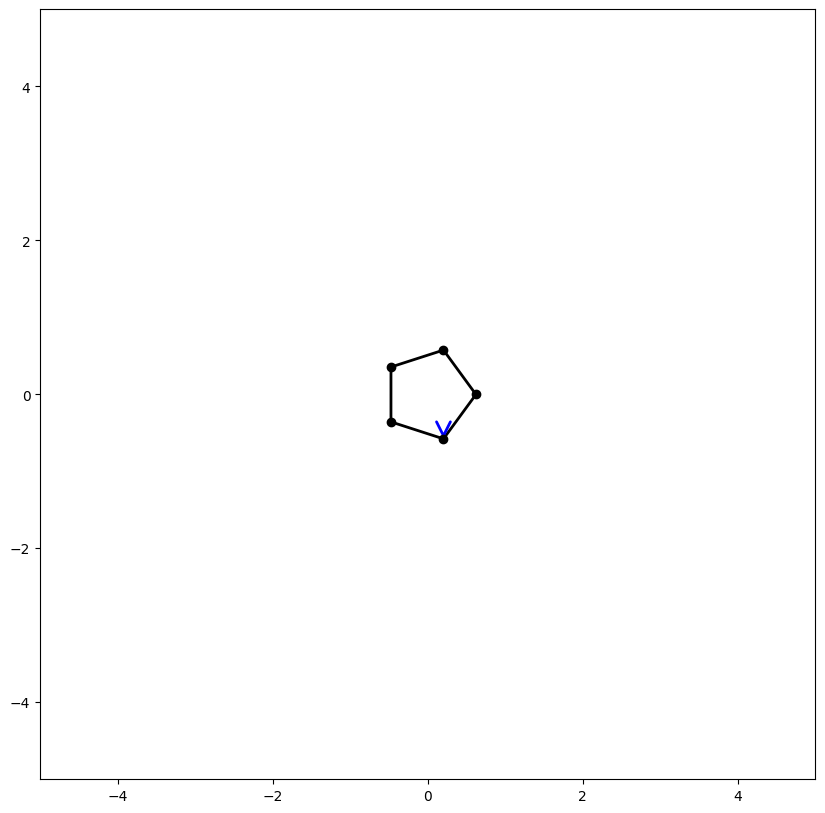

Iteration  179000 ff =  1.0150734971903775e-30 vv =  1.2099428662344363e-31 power =  3.504541249049779e-31


<Figure size 640x480 with 0 Axes>

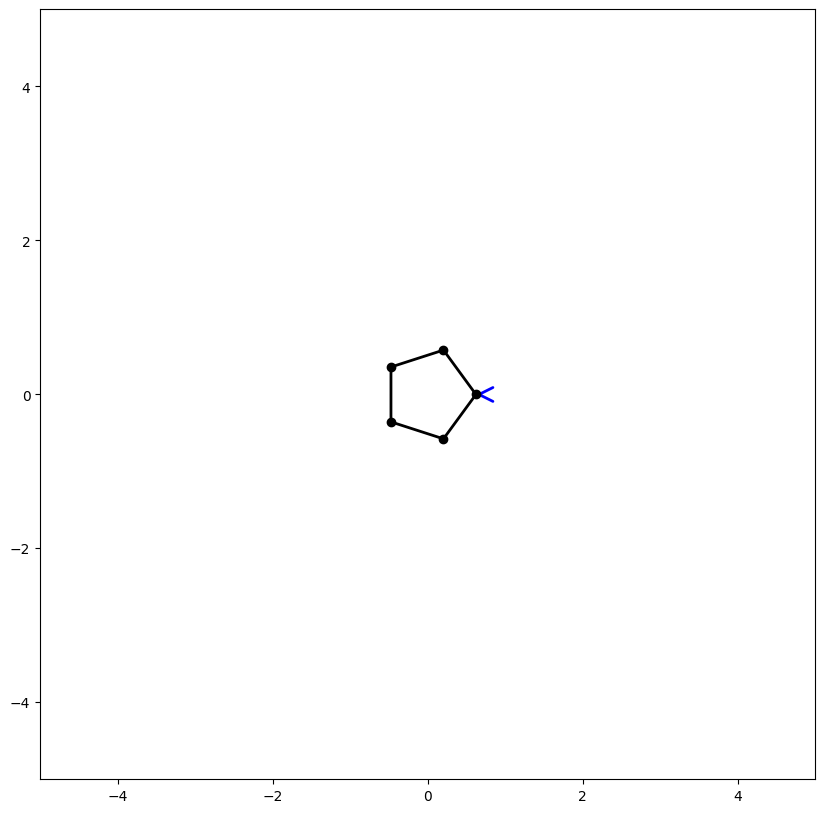

Iteration  180000 ff =  2.4580905233934452e-31 vv =  1.3198132685218938e-31 power =  1.8011719762428565e-31


<Figure size 640x480 with 0 Axes>

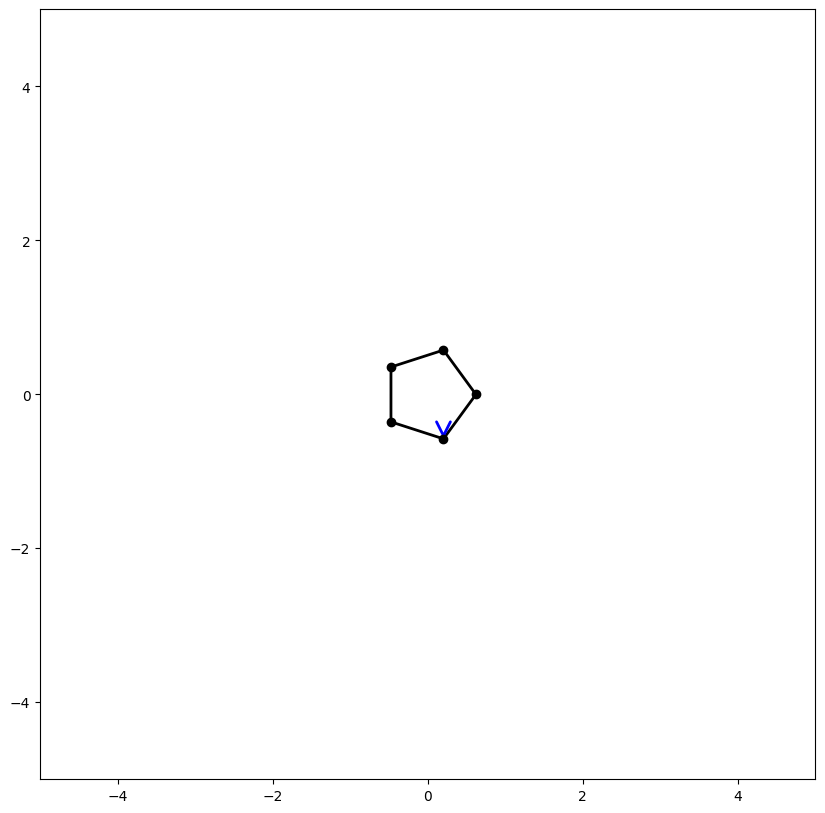

Iteration  181000 ff =  1.0150734971903775e-30 vv =  4.919298134003411e-31 power =  7.066434150690815e-31


<Figure size 640x480 with 0 Axes>

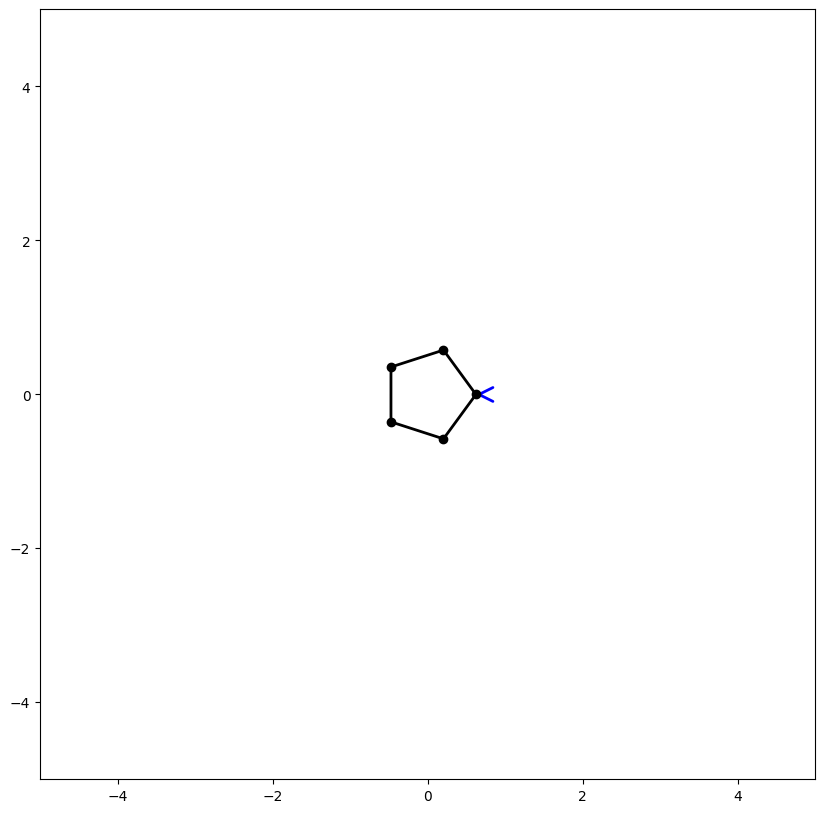

Iteration  182000 ff =  2.4580905233934452e-31 vv =  3.292463167050553e-31 power =  2.8448501734799555e-31


<Figure size 640x480 with 0 Axes>

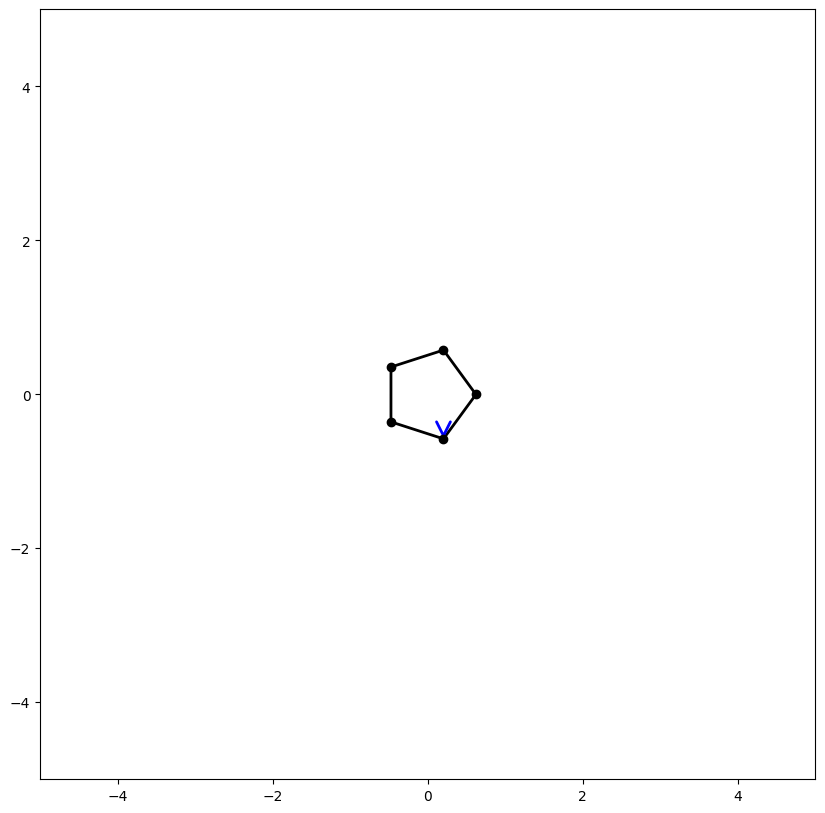

Iteration  183000 ff =  1.0150734971903775e-30 vv =  1.2666746222736837e-30 power =  1.1339170333995555e-30


<Figure size 640x480 with 0 Axes>

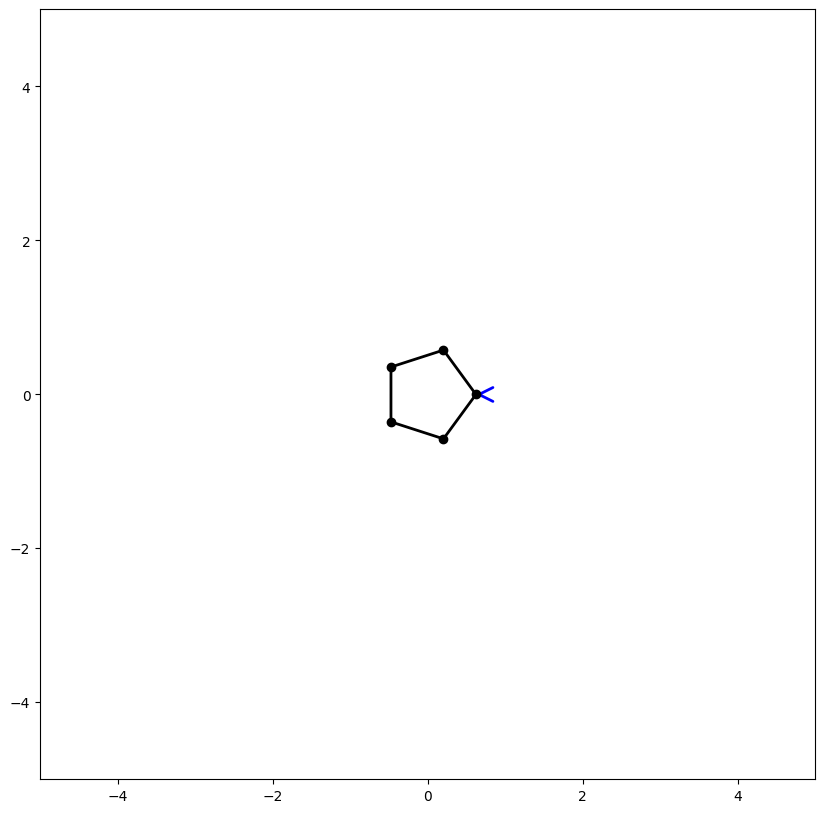

Iteration  184000 ff =  2.4580905233934452e-31 vv =  6.828017931264766e-31 power =  4.0968141488725655e-31


<Figure size 640x480 with 0 Axes>

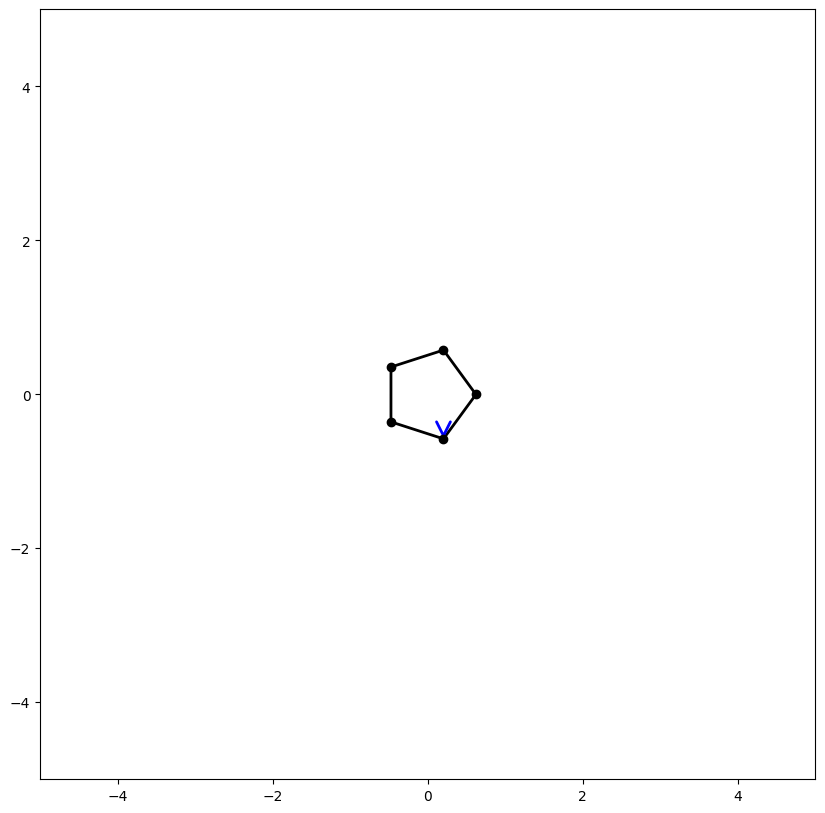

Iteration  185000 ff =  1.0150734971903775e-30 vv =  2.657212362166028e-30 power =  1.6423354849851395e-30


<Figure size 640x480 with 0 Axes>

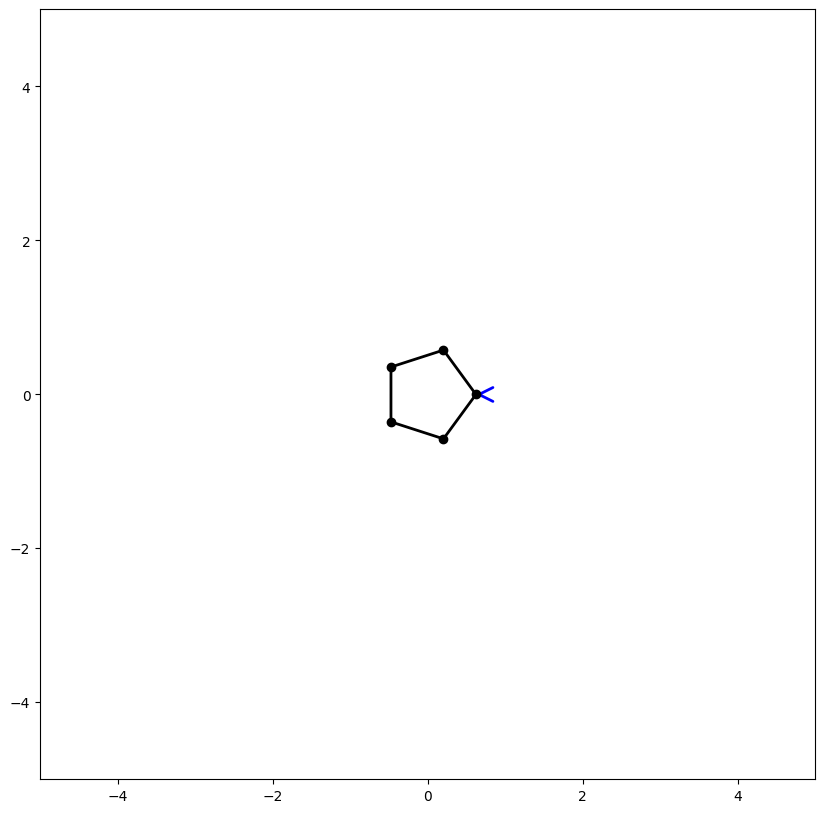

Iteration  186000 ff =  2.4580905233934452e-31 vv =  1.2064118497934251e-30 power =  5.4456124864764064e-31


<Figure size 640x480 with 0 Axes>

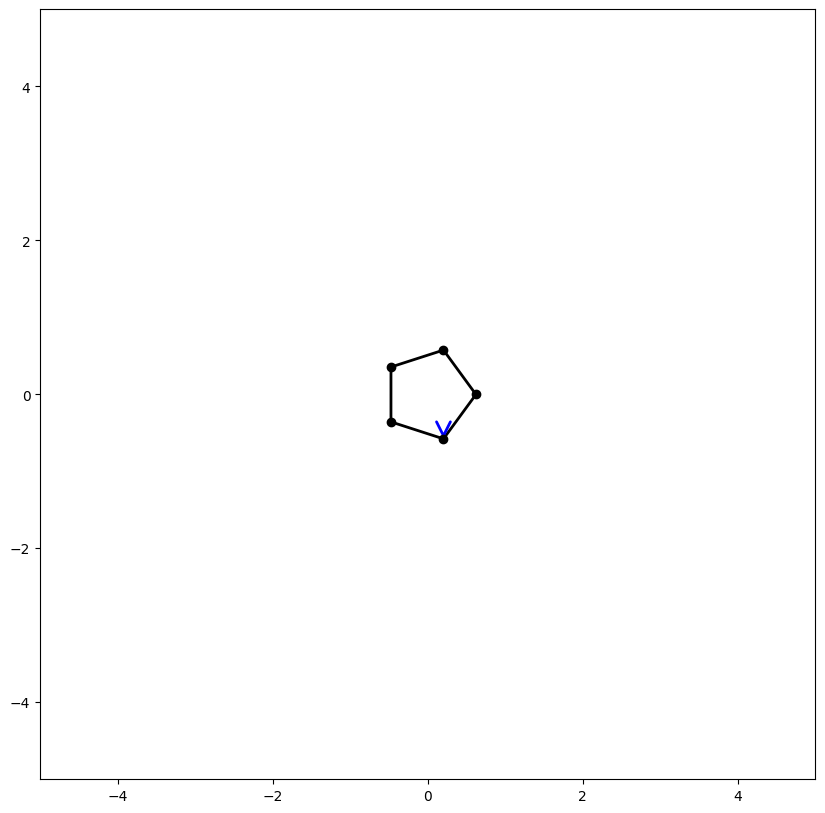

Iteration  187000 ff =  2.4580905233934452e-31 vv =  3.84076644280226e-33 power =  3.0726131542418076e-32


<Figure size 640x480 with 0 Axes>

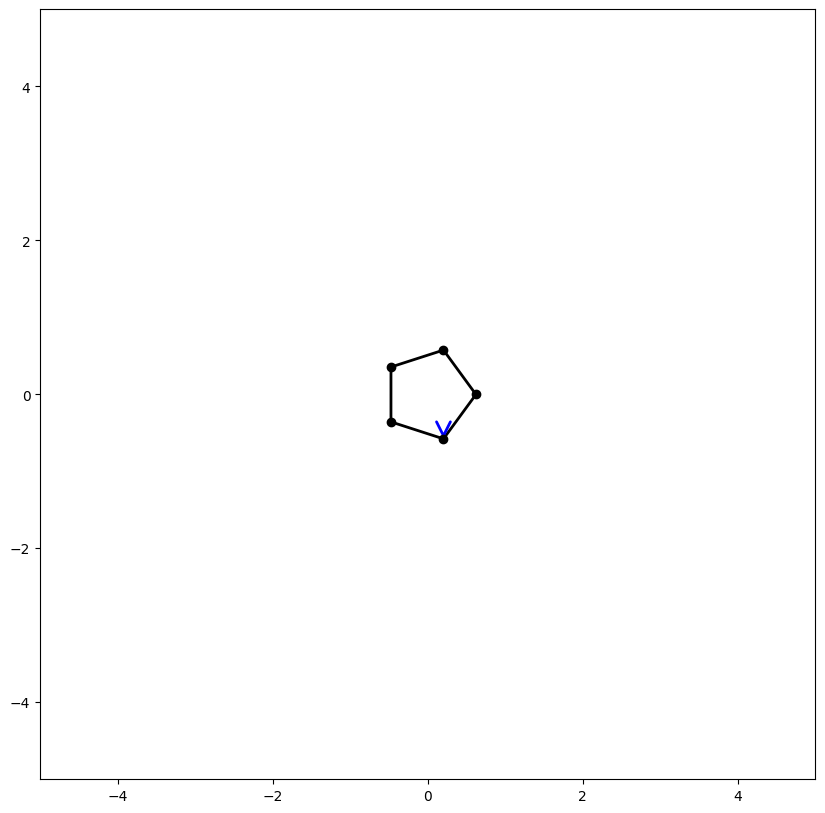

Iteration  188000 ff =  1.0150734971903775e-30 vv =  1.0150734971903775e-32 power =  1.0150734971903777e-31


<Figure size 640x480 with 0 Axes>

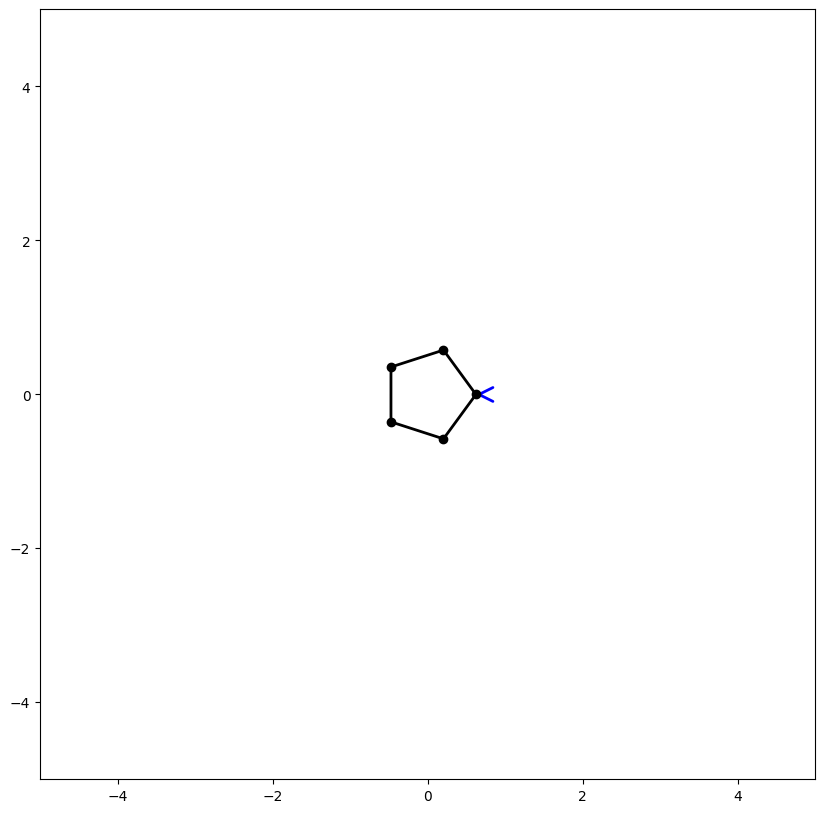

Iteration  189000 ff =  2.4580905233934452e-31 vv =  4.6727317613500046e-32 power =  1.0717274681995422e-31


<Figure size 640x480 with 0 Axes>

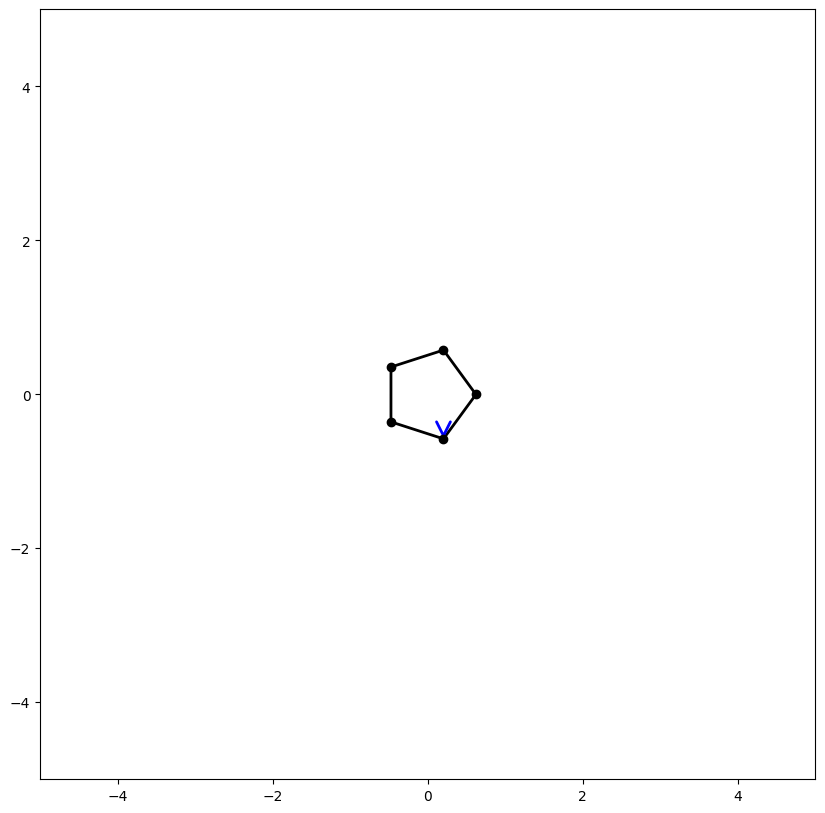

Iteration  190000 ff =  1.0150734971903775e-30 vv =  1.6711465850503704e-31 power =  4.118660714849957e-31


<Figure size 640x480 with 0 Axes>

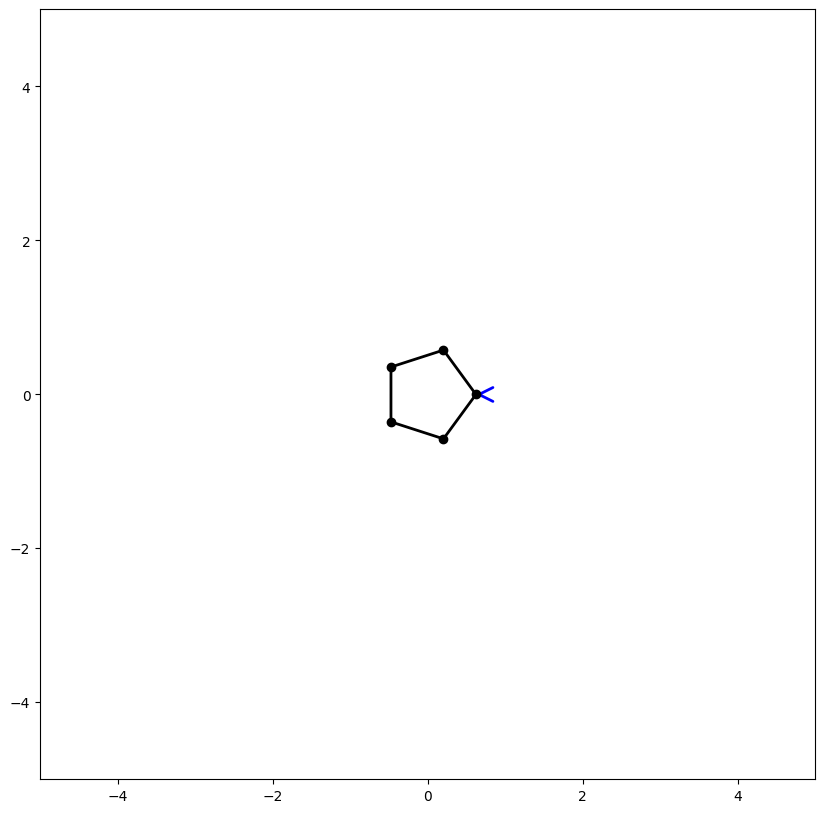

Iteration  191000 ff =  2.4580905233934452e-31 vv =  1.5966956959133935e-31 power =  1.9811164930078737e-31


<Figure size 640x480 with 0 Axes>

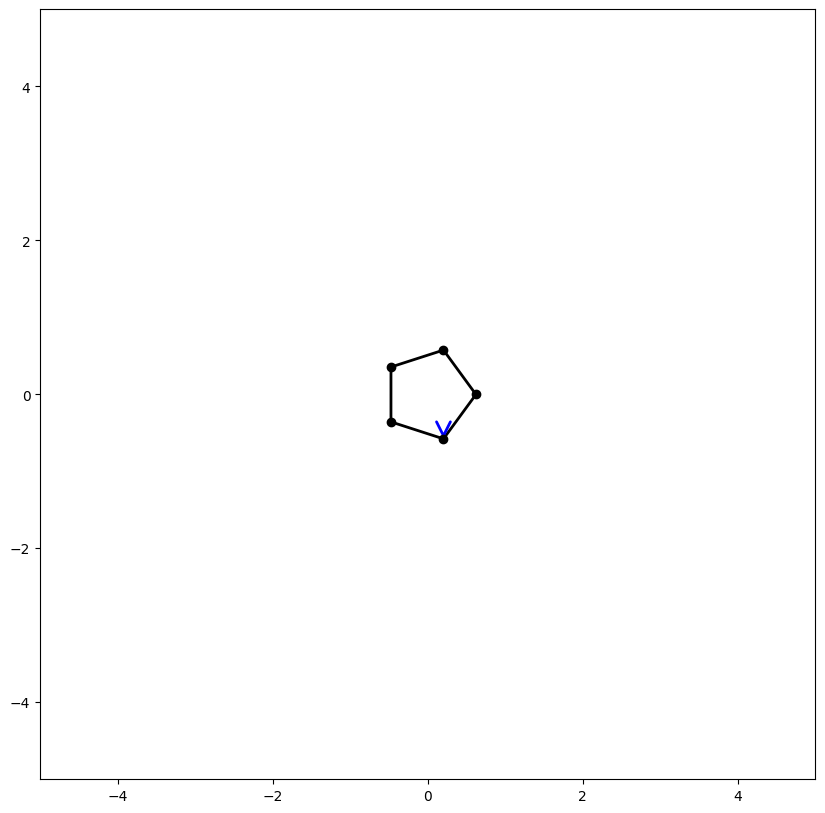

Iteration  192000 ff =  1.0150734971903775e-30 vv =  6.008292262753675e-31 power =  7.80951870430903e-31


<Figure size 640x480 with 0 Axes>

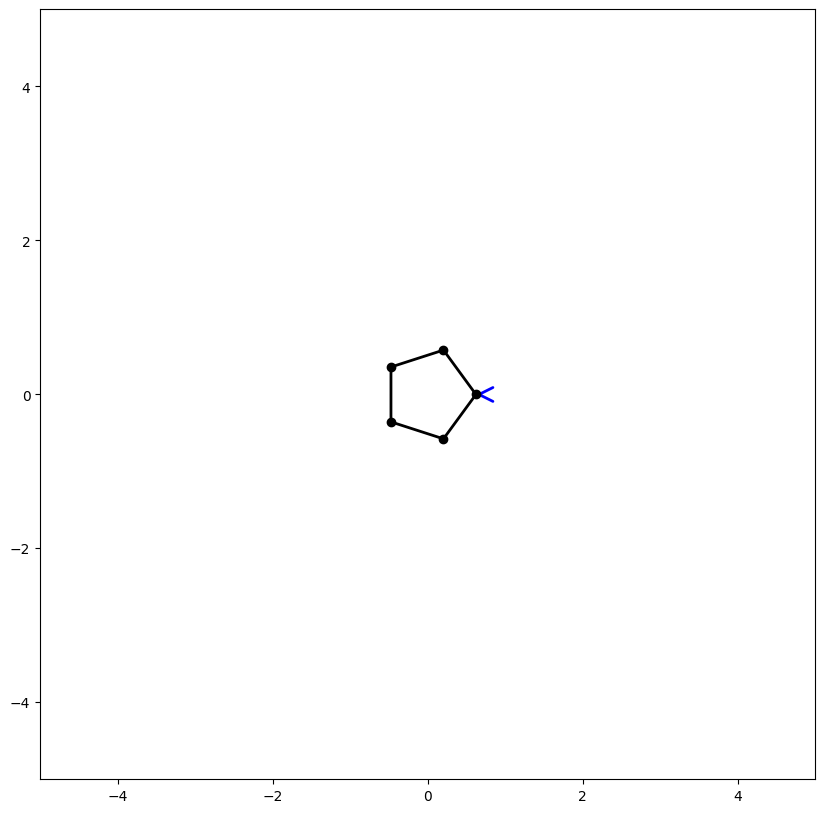

Iteration  193000 ff =  2.4580905233934452e-31 vv =  3.8157320814965044e-31 power =  3.0625830387656277e-31


<Figure size 640x480 with 0 Axes>

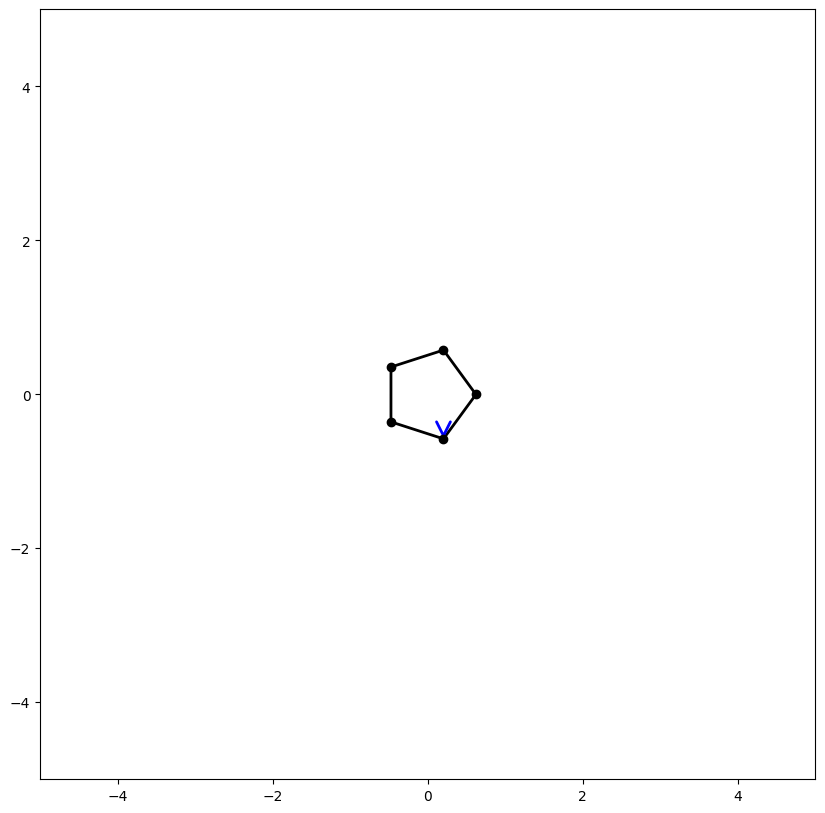

Iteration  194000 ff =  1.0150734971903775e-30 vv =  1.465680781154112e-30 power =  1.2197432993424597e-30


<Figure size 640x480 with 0 Axes>

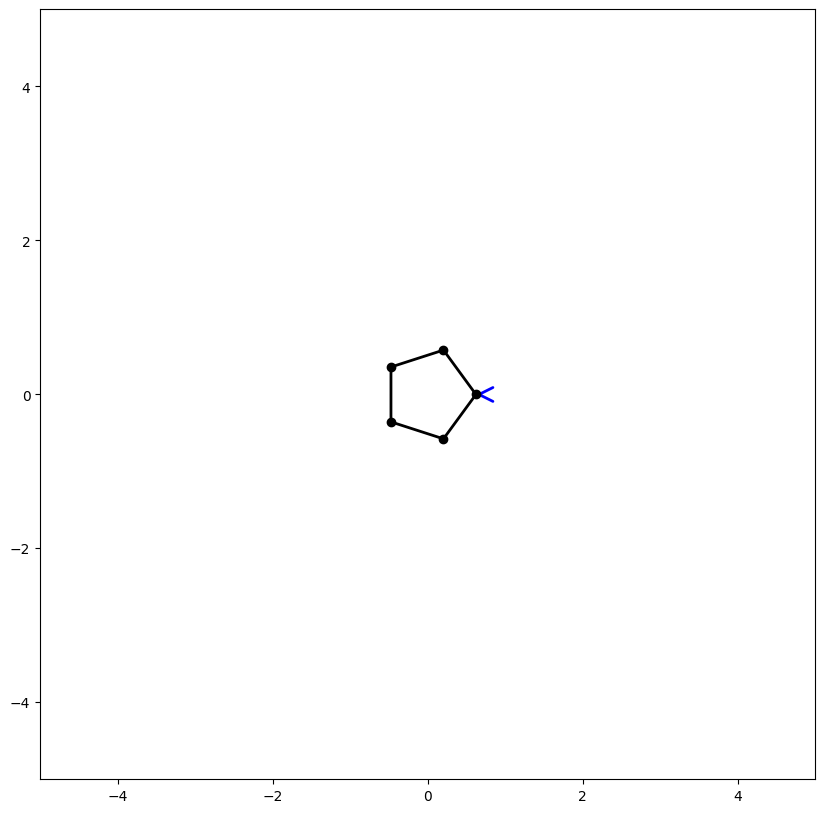

Iteration  195000 ff =  2.4580905233934452e-31 vv =  7.660830591092658e-31 power =  4.339471750949357e-31


<Figure size 640x480 with 0 Axes>

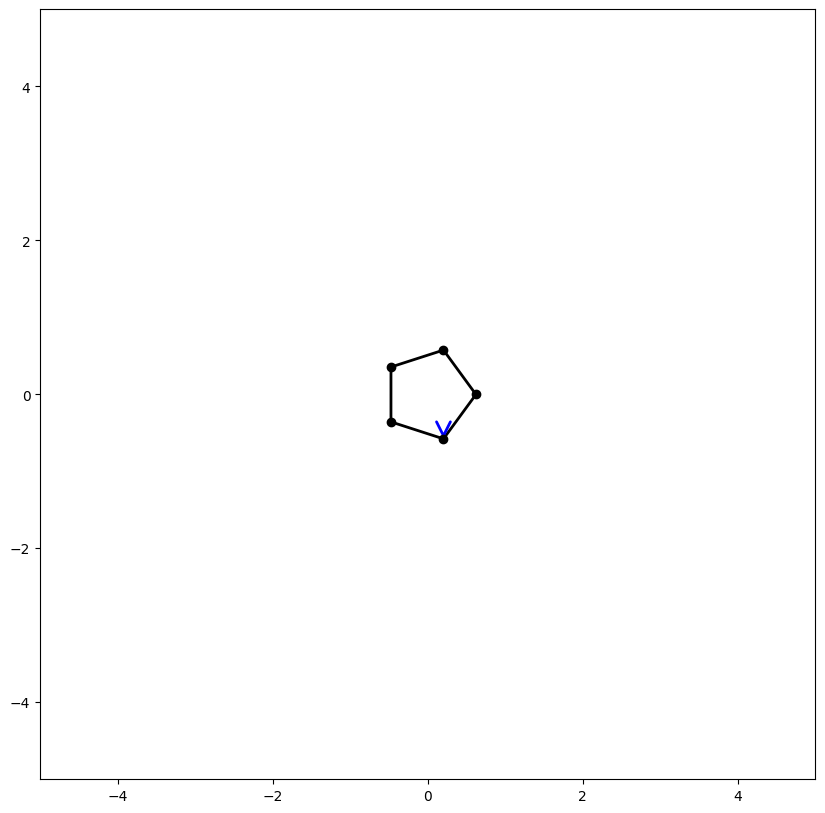

Iteration  196000 ff =  1.0150734971903775e-30 vv =  2.9868939363095826e-30 power =  1.7412400390717243e-30


<Figure size 640x480 with 0 Axes>

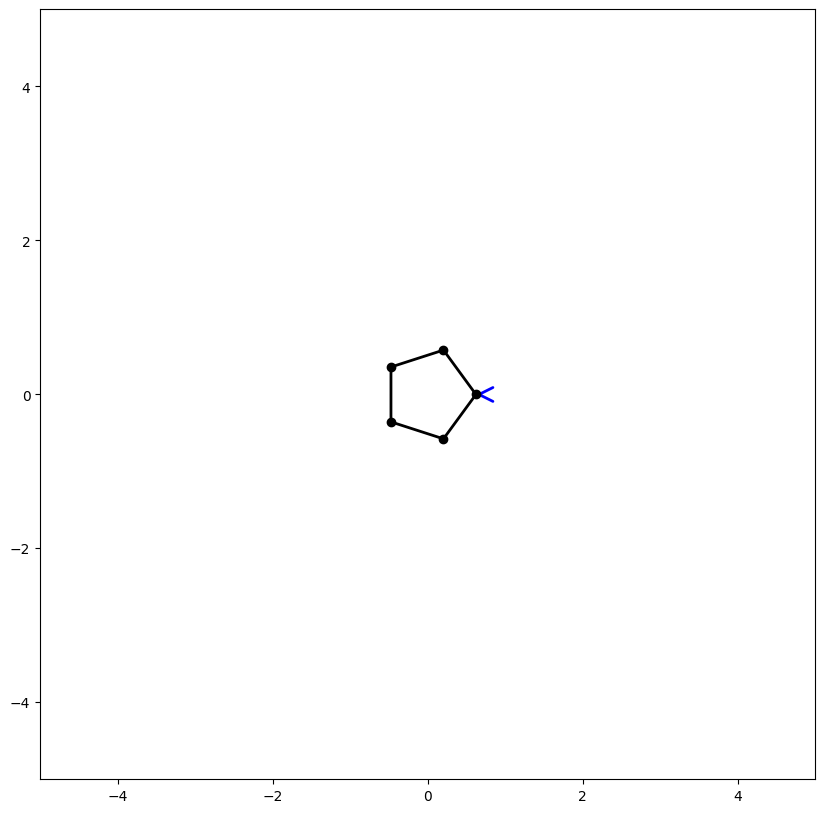

Iteration  197000 ff =  2.4580905233934452e-31 vv =  1.3177821900463467e-30 power =  5.6914215388157515e-31


<Figure size 640x480 with 0 Axes>

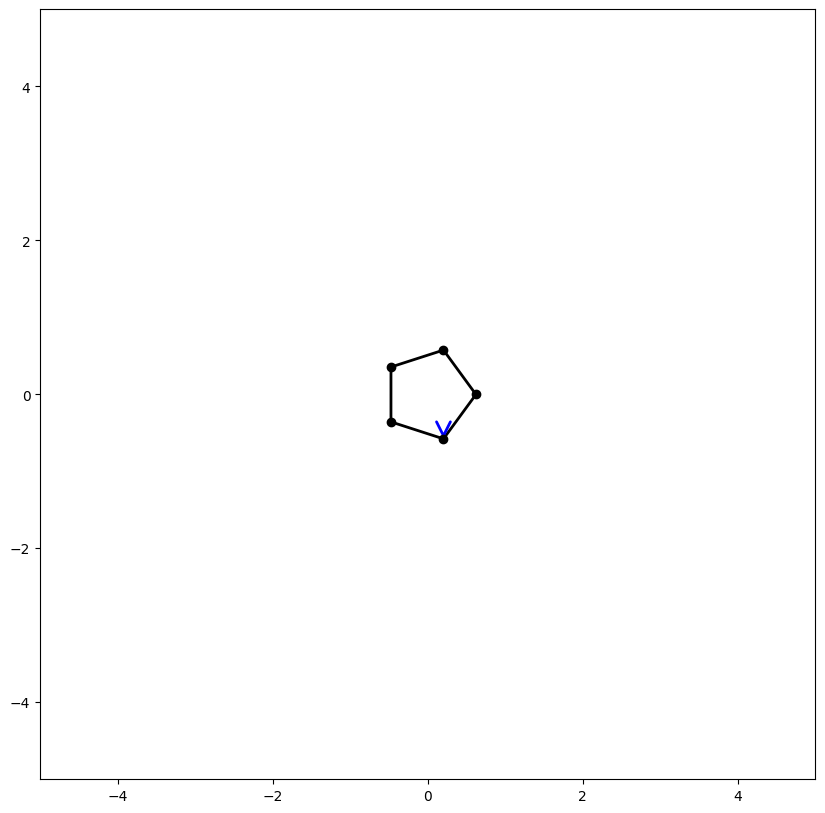

Iteration  198000 ff =  2.4580905233934452e-31 vv =  7.744521455266476e-33 power =  4.363110679023366e-32


<Figure size 640x480 with 0 Axes>

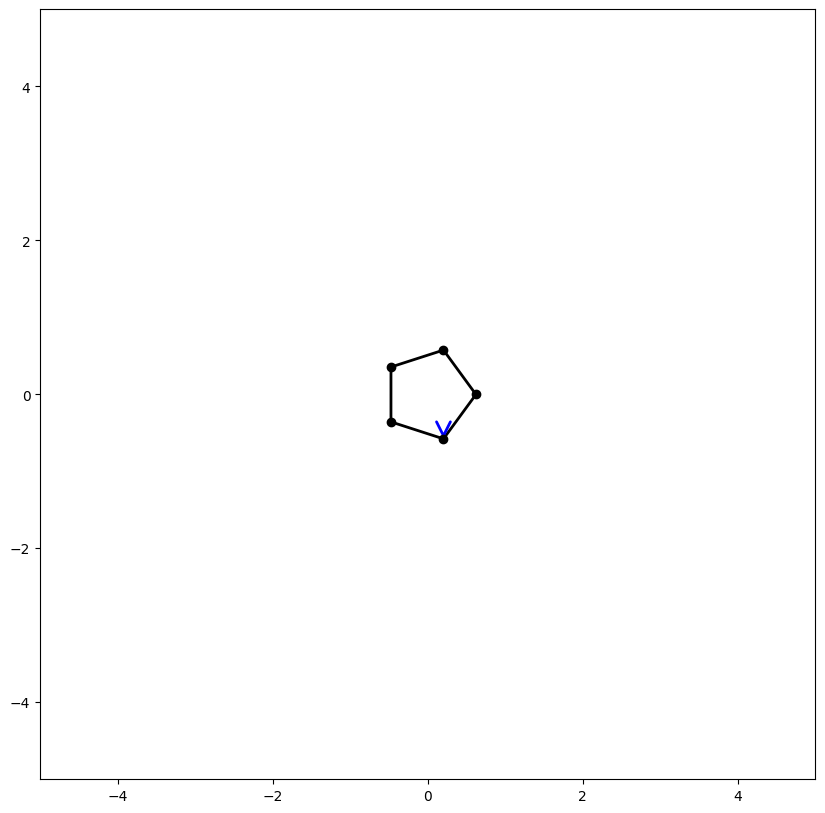

Iteration  199000 ff =  1.0150734971903775e-30 vv =  2.2839153686783496e-32 power =  1.5226102457855664e-31


<Figure size 640x480 with 0 Axes>

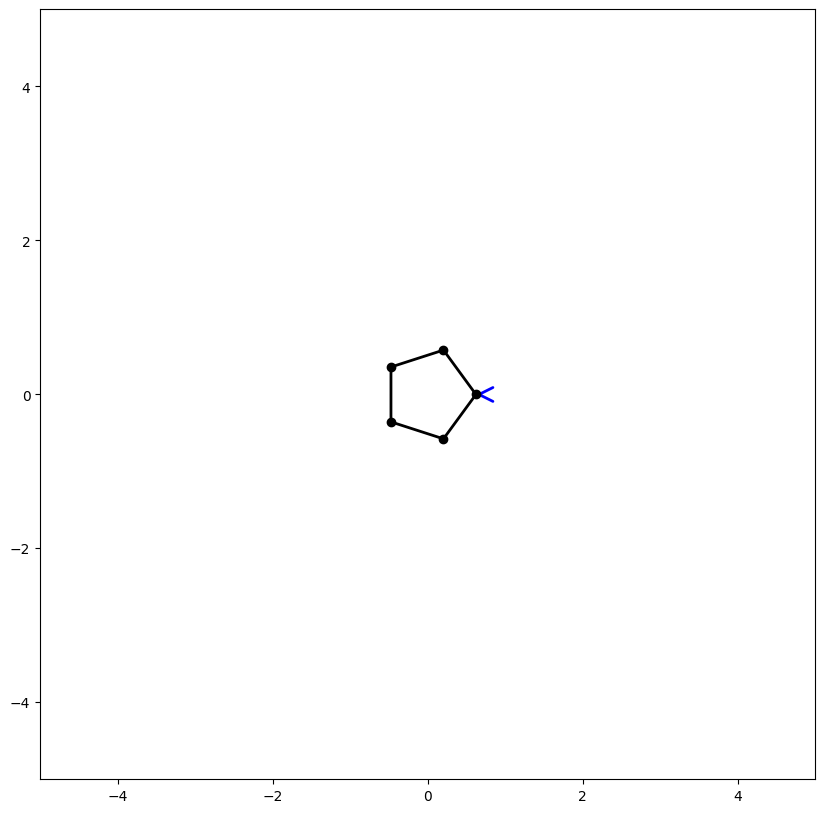

Iteration  200000 ff =  2.4580905233934452e-31 vv =  6.059494256253959e-32 power =  1.2204419448648457e-31


<Figure size 640x480 with 0 Axes>

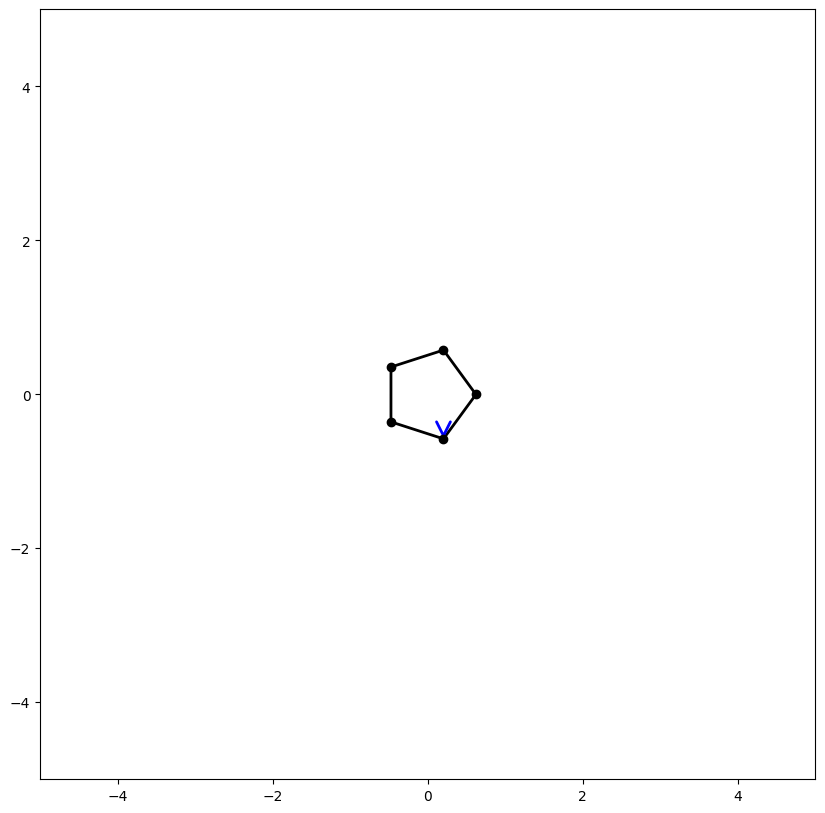

Iteration  201000 ff =  1.0150734971903775e-30 vv =  2.2066587592281258e-31 power =  4.732780180650136e-31


<Figure size 640x480 with 0 Axes>

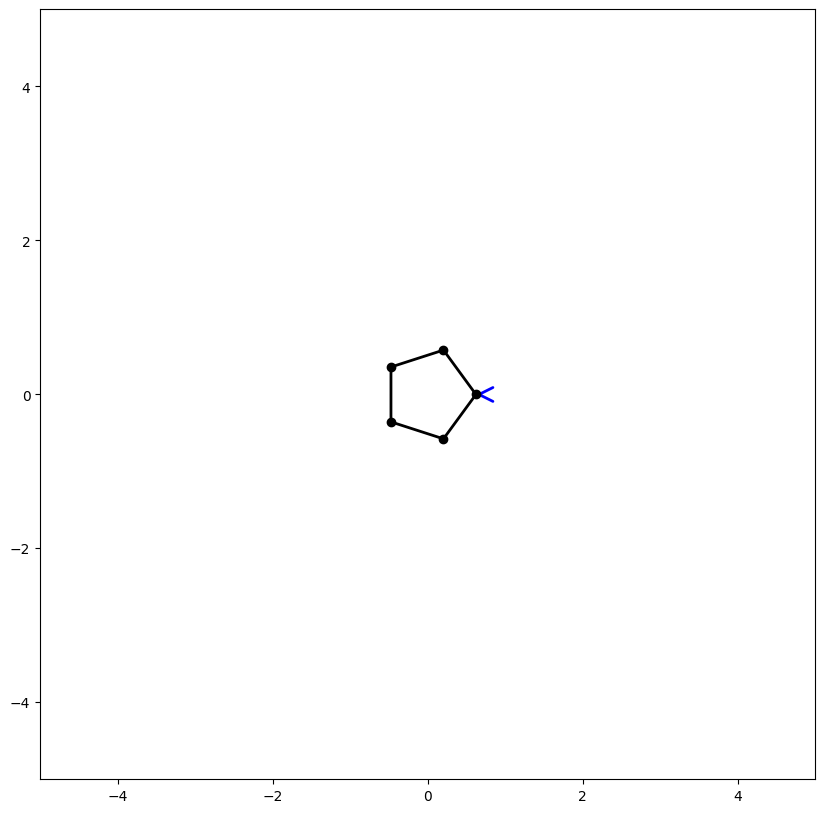

Iteration  202000 ff =  2.4580905233934452e-31 vv =  1.8999238000044595e-31 power =  2.16106100977289e-31


<Figure size 640x480 with 0 Axes>

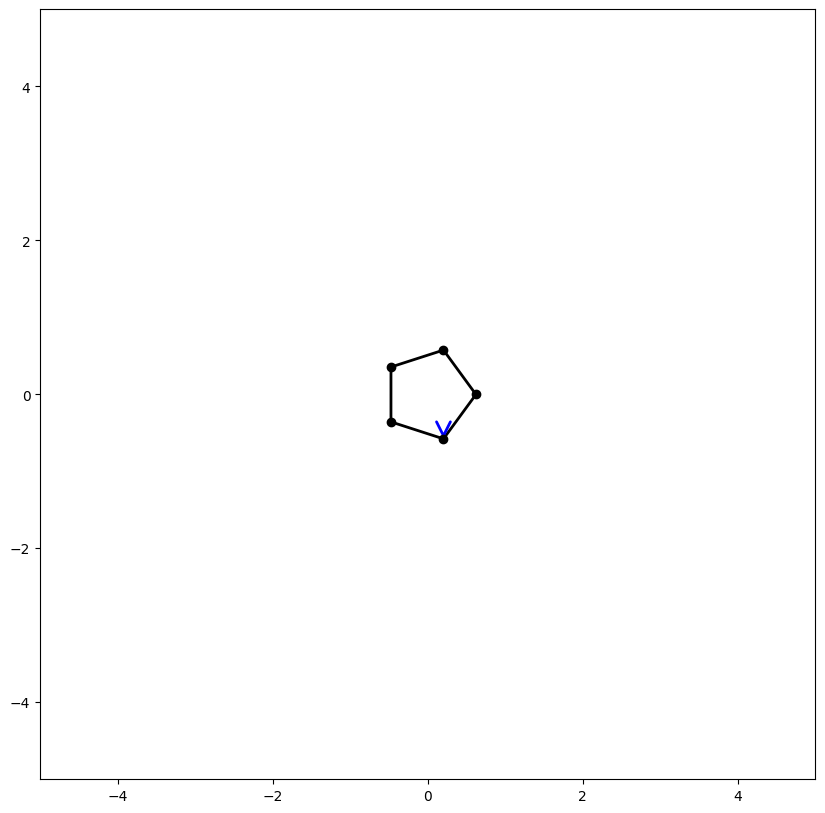

Iteration  203000 ff =  1.0150734971903775e-30 vv =  7.206081400999181e-31 power =  8.552603257927246e-31


<Figure size 640x480 with 0 Axes>

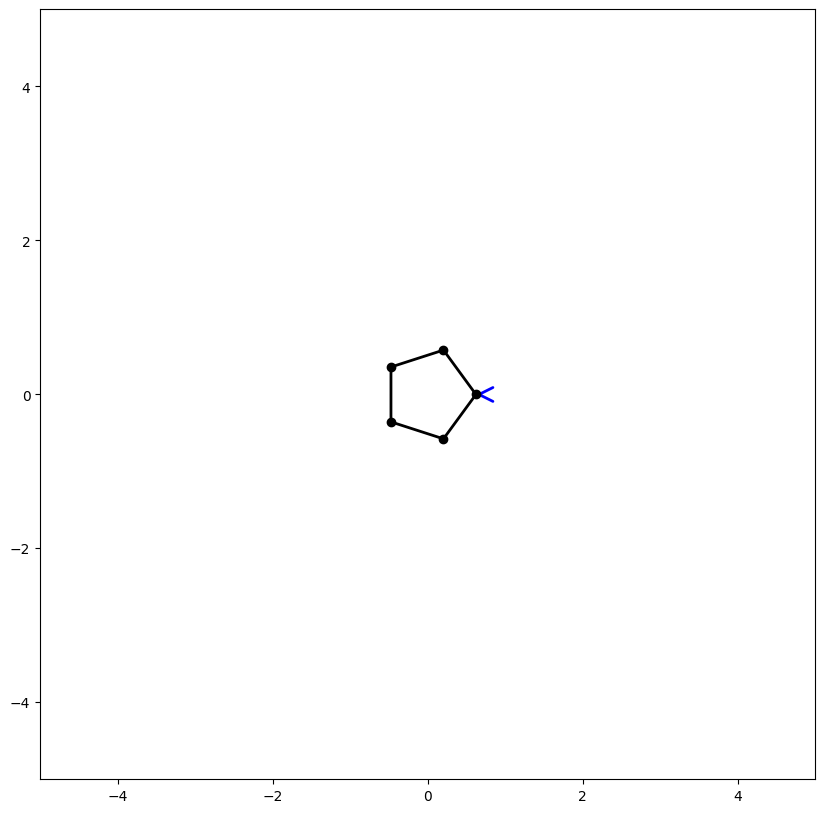

Iteration  204000 ff =  2.4580905233934452e-31 vv =  4.377573701198291e-31 power =  3.280315904051299e-31


<Figure size 640x480 with 0 Axes>

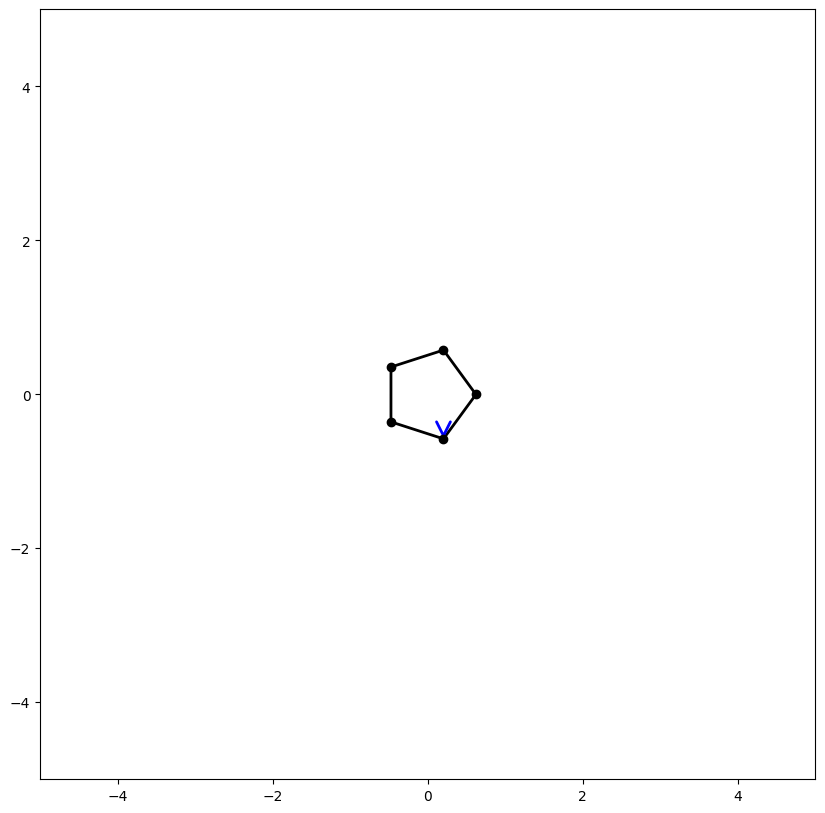

Iteration  205000 ff =  1.0150734971903775e-30 vv =  1.6897300857368543e-30 power =  1.3096565303302638e-30


<Figure size 640x480 with 0 Axes>

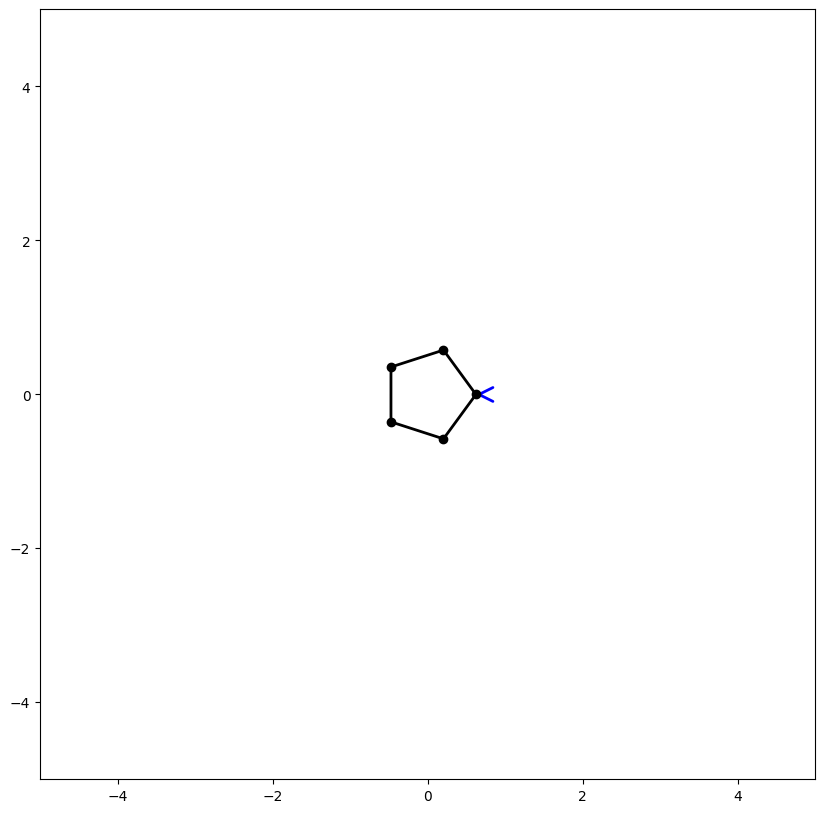

Iteration  206000 ff =  2.4580905233934452e-31 vv =  8.553305846516464e-31 power =  4.585280803288701e-31


<Figure size 640x480 with 0 Axes>

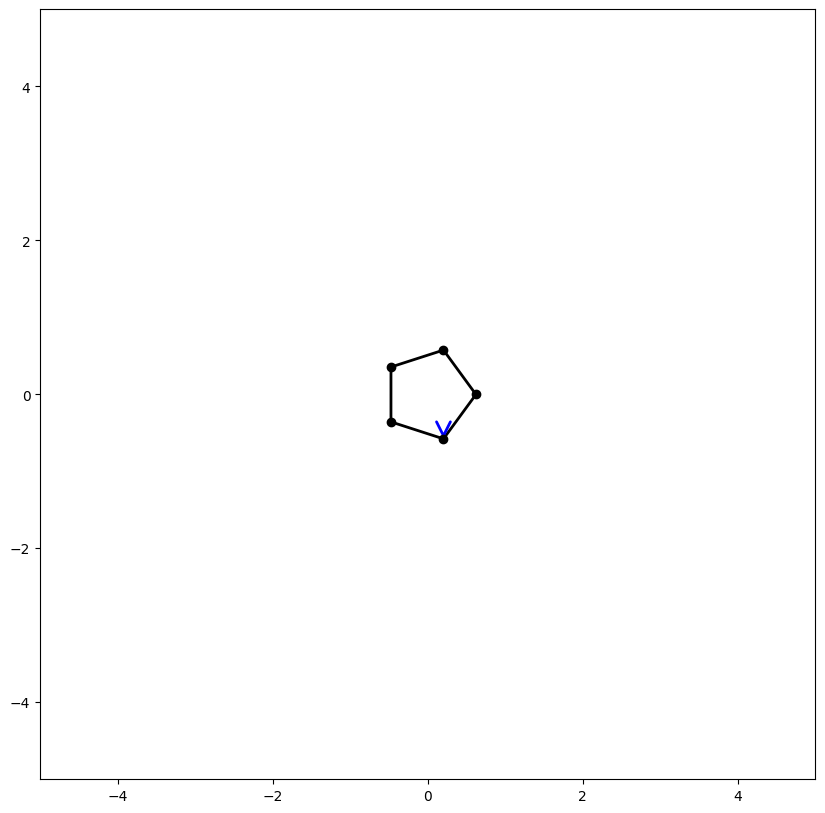

Iteration  207000 ff =  1.0150734971903775e-30 vv =  3.345292679095831e-30 power =  1.842747388790762e-30


<Figure size 640x480 with 0 Axes>

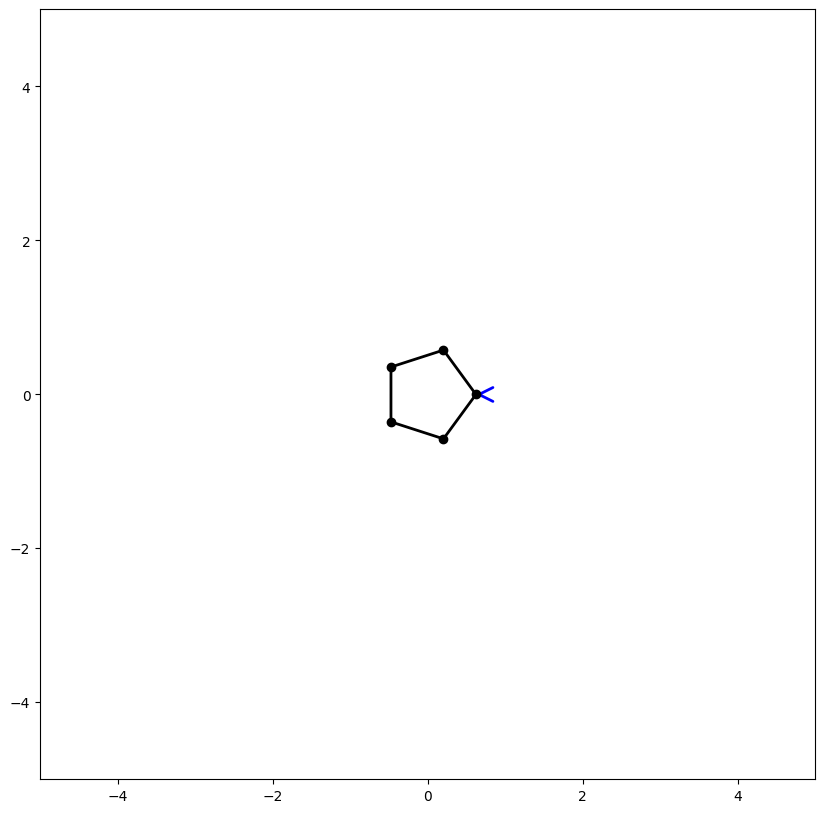

Iteration  208000 ff =  2.4580905233934452e-31 vv =  1.4340687113460547e-30 power =  5.937230591155095e-31


<Figure size 640x480 with 0 Axes>

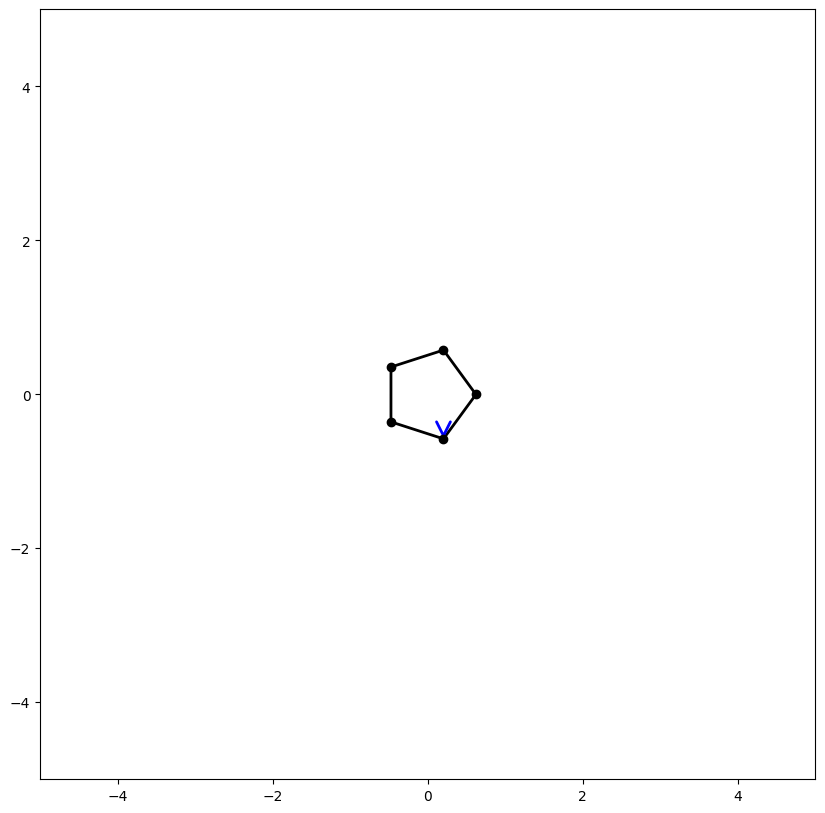

Iteration  209000 ff =  2.4580905233934452e-31 vv =  1.32875155855187e-32 power =  5.715060466889763e-32


<Figure size 640x480 with 0 Axes>

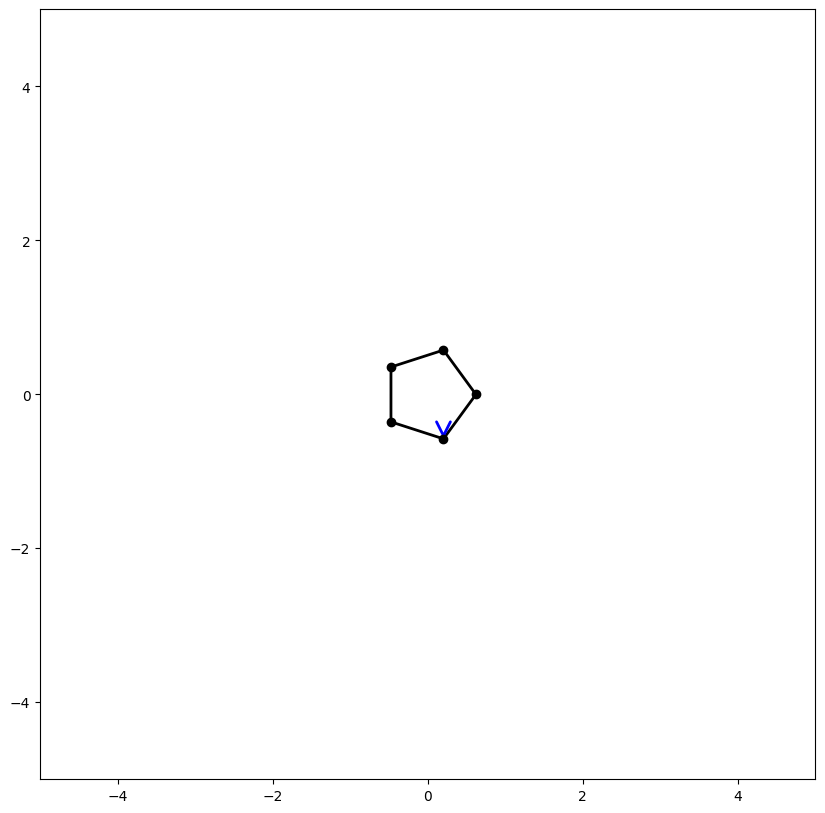

Iteration  210000 ff =  1.0150734971903775e-30 vv =  4.2658463719425627e-32 power =  2.0809006692402744e-31


<Figure size 640x480 with 0 Axes>

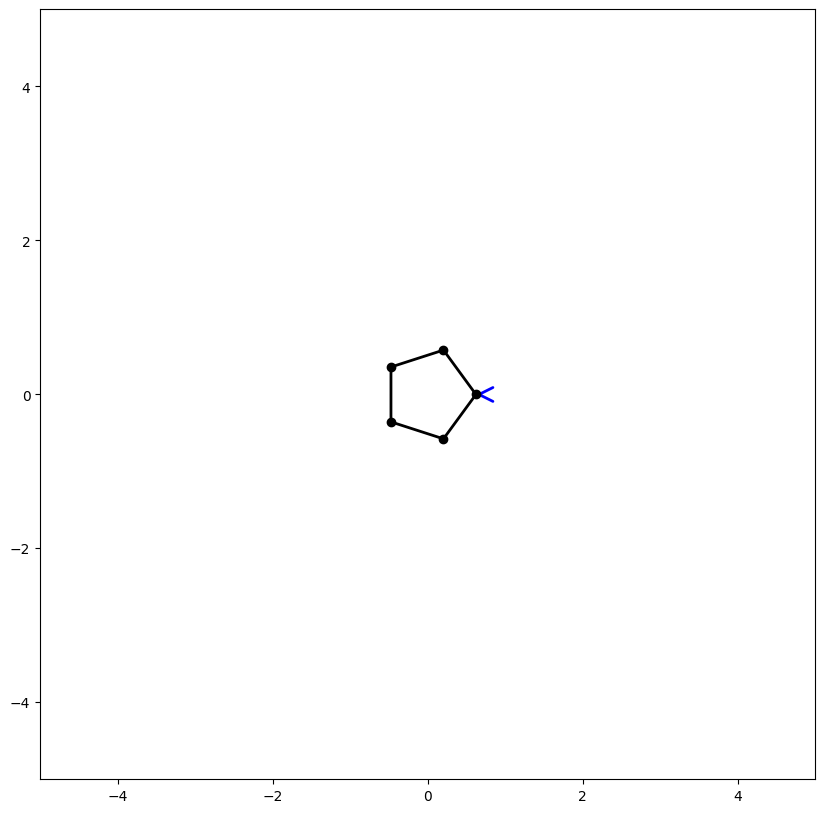

Iteration  211000 ff =  2.4580905233934452e-31 vv =  7.792768917511906e-32 power =  1.3840278691966797e-31


<Figure size 640x480 with 0 Axes>

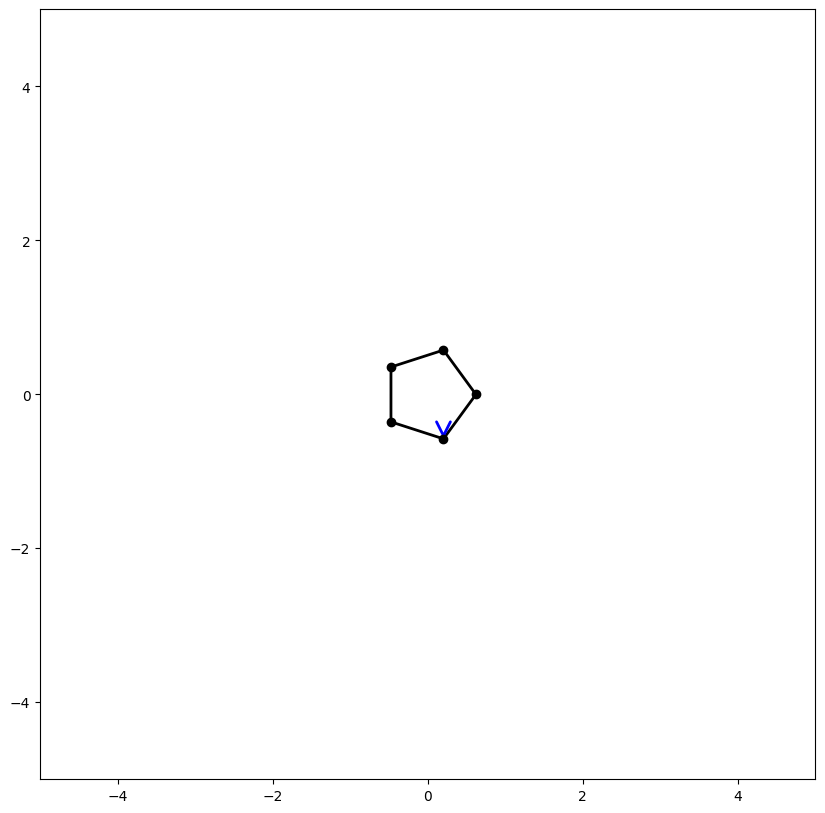

Iteration  212000 ff =  1.0150734971903775e-30 vv =  2.8489210171979305e-31 power =  5.377605619740323e-31


<Figure size 640x480 with 0 Axes>

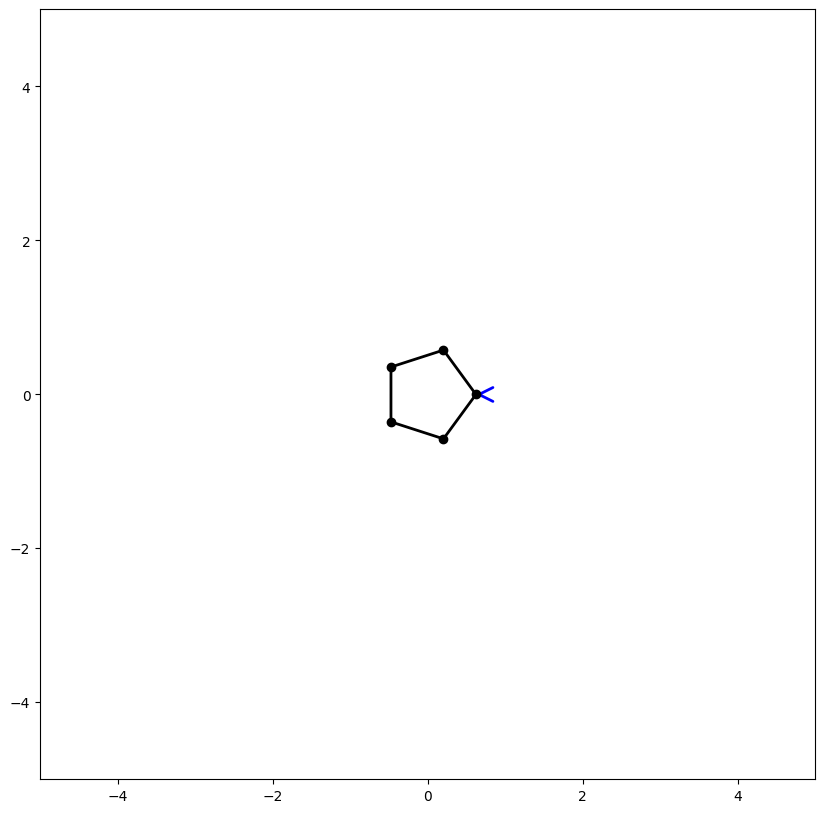

Iteration  213000 ff =  2.4580905233934452e-31 vv =  2.2466678438479865e-31 power =  2.350002752376158e-31


<Figure size 640x480 with 0 Axes>

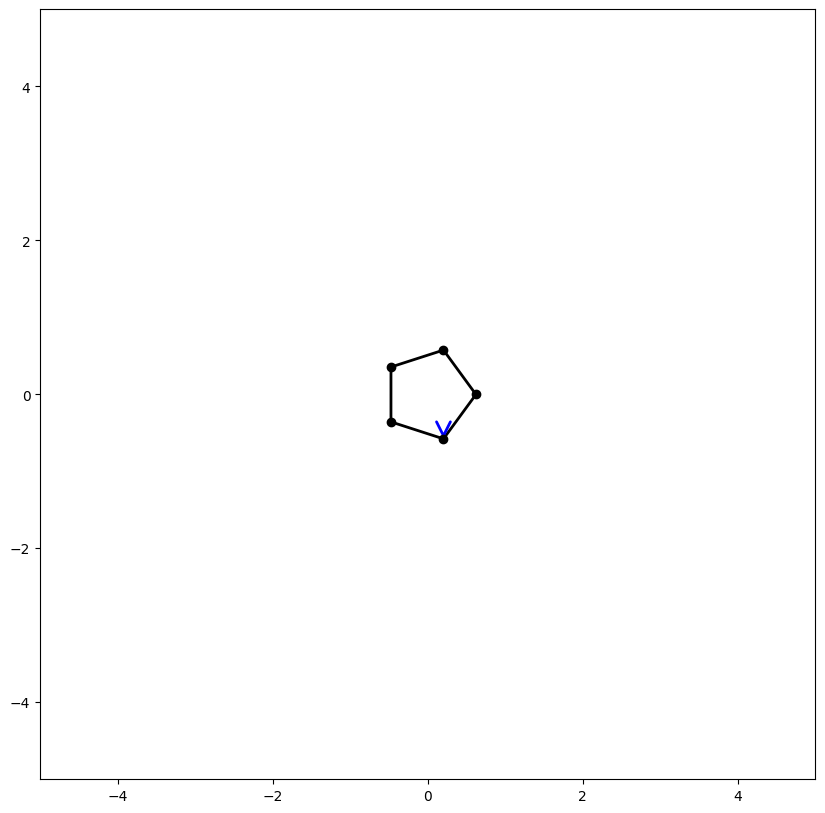

Iteration  214000 ff =  1.0150734971903775e-30 vv =  8.512665548739932e-31 power =  9.295687811545463e-31


<Figure size 640x480 with 0 Axes>

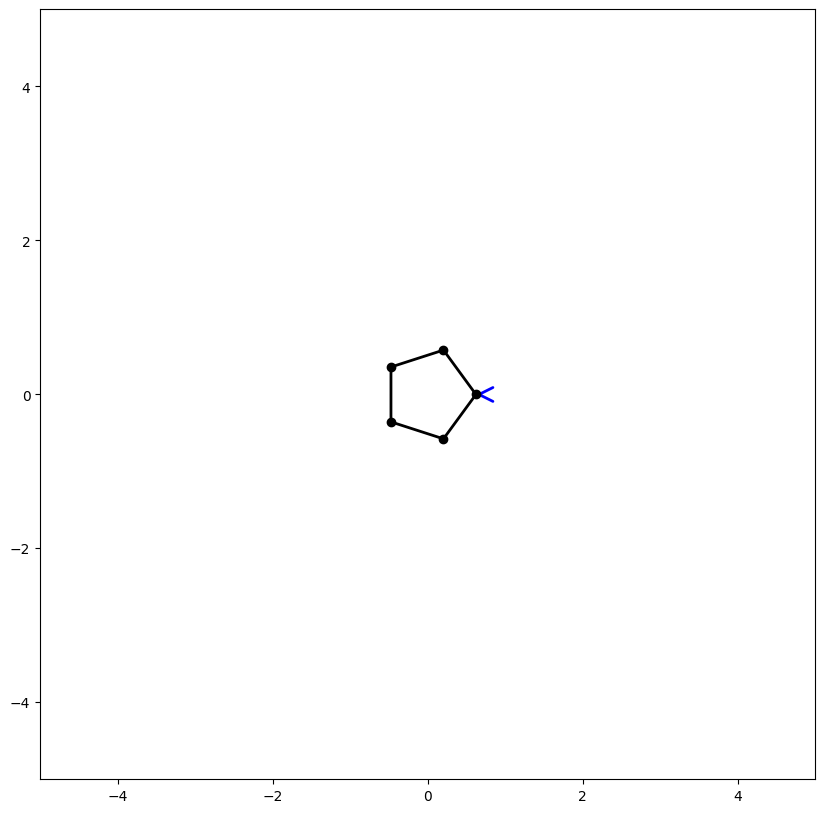

Iteration  215000 ff =  2.4580905233934452e-31 vv =  4.977988026155911e-31 power =  3.4980487693369697e-31


<Figure size 640x480 with 0 Axes>

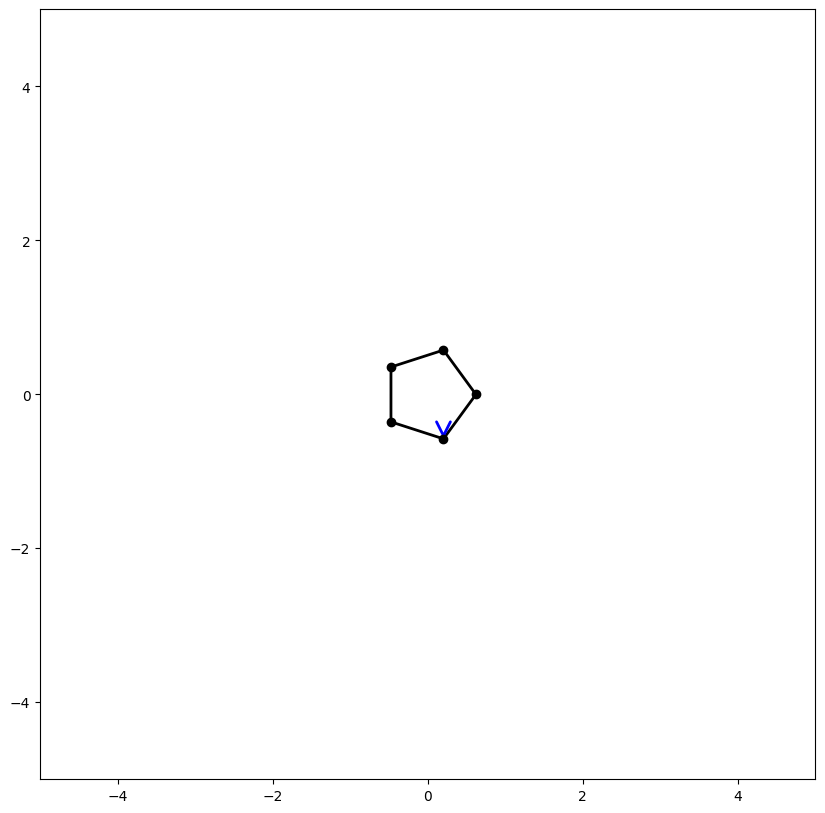

Iteration  216000 ff =  1.0150734971903775e-30 vv =  1.9297080676597955e-30 power =  1.399569761318068e-30


<Figure size 640x480 with 0 Axes>

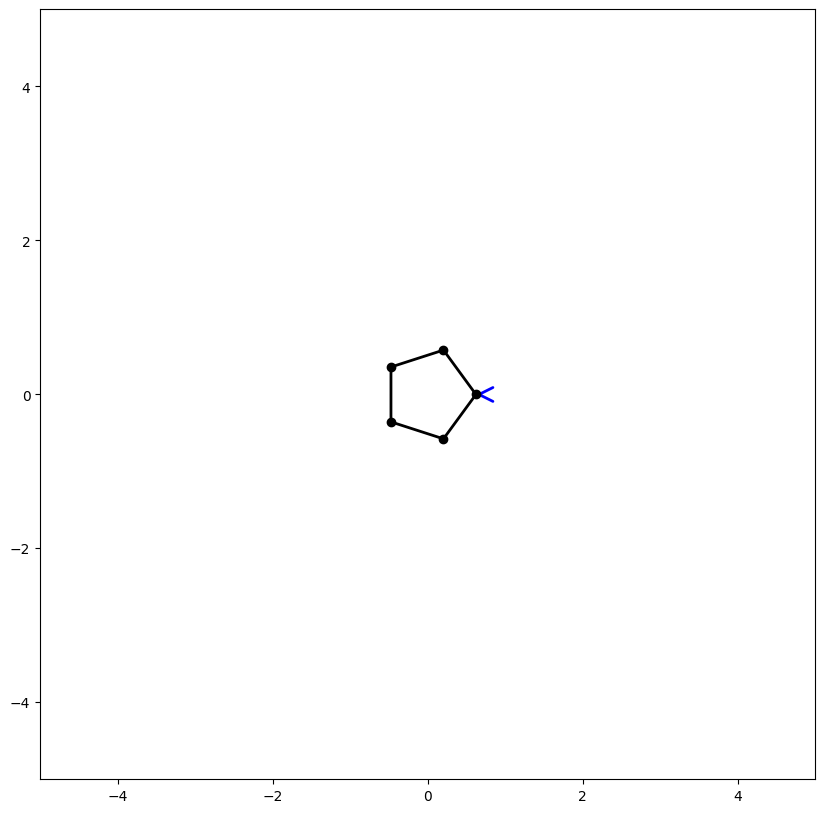

Iteration  217000 ff =  2.4580905233934452e-31 vv =  9.49494291240814e-31 power =  4.831089855628045e-31


<Figure size 640x480 with 0 Axes>

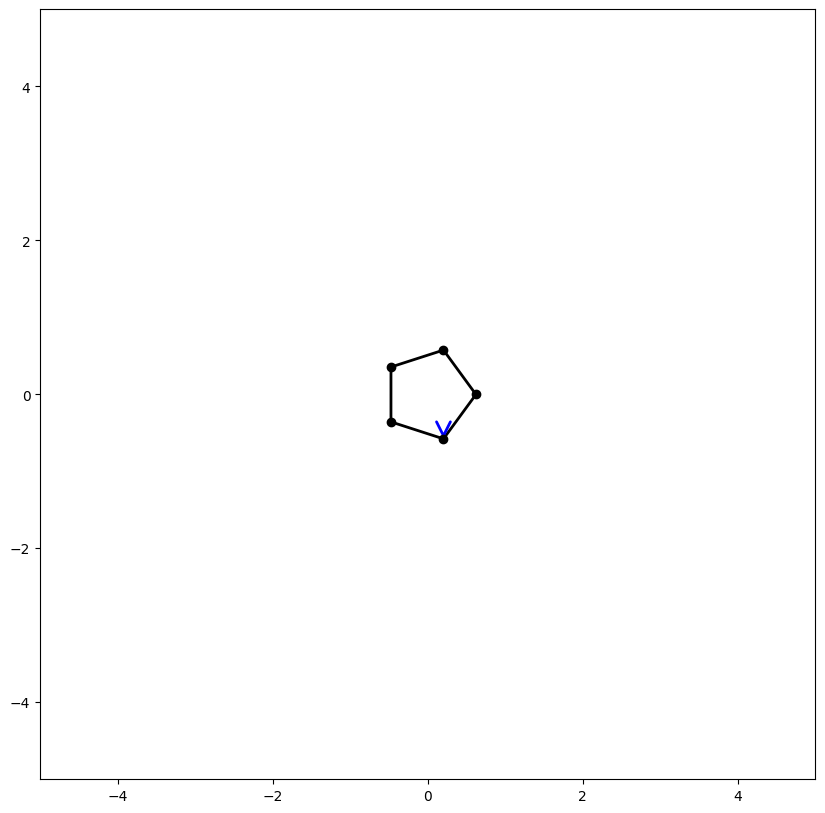

Iteration  218000 ff =  2.4580905233934452e-31 vv =  3.45447961367144e-30 power =  -7.70109654155944e-31


<Figure size 640x480 with 0 Axes>

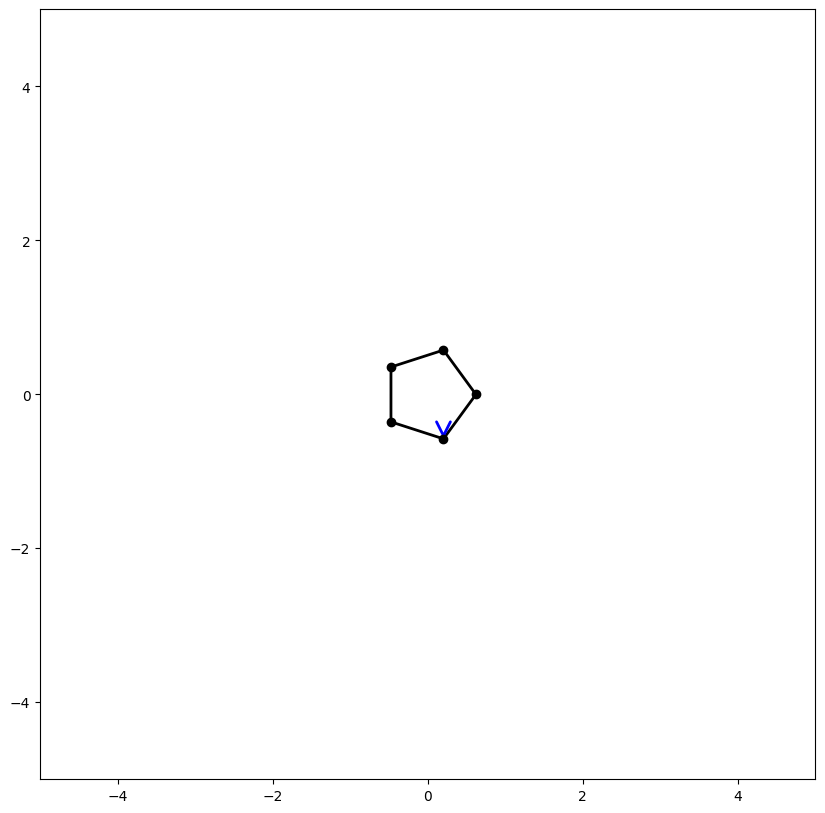

Iteration  219000 ff =  2.4580905233934452e-31 vv =  1.5552714136925495e-30 power =  6.183039643494438e-31


<Figure size 640x480 with 0 Axes>

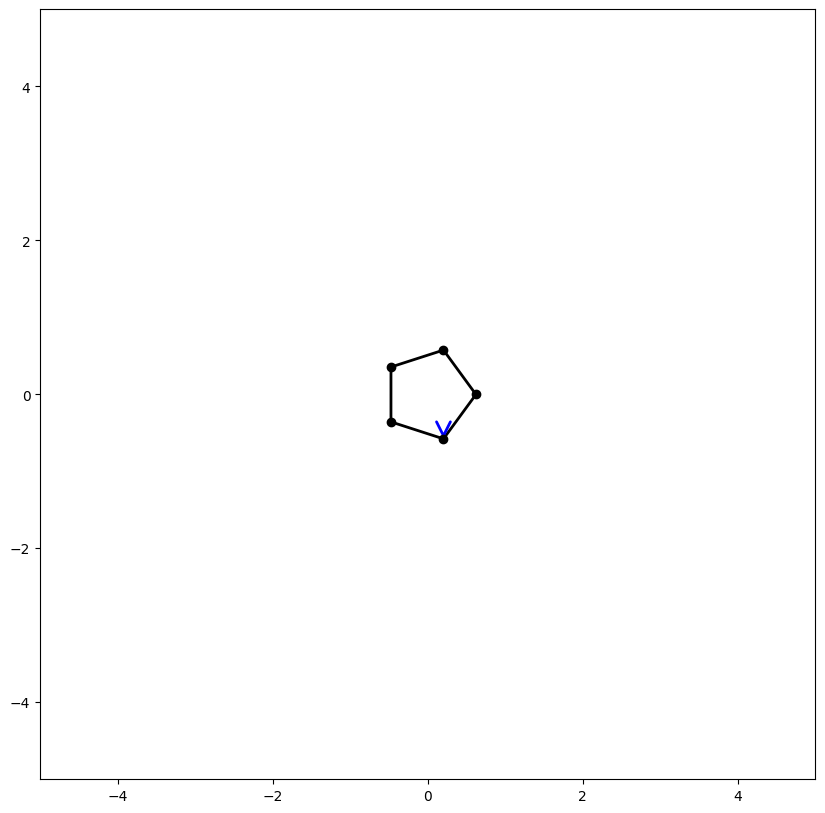

Iteration  220000 ff =  2.4580905233934452e-31 vv =  2.031765448242396e-32 power =  7.067010254756157e-32


<Figure size 640x480 with 0 Axes>

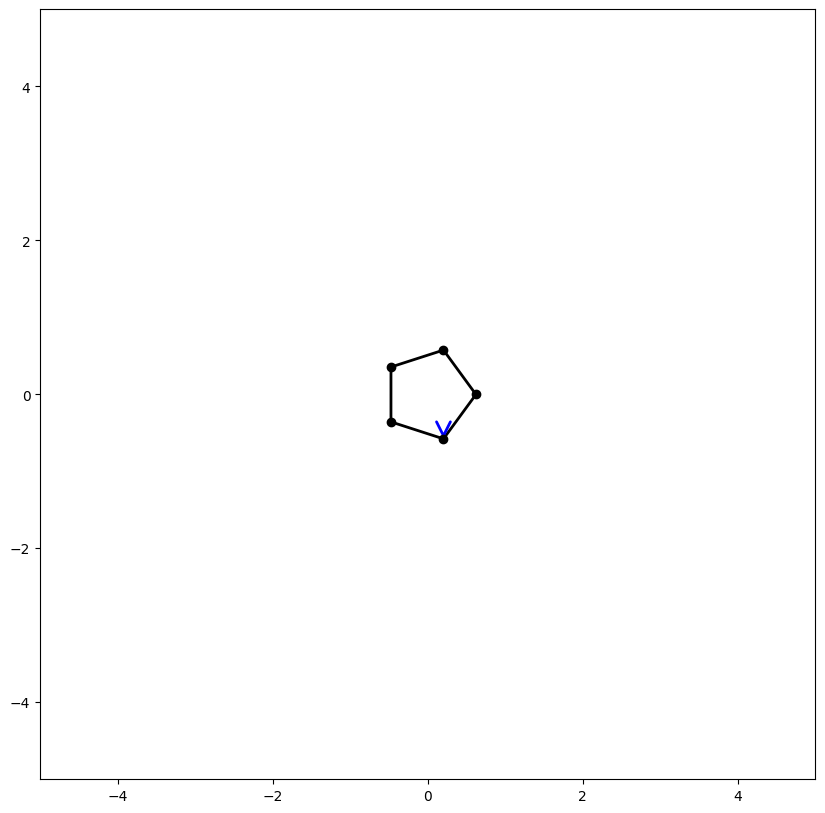

Iteration  221000 ff =  1.0150734971903775e-30 vv =  6.861896841006954e-32 power =  2.639191092694982e-31


<Figure size 640x480 with 0 Axes>

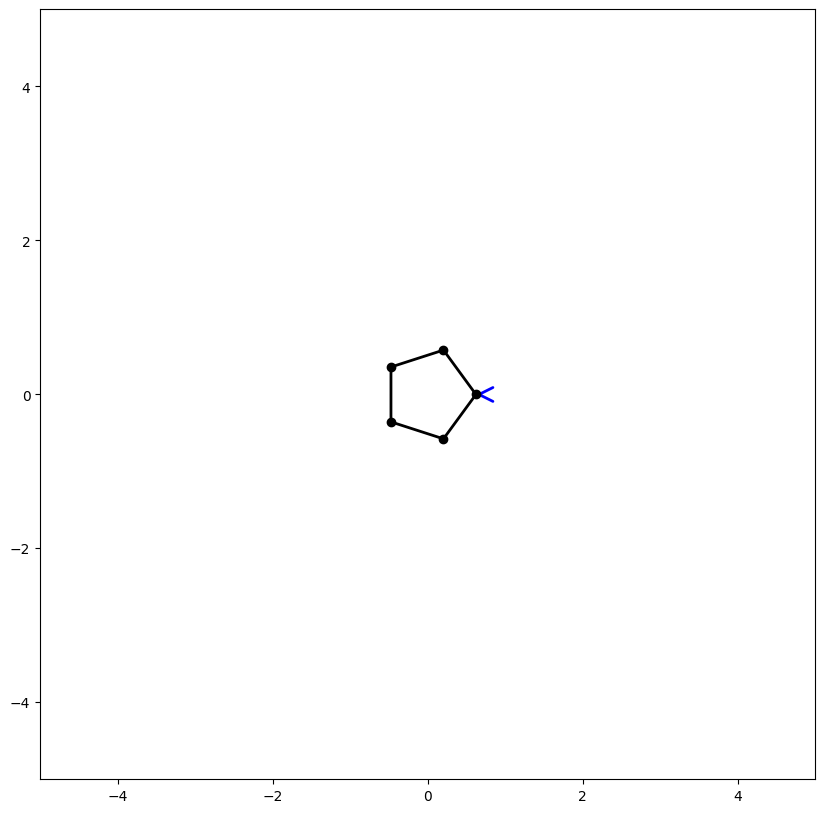

Iteration  222000 ff =  2.4580905233934452e-31 vv =  9.743776444055526e-32 power =  1.5476137935285135e-31


<Figure size 640x480 with 0 Axes>

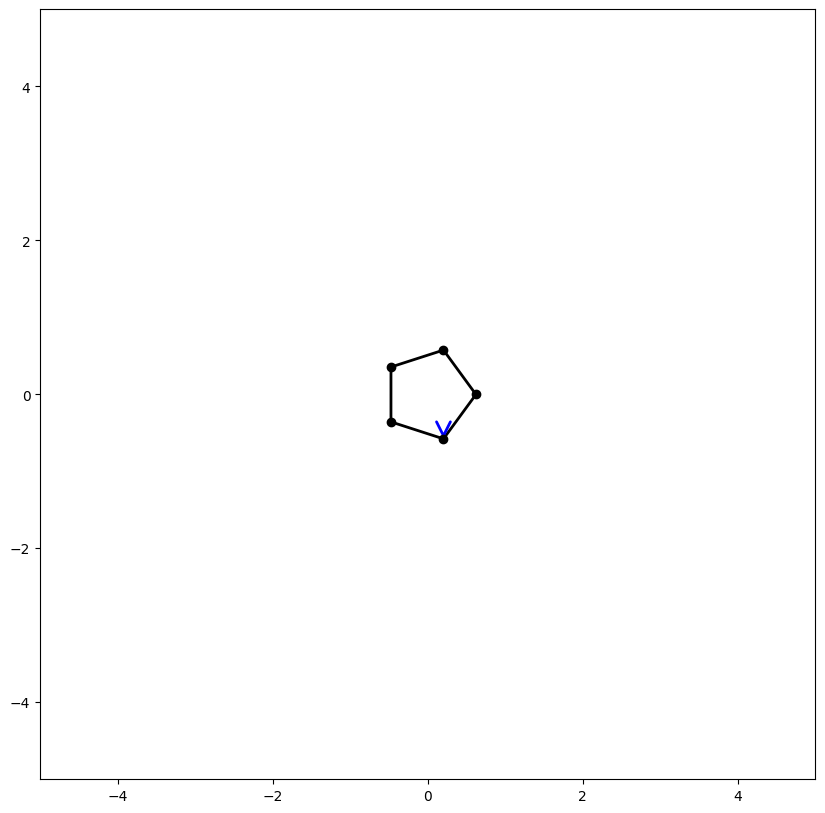

Iteration  223000 ff =  1.0150734971903775e-30 vv =  3.6096369406792697e-31 power =  6.05313703212052e-31


<Figure size 640x480 with 0 Axes>

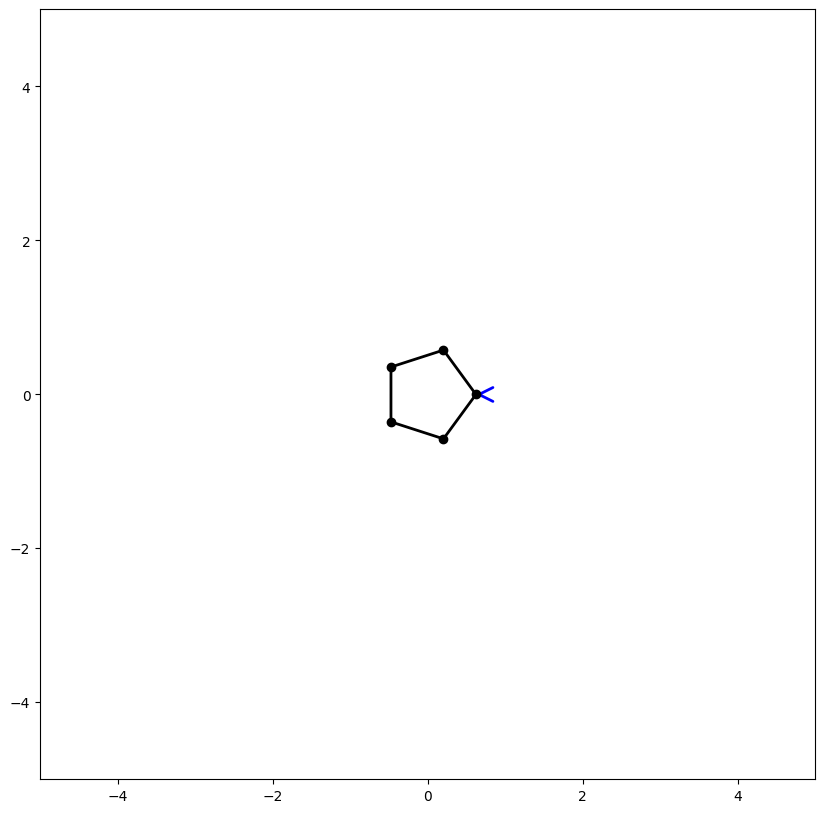

Iteration  224000 ff =  2.4580905233934452e-31 vv =  2.6410772715241566e-31 power =  2.5479417208176774e-31


<Figure size 640x480 with 0 Axes>

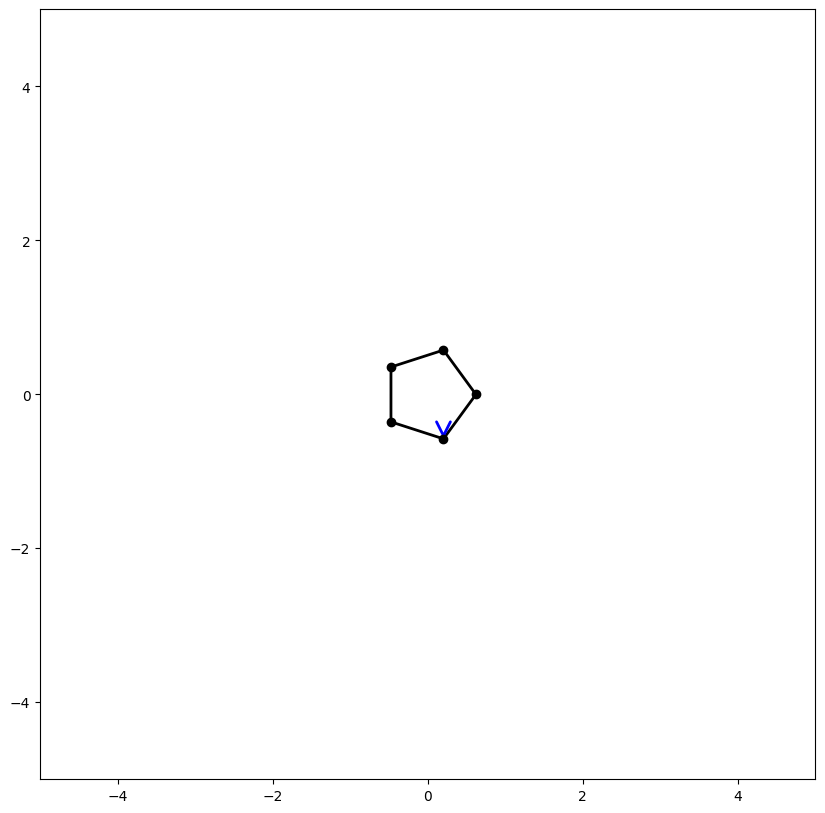

Iteration  225000 ff =  1.0150734971903775e-30 vv =  1.0075566347221761e-30 power =  1.01130808205255e-30


<Figure size 640x480 with 0 Axes>

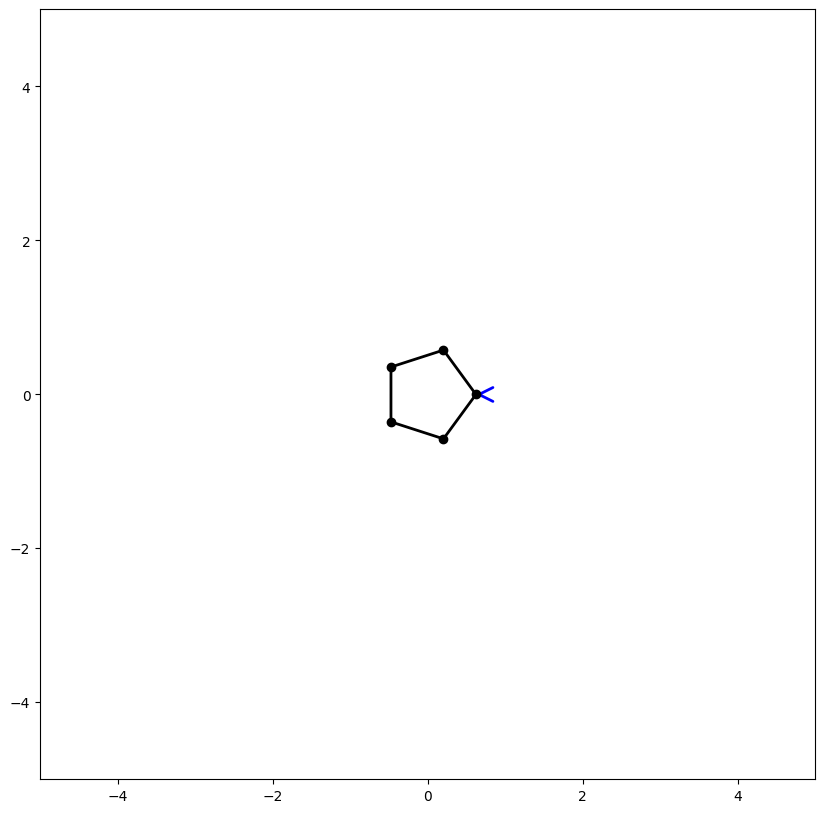

Iteration  226000 ff =  2.4580905233934452e-31 vv =  5.682995258179783e-31 power =  3.737554921151207e-31


<Figure size 640x480 with 0 Axes>

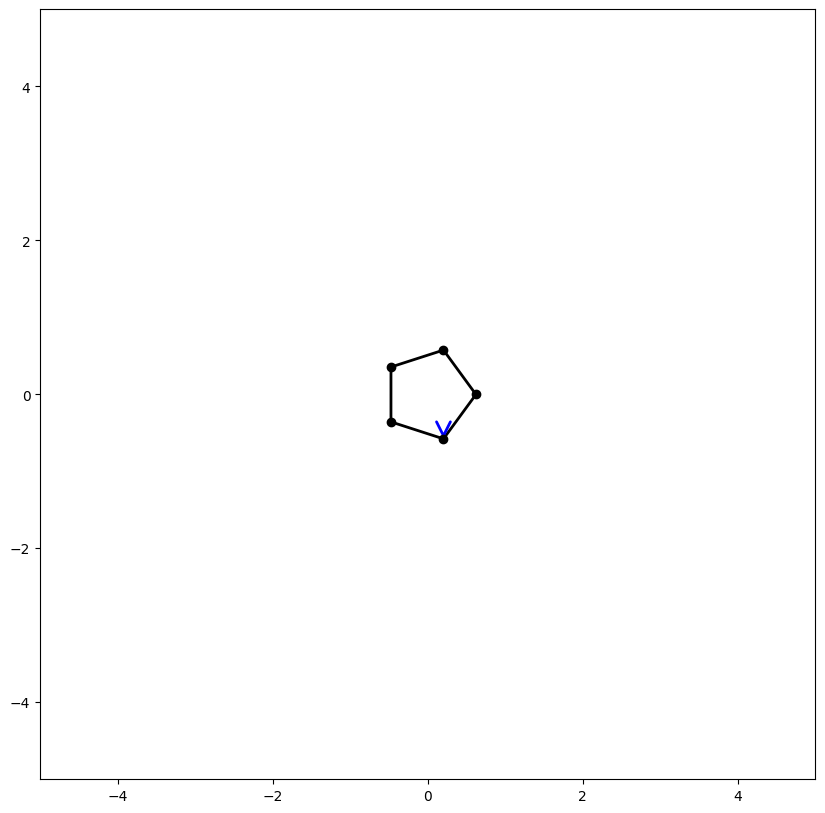

Iteration  227000 ff =  1.0150734971903775e-30 vv =  2.1988281876662723e-30 power =  1.4939786538552626e-30


<Figure size 640x480 with 0 Axes>

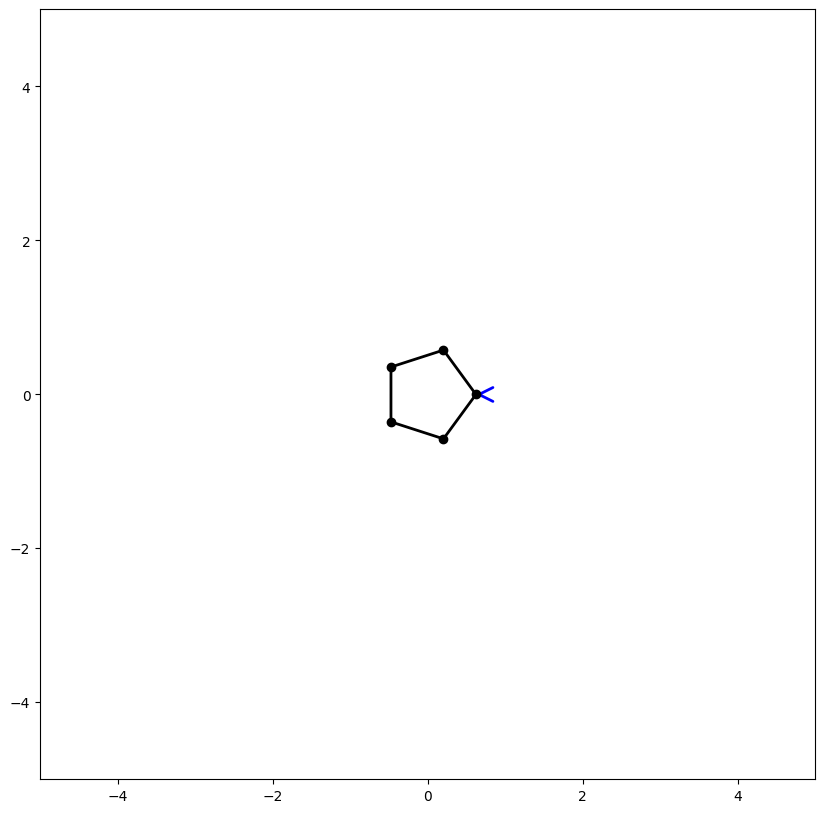

Iteration  228000 ff =  2.4580905233934452e-31 vv =  1.0485741788767681e-30 power =  5.076898907967389e-31


<Figure size 640x480 with 0 Axes>

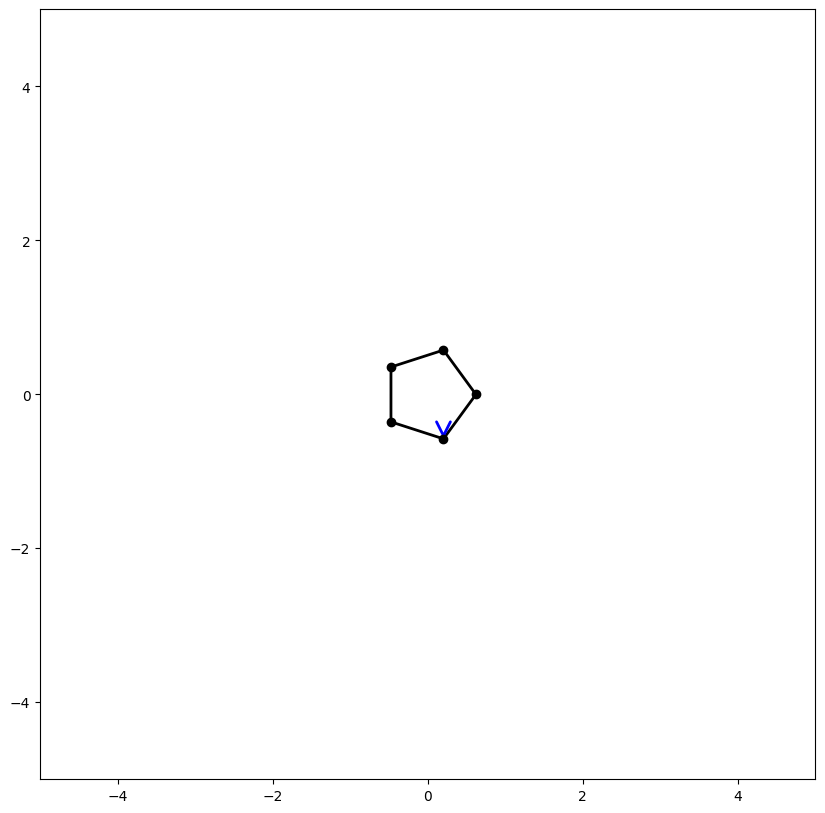

Iteration  229000 ff =  2.4580905233934452e-31 vv =  6.145226308483614e-34 power =  1.2290452616967228e-32


<Figure size 640x480 with 0 Axes>

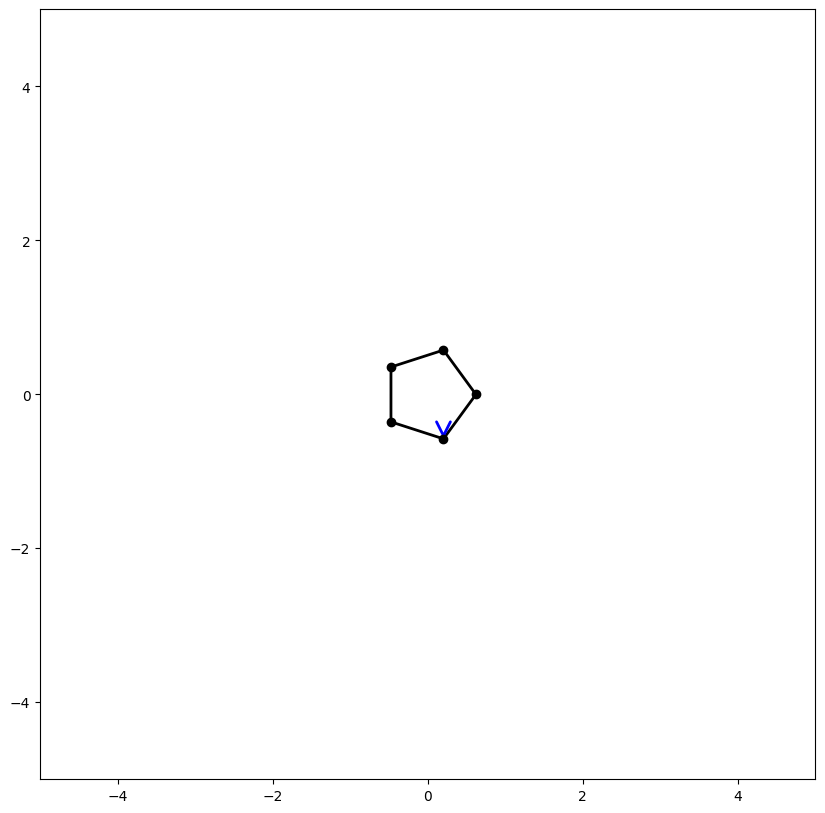

Iteration  230000 ff =  1.0150734971903775e-30 vv =  6.344209357439859e-34 power =  2.5376837429759443e-32


<Figure size 640x480 with 0 Axes>

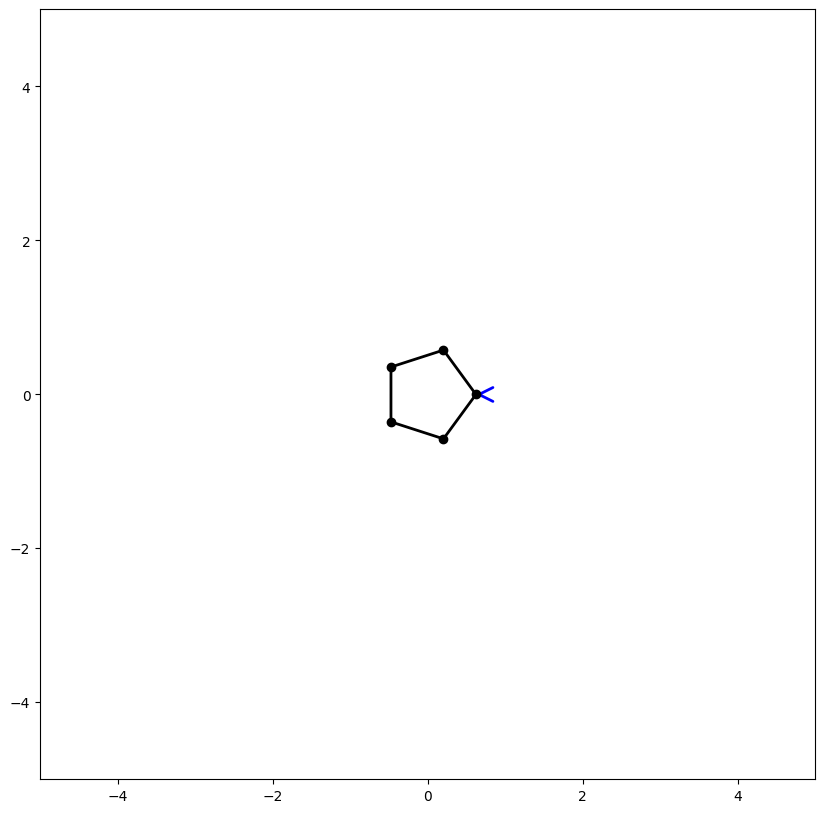

Iteration  231000 ff =  2.4580905233934452e-31 vv =  2.92998398792848e-32 power =  8.486557532015873e-32


<Figure size 640x480 with 0 Axes>

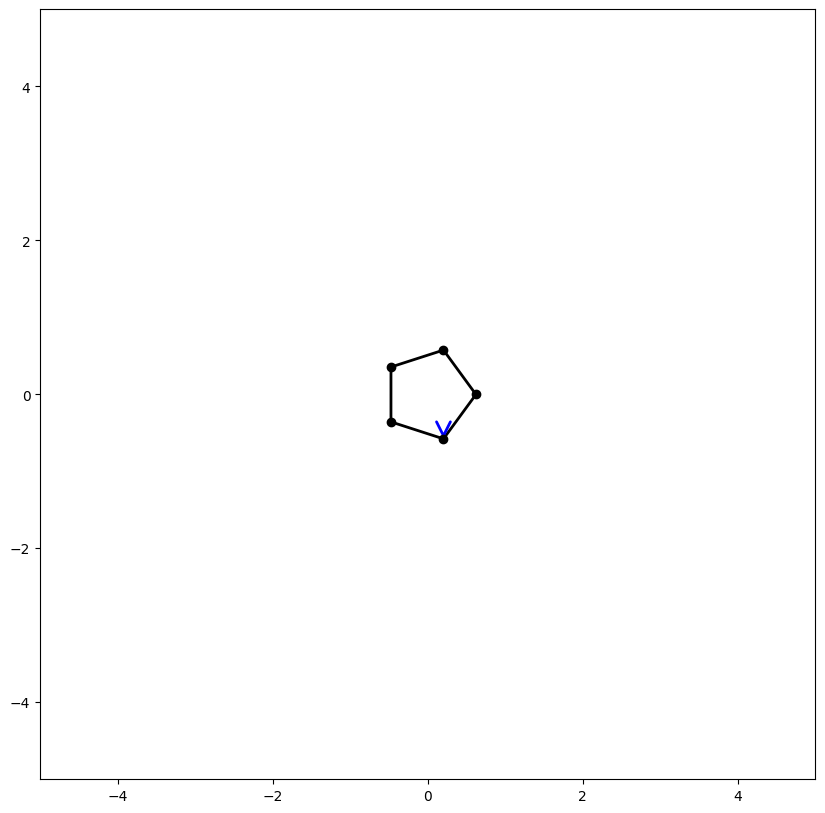

Iteration  232000 ff =  1.0150734971903775e-30 vv =  1.0072066775871525e-31 power =  3.19748151614969e-31


<Figure size 640x480 with 0 Axes>

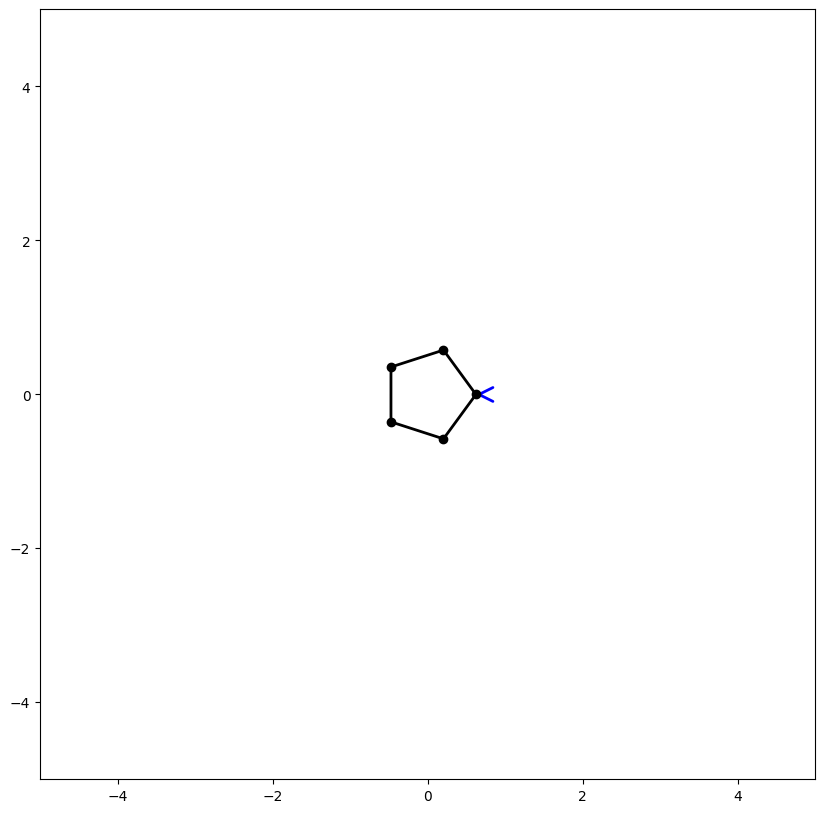

Iteration  233000 ff =  2.4580905233934452e-31 vv =  1.1912516835884814e-31 power =  1.7111997178603474e-31


<Figure size 640x480 with 0 Axes>

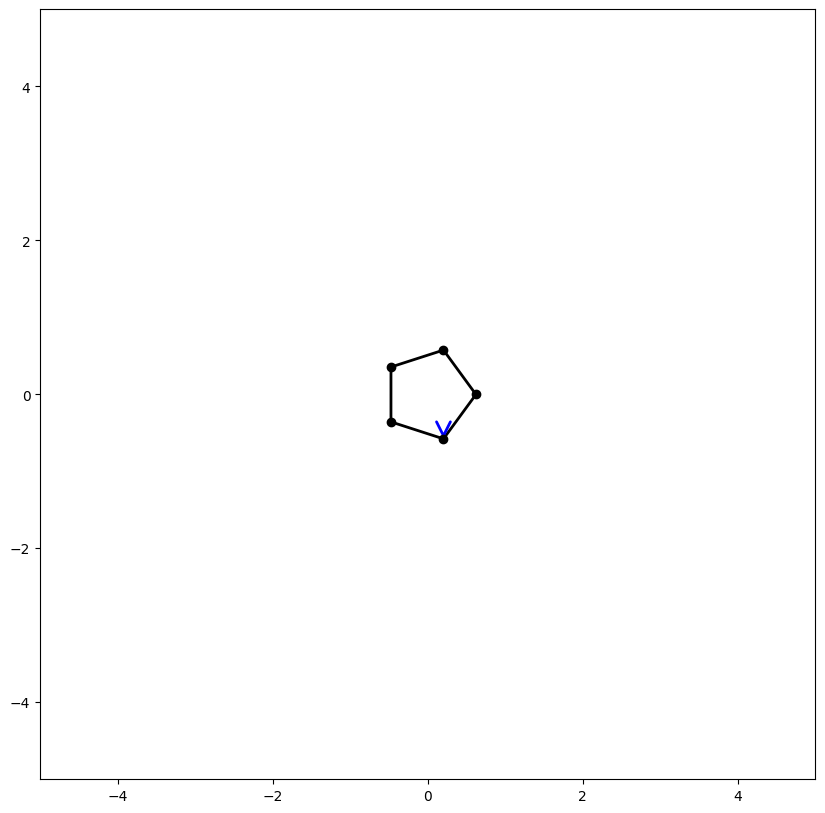

Iteration  234000 ff =  1.0150734971903775e-30 vv =  4.460266095148413e-31 power =  6.728668444500716e-31


<Figure size 640x480 with 0 Axes>

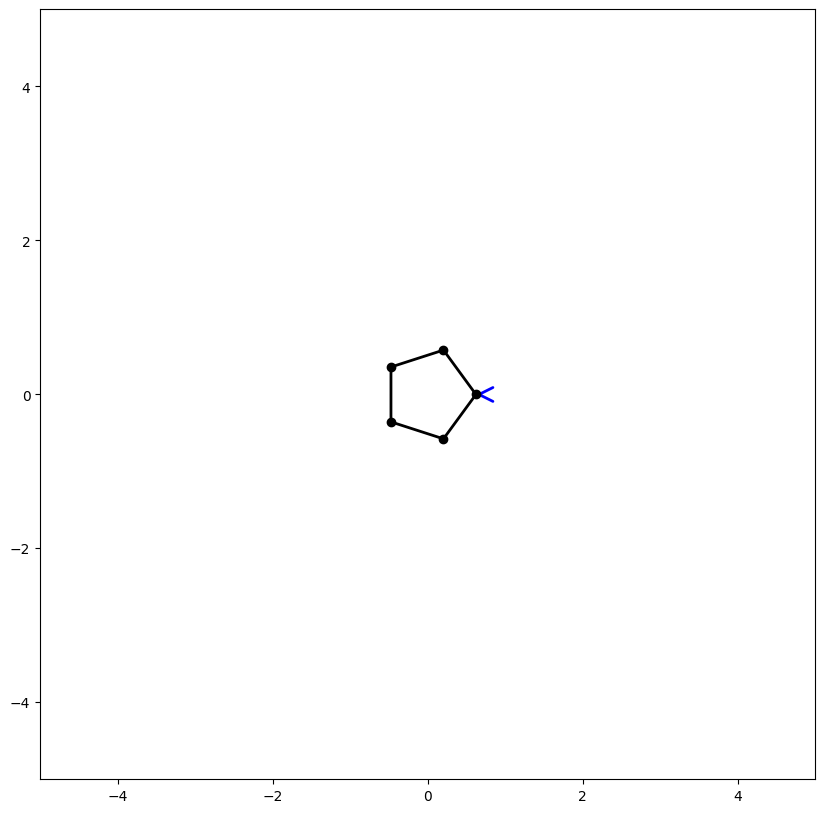

Iteration  235000 ff =  2.4580905233934452e-31 vv =  3.067364968006802e-31 power =  2.7458806892591963e-31


<Figure size 640x480 with 0 Axes>

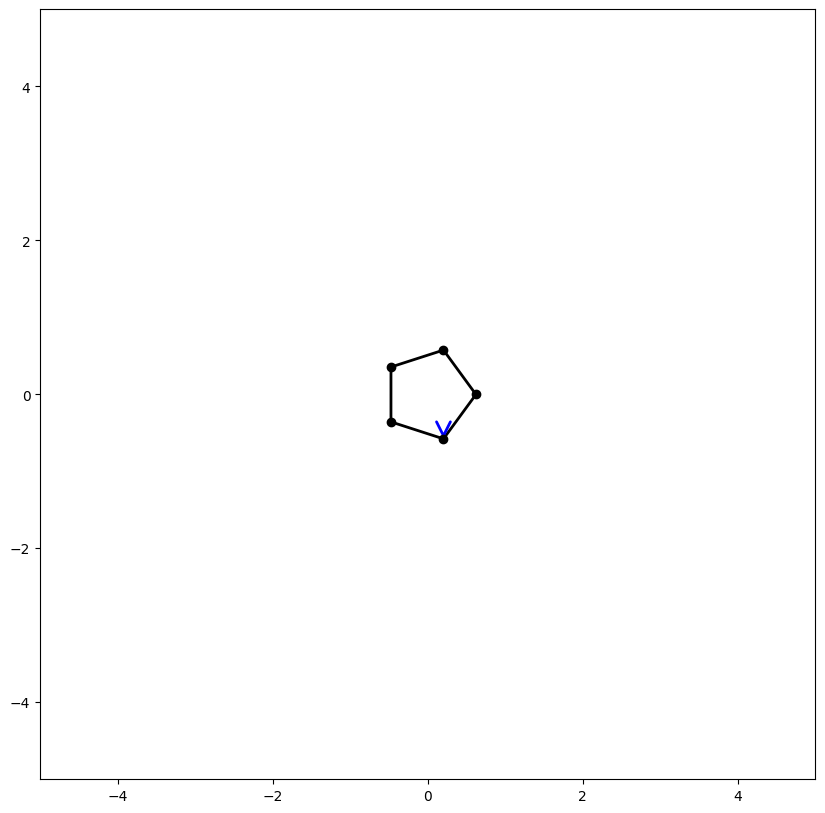

Iteration  236000 ff =  1.0150734971903775e-30 vv =  1.1770109107192834e-30 power =  1.0930473829505537e-30


<Figure size 640x480 with 0 Axes>

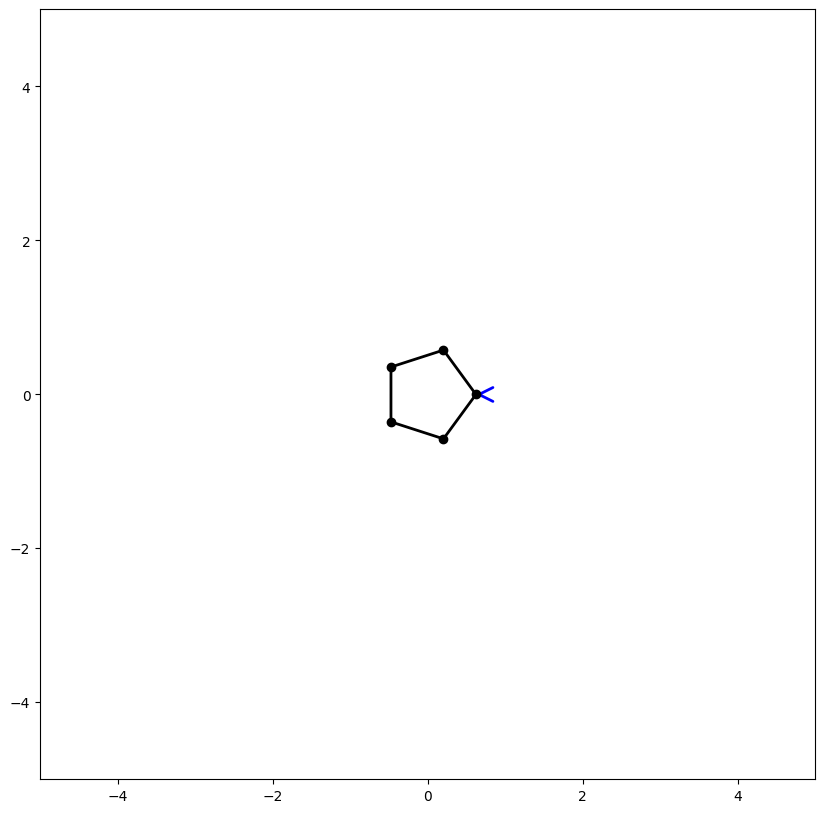

Iteration  237000 ff =  2.4580905233934452e-31 vv =  6.434675463563216e-31 power =  3.9770610729654455e-31


<Figure size 640x480 with 0 Axes>

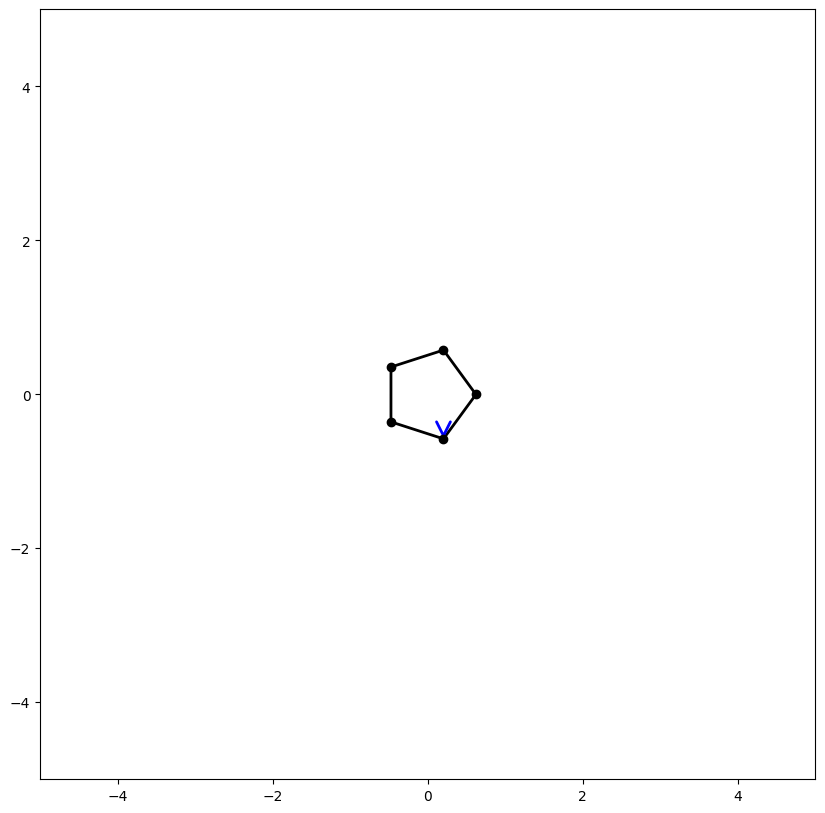

Iteration  238000 ff =  1.0150734971903775e-30 vv =  2.4995992124373663e-30 power =  1.5928832079418475e-30


<Figure size 640x480 with 0 Axes>

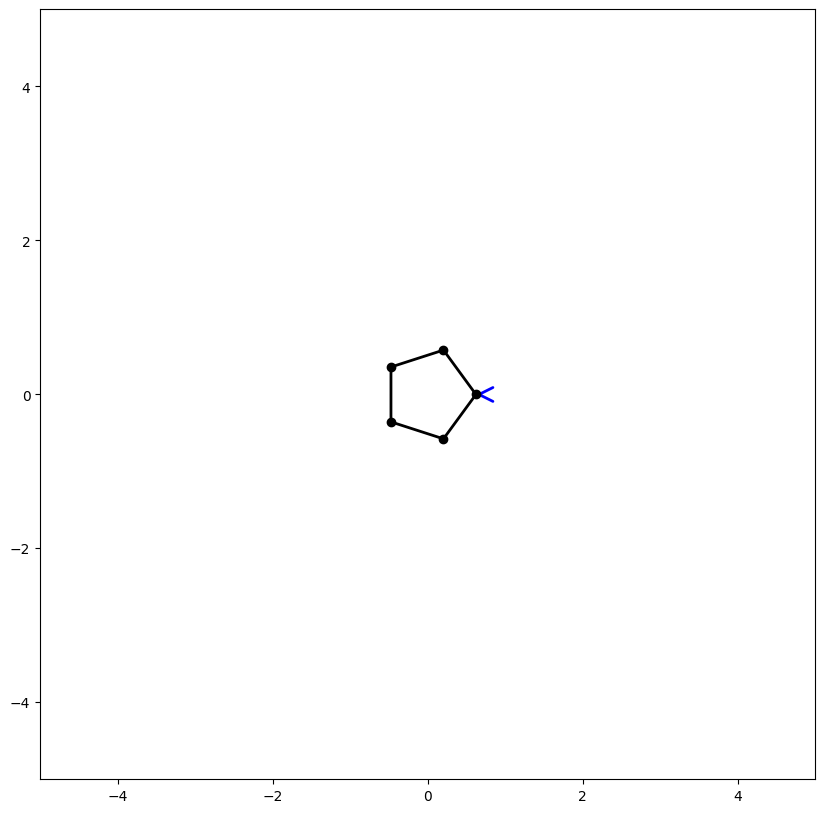

Iteration  239000 ff =  2.4580905233934452e-31 vv =  1.1525702475595094e-30 power =  5.3227079603067335e-31


<Figure size 640x480 with 0 Axes>

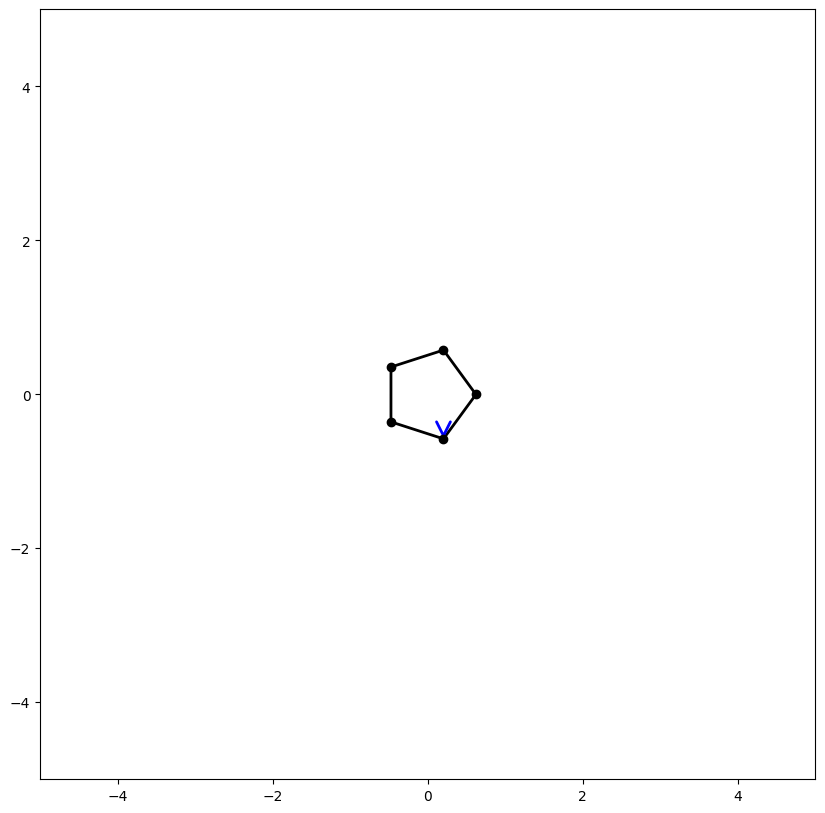

Iteration  240000 ff =  2.4580905233934452e-31 vv =  2.4580905233934464e-33 power =  2.4580905233934458e-32


<Figure size 640x480 with 0 Axes>

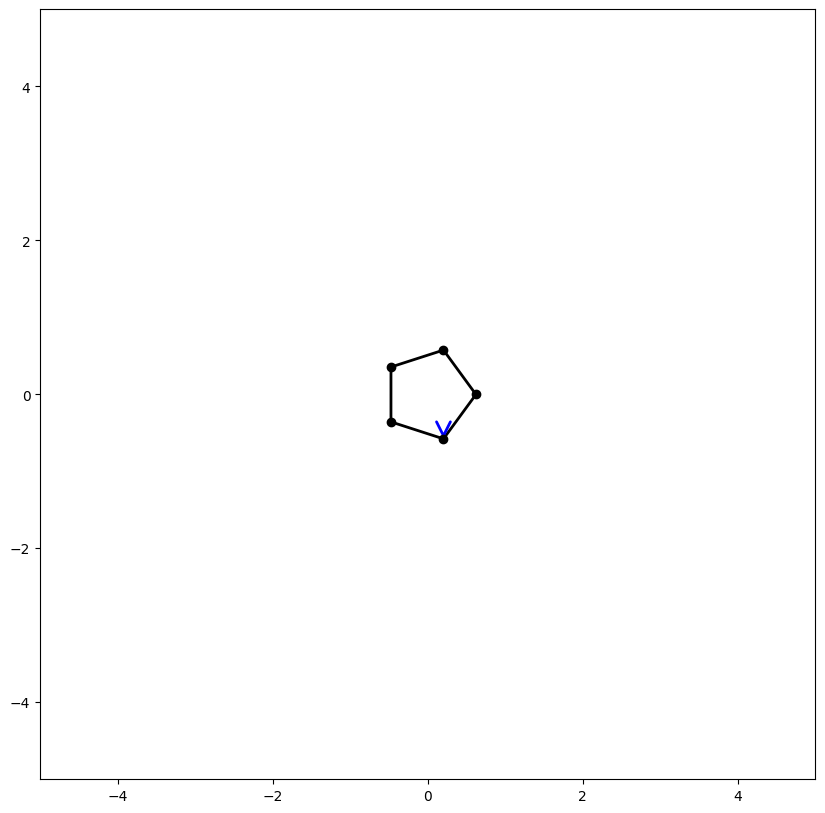

Iteration  241000 ff =  1.0150734971903775e-30 vv =  5.709788421695875e-33 power =  7.613051228927833e-32


<Figure size 640x480 with 0 Axes>

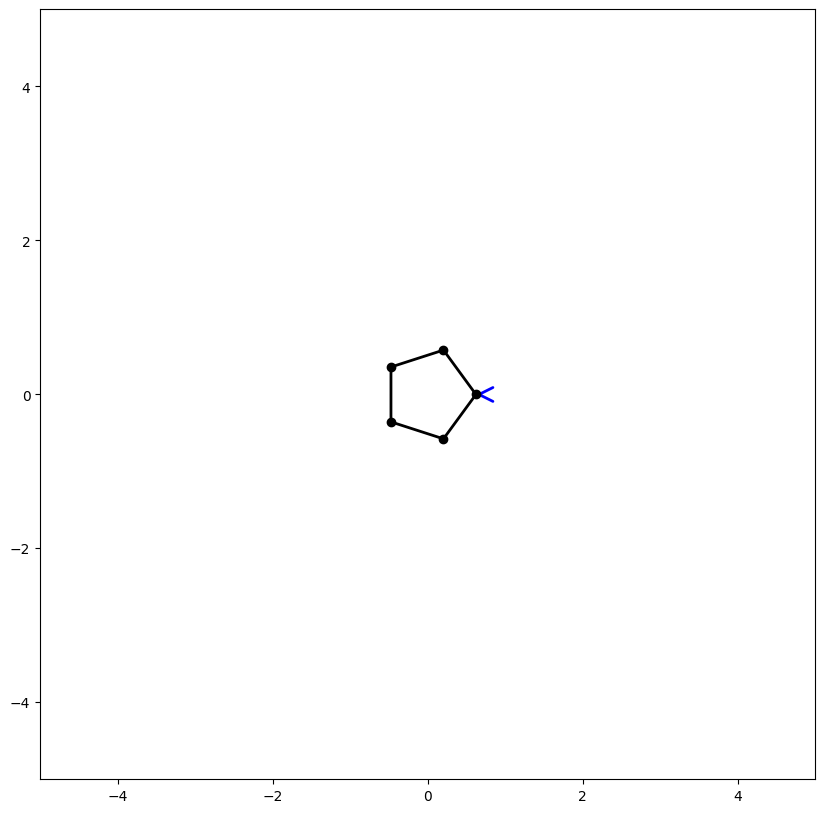

Iteration  242000 ff =  2.4580905233934452e-31 vv =  4.0468297076849084e-32 power =  9.973702298668906e-32


<Figure size 640x480 with 0 Axes>

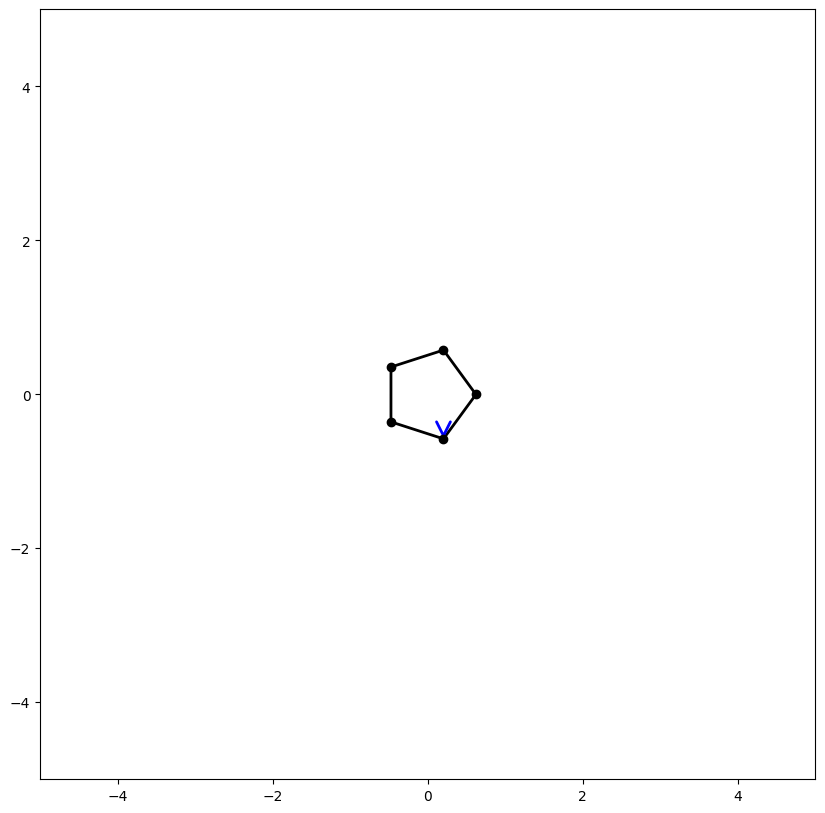

Iteration  243000 ff =  1.0150734971903775e-30 vv =  1.4312561687221756e-31 power =  3.8116009819498683e-31


<Figure size 640x480 with 0 Axes>

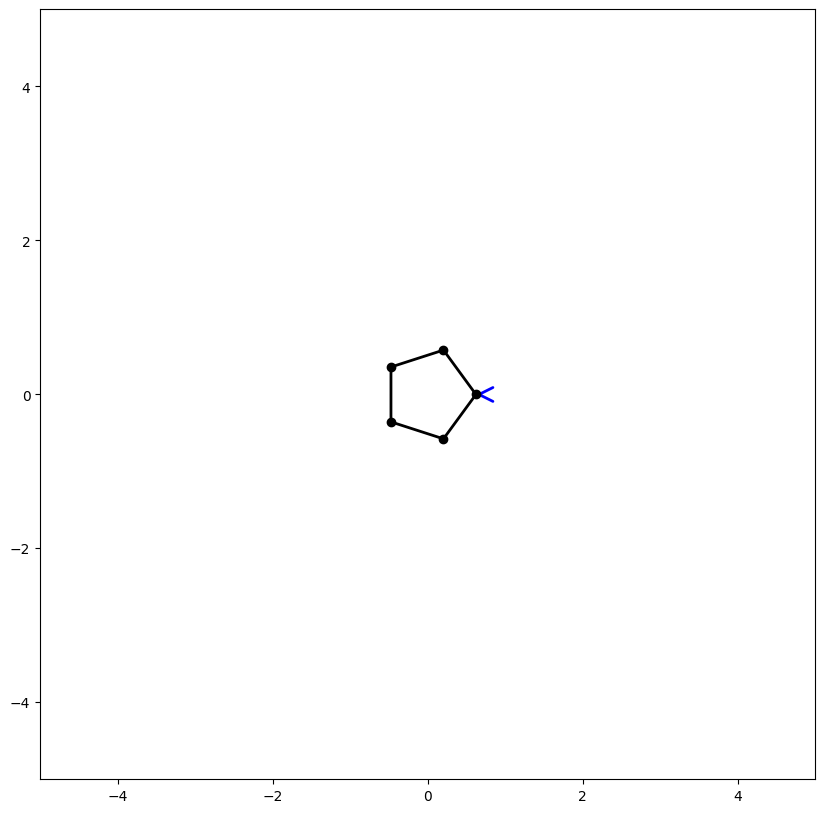

Iteration  244000 ff =  2.4580905233934452e-31 vv =  1.4549612726301982e-31 power =  1.8911442346253646e-31


<Figure size 640x480 with 0 Axes>

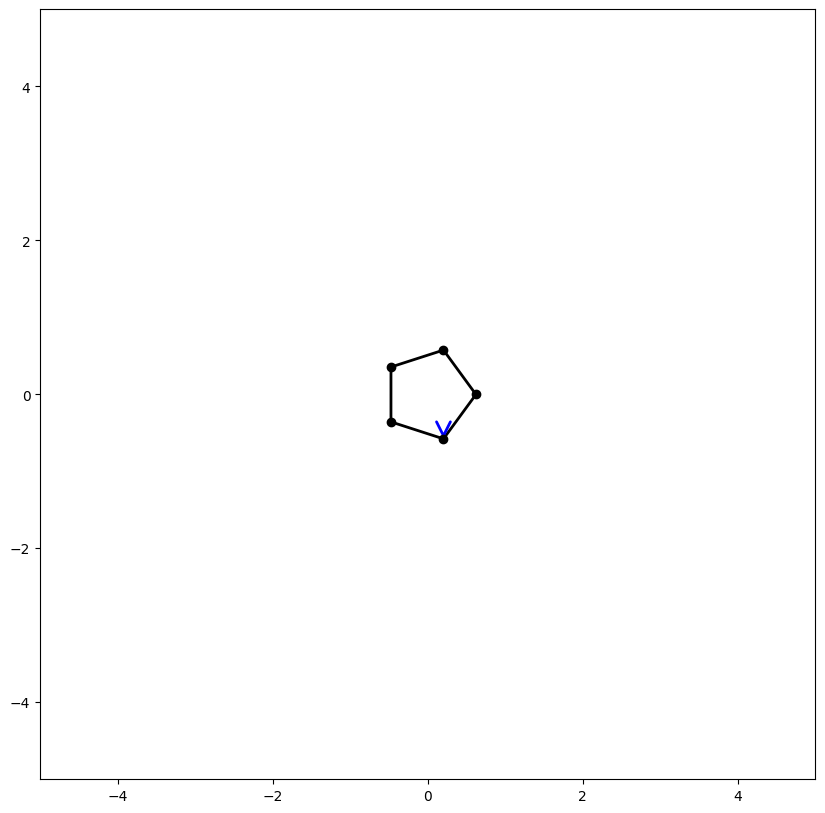

Iteration  245000 ff =  1.0150734971903775e-30 vv =  5.450195822191638e-31 power =  7.437976427499922e-31


<Figure size 640x480 with 0 Axes>

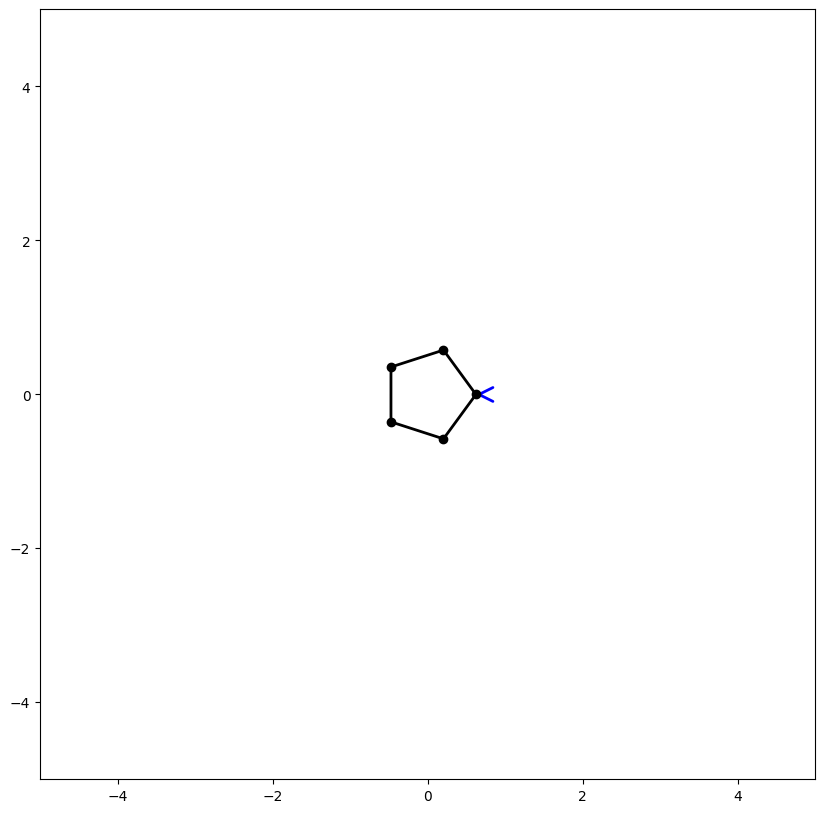

Iteration  246000 ff =  2.4580905233934452e-31 vv =  3.549276036116549e-31 power =  2.9537166061227914e-31


<Figure size 640x480 with 0 Axes>

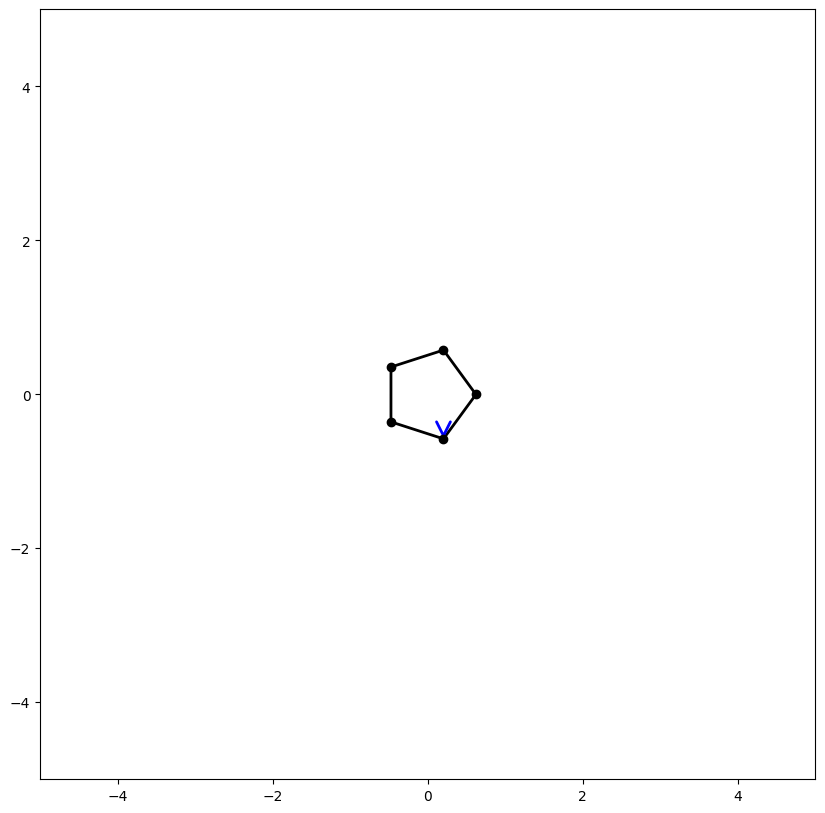

Iteration  247000 ff =  1.0150734971903775e-30 vv =  1.3596293828653152e-30 power =  1.1747866838485574e-30


<Figure size 640x480 with 0 Axes>

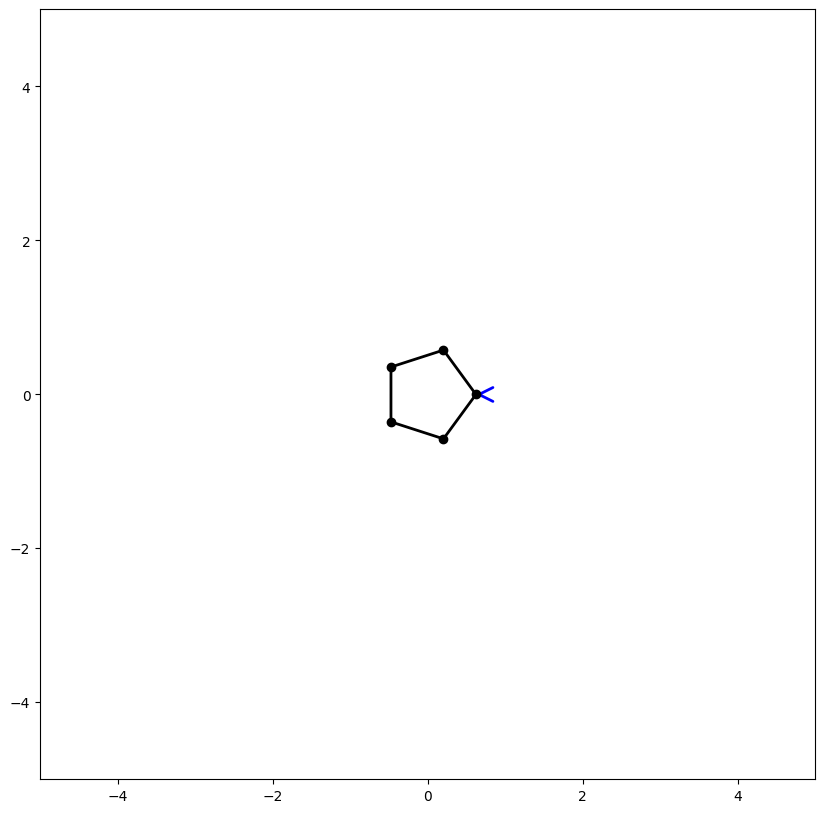

Iteration  248000 ff =  2.4580905233934452e-31 vv =  7.2330286423062075e-31 power =  4.216567224779684e-31


<Figure size 640x480 with 0 Axes>

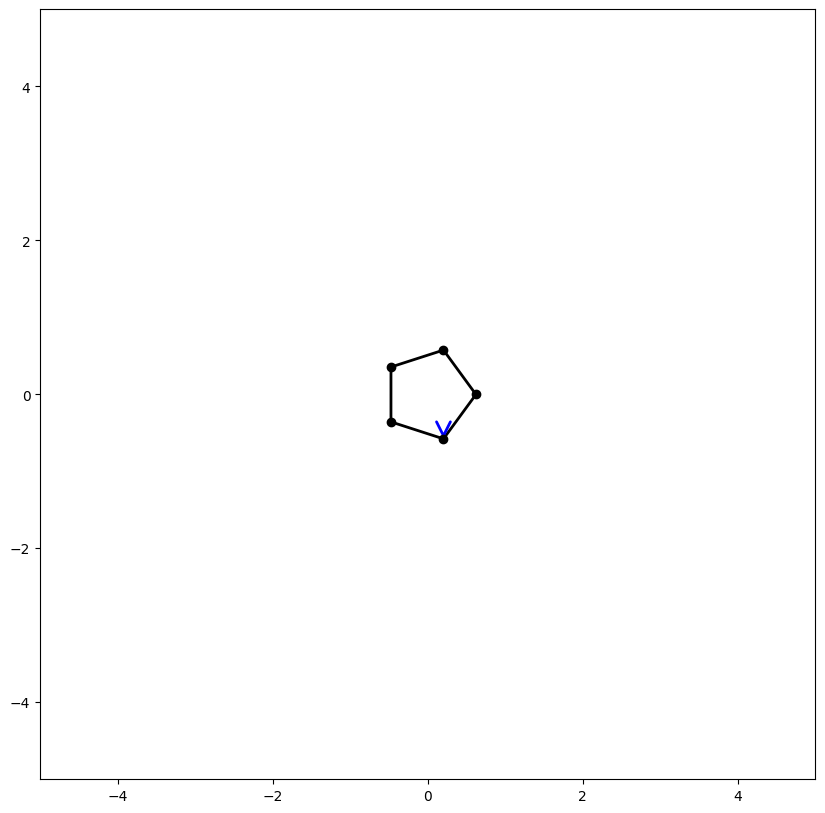

Iteration  249000 ff =  1.0150734971903775e-30 vv =  2.8196439367900996e-30 power =  1.691787762028432e-30


<Figure size 640x480 with 0 Axes>

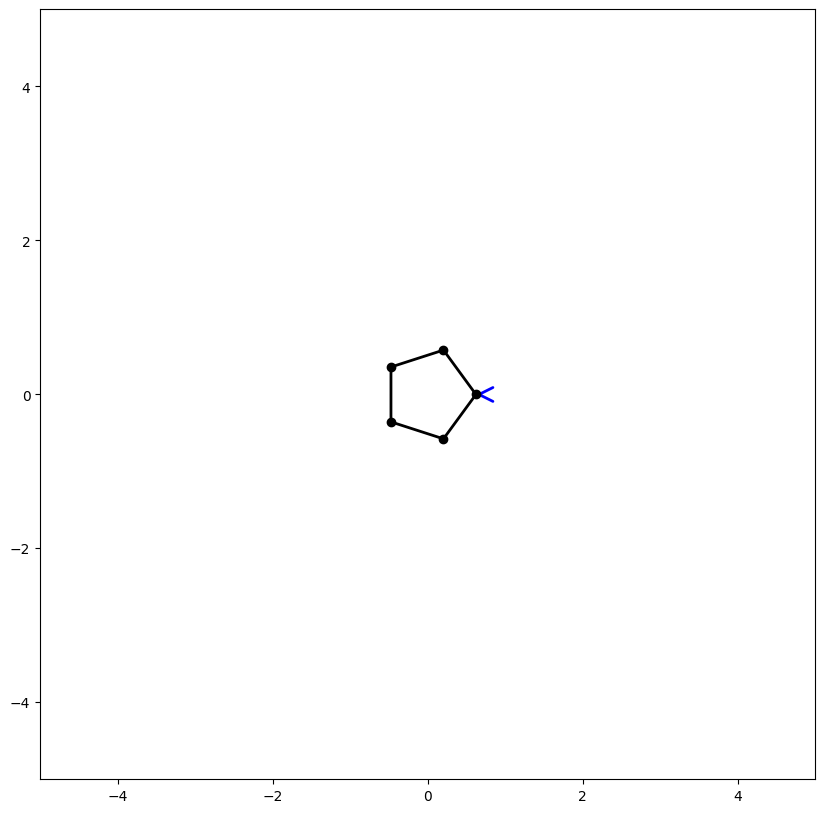

Iteration  250000 ff =  2.4580905233934452e-31 vv =  1.2614824972890376e-30 power =  5.568517012646079e-31


<Figure size 640x480 with 0 Axes>

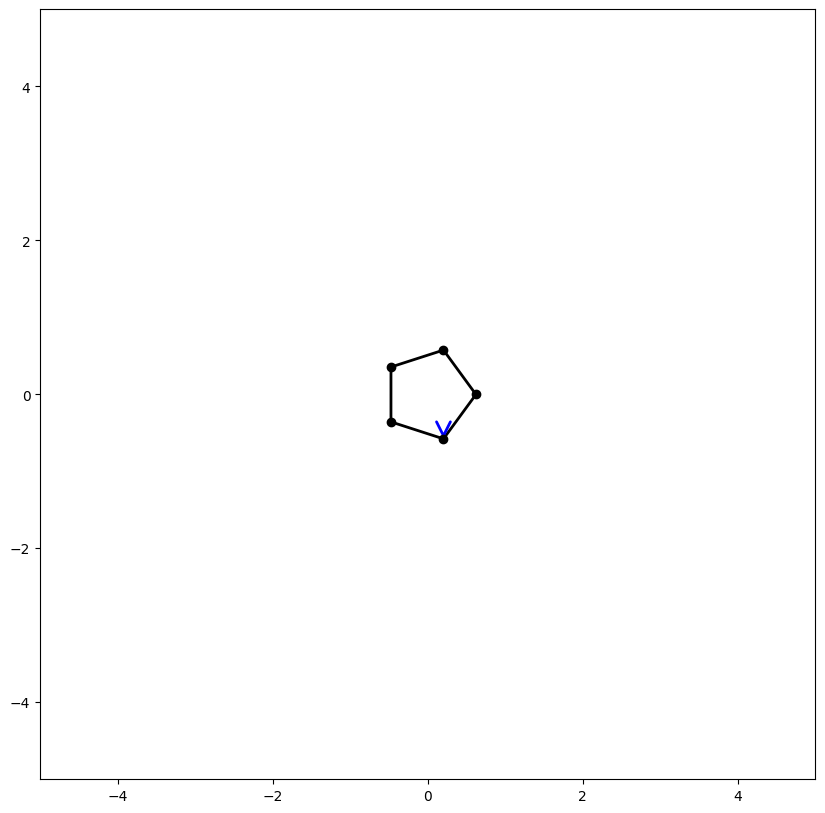

Iteration  251000 ff =  2.4580905233934452e-31 vv =  5.530703677635255e-33 power =  3.6871357850901686e-32


<Figure size 640x480 with 0 Axes>

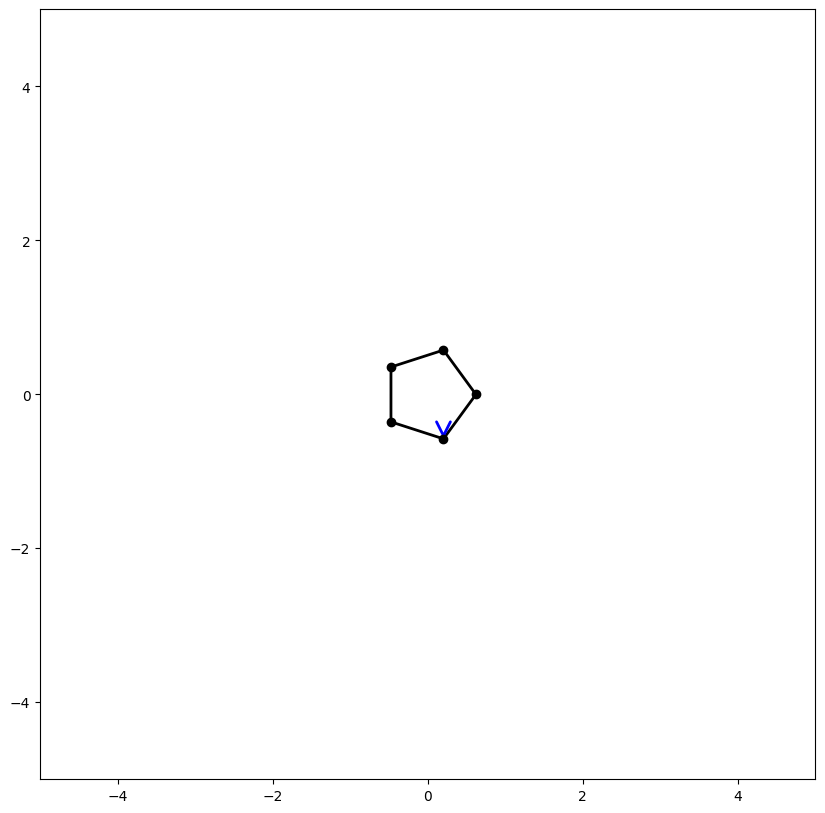

Iteration  252000 ff =  1.0150734971903775e-30 vv =  1.586052339359965e-32 power =  1.268841871487972e-31


<Figure size 640x480 with 0 Axes>

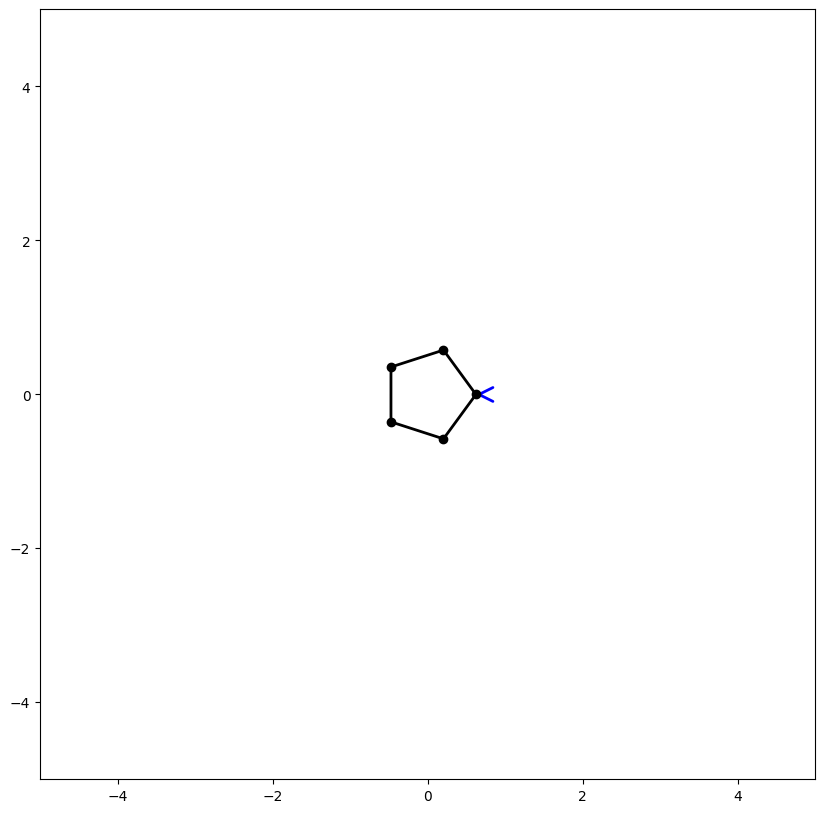

Iteration  253000 ff =  2.4580905233934452e-31 vv =  5.343619944206355e-32 power =  1.1460847065321942e-31


<Figure size 640x480 with 0 Axes>

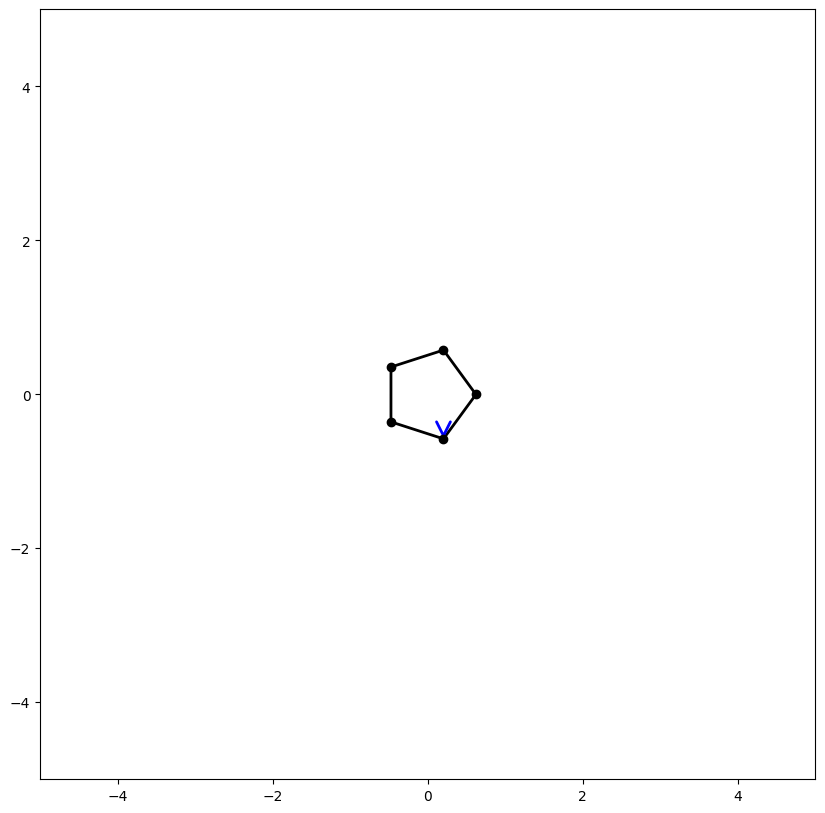

Iteration  254000 ff =  1.0150734971903775e-30 vv =  1.9296141152190206e-31 power =  4.425720447750047e-31


<Figure size 640x480 with 0 Axes>

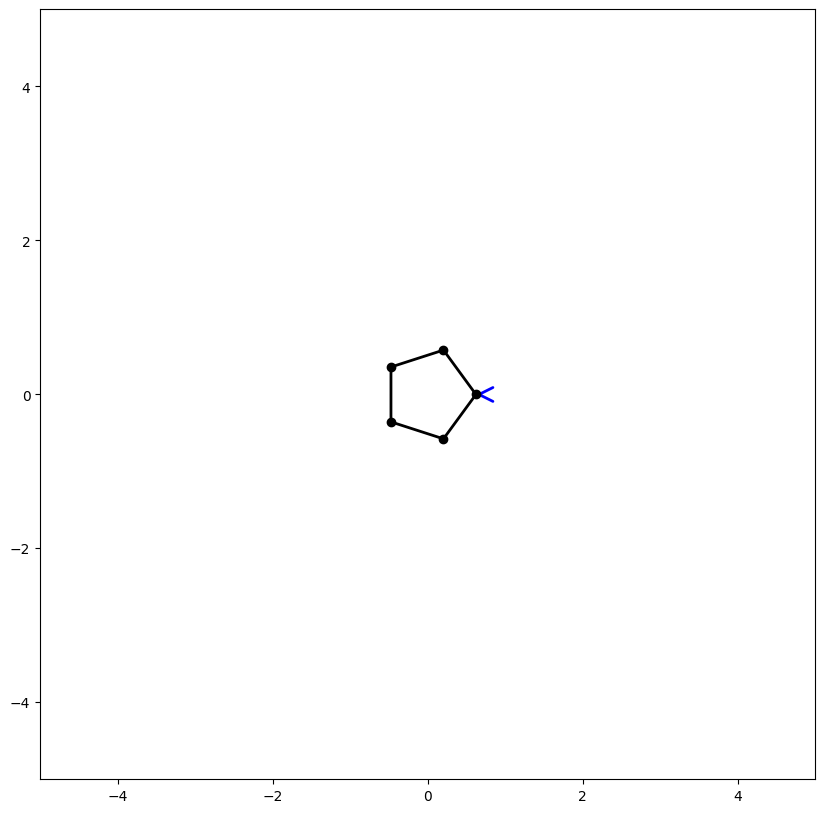

Iteration  255000 ff =  2.4580905233934452e-31 vv =  1.7450165383714809e-31 power =  2.0710887513903815e-31


<Figure size 640x480 with 0 Axes>

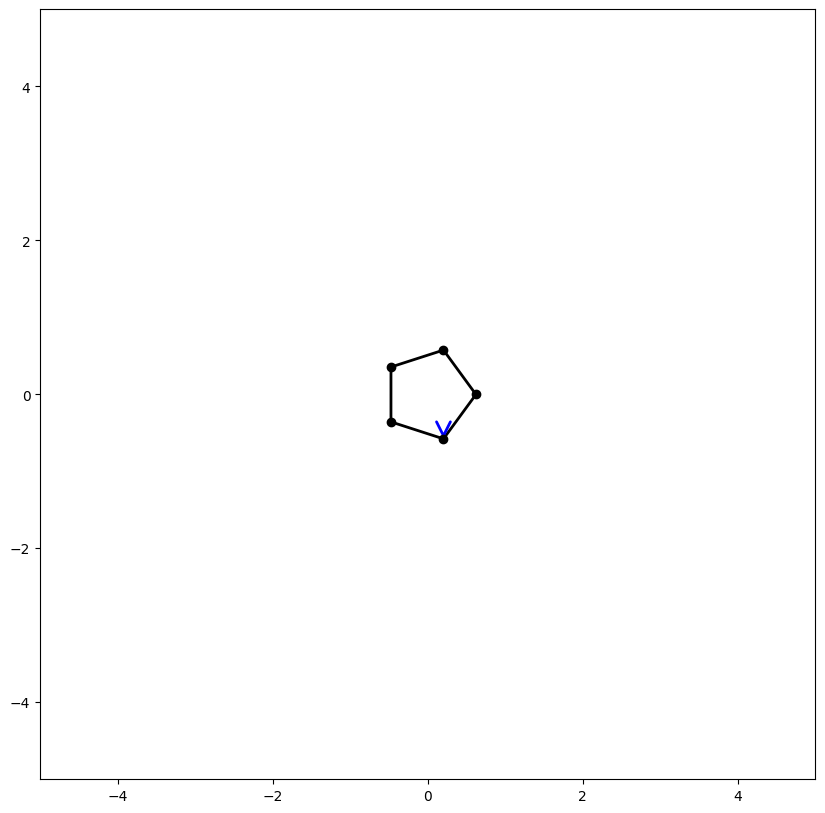

Iteration  256000 ff =  1.0150734971903775e-30 vv =  6.593587455689523e-31 power =  8.181060981118139e-31


<Figure size 640x480 with 0 Axes>

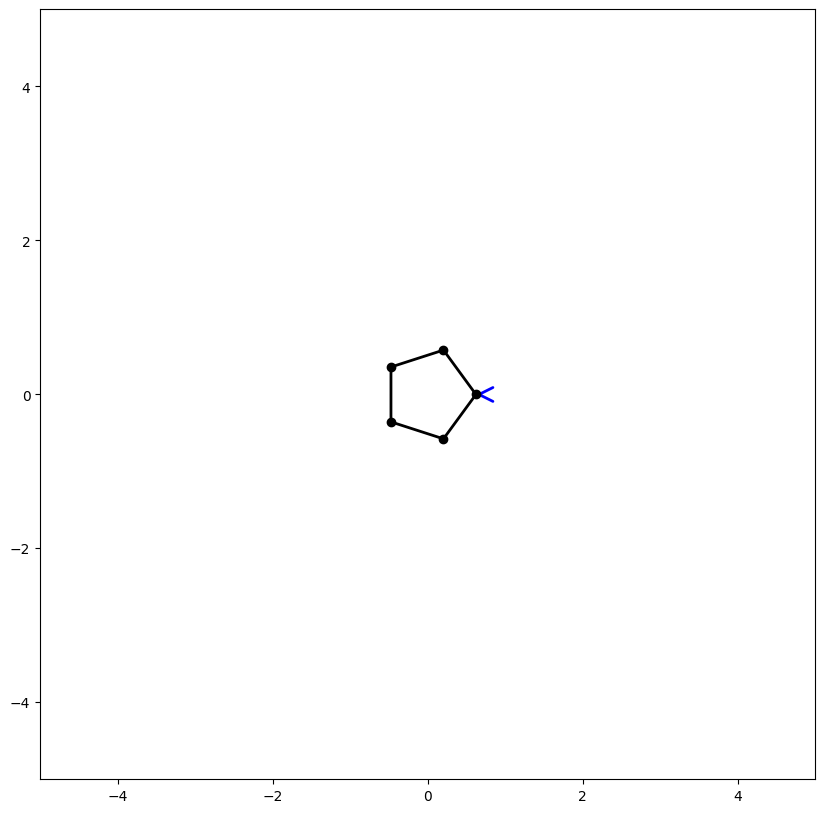

Iteration  257000 ff =  2.4580905233934452e-31 vv =  4.091831303190418e-31 power =  3.1714494714084626e-31


<Figure size 640x480 with 0 Axes>

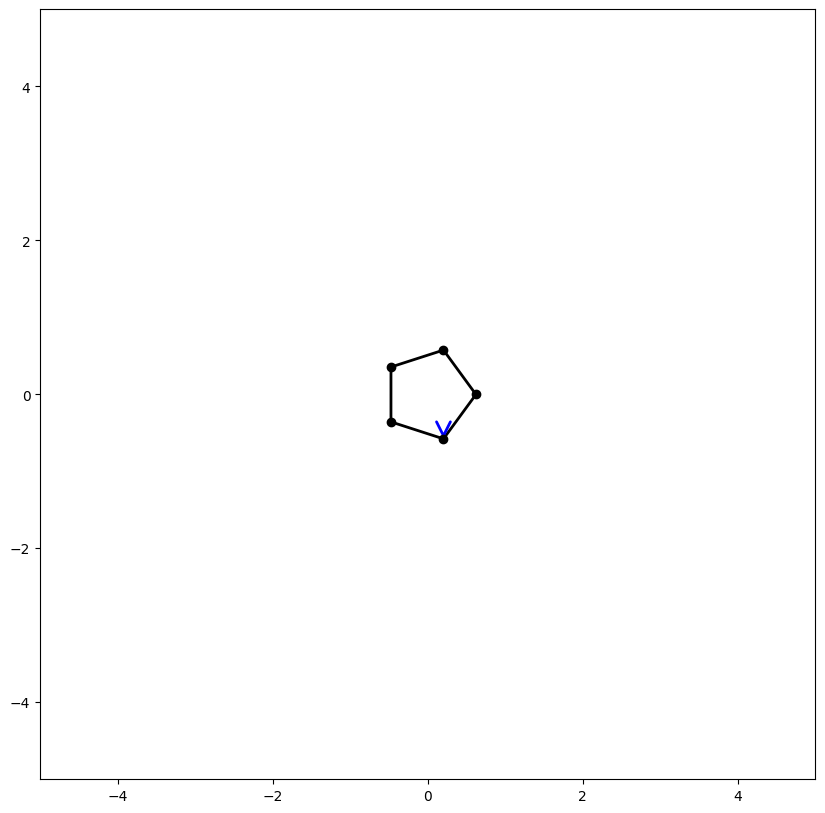

Iteration  258000 ff =  1.0150734971903775e-30 vv =  1.5757143487779582e-30 power =  1.2646999148363616e-30


<Figure size 640x480 with 0 Axes>

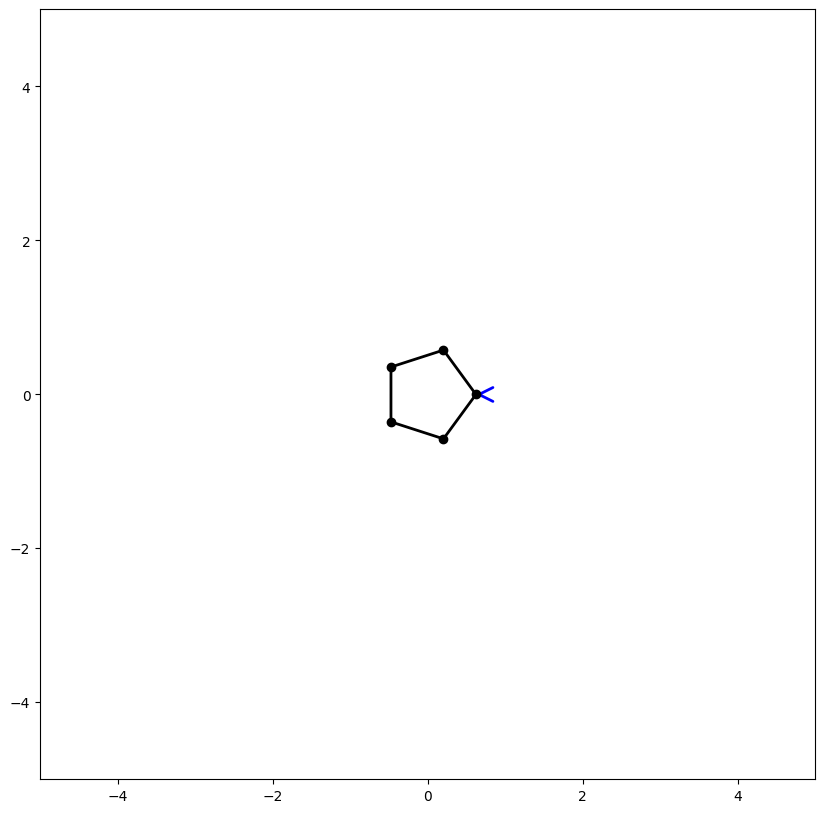

Iteration  259000 ff =  2.4580905233934452e-31 vv =  8.100922992496078e-31 power =  4.462376277119029e-31


<Figure size 640x480 with 0 Axes>

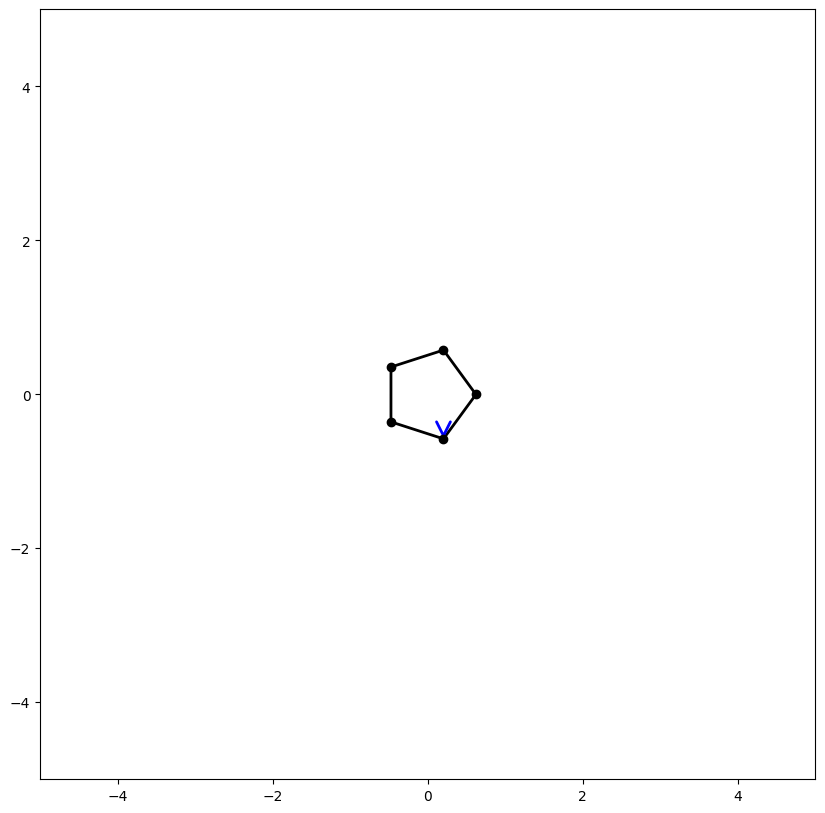

Iteration  260000 ff =  1.0150734971903775e-30 vv =  3.163555623959731e-30 power =  1.7919937139312434e-30


<Figure size 640x480 with 0 Axes>

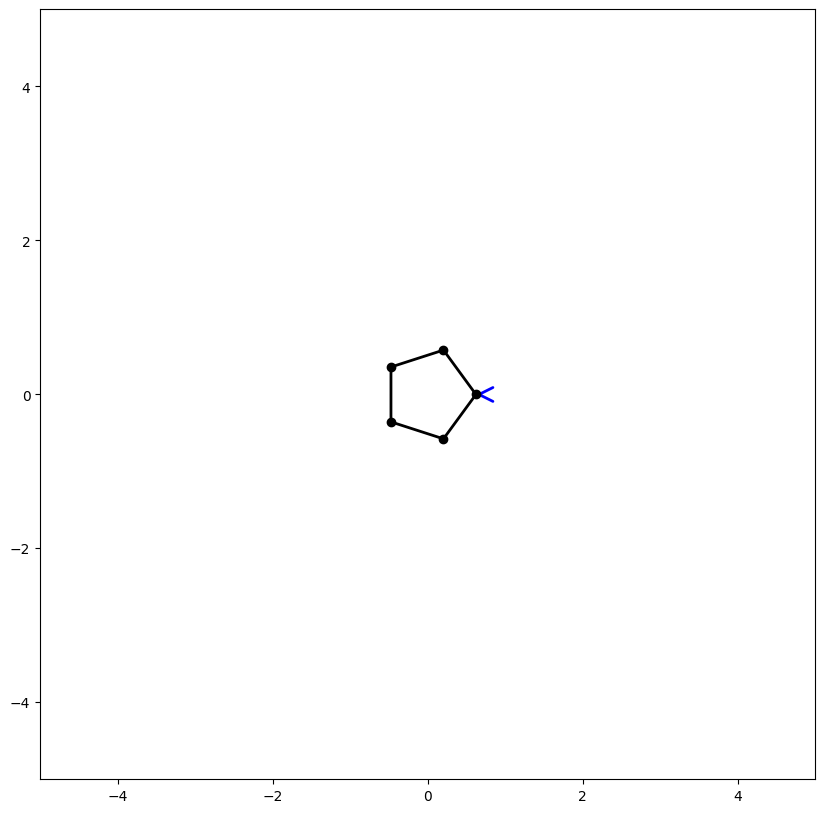

Iteration  261000 ff =  2.4580905233934452e-31 vv =  1.3753109280653523e-30 power =  5.814326064985423e-31


<Figure size 640x480 with 0 Axes>

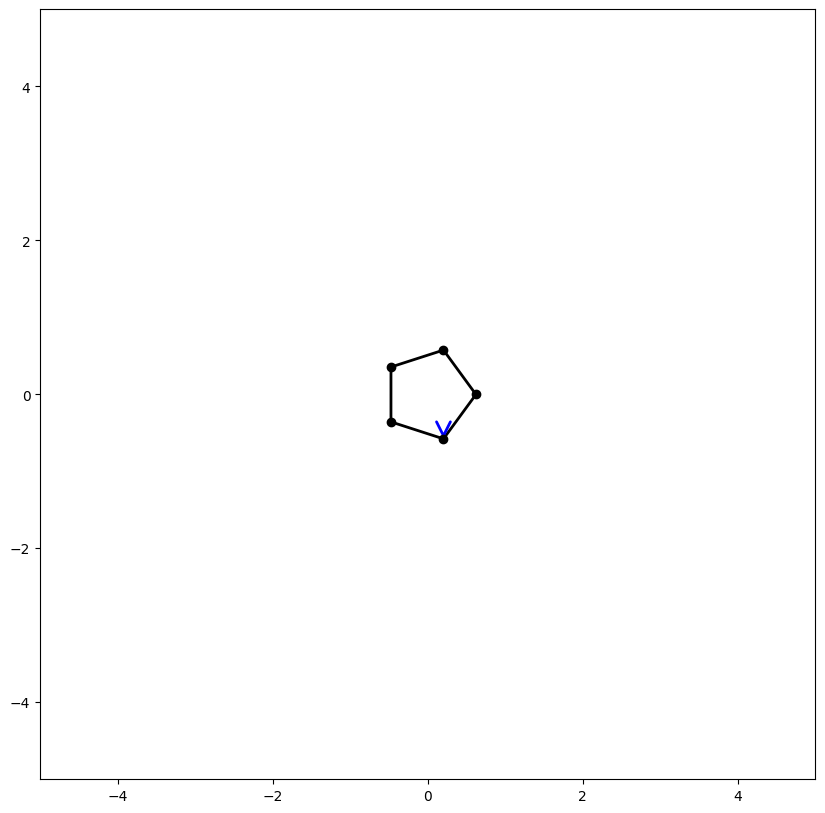

Iteration  262000 ff =  2.4580905233934452e-31 vv =  1.0330125424560959e-32 power =  5.039085572956564e-32


<Figure size 640x480 with 0 Axes>

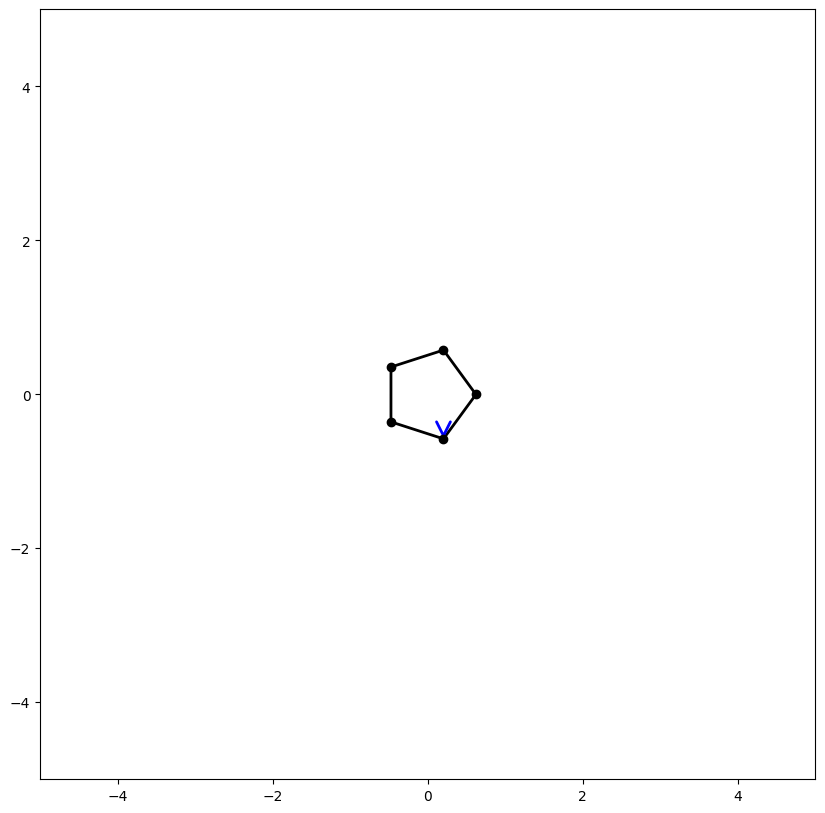

Iteration  263000 ff =  1.0150734971903775e-30 vv =  3.1981159370854335e-32 power =  1.8017554575129205e-31


<Figure size 640x480 with 0 Axes>

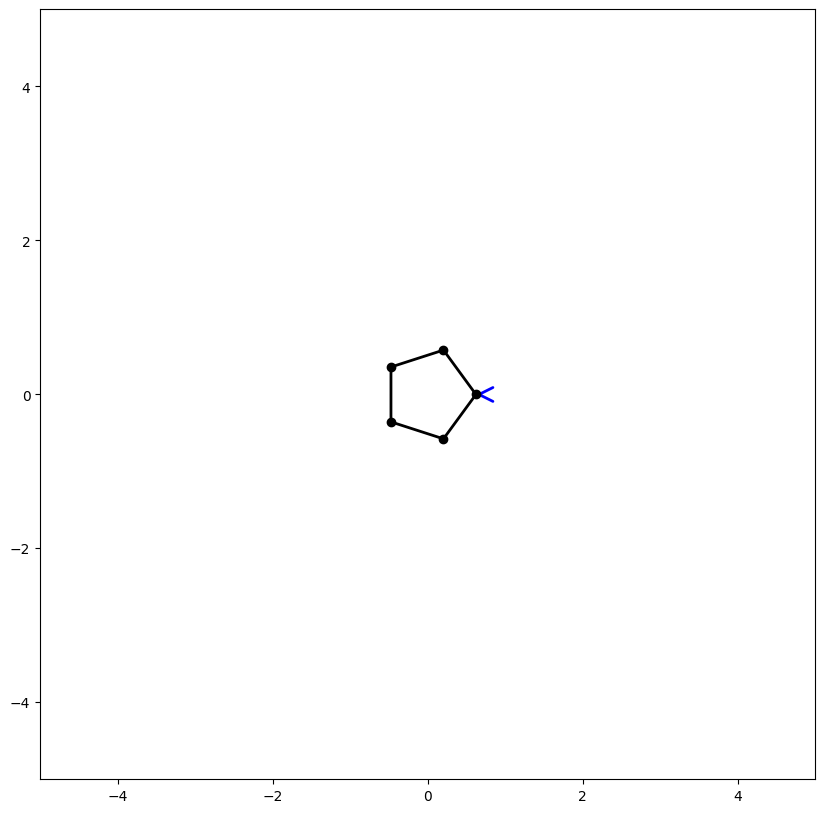

Iteration  264000 ff =  2.4580905233934452e-31 vv =  6.898914978722223e-32 power =  1.3022349070307627e-31


<Figure size 640x480 with 0 Axes>

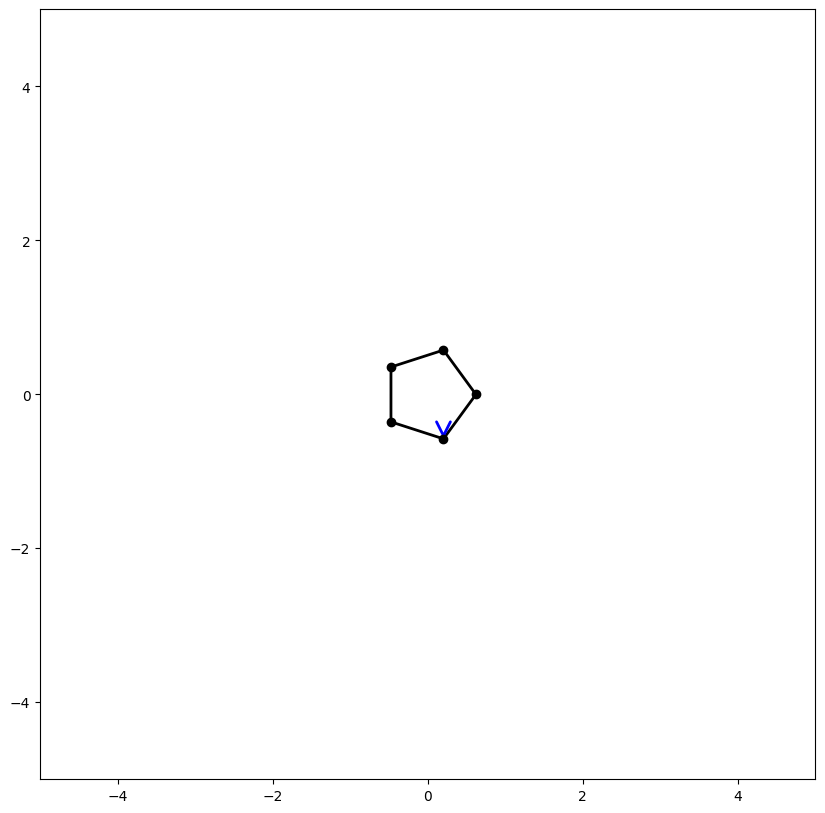

Iteration  265000 ff =  1.0150734971903775e-30 vv =  2.502280517077687e-31 power =  5.039839913550225e-31


<Figure size 640x480 with 0 Axes>

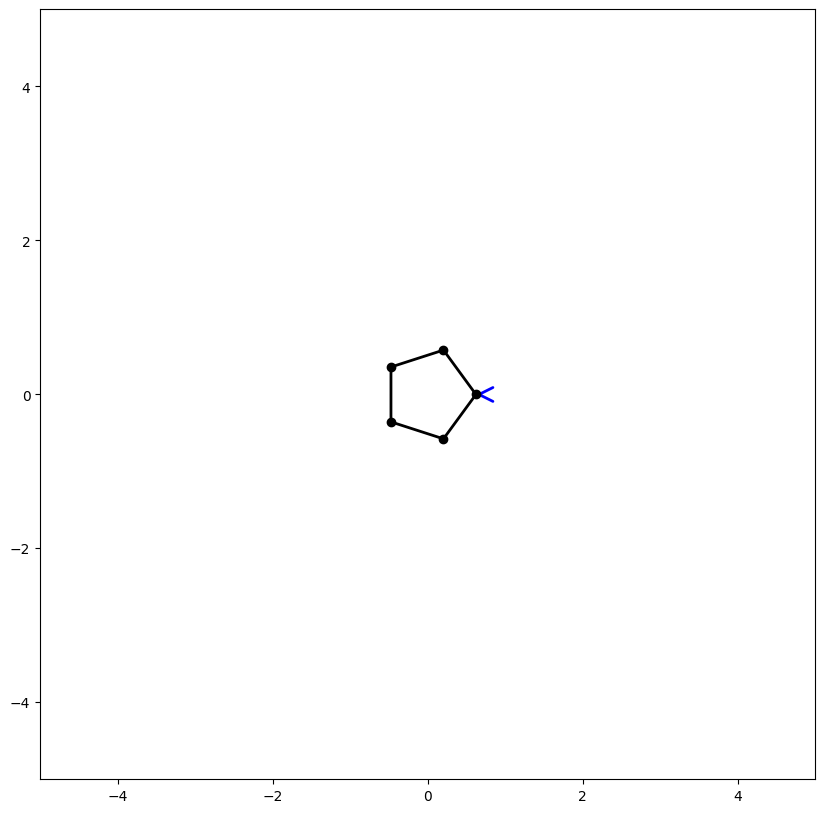

Iteration  266000 ff =  2.4580905233934452e-31 vv =  2.0614174808123293e-31 power =  2.251033268155399e-31


<Figure size 640x480 with 0 Axes>

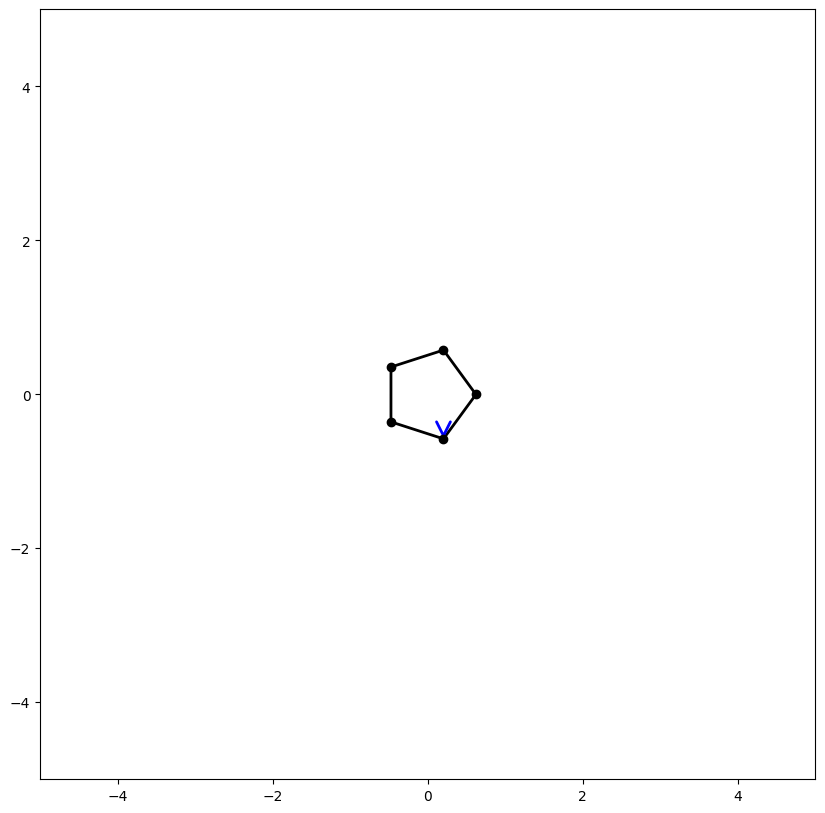

Iteration  267000 ff =  1.0150734971903775e-30 vv =  7.8457740986826506e-31 power =  8.924145534736353e-31


<Figure size 640x480 with 0 Axes>

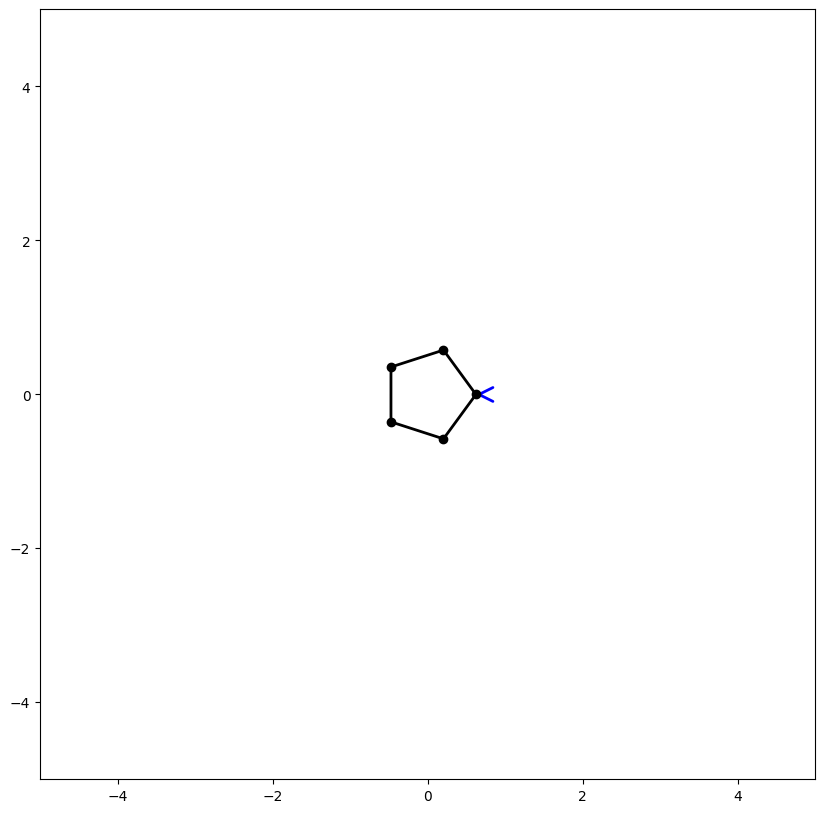

Iteration  268000 ff =  2.4580905233934452e-31 vv =  4.672959275520122e-31 power =  3.389182336694134e-31


<Figure size 640x480 with 0 Axes>

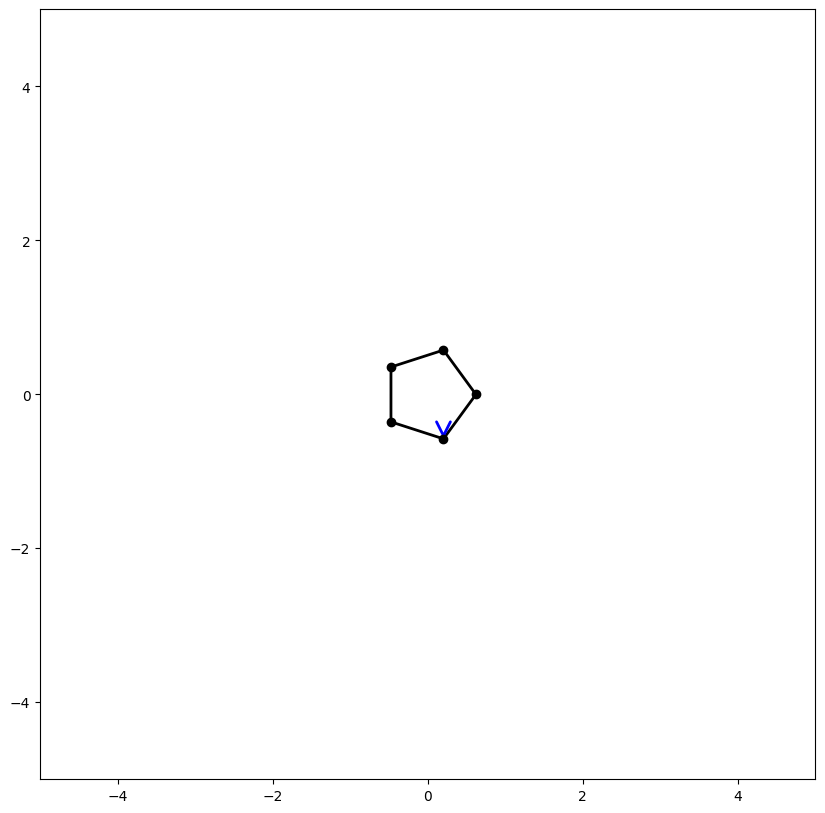

Iteration  269000 ff =  1.0150734971903775e-30 vv =  1.8077279920308e-30 power =  1.354613145824166e-30


<Figure size 640x480 with 0 Axes>

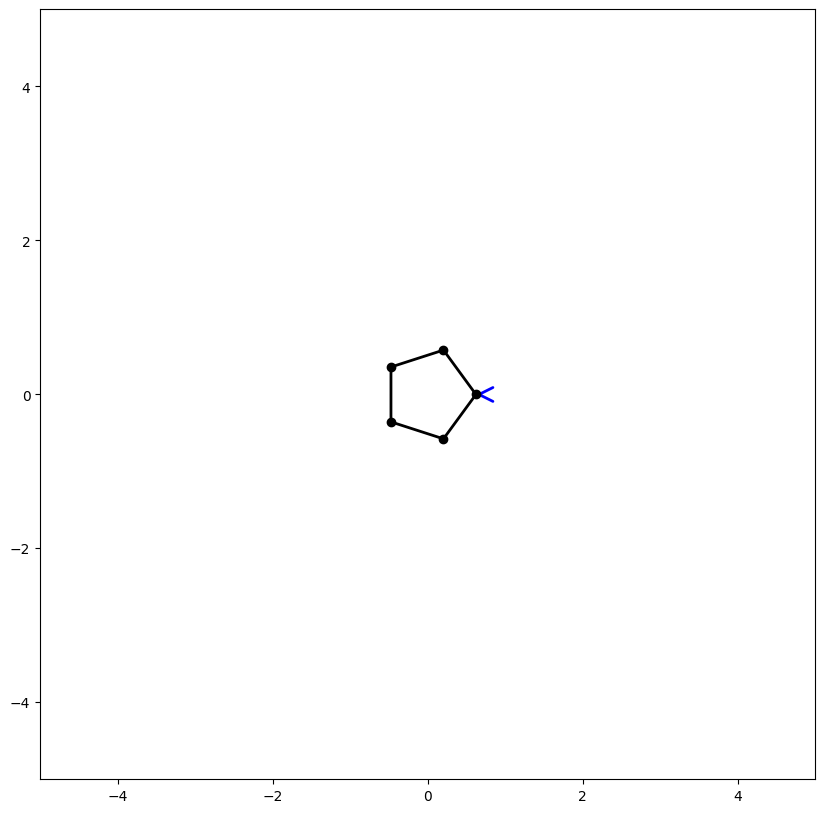

Iteration  270000 ff =  2.4580905233934452e-31 vv =  9.01797915315382e-31 power =  4.708185329458373e-31


<Figure size 640x480 with 0 Axes>

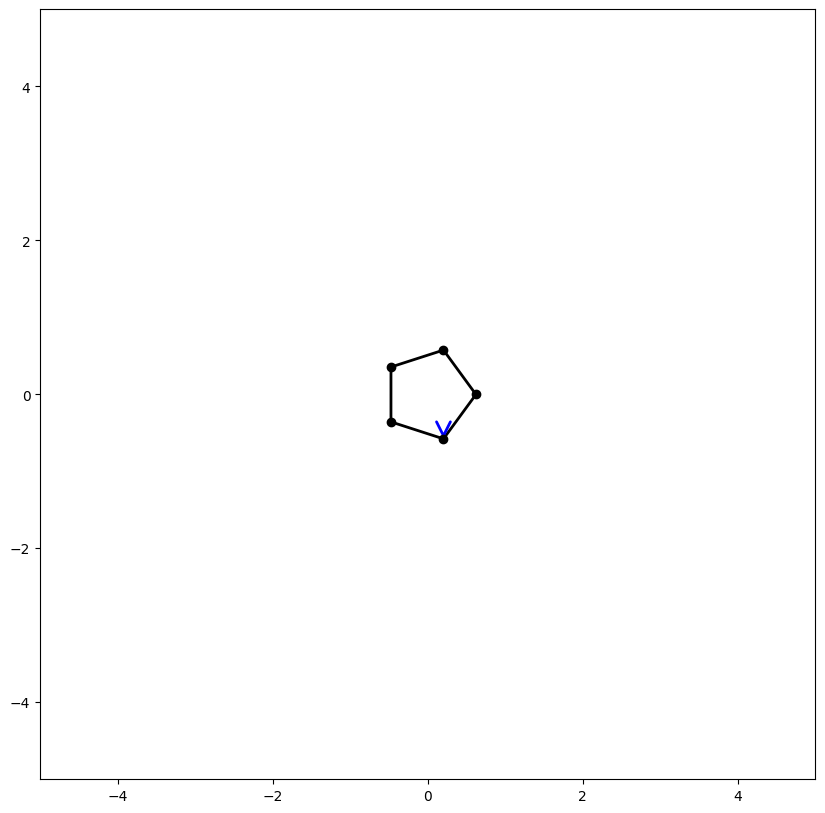

Iteration  271000 ff =  1.0150734971903775e-30 vv =  3.532105101717883e-30 power =  1.893501063650281e-30


<Figure size 640x480 with 0 Axes>

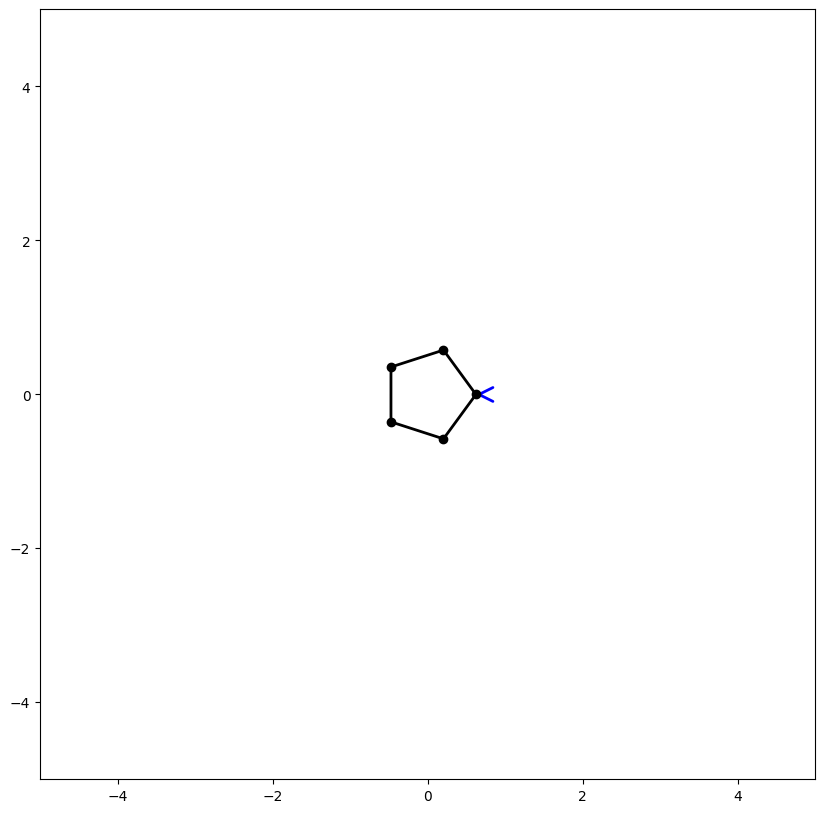

Iteration  272000 ff =  2.4580905233934452e-31 vv =  1.4940555398884537e-30 power =  6.060135117324766e-31


<Figure size 640x480 with 0 Axes>

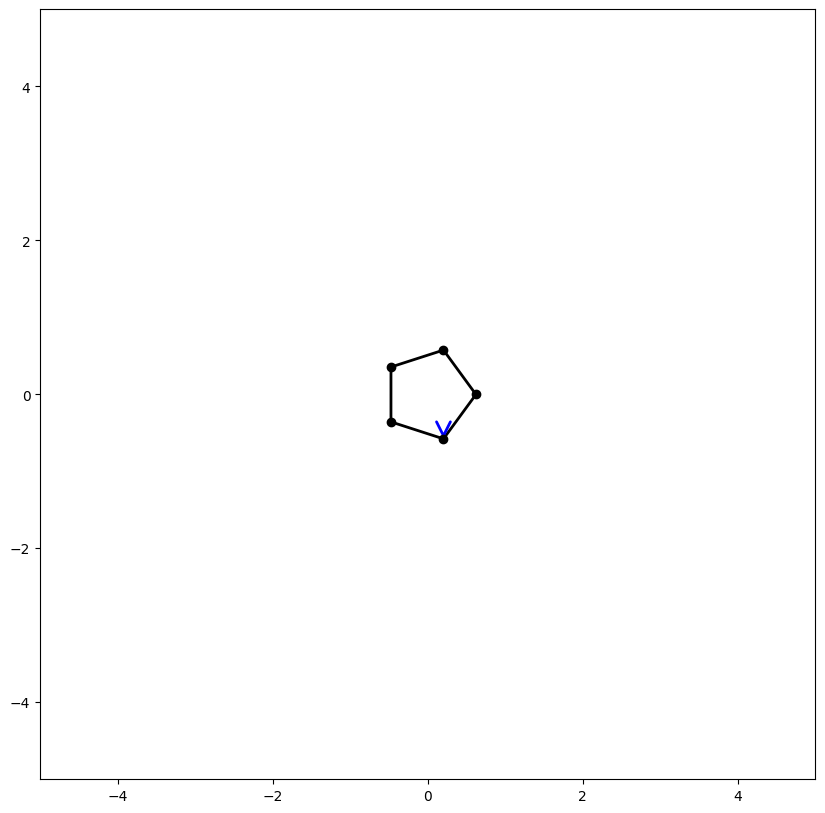

Iteration  273000 ff =  2.4580905233934452e-31 vv =  1.66166919381397e-32 power =  6.391035360822959e-32


<Figure size 640x480 with 0 Axes>

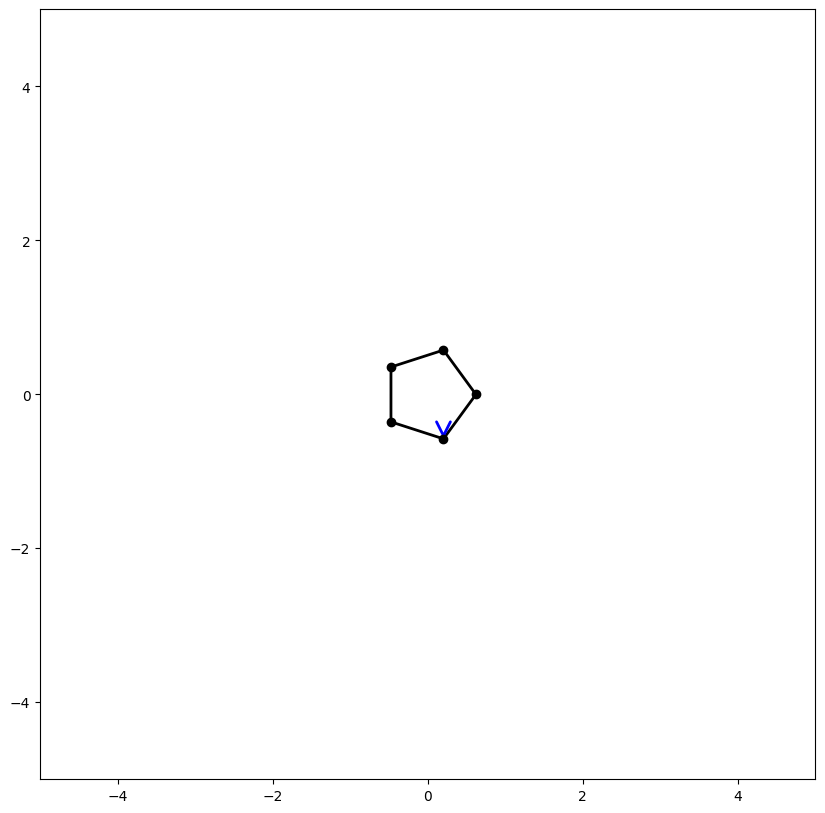

Iteration  274000 ff =  1.0150734971903775e-30 vv =  5.487106673249736e-32 power =  2.3600458809676283e-31


<Figure size 640x480 with 0 Axes>

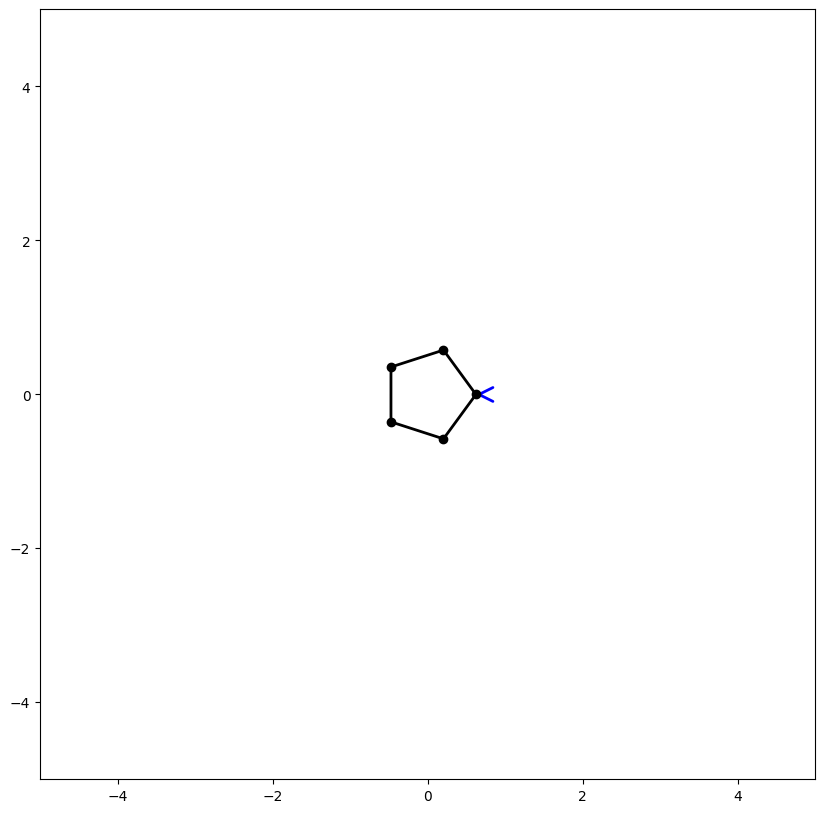

Iteration  275000 ff =  2.4580905233934452e-31 vv =  8.741056072623007e-32 power =  1.4658208313625967e-31


<Figure size 640x480 with 0 Axes>

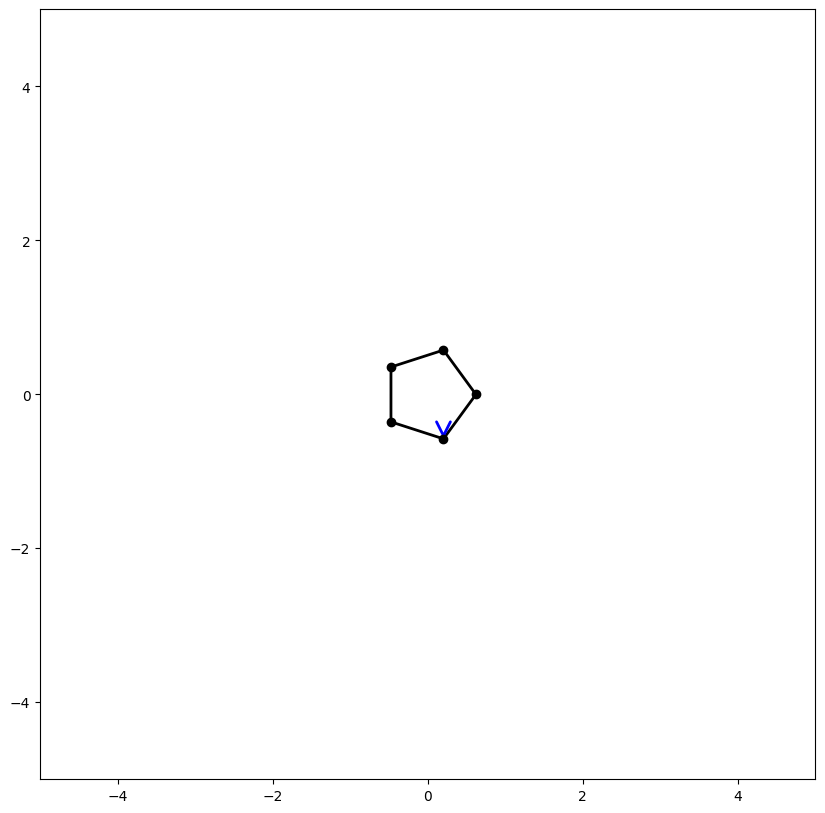

Iteration  276000 ff =  1.0150734971903775e-30 vv =  3.2180398250651247e-31 power =  5.715371325930422e-31


<Figure size 640x480 with 0 Axes>

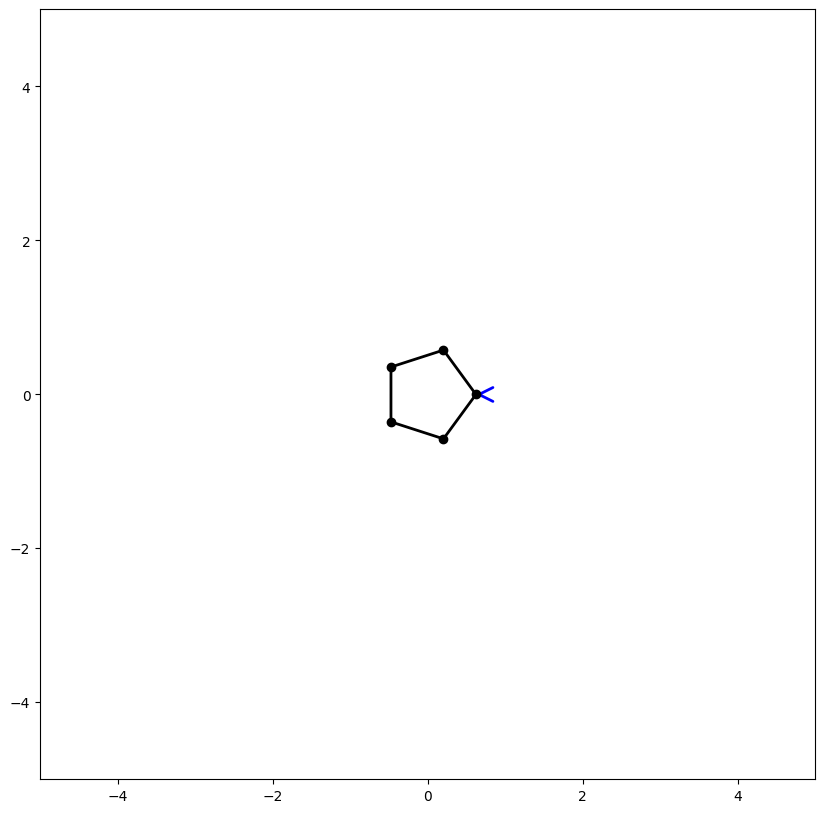

Iteration  277000 ff =  2.4580905233934452e-31 vv =  2.439887774085262e-31 power =  2.4489722365969182e-31


<Figure size 640x480 with 0 Axes>

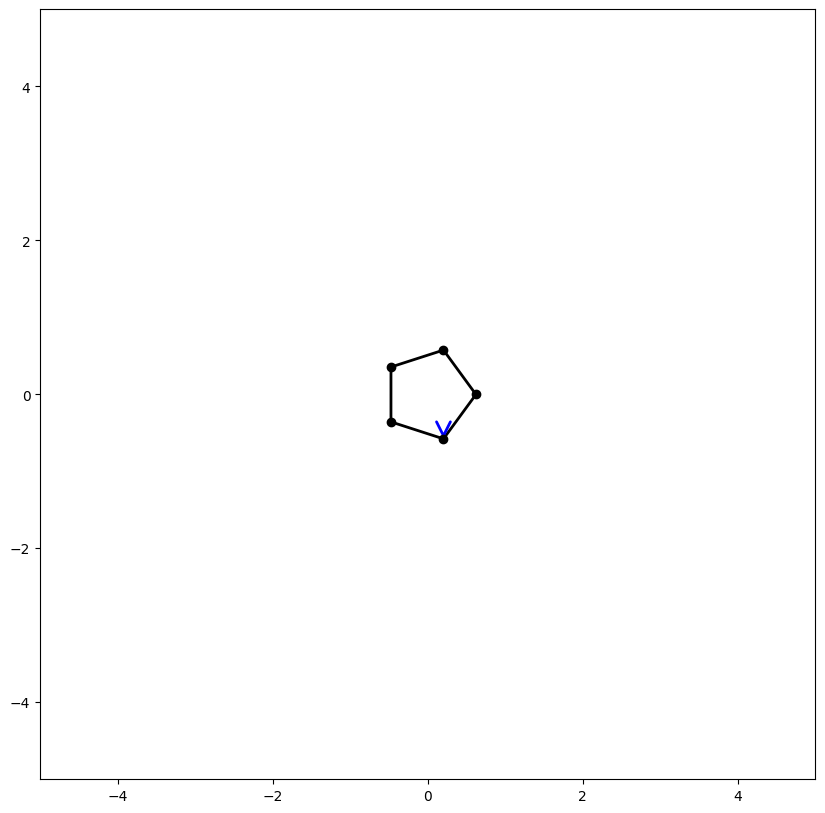

Iteration  278000 ff =  1.0150734971903775e-30 vv =  9.27766070279469e-31 power =  9.704384316035481e-31


<Figure size 640x480 with 0 Axes>

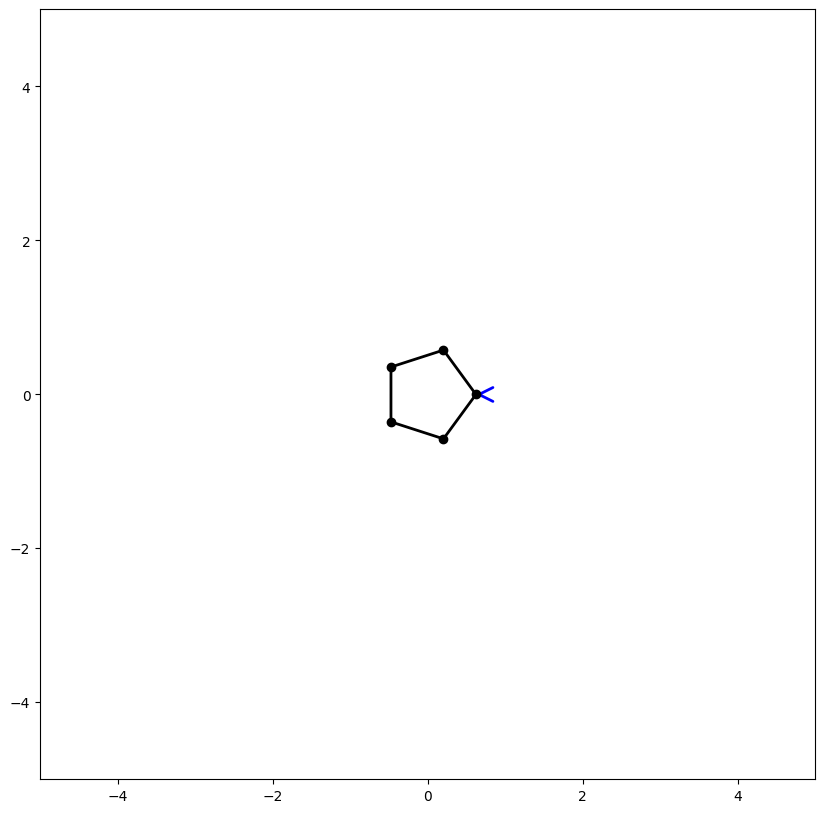

Iteration  279000 ff =  2.4580905233934452e-31 vv =  5.324657520497902e-31 power =  3.6178018452440884e-31


<Figure size 640x480 with 0 Axes>

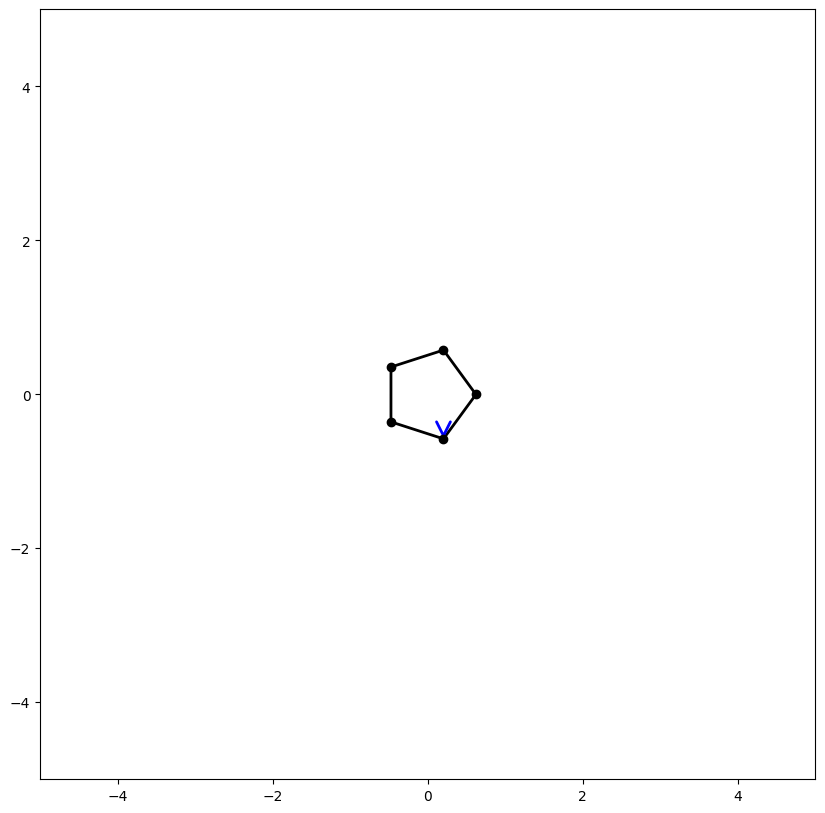

Iteration  280000 ff =  1.0150734971903775e-30 vv =  2.0556703126238404e-30 power =  1.4445263768119702e-30


<Figure size 640x480 with 0 Axes>

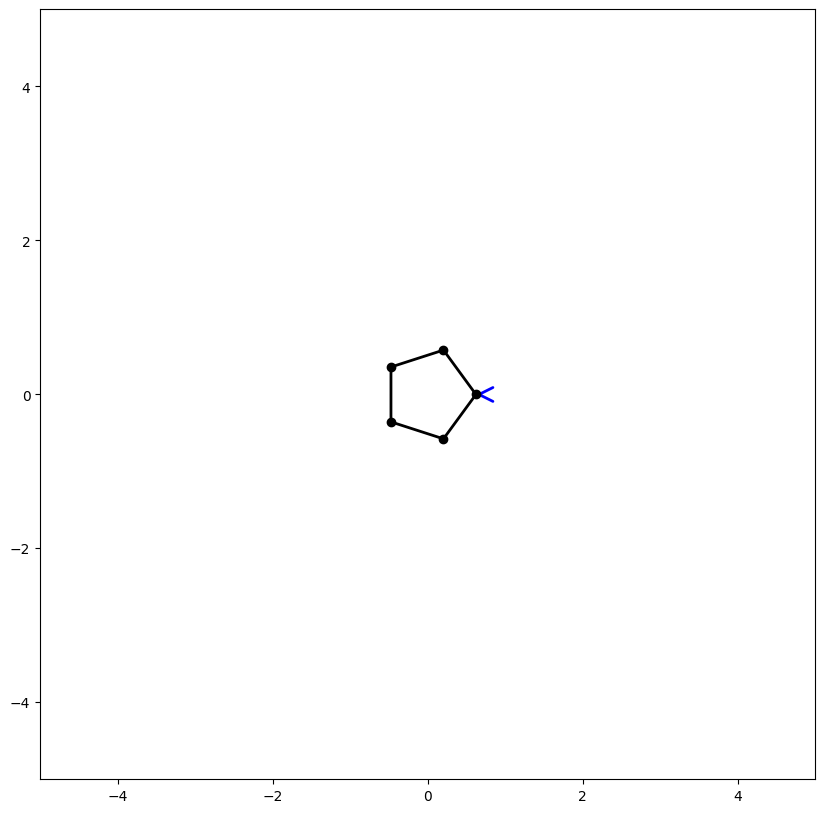

Iteration  281000 ff =  2.4580905233934452e-31 vv =  9.984197124279427e-31 power =  4.953994381797717e-31


<Figure size 640x480 with 0 Axes>

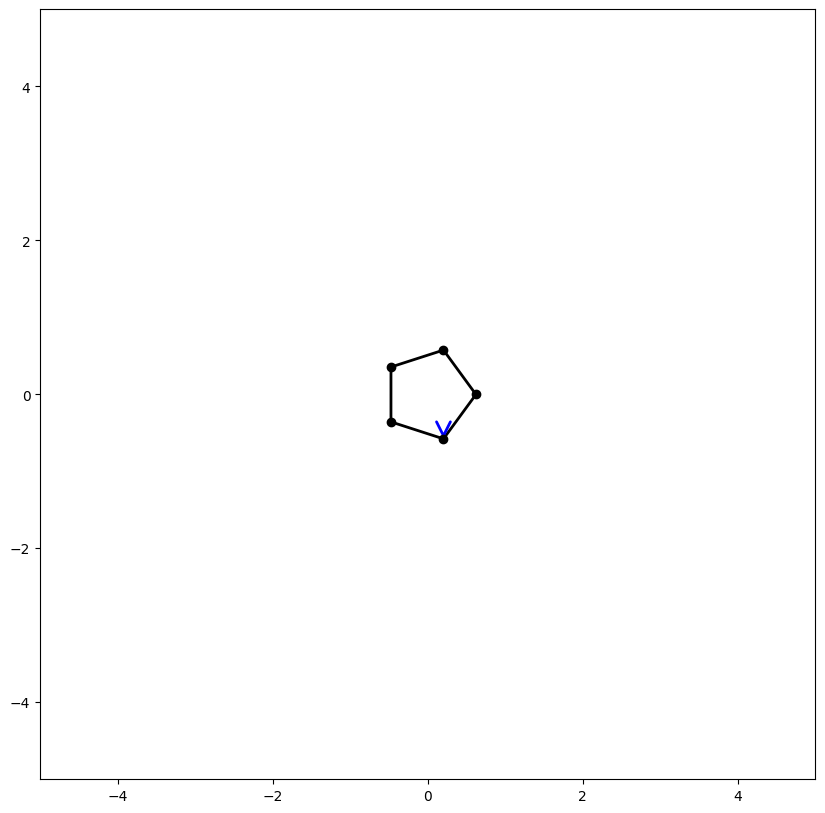

Iteration  282000 ff =  2.4580905233934452e-31 vv =  1.5363065771209036e-34 power =  6.145226308483614e-33


<Figure size 640x480 with 0 Axes>

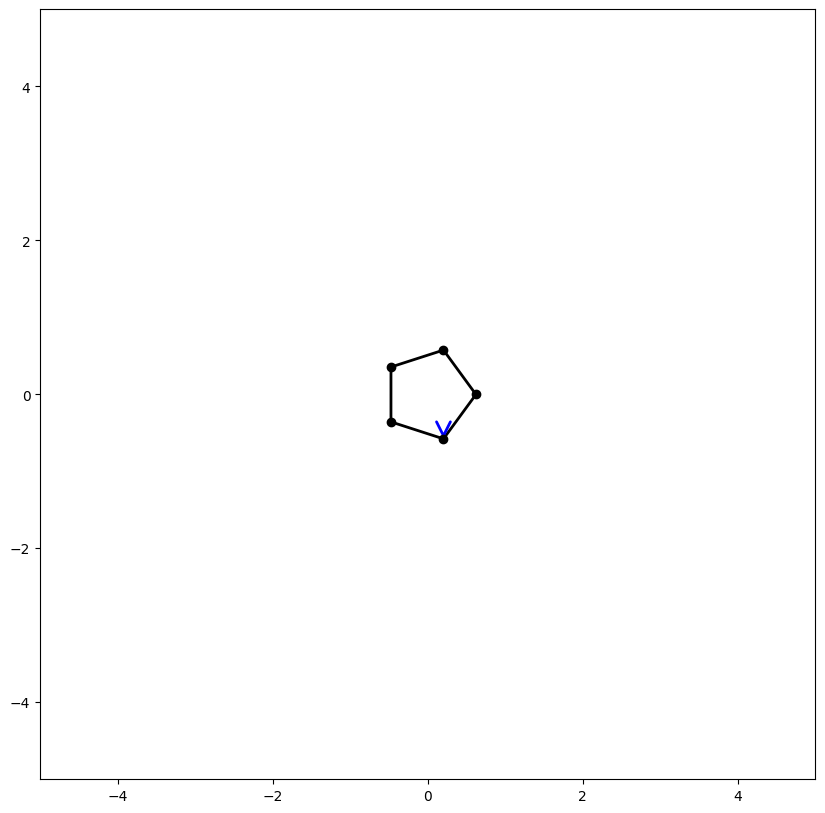

Iteration  283000 ff =  1.0150734971903775e-30 vv =  1.4523060522614651e-30 power =  -1.0042767768810839e-30


<Figure size 640x480 with 0 Axes>

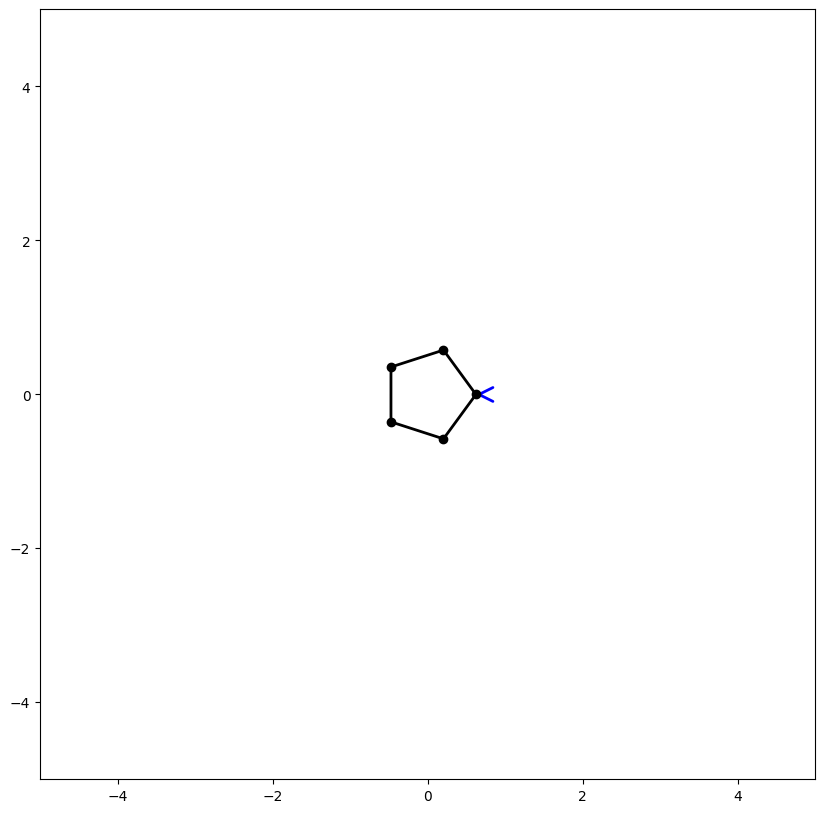

Iteration  284000 ff =  2.4580905233934452e-31 vv =  2.4390403218371479e-32 power =  7.742985148689355e-32


<Figure size 640x480 with 0 Axes>

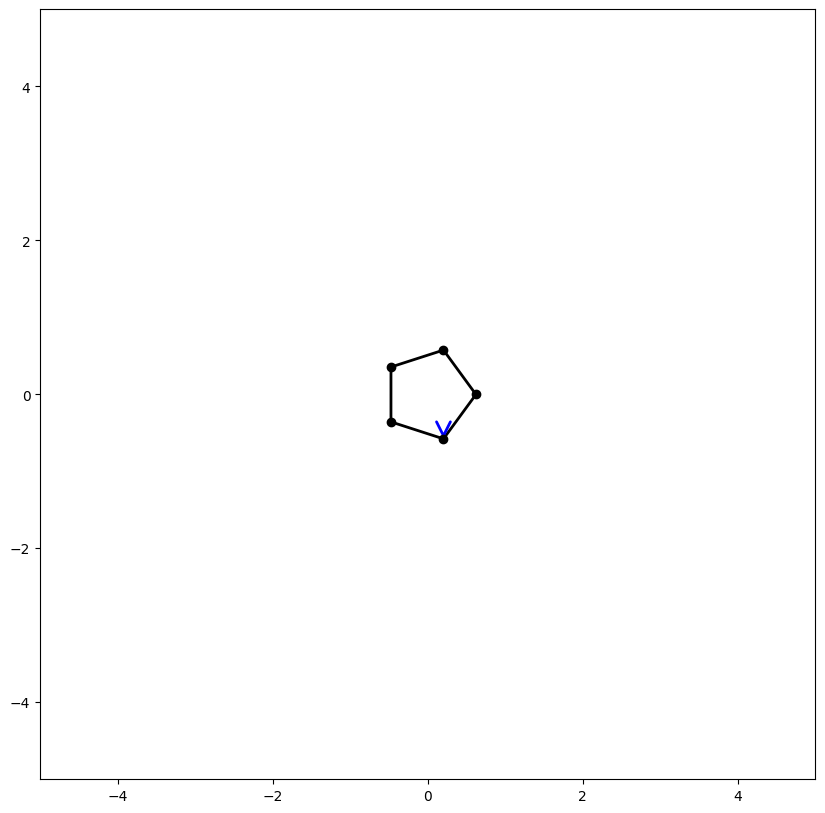

Iteration  285000 ff =  1.0150734971903775e-30 vv =  8.390216875214216e-32 power =  2.9183363044223356e-31


<Figure size 640x480 with 0 Axes>

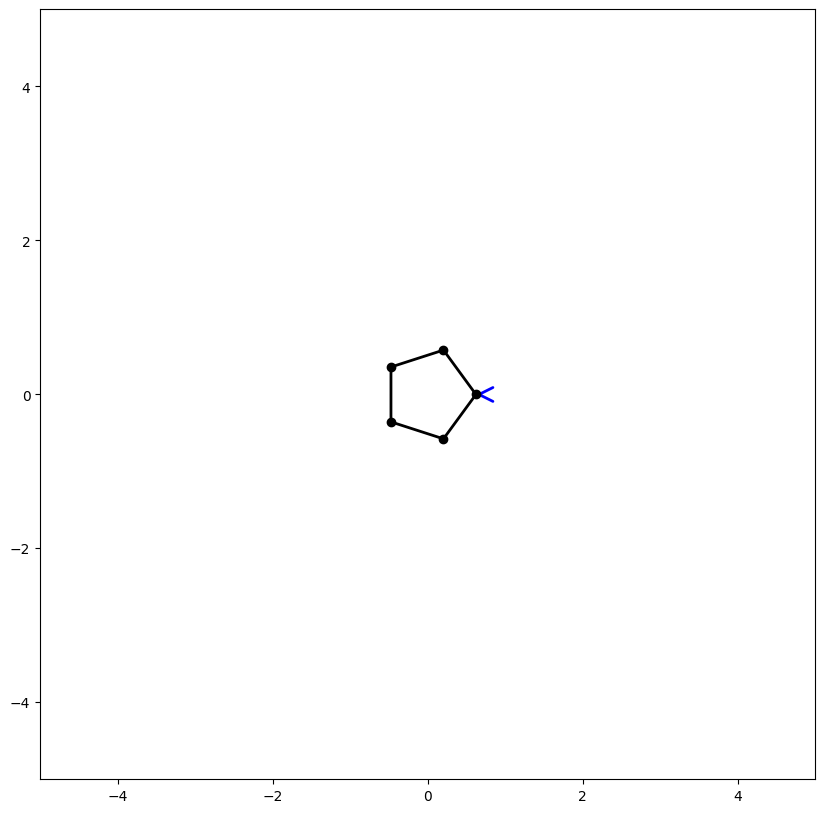

Iteration  286000 ff =  2.4580905233934452e-31 vv =  1.080093003180946e-31 power =  1.6294067556944308e-31


<Figure size 640x480 with 0 Axes>

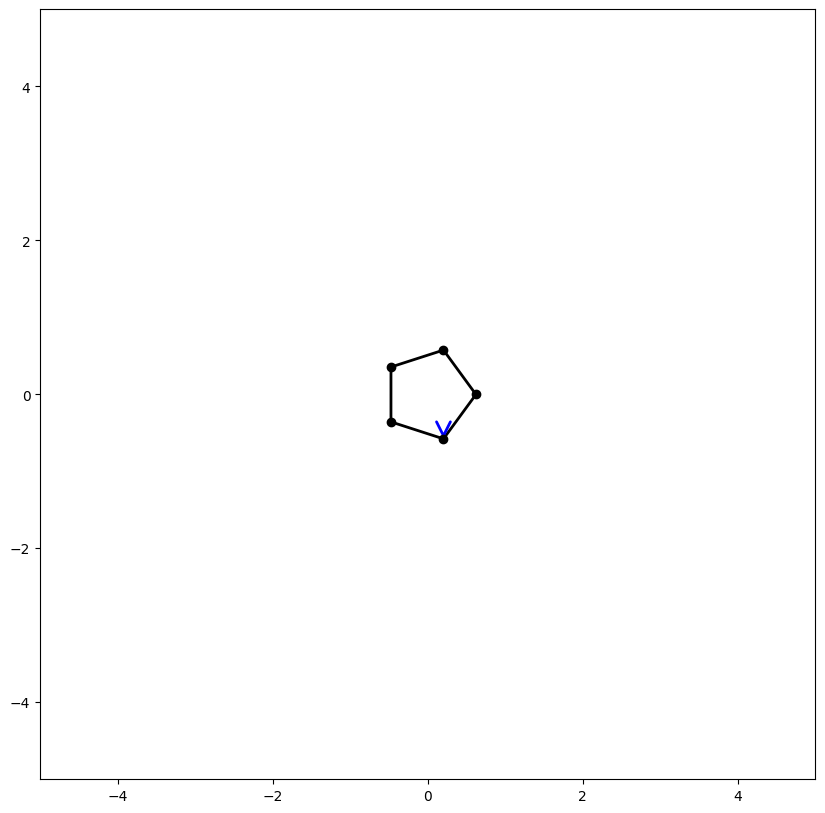

Iteration  287000 ff =  1.0150734971903775e-30 vv =  4.0237123640403655e-31 power =  6.3909027383106186e-31


<Figure size 640x480 with 0 Axes>

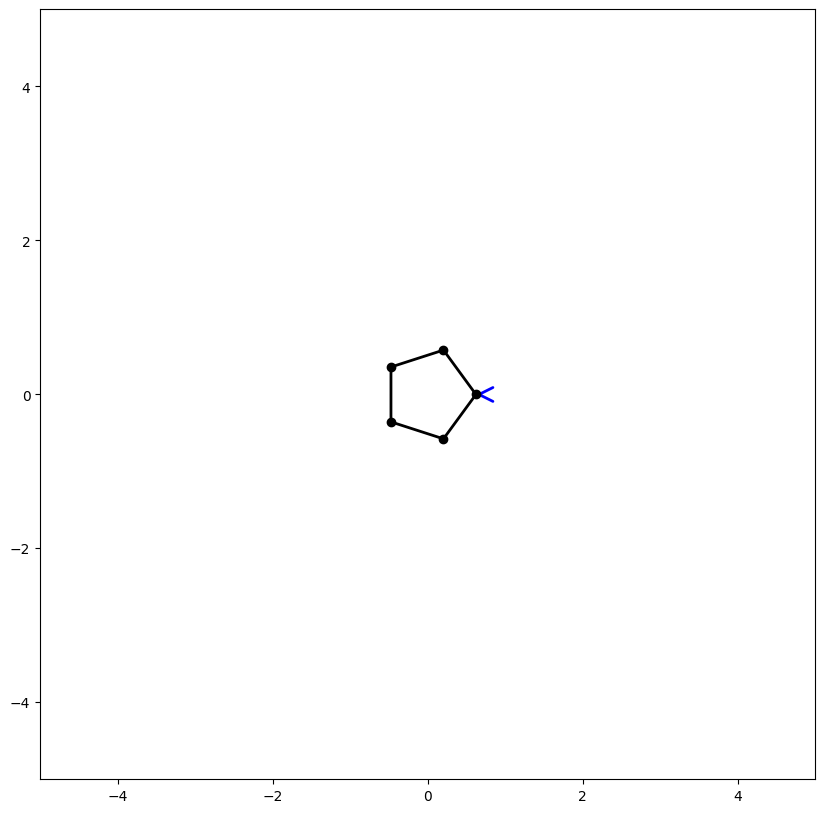

Iteration  288000 ff =  2.4580905233934452e-31 vv =  2.85023633616467e-31 power =  2.646911205038437e-31


<Figure size 640x480 with 0 Axes>

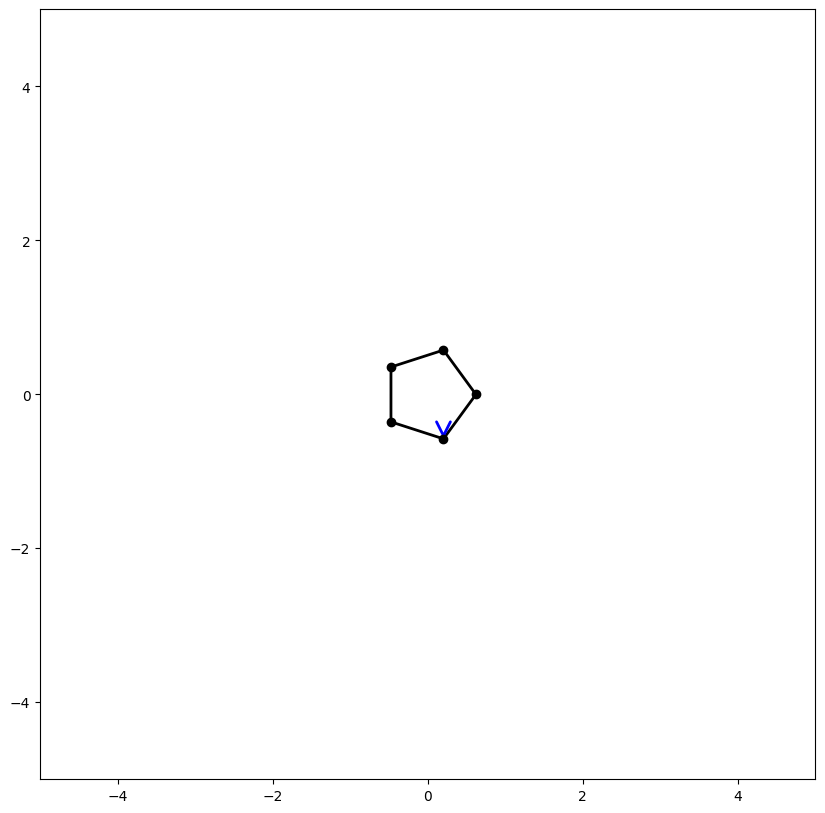

Iteration  289000 ff =  1.0150734971903775e-30 vv =  1.090638248202114e-30 power =  1.0521777325015517e-30


<Figure size 640x480 with 0 Axes>

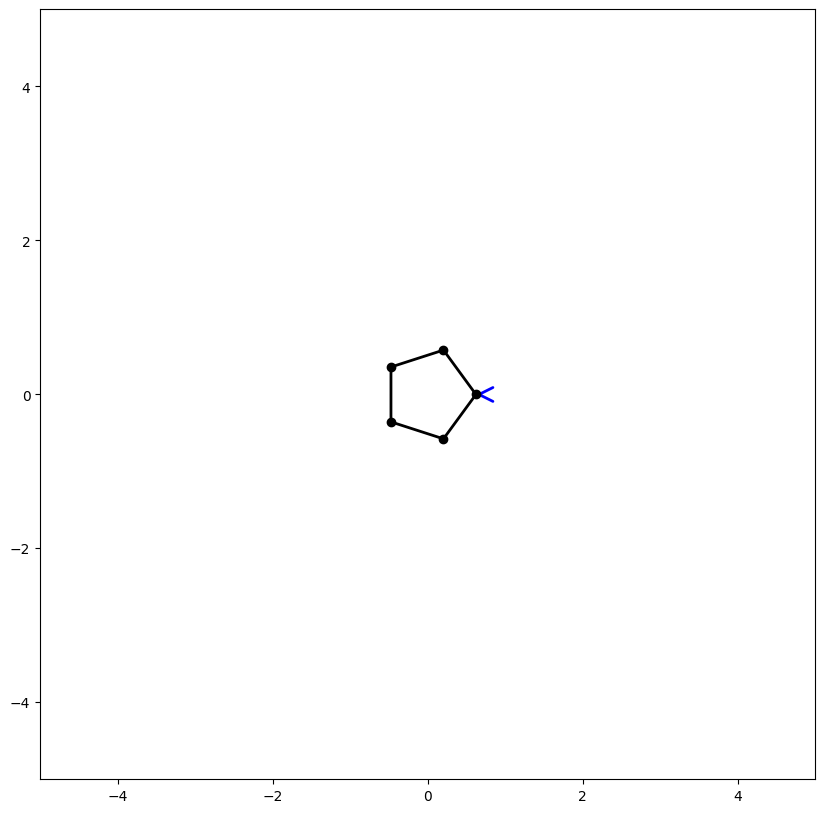

Iteration  290000 ff =  2.4580905233934452e-31 vv =  6.053001239201554e-31 power =  3.8573079970583263e-31


<Figure size 640x480 with 0 Axes>

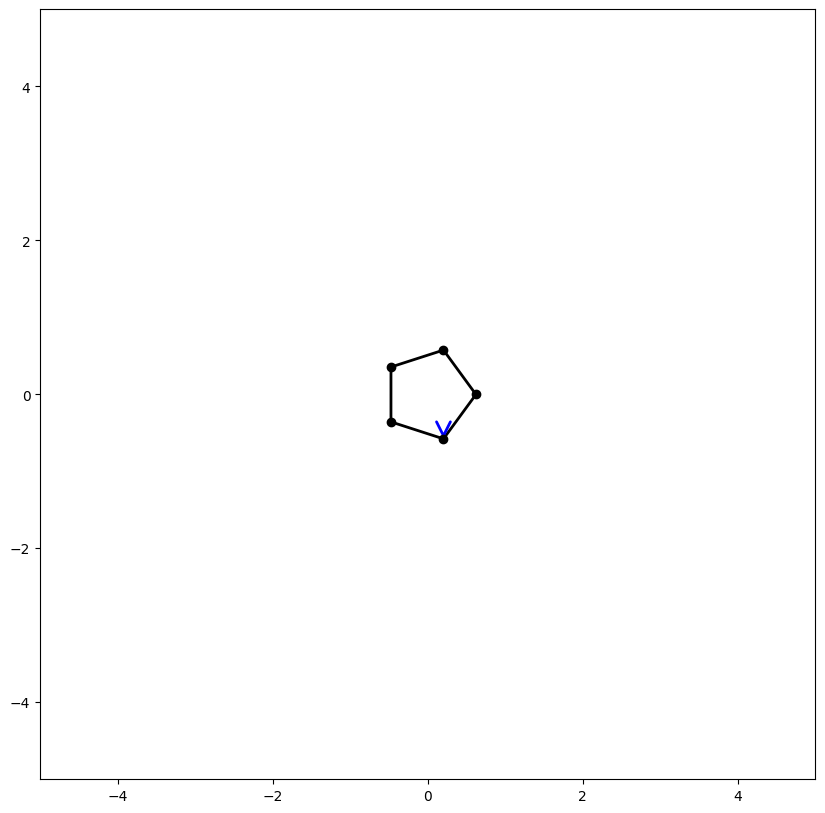

Iteration  291000 ff =  1.0150734971903775e-30 vv =  2.3468044876041146e-30 power =  1.5434309308985554e-30


<Figure size 640x480 with 0 Axes>

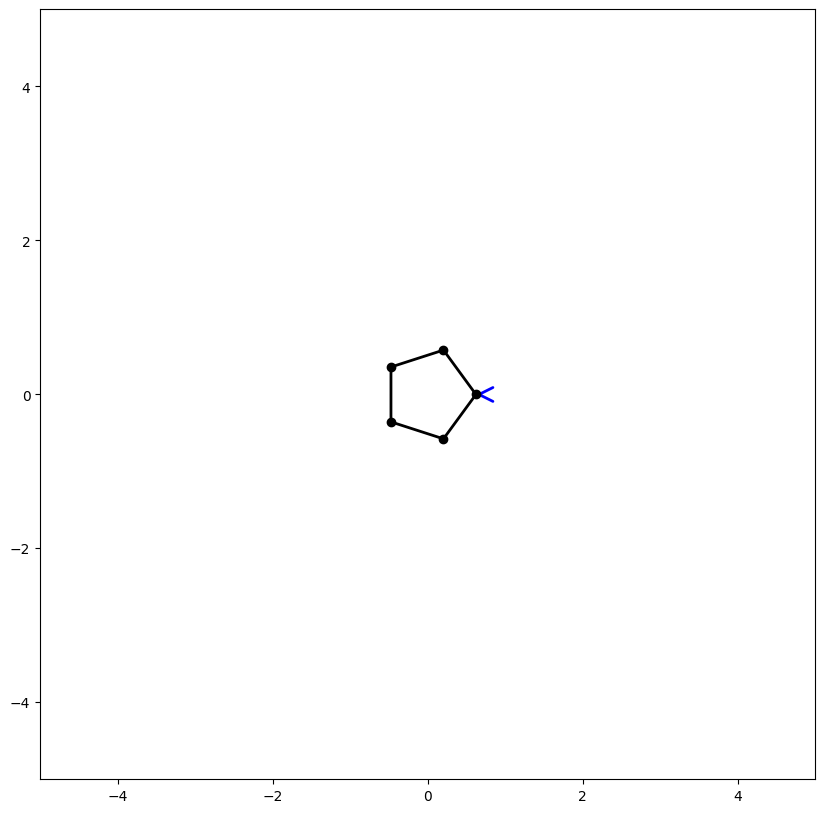

Iteration  292000 ff =  2.4580905233934452e-31 vv =  1.0999576905872905e-30 power =  5.199803434137061e-31


<Figure size 640x480 with 0 Axes>

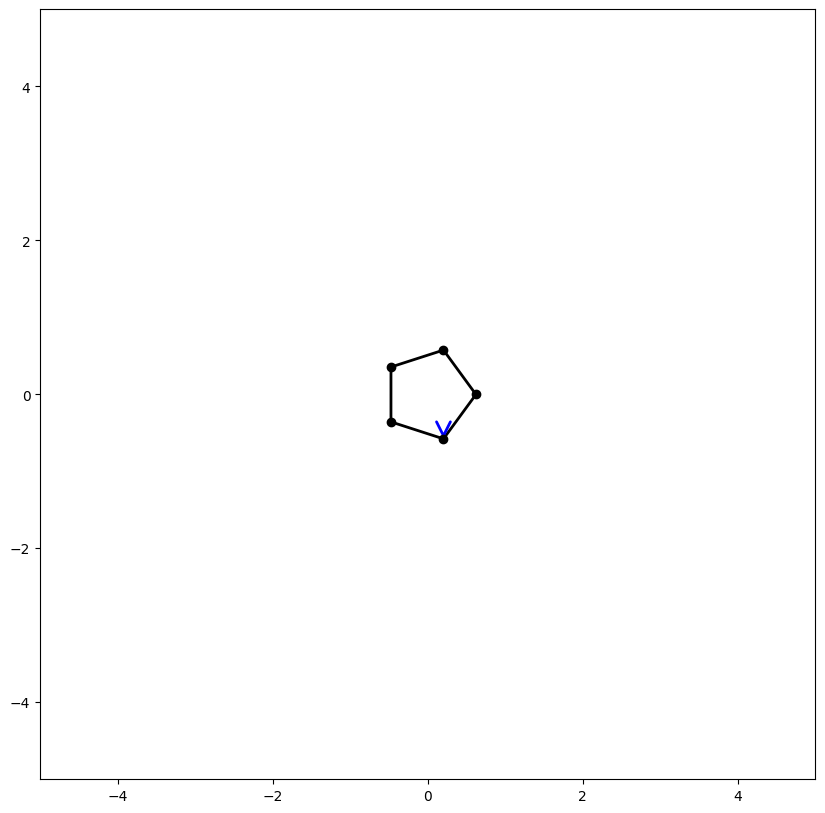

Iteration  293000 ff =  2.4580905233934452e-31 vv =  1.3826759194088132e-33 power =  1.843567892545084e-32


<Figure size 640x480 with 0 Axes>

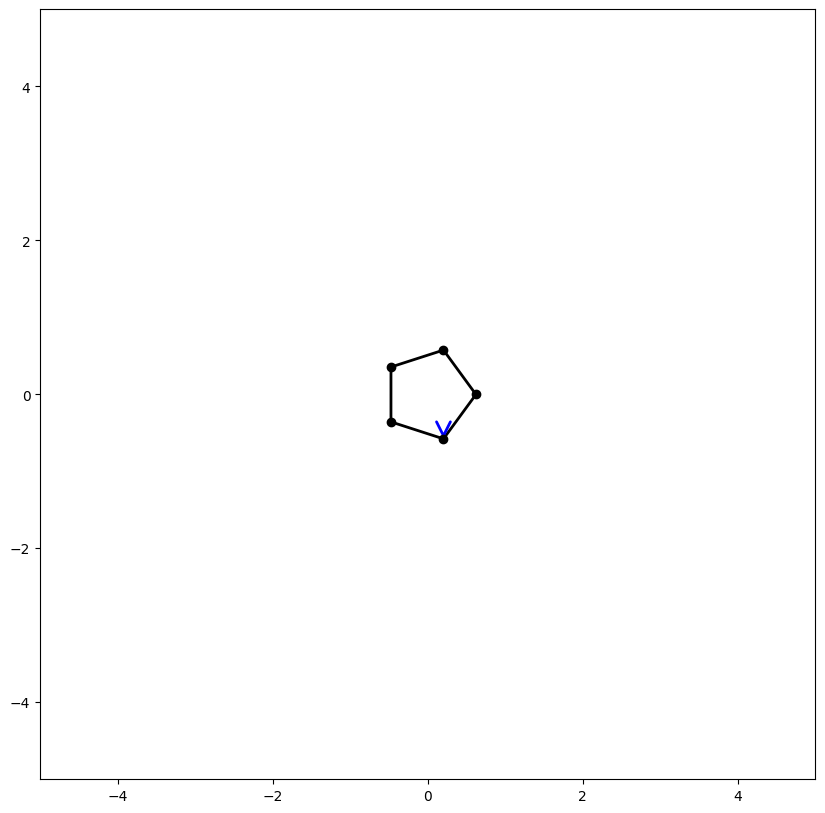

Iteration  294000 ff =  1.0150734971903775e-30 vv =  2.5376837429759438e-33 power =  5.075367485951889e-32


<Figure size 640x480 with 0 Axes>

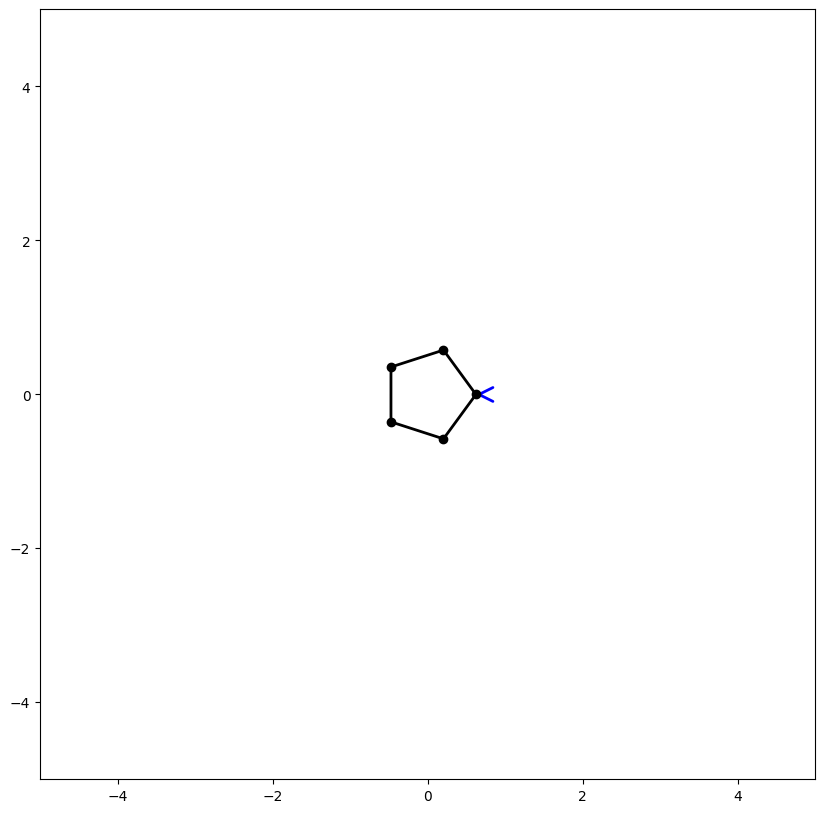

Iteration  295000 ff =  2.4580905233934452e-31 vv =  3.4659137832110675e-32 power =  9.230129915342389e-32


<Figure size 640x480 with 0 Axes>

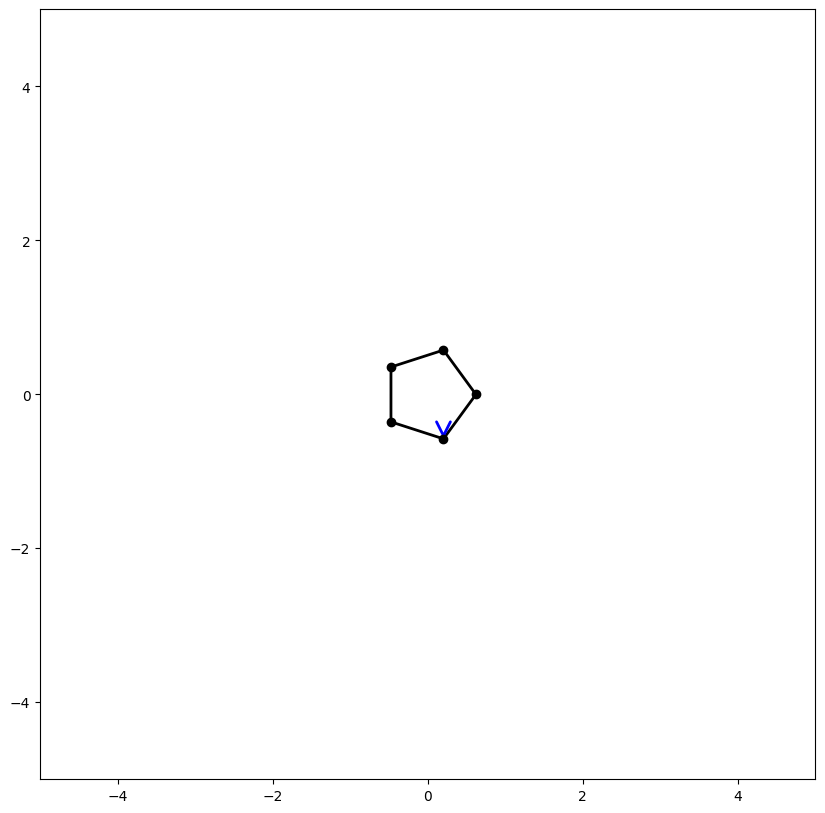

Iteration  296000 ff =  1.0150734971903775e-30 vv =  1.2099428662344363e-31 power =  3.504541249049779e-31


<Figure size 640x480 with 0 Axes>

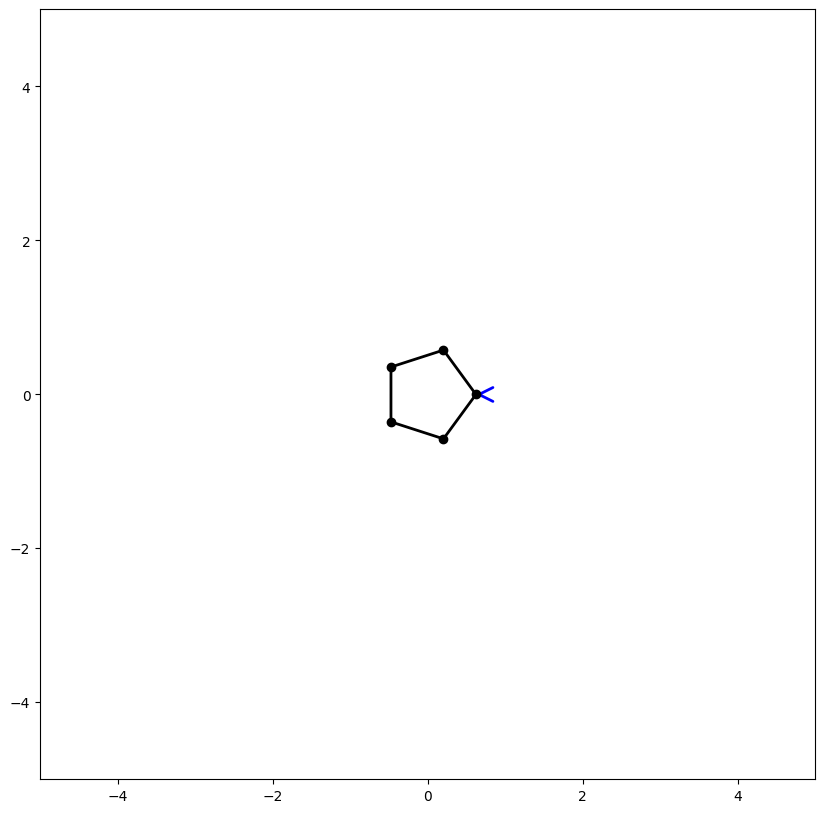

Iteration  297000 ff =  2.4580905233934452e-31 vv =  1.3198132685218938e-31 power =  1.8011719762428565e-31


<Figure size 640x480 with 0 Axes>

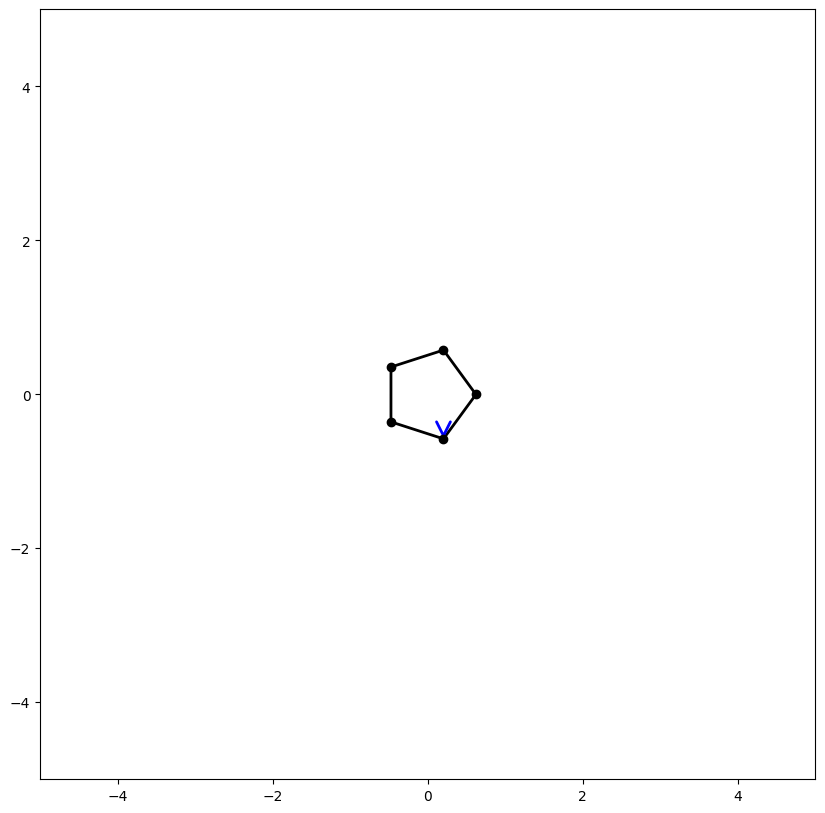

Iteration  298000 ff =  1.0150734971903775e-30 vv =  4.919298134003411e-31 power =  7.066434150690815e-31


<Figure size 640x480 with 0 Axes>

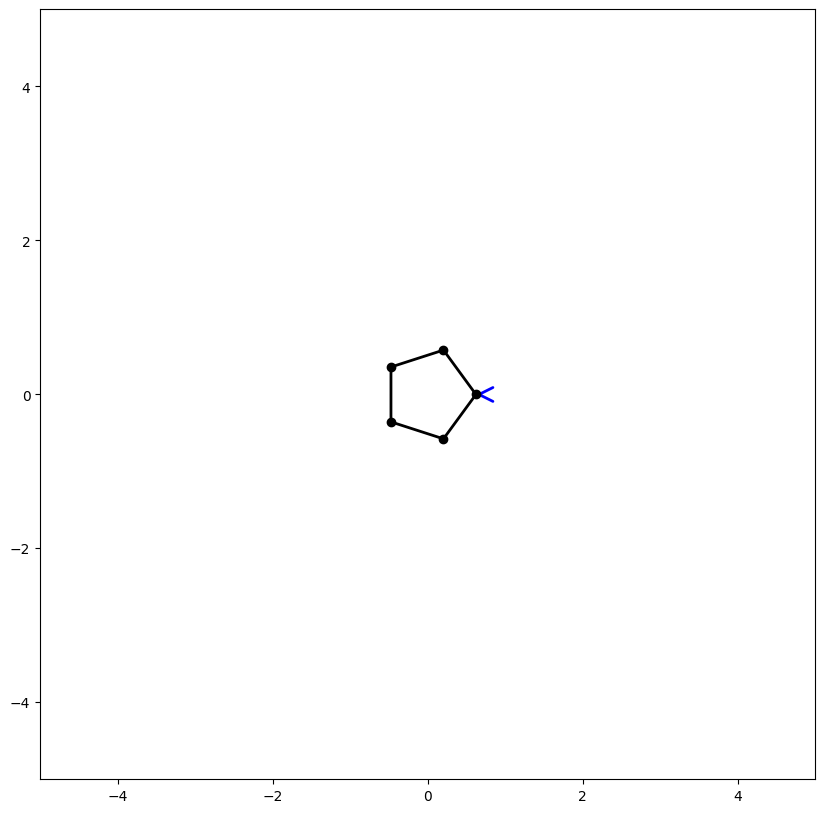

Iteration  299000 ff =  2.4580905233934452e-31 vv =  3.292463167050553e-31 power =  2.8448501734799555e-31


<Figure size 640x480 with 0 Axes>

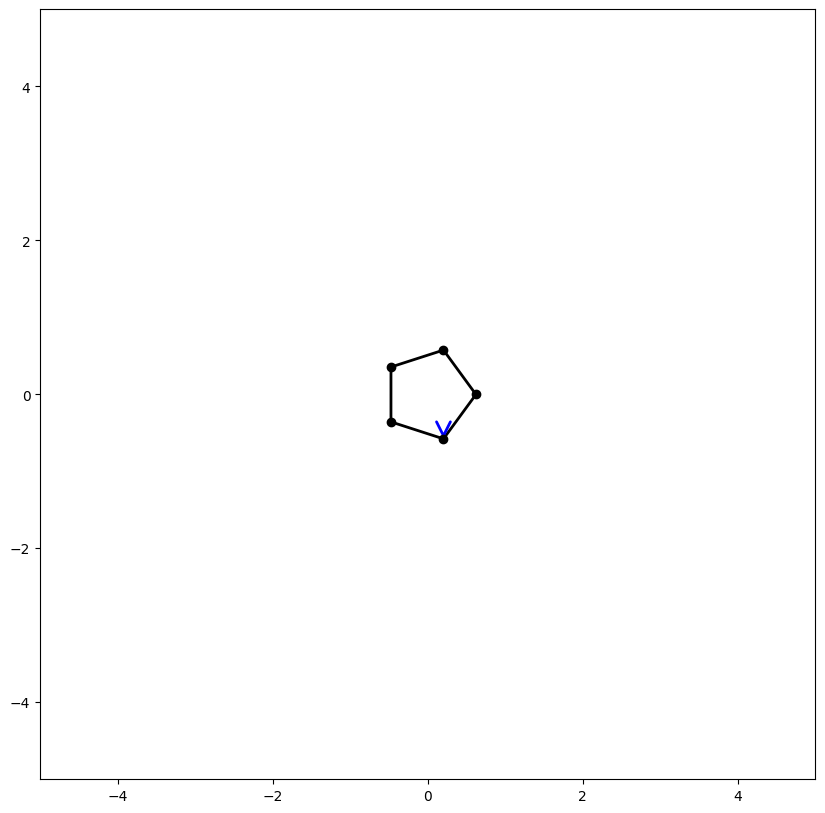

Iteration  300000 ff =  1.0150734971903775e-30 vv =  1.2666746222736837e-30 power =  1.1339170333995555e-30


<Figure size 640x480 with 0 Axes>

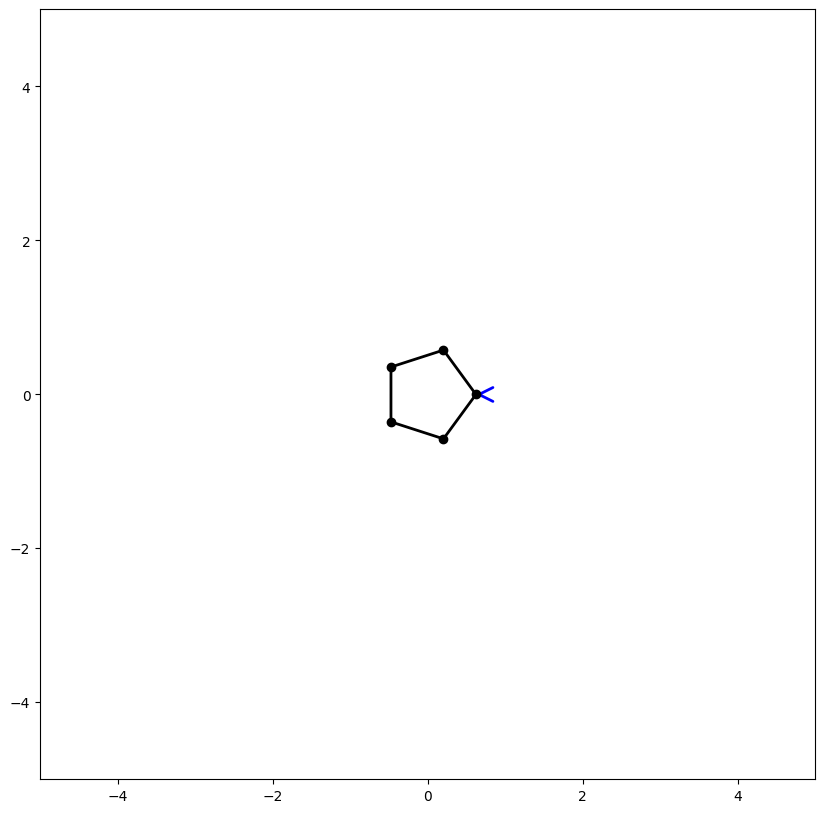

Iteration  301000 ff =  2.4580905233934452e-31 vv =  6.828017931264766e-31 power =  4.0968141488725655e-31


<Figure size 640x480 with 0 Axes>

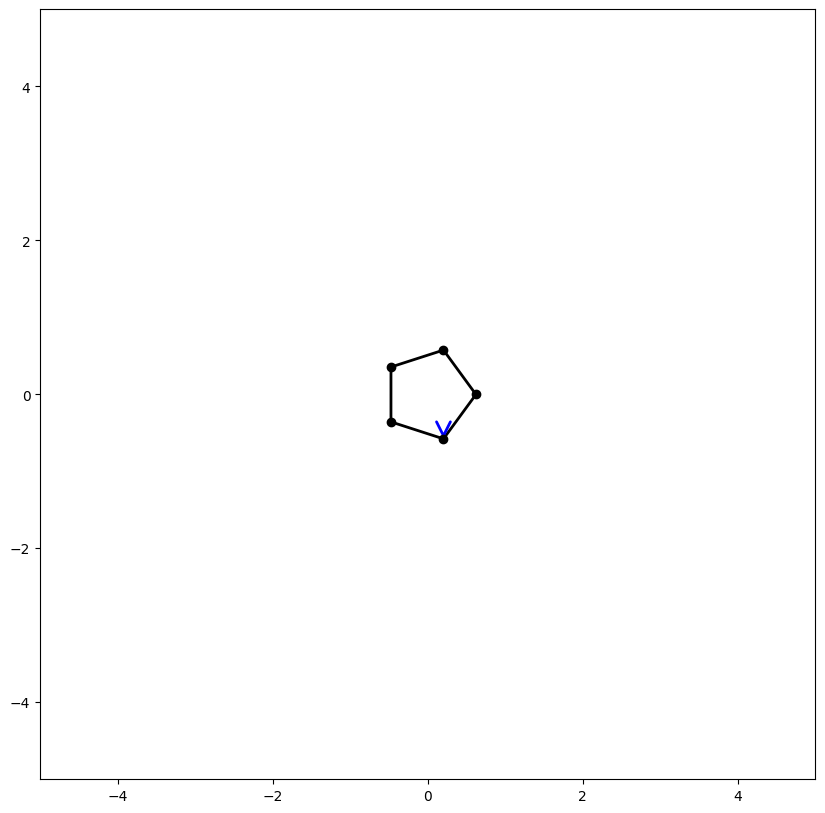

Iteration  302000 ff =  1.0150734971903775e-30 vv =  2.657212362166028e-30 power =  1.6423354849851395e-30


<Figure size 640x480 with 0 Axes>

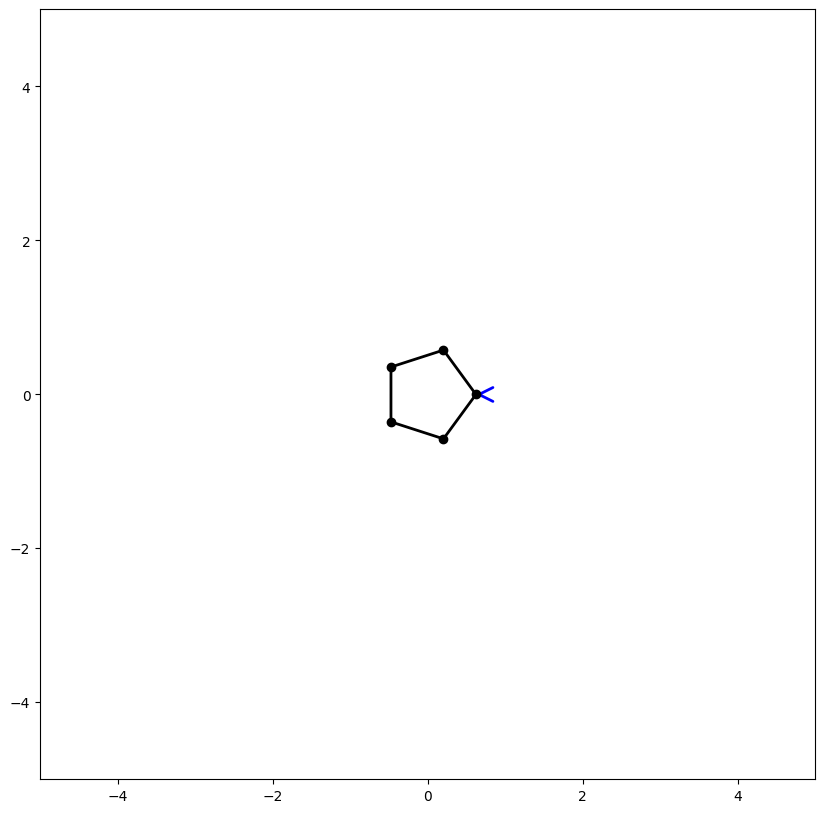

Iteration  303000 ff =  2.4580905233934452e-31 vv =  1.2064118497934251e-30 power =  5.4456124864764064e-31


<Figure size 640x480 with 0 Axes>

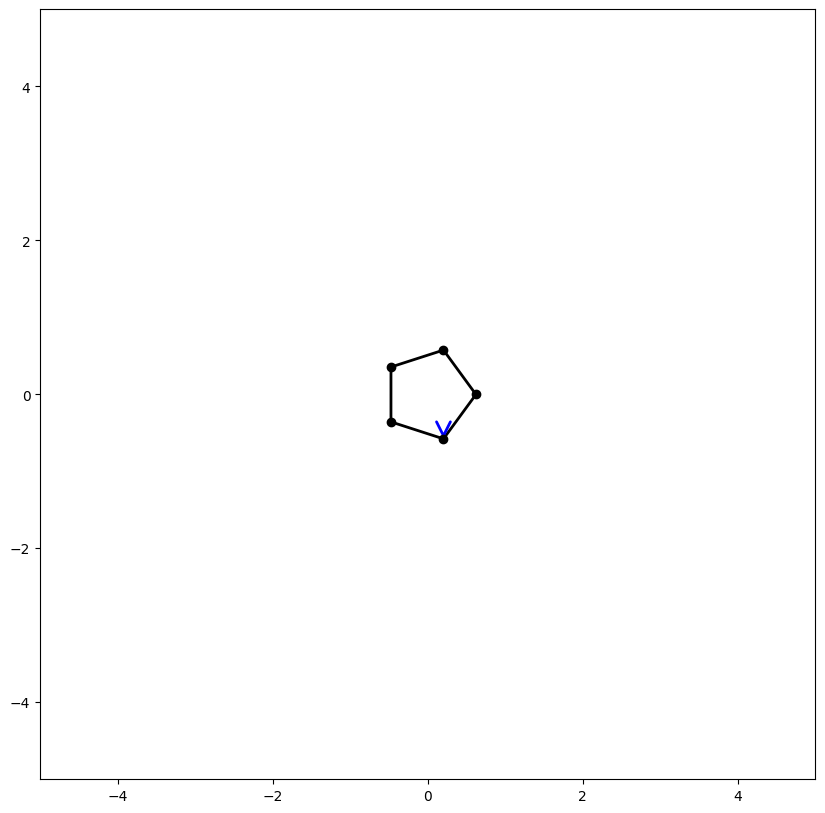

Iteration  304000 ff =  2.4580905233934452e-31 vv =  3.84076644280226e-33 power =  3.0726131542418076e-32


<Figure size 640x480 with 0 Axes>

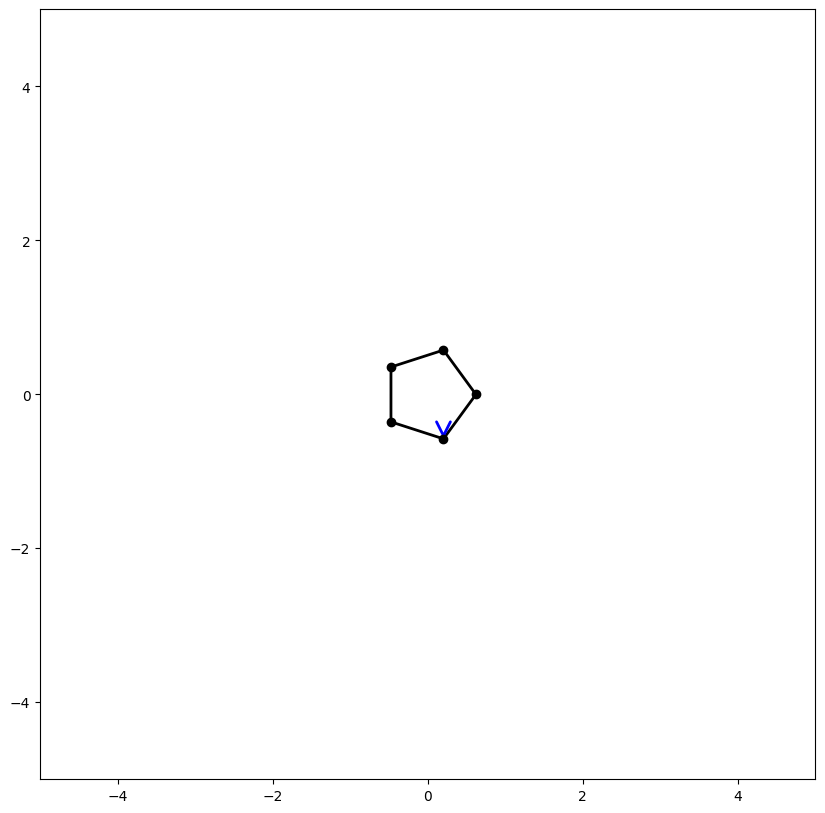

Iteration  305000 ff =  1.0150734971903775e-30 vv =  1.0150734971903775e-32 power =  1.0150734971903777e-31


<Figure size 640x480 with 0 Axes>

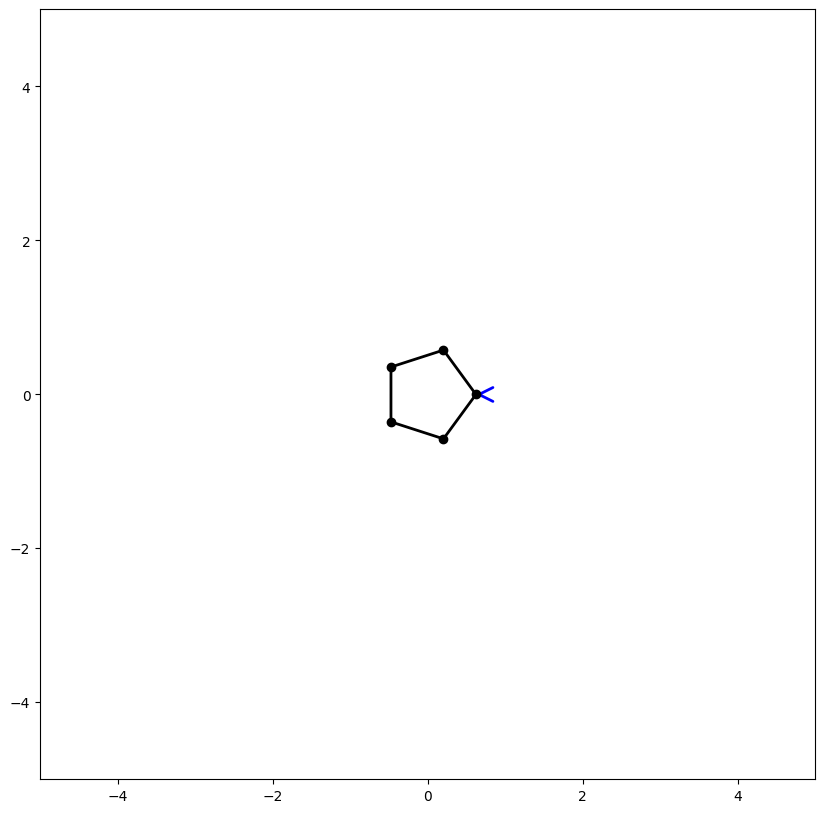

Iteration  306000 ff =  2.4580905233934452e-31 vv =  4.6727317613500046e-32 power =  1.0717274681995422e-31


<Figure size 640x480 with 0 Axes>

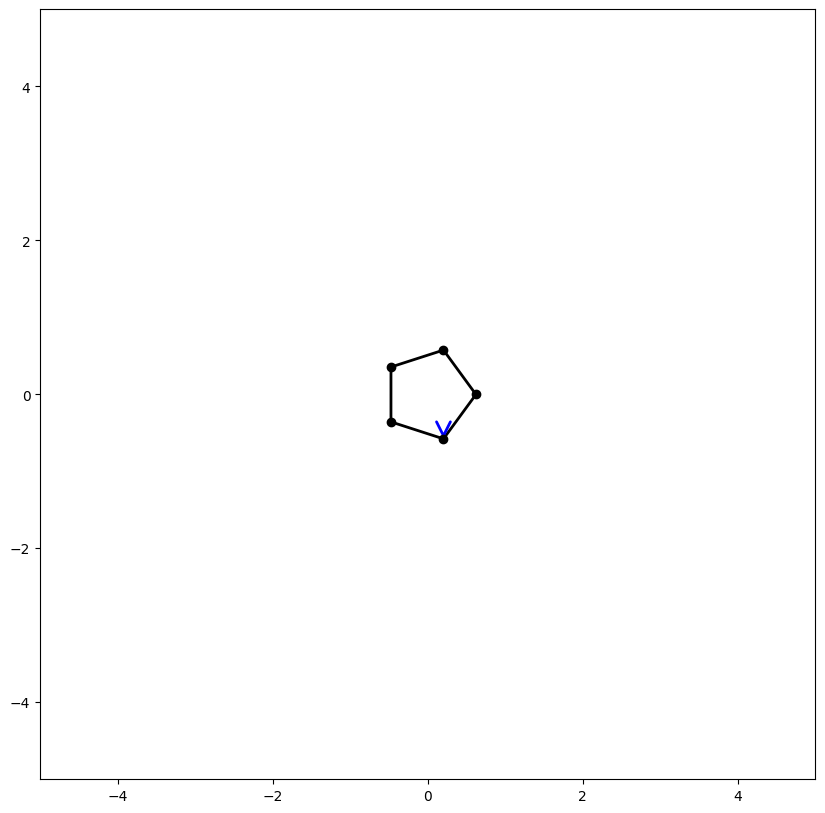

Iteration  307000 ff =  1.0150734971903775e-30 vv =  1.6711465850503704e-31 power =  4.118660714849957e-31


<Figure size 640x480 with 0 Axes>

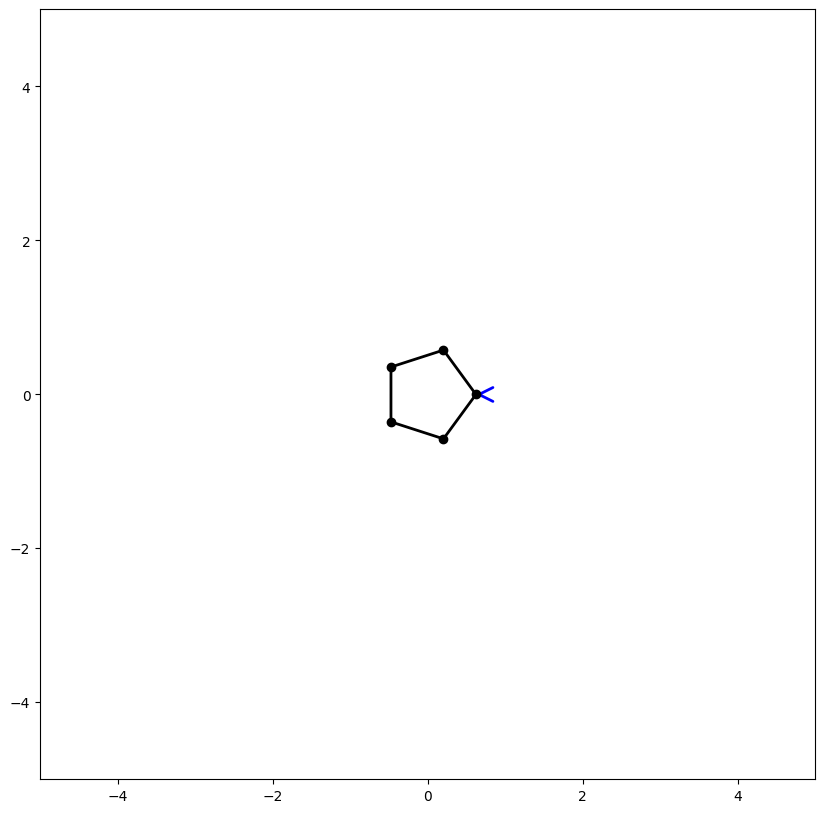

Iteration  308000 ff =  2.4580905233934452e-31 vv =  1.5966956959133935e-31 power =  1.9811164930078737e-31


<Figure size 640x480 with 0 Axes>

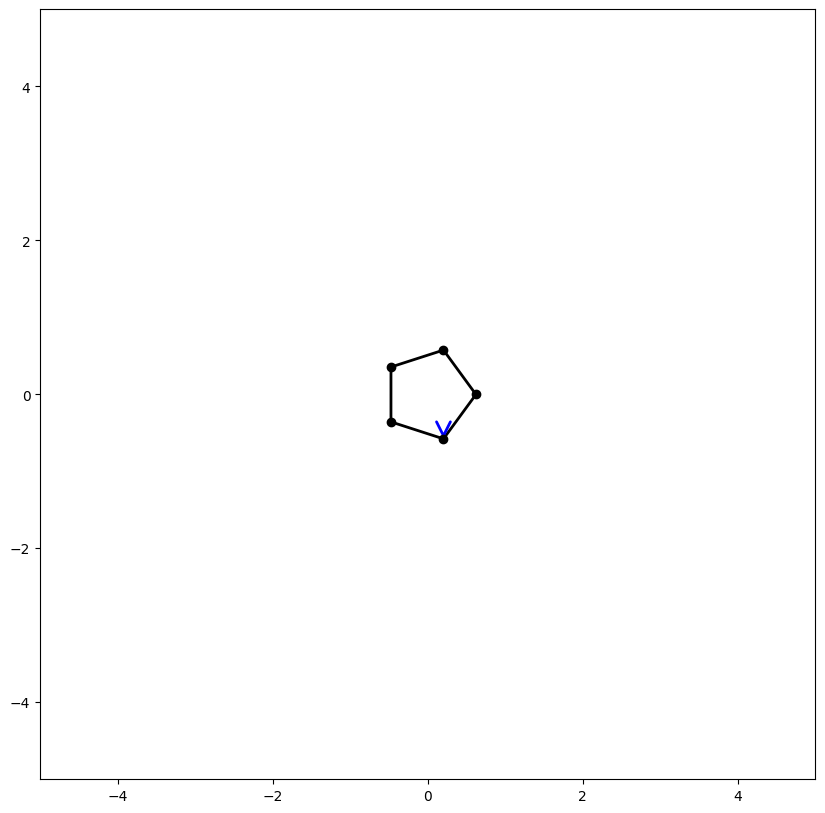

Iteration  309000 ff =  1.0150734971903775e-30 vv =  6.008292262753675e-31 power =  7.80951870430903e-31


<Figure size 640x480 with 0 Axes>

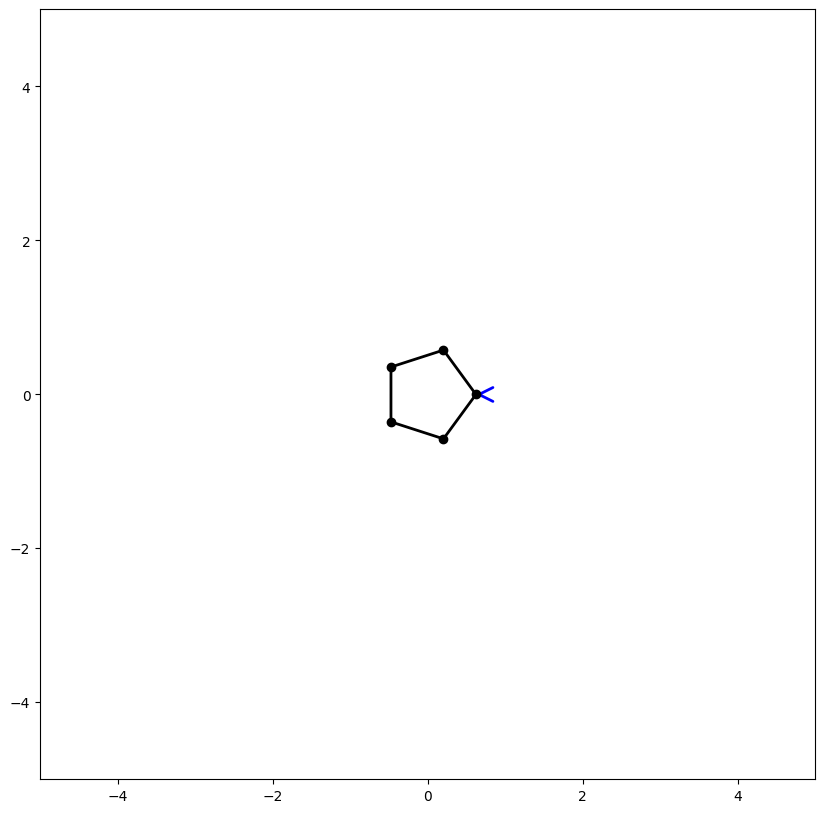

Iteration  310000 ff =  2.4580905233934452e-31 vv =  3.8157320814965044e-31 power =  3.0625830387656277e-31


<Figure size 640x480 with 0 Axes>

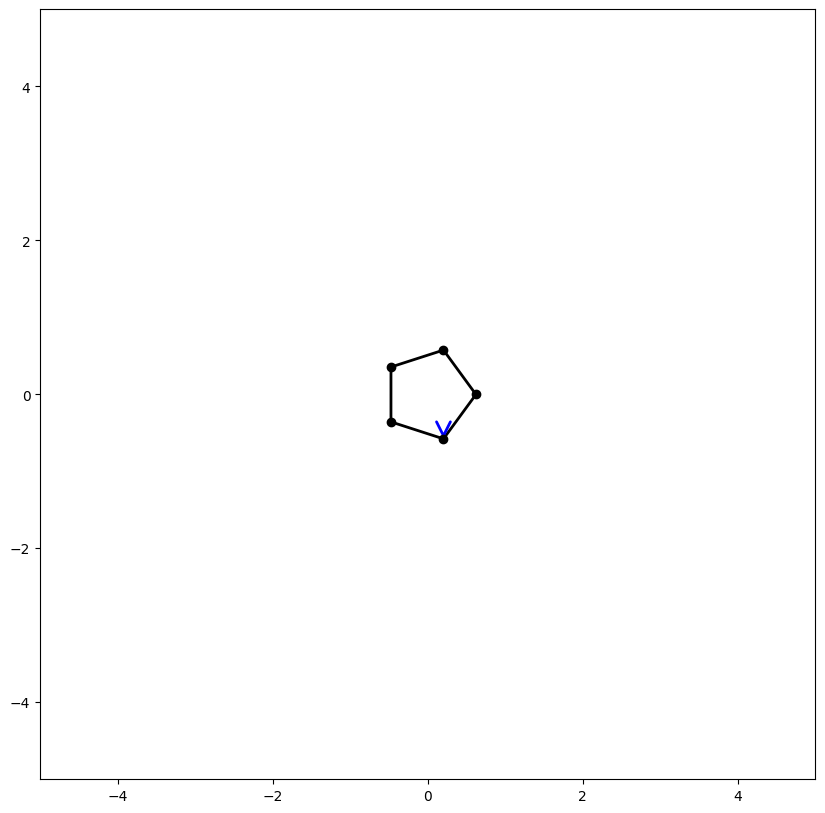

Iteration  311000 ff =  1.0150734971903775e-30 vv =  1.465680781154112e-30 power =  1.2197432993424597e-30


<Figure size 640x480 with 0 Axes>

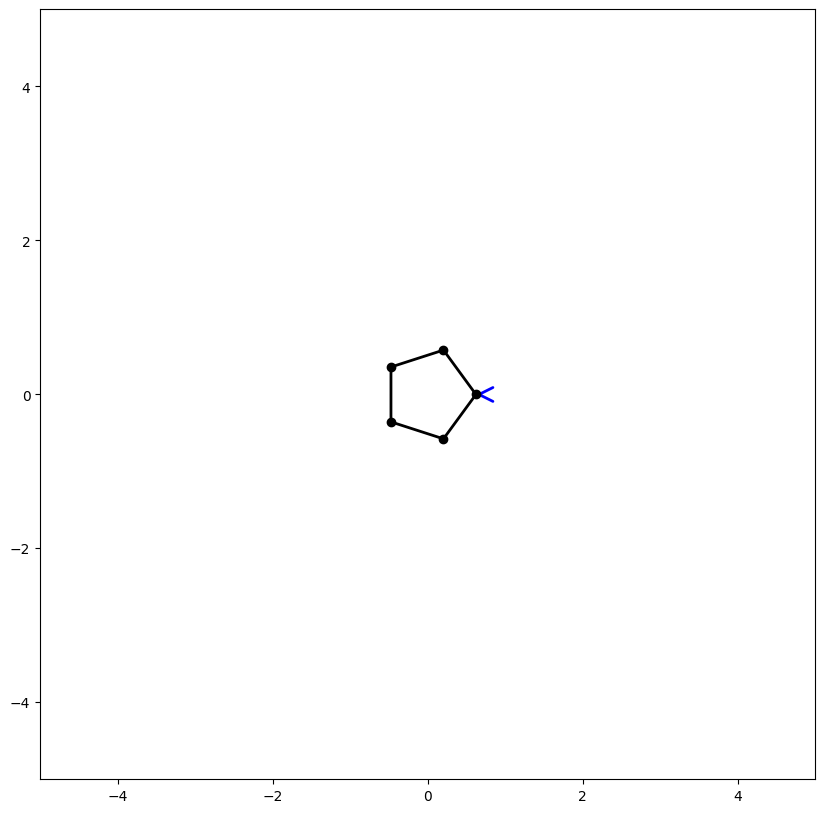

Iteration  312000 ff =  2.4580905233934452e-31 vv =  7.660830591092658e-31 power =  4.339471750949357e-31


<Figure size 640x480 with 0 Axes>

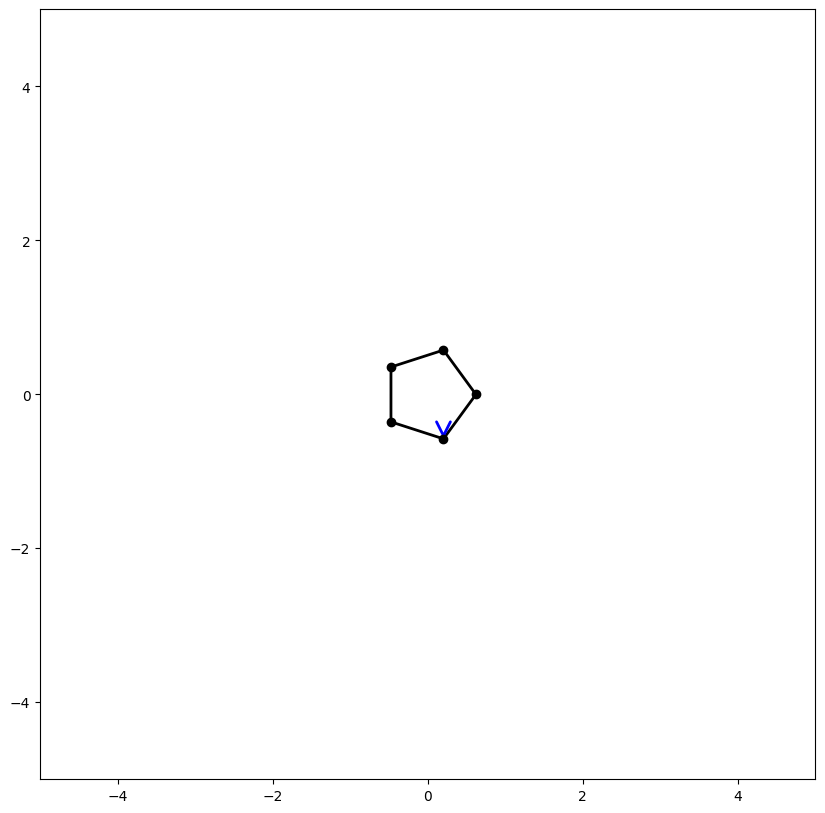

Iteration  313000 ff =  1.0150734971903775e-30 vv =  2.9868939363095826e-30 power =  1.7412400390717243e-30


<Figure size 640x480 with 0 Axes>

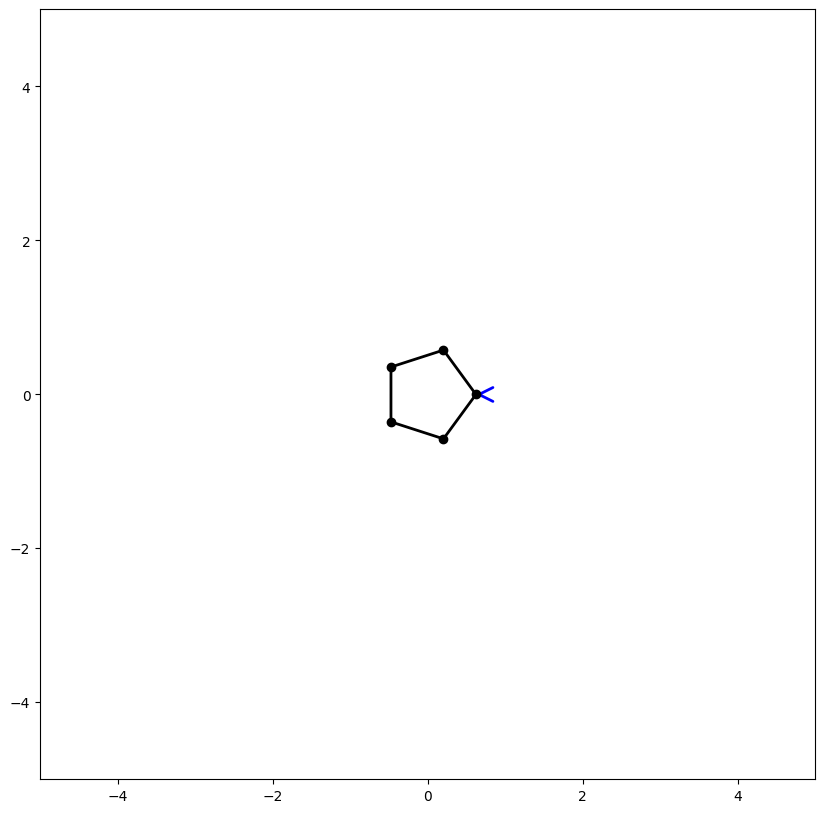

Iteration  314000 ff =  2.4580905233934452e-31 vv =  1.3177821900463467e-30 power =  5.6914215388157515e-31


<Figure size 640x480 with 0 Axes>

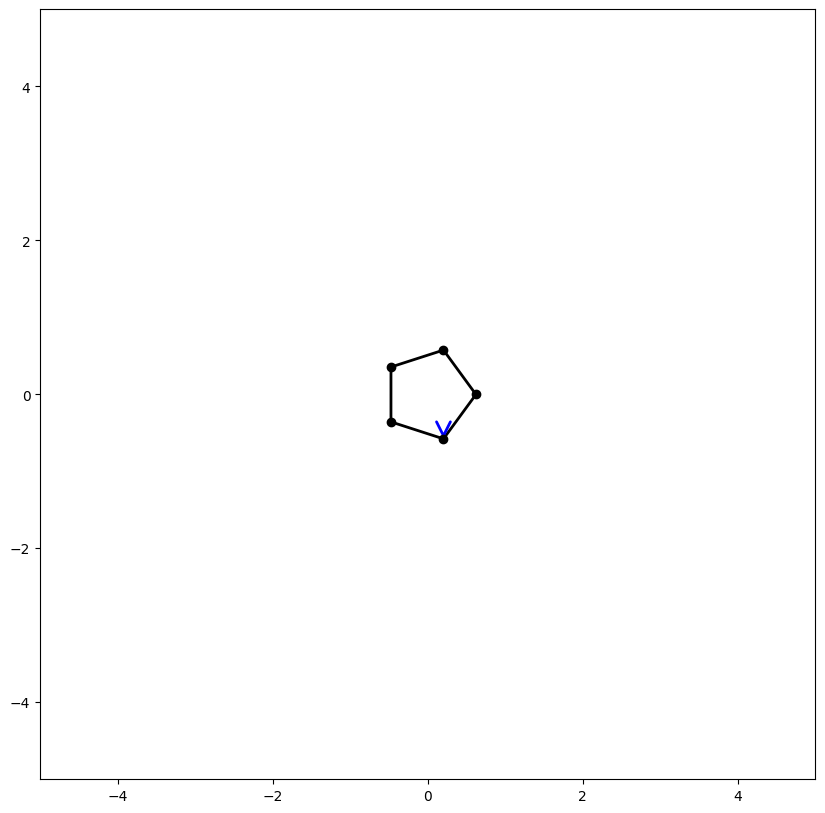

Iteration  315000 ff =  2.4580905233934452e-31 vv =  7.744521455266476e-33 power =  4.363110679023366e-32


<Figure size 640x480 with 0 Axes>

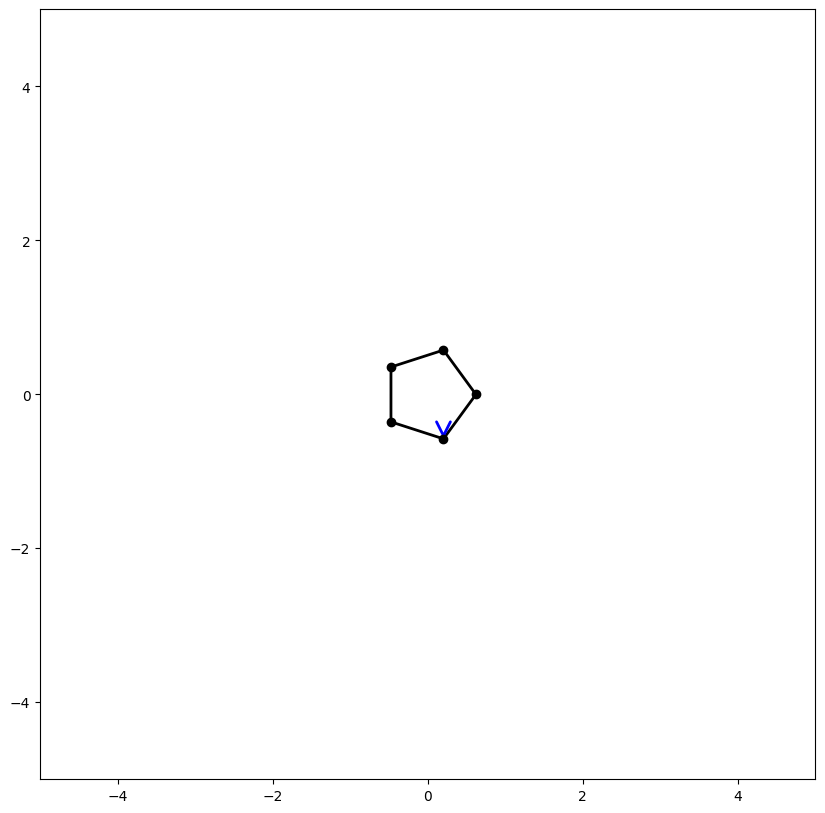

Iteration  316000 ff =  1.0150734971903775e-30 vv =  2.2839153686783496e-32 power =  1.5226102457855664e-31


<Figure size 640x480 with 0 Axes>

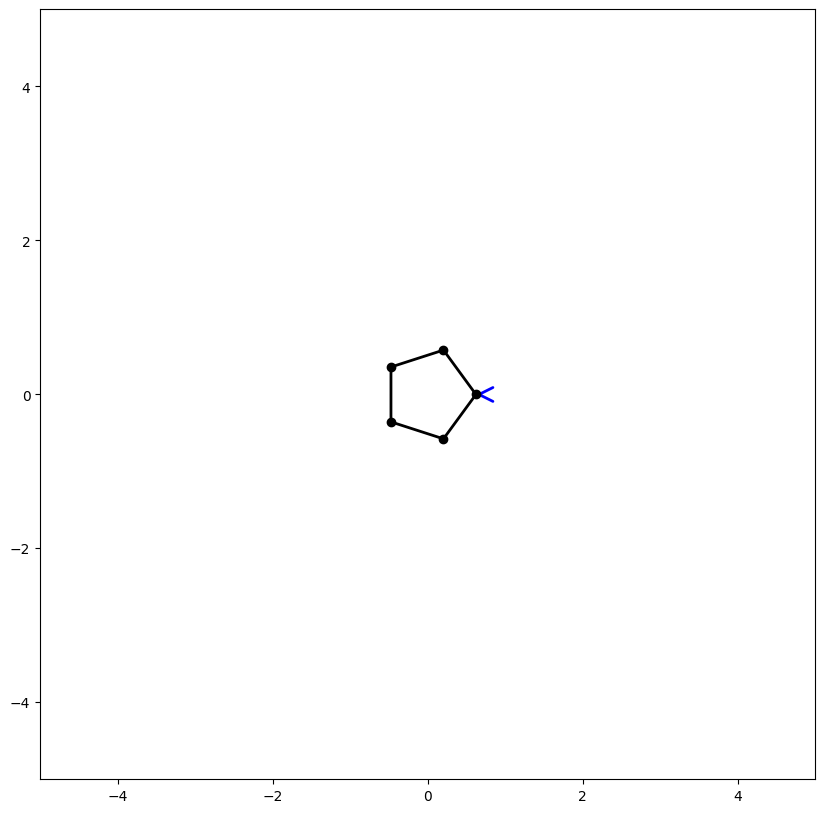

Iteration  317000 ff =  2.4580905233934452e-31 vv =  6.059494256253959e-32 power =  1.2204419448648457e-31


<Figure size 640x480 with 0 Axes>

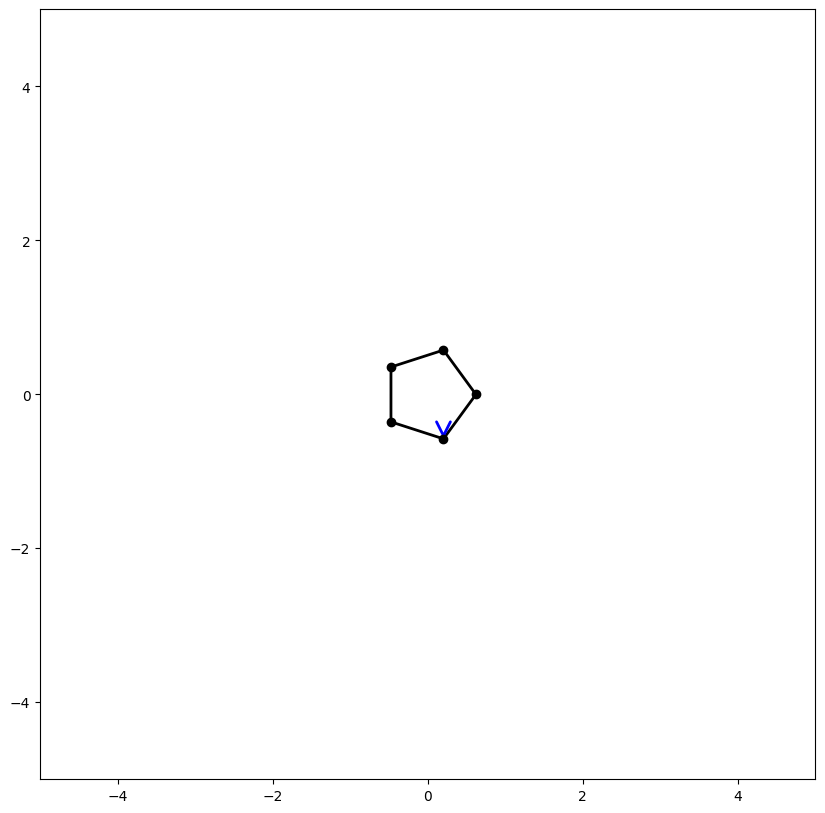

Iteration  318000 ff =  1.0150734971903775e-30 vv =  2.2066587592281258e-31 power =  4.732780180650136e-31


<Figure size 640x480 with 0 Axes>

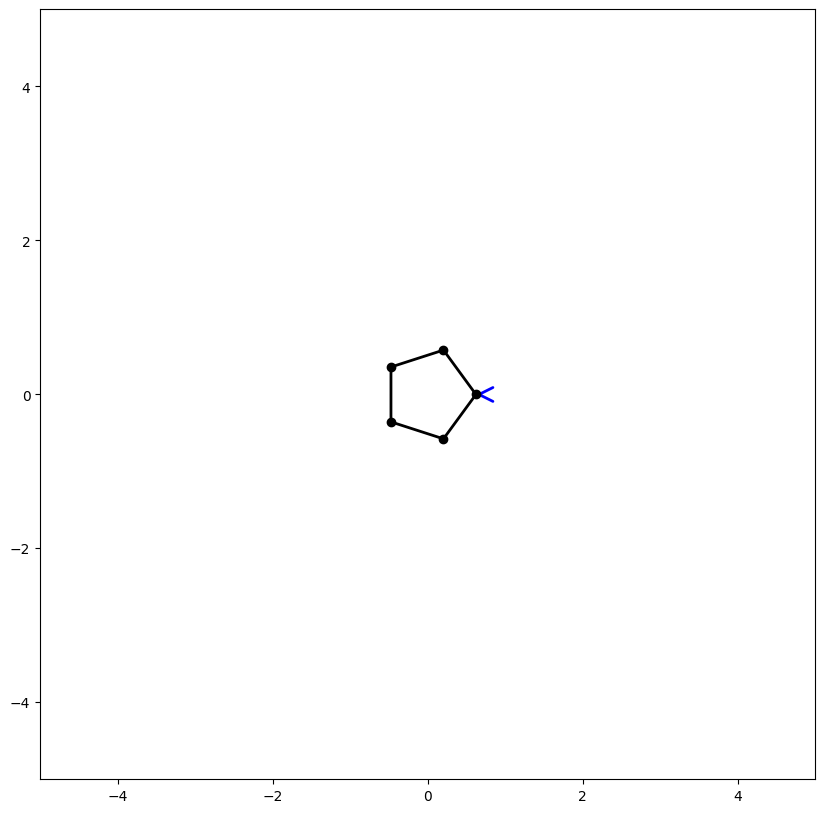

Iteration  319000 ff =  2.4580905233934452e-31 vv =  1.8999238000044595e-31 power =  2.16106100977289e-31


<Figure size 640x480 with 0 Axes>

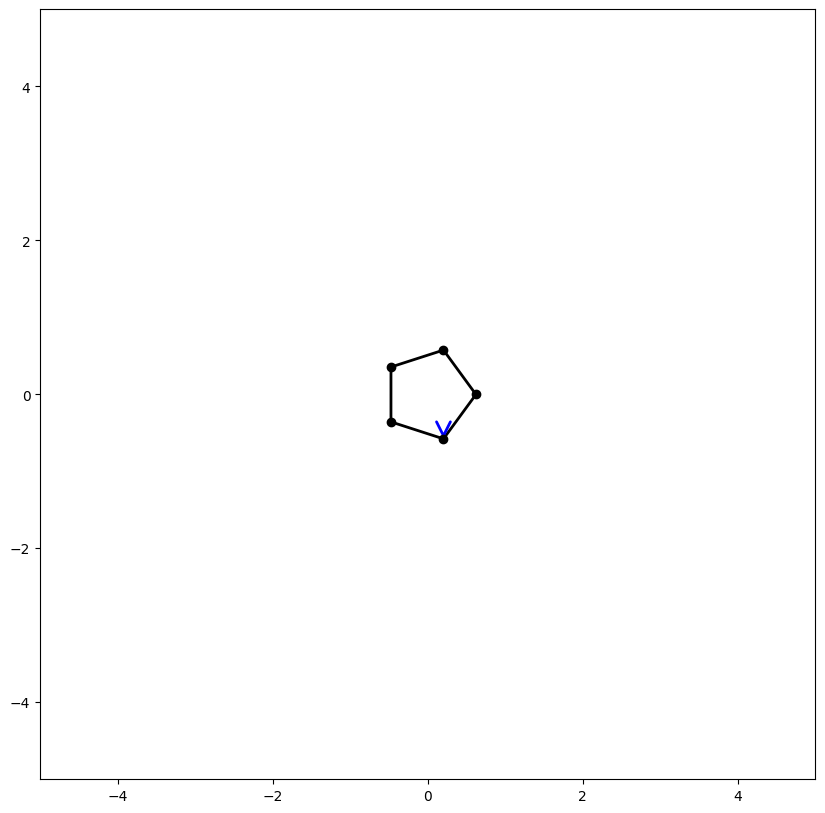

Iteration  320000 ff =  1.0150734971903775e-30 vv =  7.206081400999181e-31 power =  8.552603257927246e-31


<Figure size 640x480 with 0 Axes>

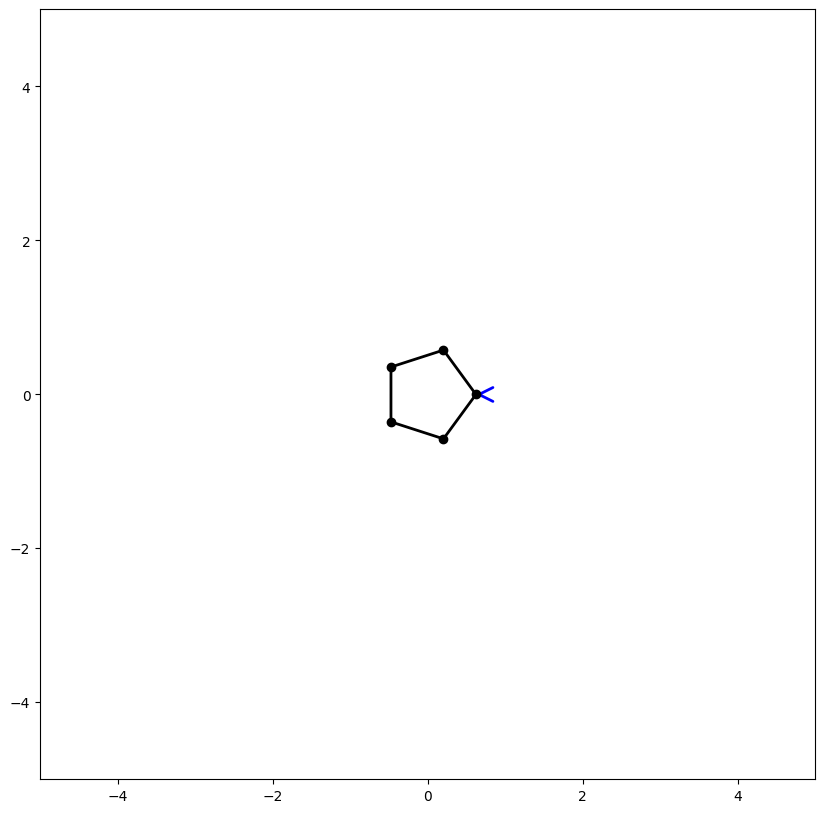

Iteration  321000 ff =  2.4580905233934452e-31 vv =  4.377573701198291e-31 power =  3.280315904051299e-31


<Figure size 640x480 with 0 Axes>

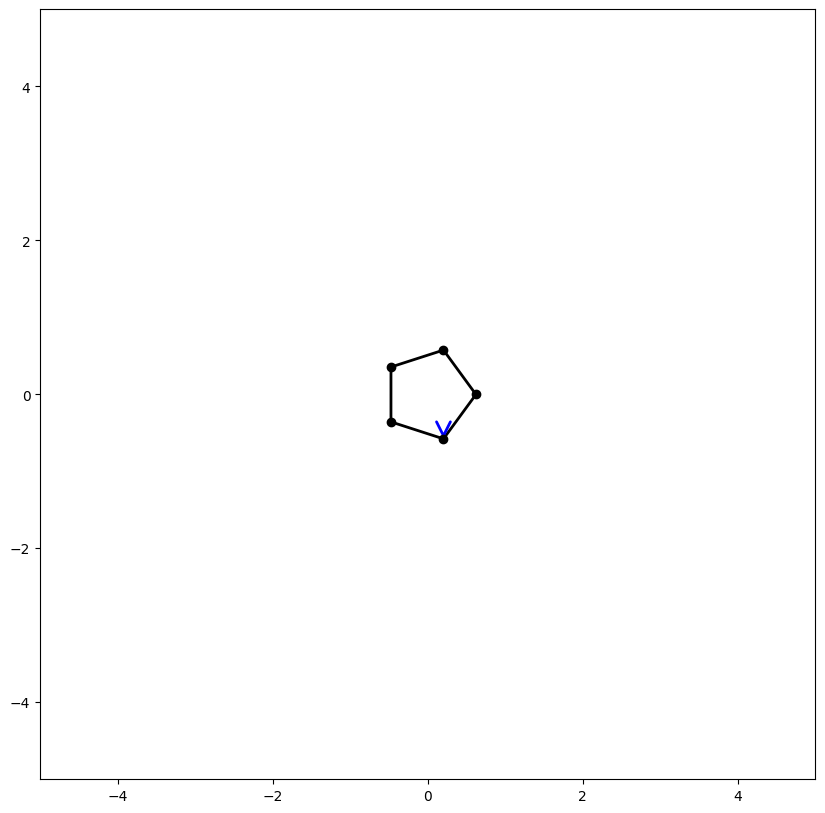

Iteration  322000 ff =  1.0150734971903775e-30 vv =  1.6897300857368543e-30 power =  1.3096565303302638e-30


<Figure size 640x480 with 0 Axes>

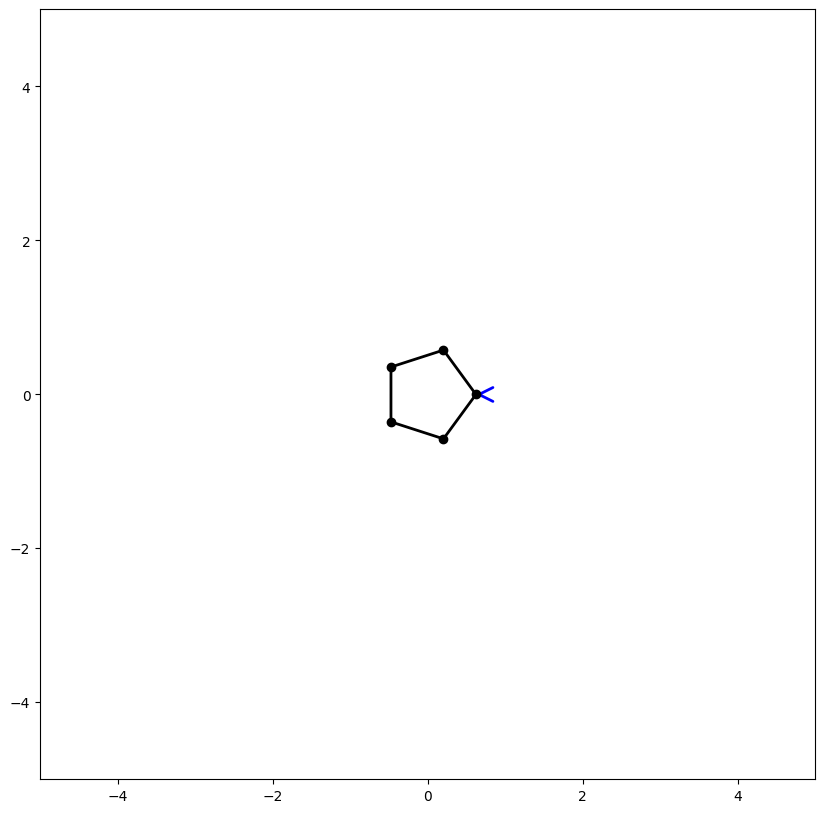

Iteration  323000 ff =  2.4580905233934452e-31 vv =  8.553305846516464e-31 power =  4.585280803288701e-31


<Figure size 640x480 with 0 Axes>

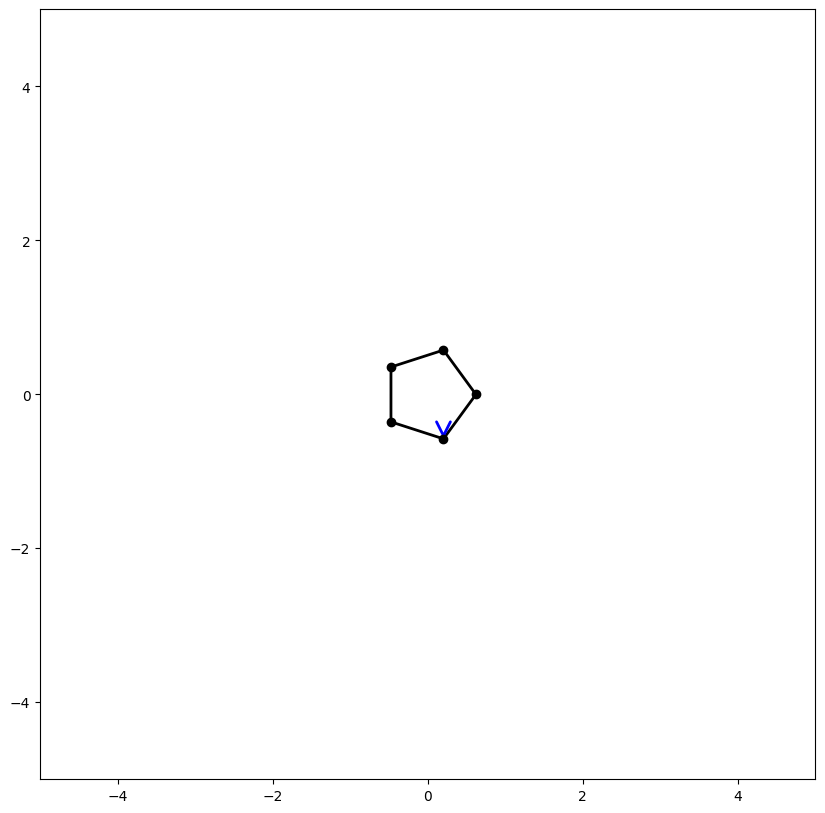

Iteration  324000 ff =  1.0150734971903775e-30 vv =  3.345292679095831e-30 power =  1.842747388790762e-30


<Figure size 640x480 with 0 Axes>

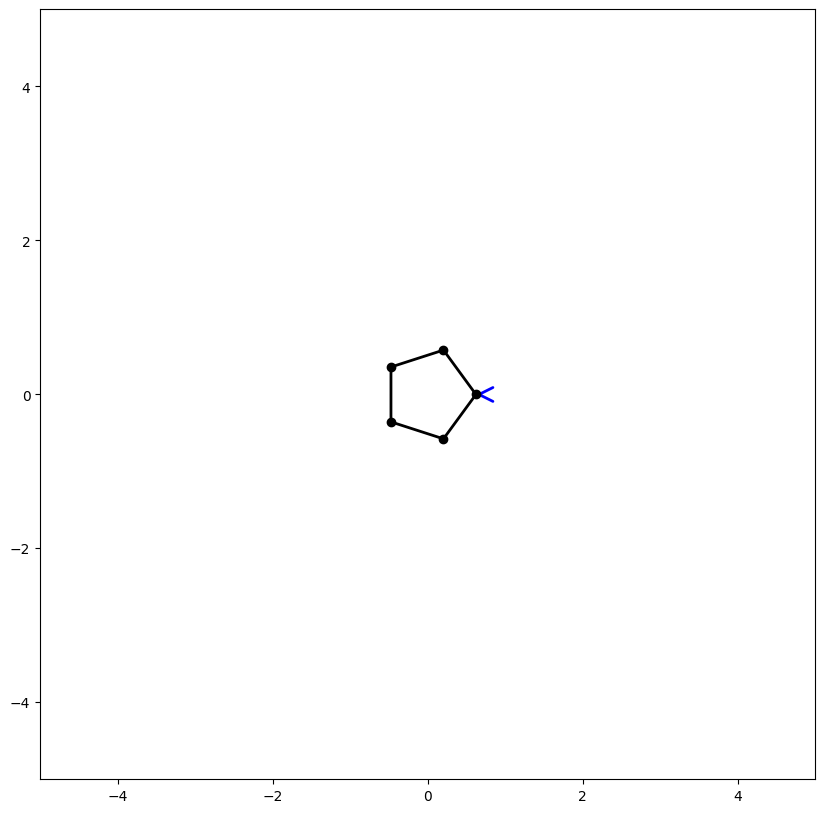

Iteration  325000 ff =  2.4580905233934452e-31 vv =  1.4340687113460547e-30 power =  5.937230591155095e-31


<Figure size 640x480 with 0 Axes>

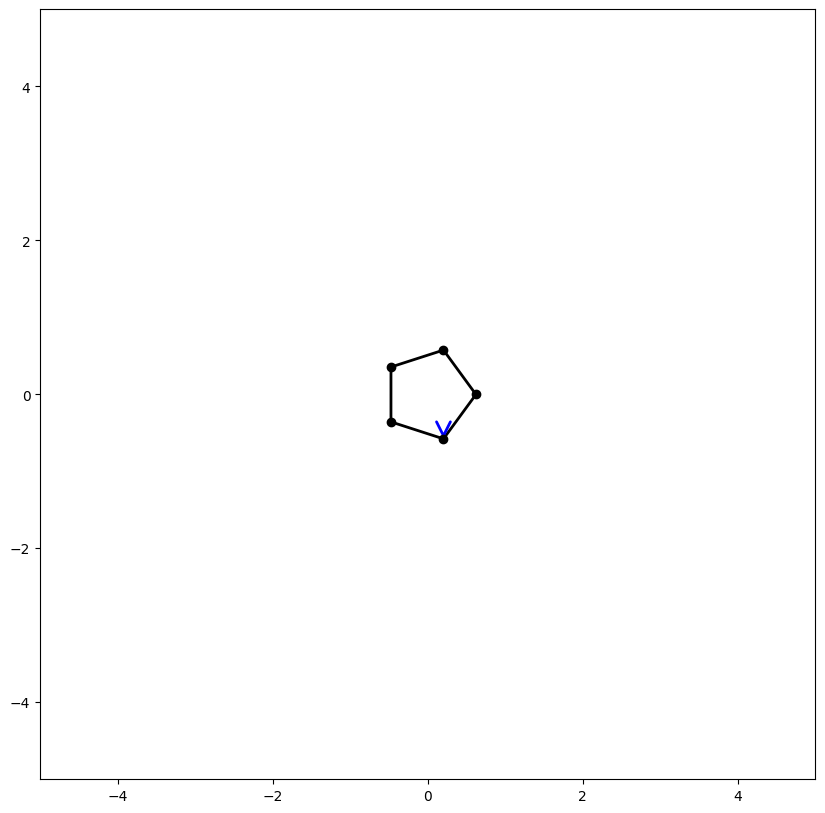

Iteration  326000 ff =  2.4580905233934452e-31 vv =  1.32875155855187e-32 power =  5.715060466889763e-32


<Figure size 640x480 with 0 Axes>

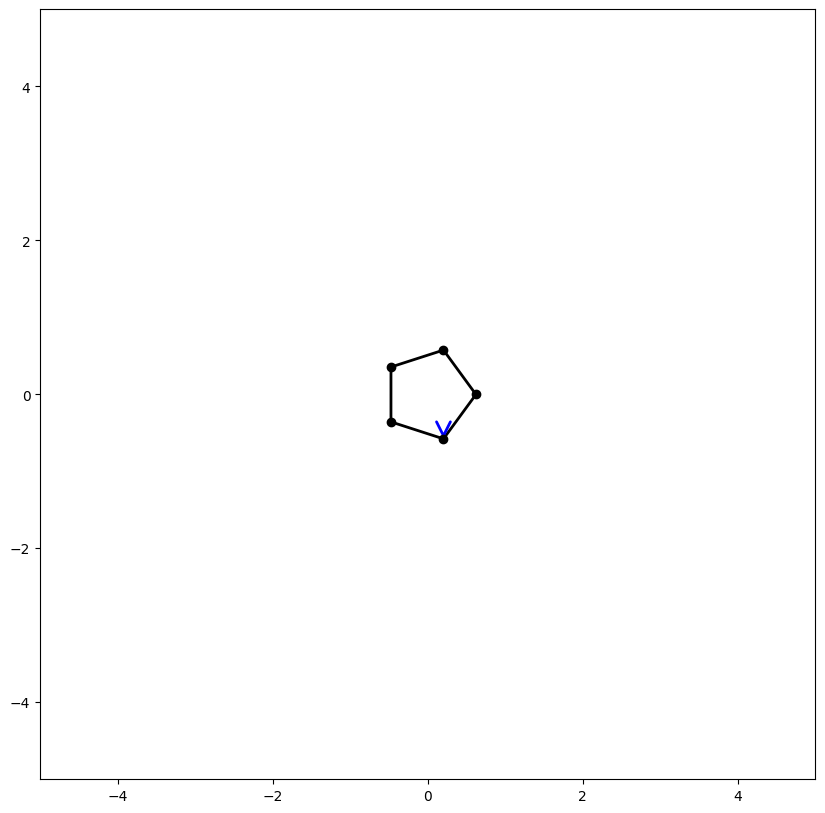

Iteration  327000 ff =  1.0150734971903775e-30 vv =  4.2658463719425627e-32 power =  2.0809006692402744e-31


<Figure size 640x480 with 0 Axes>

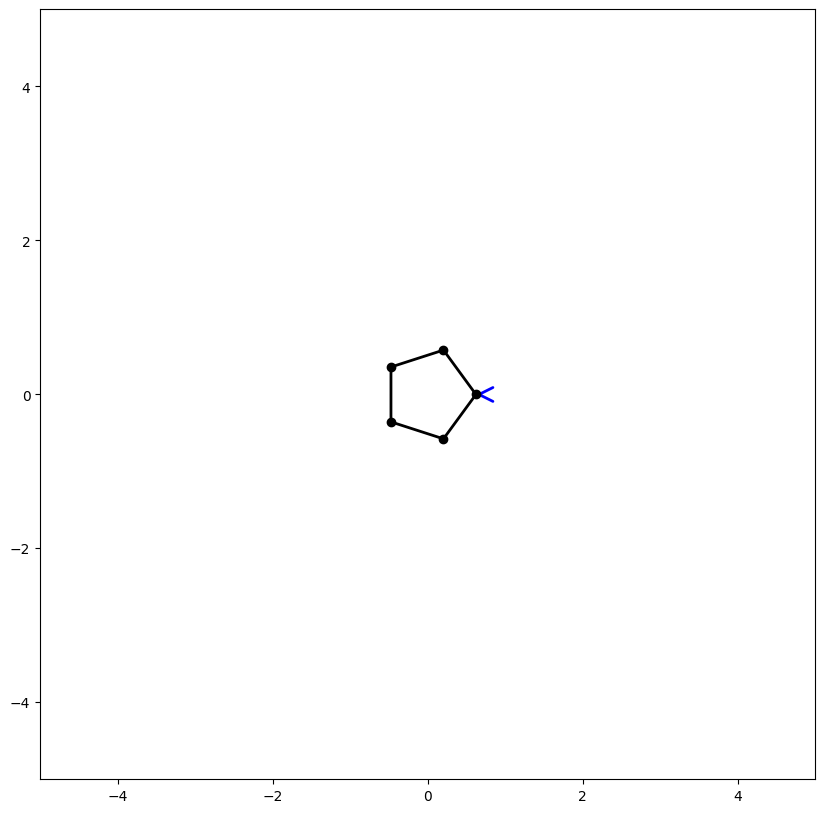

Iteration  328000 ff =  2.4580905233934452e-31 vv =  7.792768917511906e-32 power =  1.3840278691966797e-31


<Figure size 640x480 with 0 Axes>

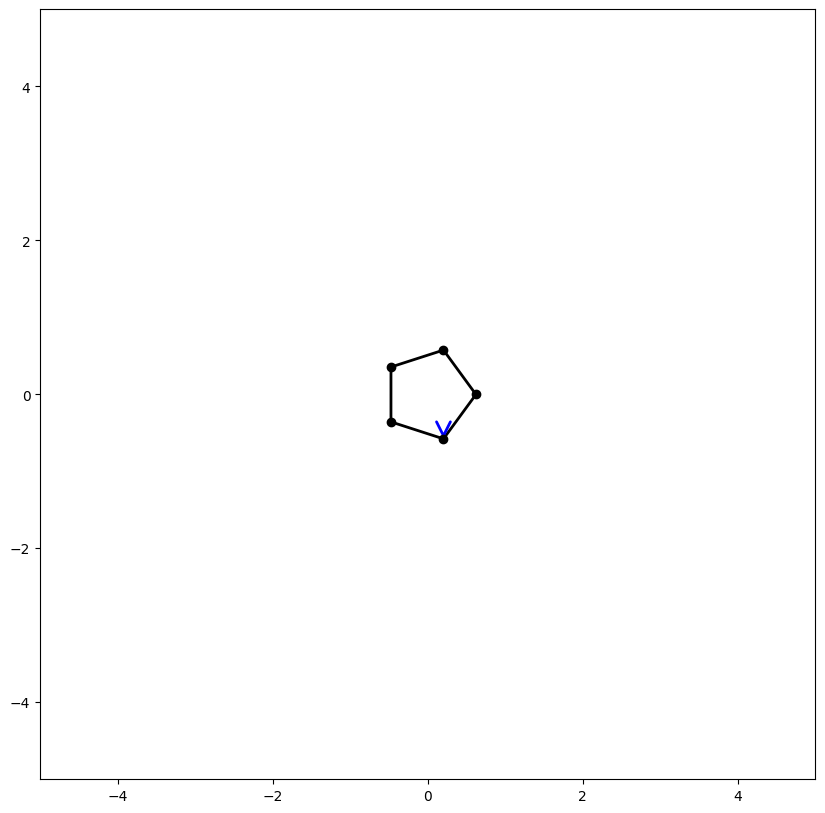

Iteration  329000 ff =  1.0150734971903775e-30 vv =  2.8489210171979305e-31 power =  5.377605619740323e-31


<Figure size 640x480 with 0 Axes>

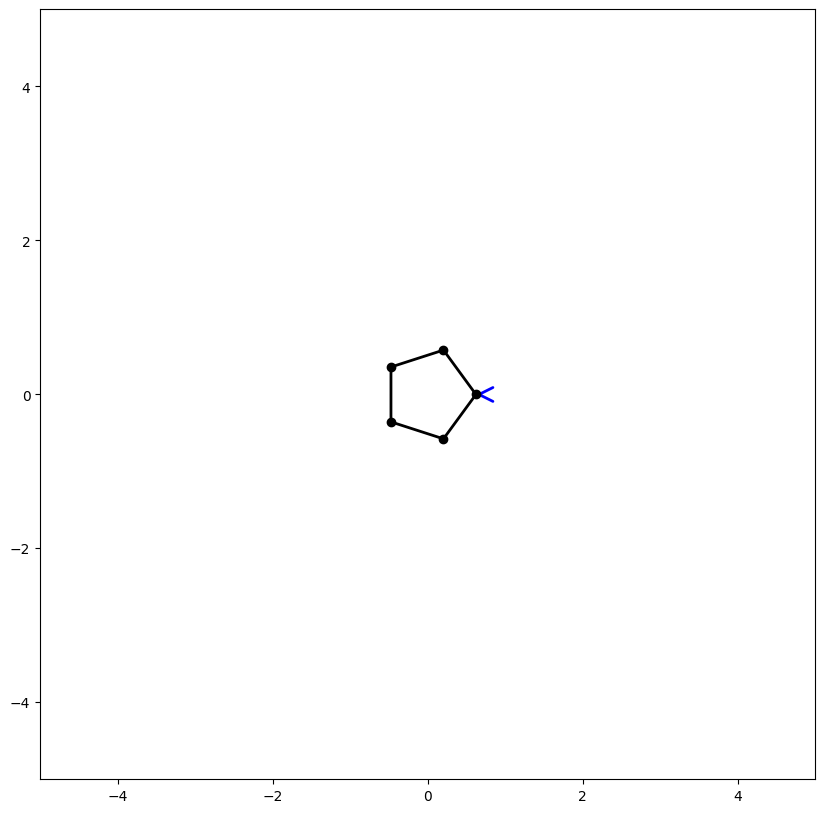

Iteration  330000 ff =  2.4580905233934452e-31 vv =  2.2466678438479865e-31 power =  2.350002752376158e-31


<Figure size 640x480 with 0 Axes>

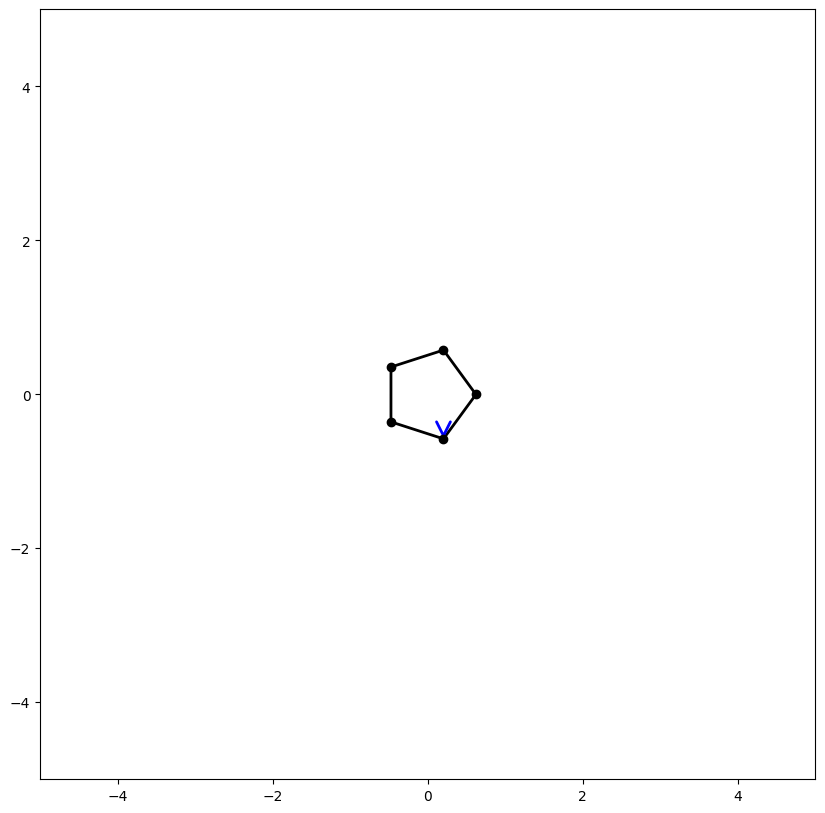

Iteration  331000 ff =  1.0150734971903775e-30 vv =  8.512665548739932e-31 power =  9.295687811545463e-31


<Figure size 640x480 with 0 Axes>

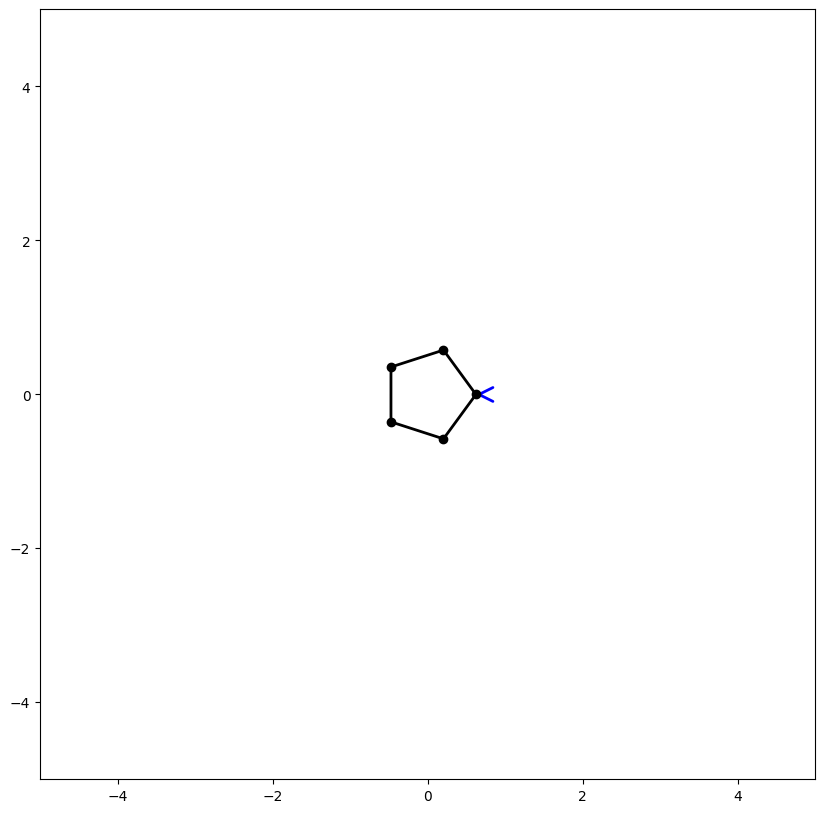

Iteration  332000 ff =  2.4580905233934452e-31 vv =  4.977988026155911e-31 power =  3.4980487693369697e-31


<Figure size 640x480 with 0 Axes>

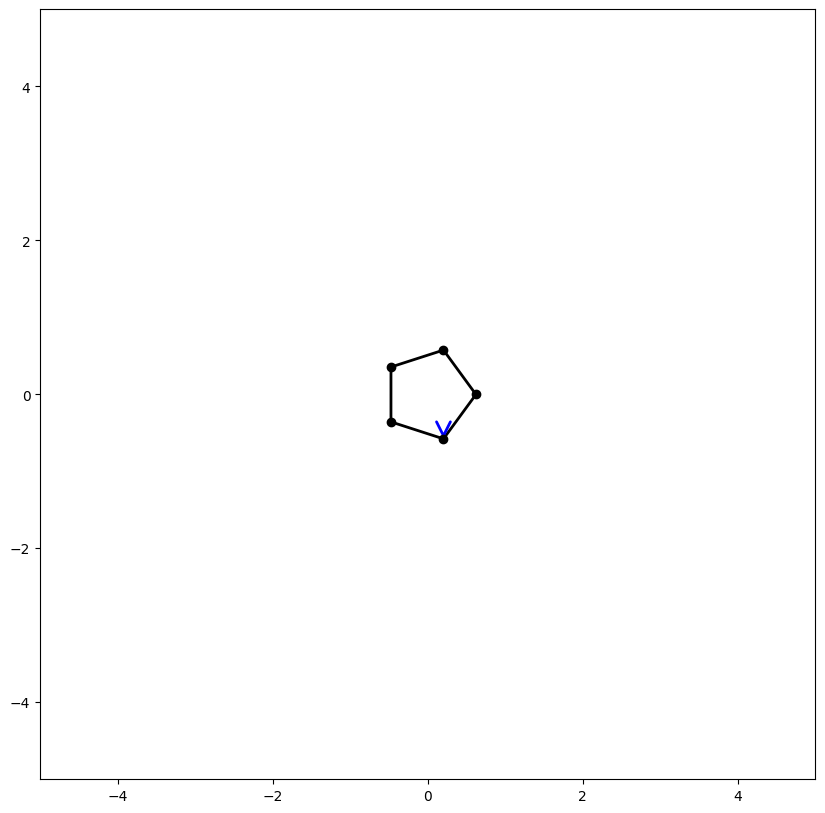

Iteration  333000 ff =  1.0150734971903775e-30 vv =  1.9297080676597955e-30 power =  1.399569761318068e-30


<Figure size 640x480 with 0 Axes>

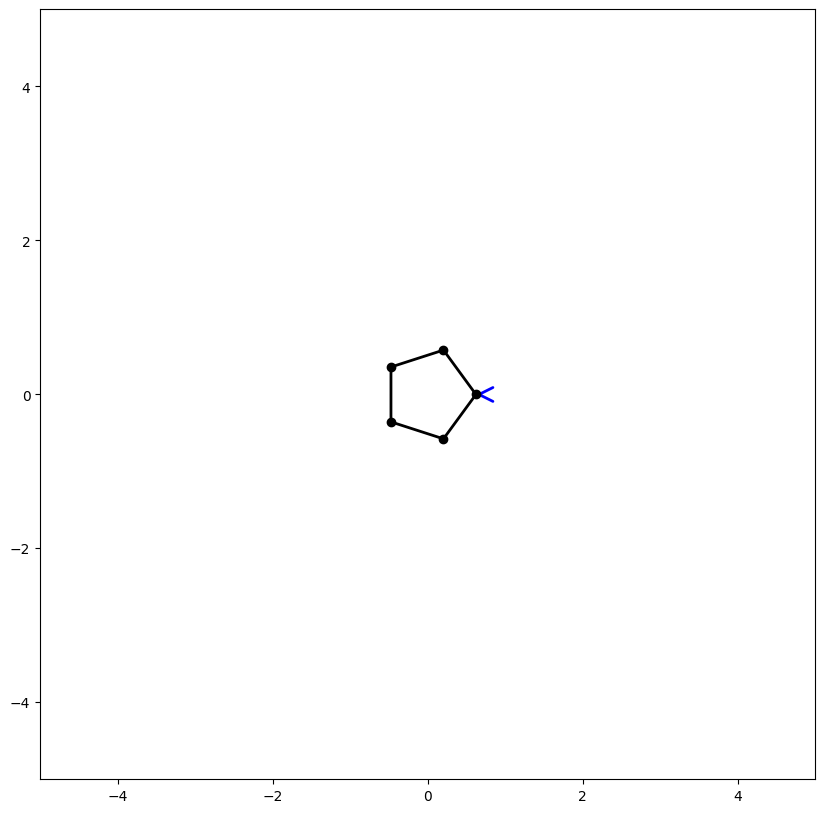

Iteration  334000 ff =  2.4580905233934452e-31 vv =  9.49494291240814e-31 power =  4.831089855628045e-31


<Figure size 640x480 with 0 Axes>

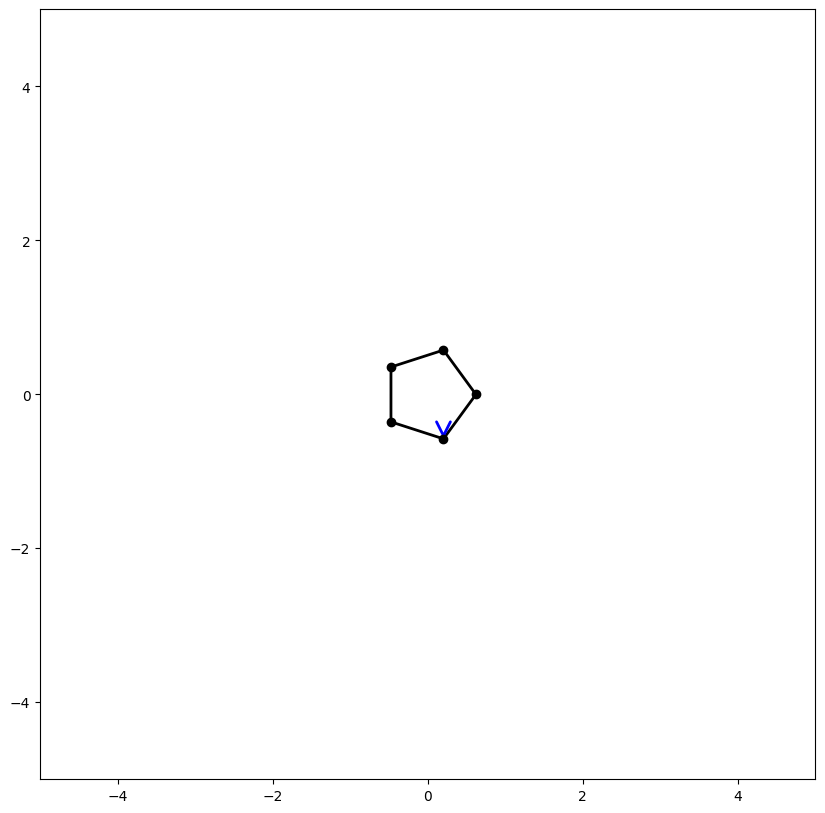

Iteration  335000 ff =  2.4580905233934452e-31 vv =  3.45447961367144e-30 power =  -7.70109654155944e-31


<Figure size 640x480 with 0 Axes>

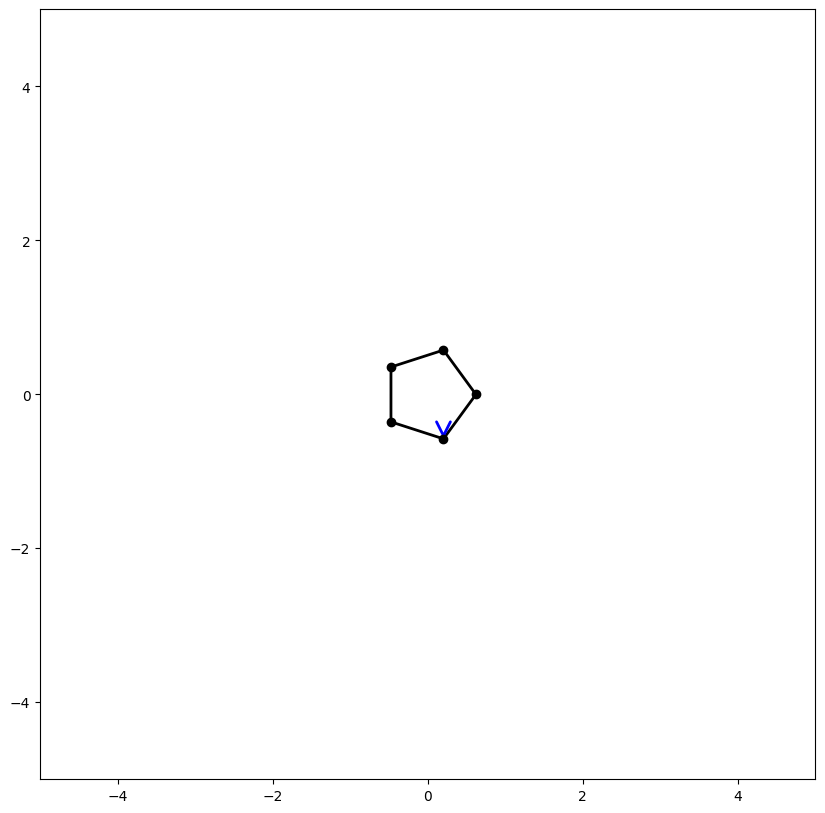

Iteration  336000 ff =  2.4580905233934452e-31 vv =  1.5552714136925495e-30 power =  6.183039643494438e-31


<Figure size 640x480 with 0 Axes>

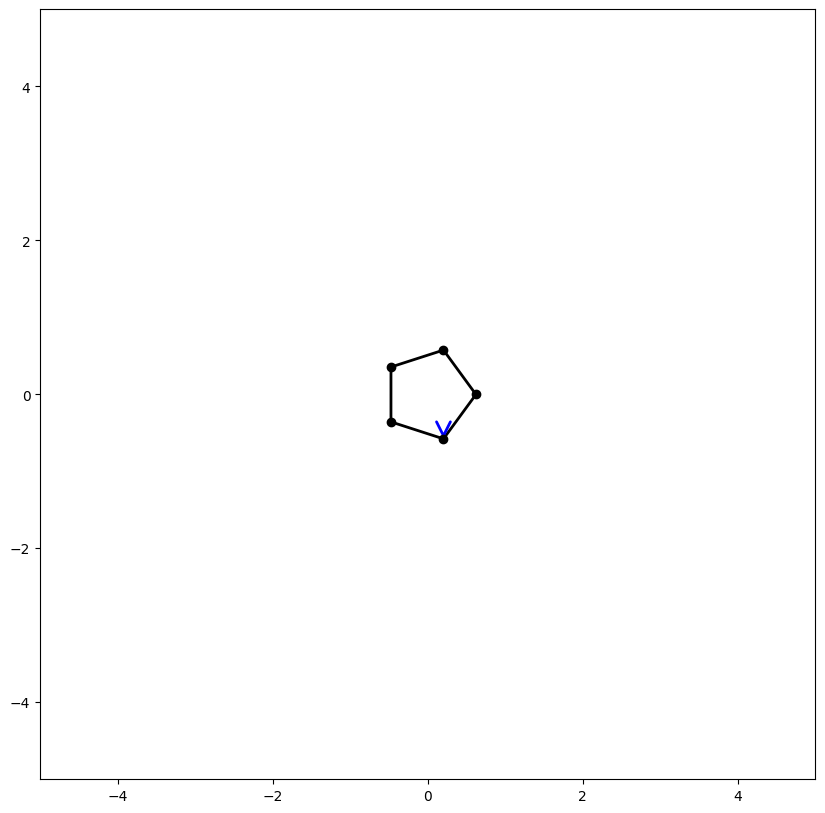

Iteration  337000 ff =  2.4580905233934452e-31 vv =  2.031765448242396e-32 power =  7.067010254756157e-32


<Figure size 640x480 with 0 Axes>

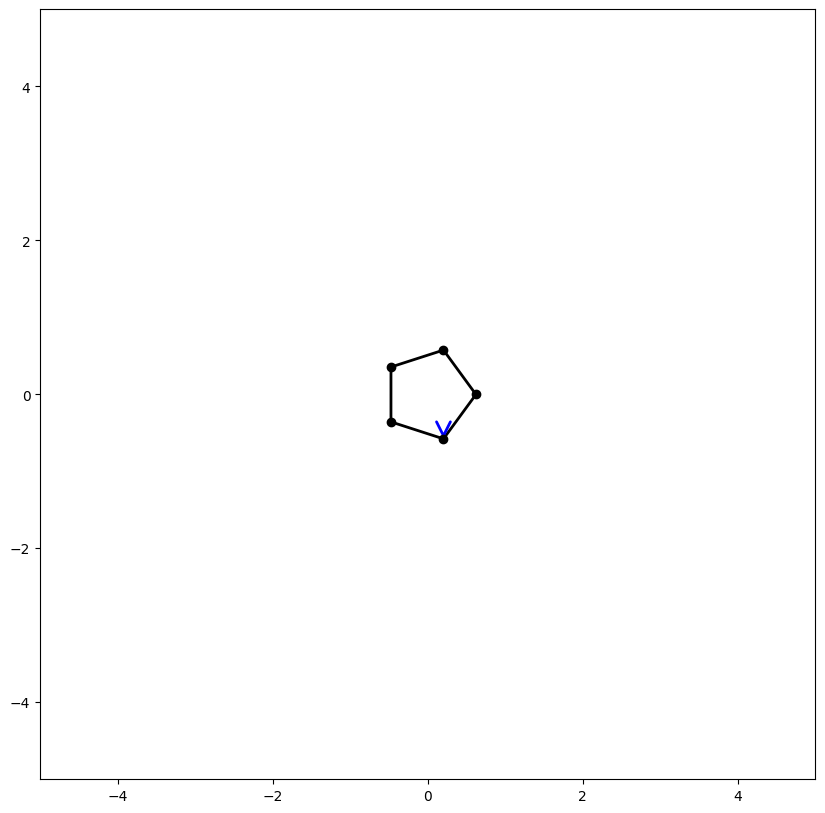

Iteration  338000 ff =  1.0150734971903775e-30 vv =  6.861896841006954e-32 power =  2.639191092694982e-31


<Figure size 640x480 with 0 Axes>

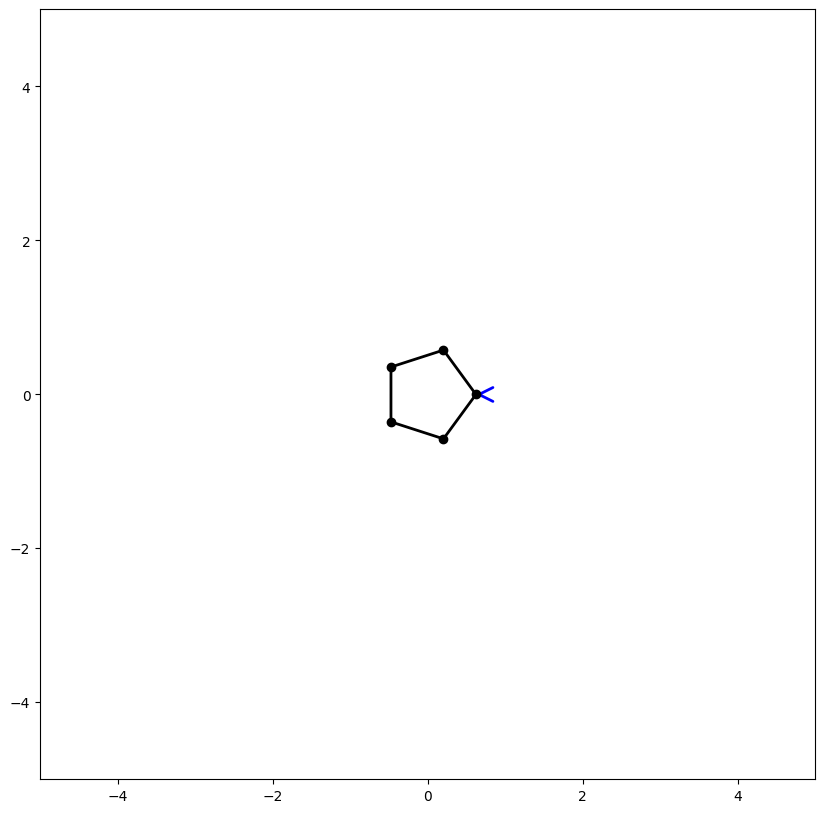

Iteration  339000 ff =  2.4580905233934452e-31 vv =  9.743776444055526e-32 power =  1.5476137935285135e-31


<Figure size 640x480 with 0 Axes>

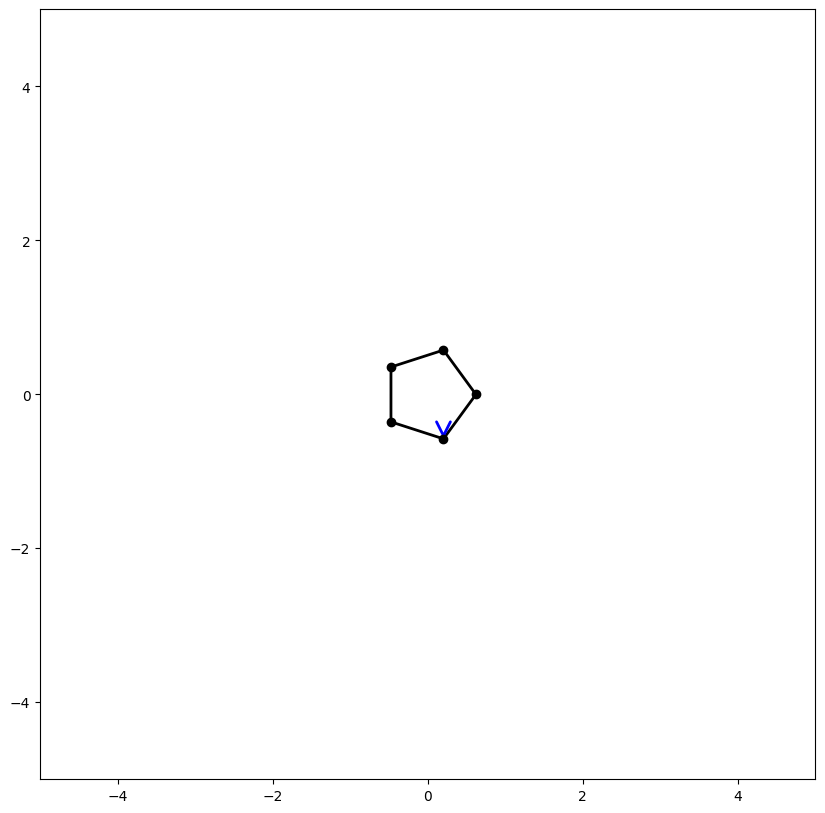

Iteration  340000 ff =  1.0150734971903775e-30 vv =  3.6096369406792697e-31 power =  6.05313703212052e-31


<Figure size 640x480 with 0 Axes>

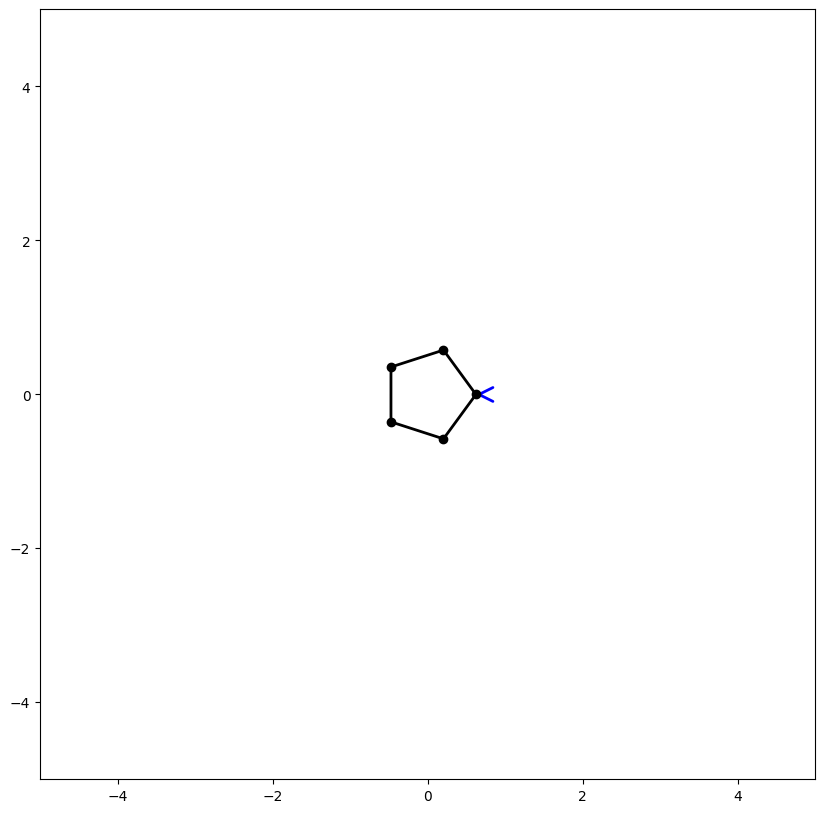

Iteration  341000 ff =  2.4580905233934452e-31 vv =  2.6410772715241566e-31 power =  2.5479417208176774e-31


<Figure size 640x480 with 0 Axes>

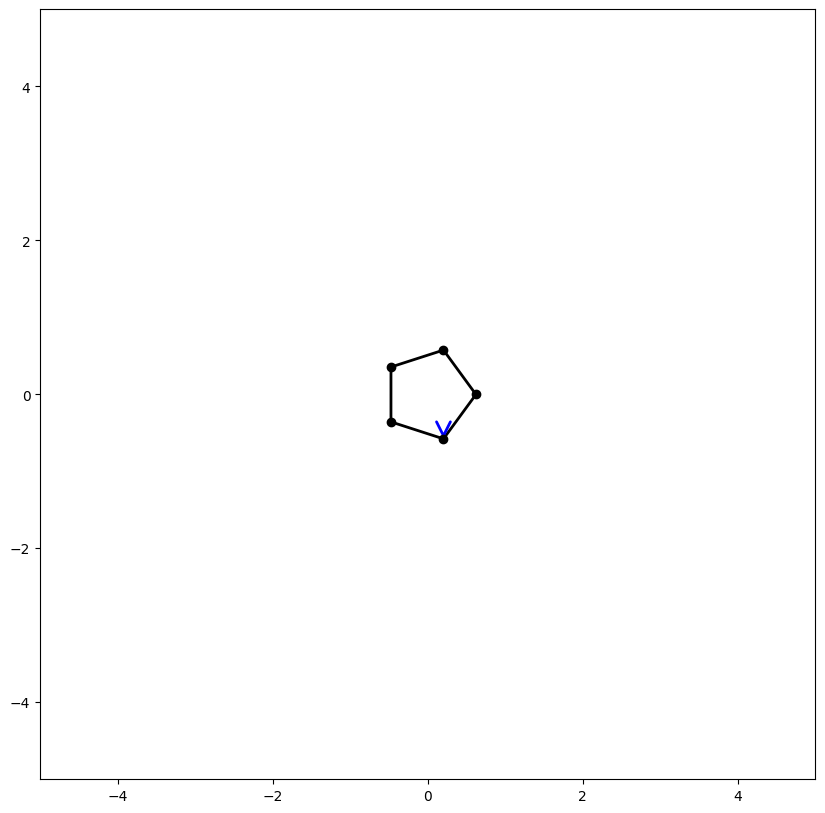

Iteration  342000 ff =  1.0150734971903775e-30 vv =  1.0075566347221761e-30 power =  1.01130808205255e-30


<Figure size 640x480 with 0 Axes>

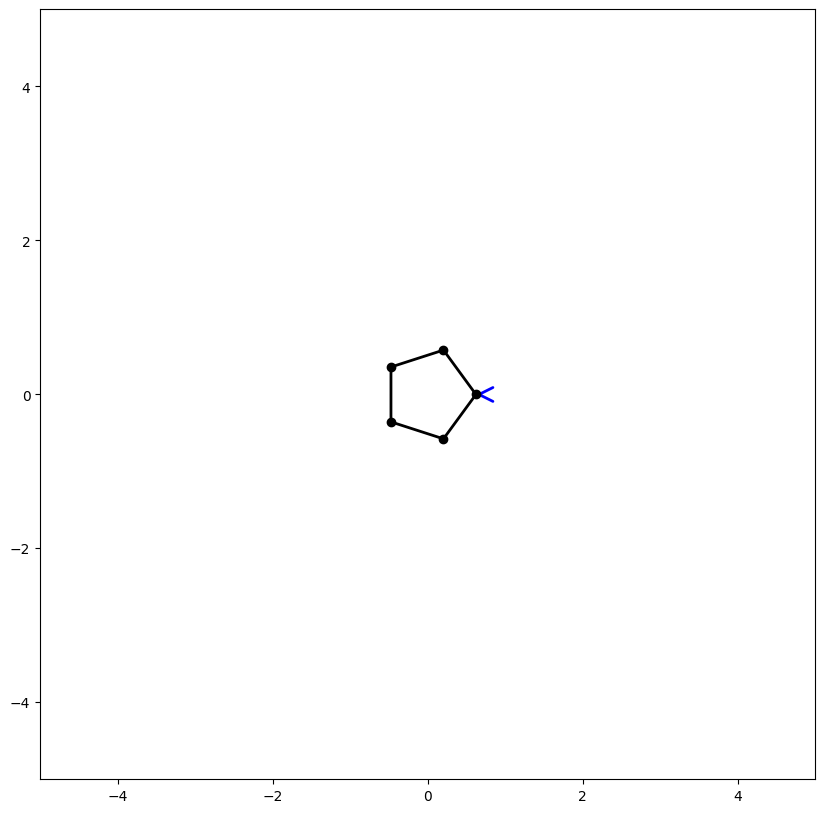

Iteration  343000 ff =  2.4580905233934452e-31 vv =  5.682995258179783e-31 power =  3.737554921151207e-31


<Figure size 640x480 with 0 Axes>

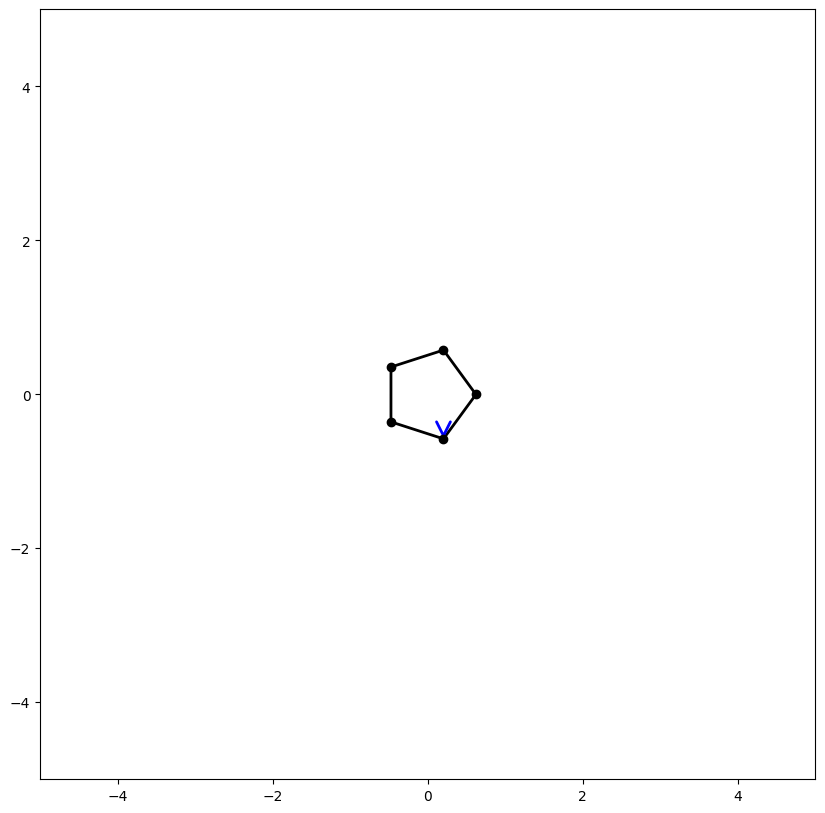

Iteration  344000 ff =  1.0150734971903775e-30 vv =  2.1988281876662723e-30 power =  1.4939786538552626e-30


<Figure size 640x480 with 0 Axes>

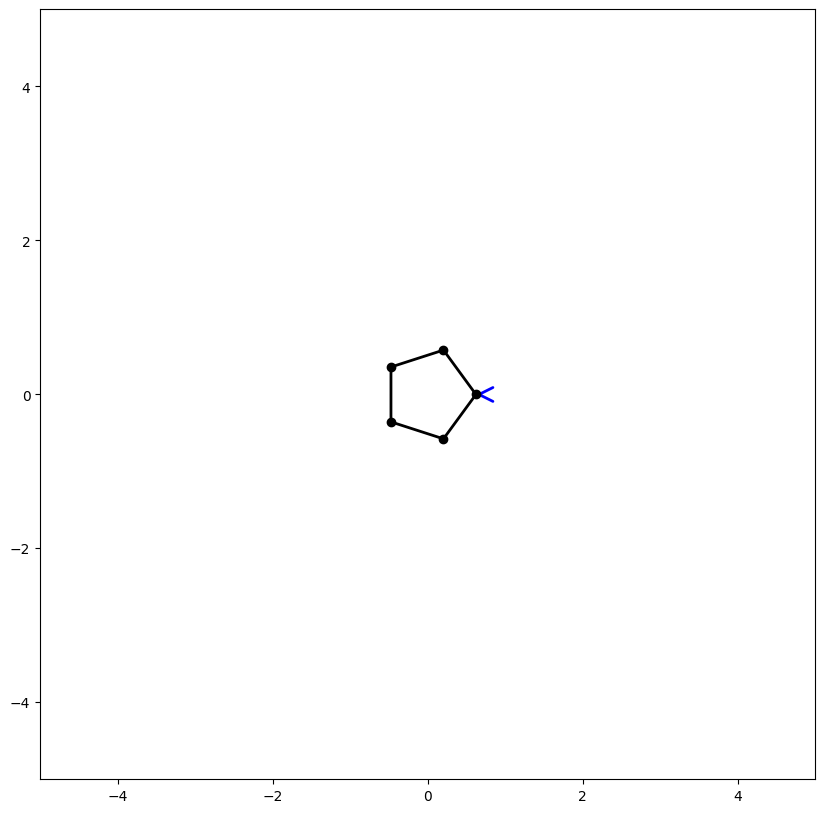

Iteration  345000 ff =  2.4580905233934452e-31 vv =  1.0485741788767681e-30 power =  5.076898907967389e-31


<Figure size 640x480 with 0 Axes>

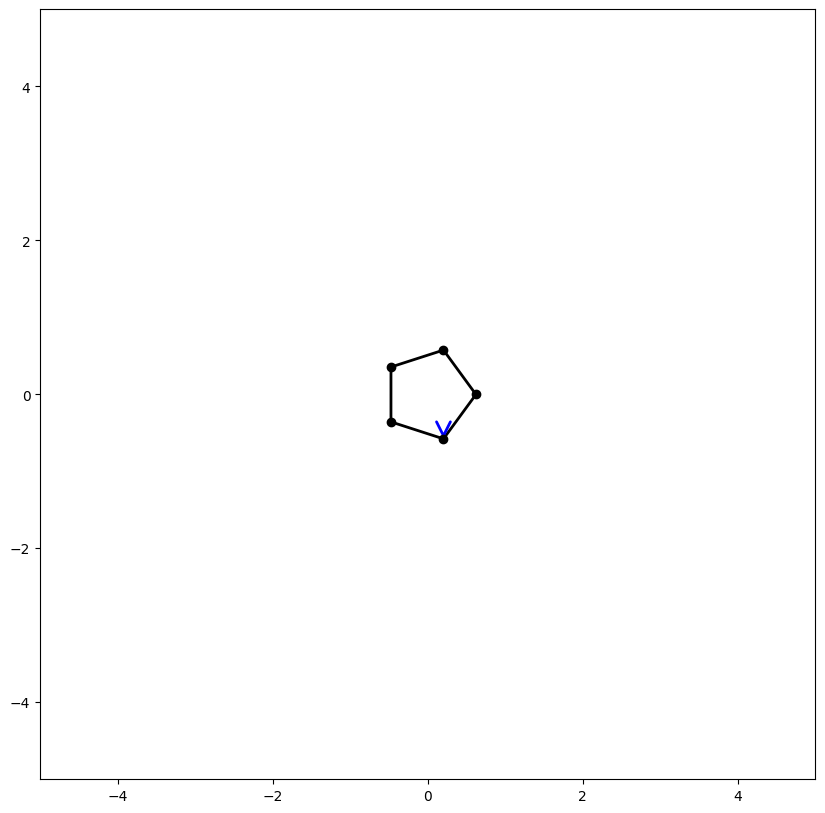

Iteration  346000 ff =  2.4580905233934452e-31 vv =  6.145226308483614e-34 power =  1.2290452616967228e-32


<Figure size 640x480 with 0 Axes>

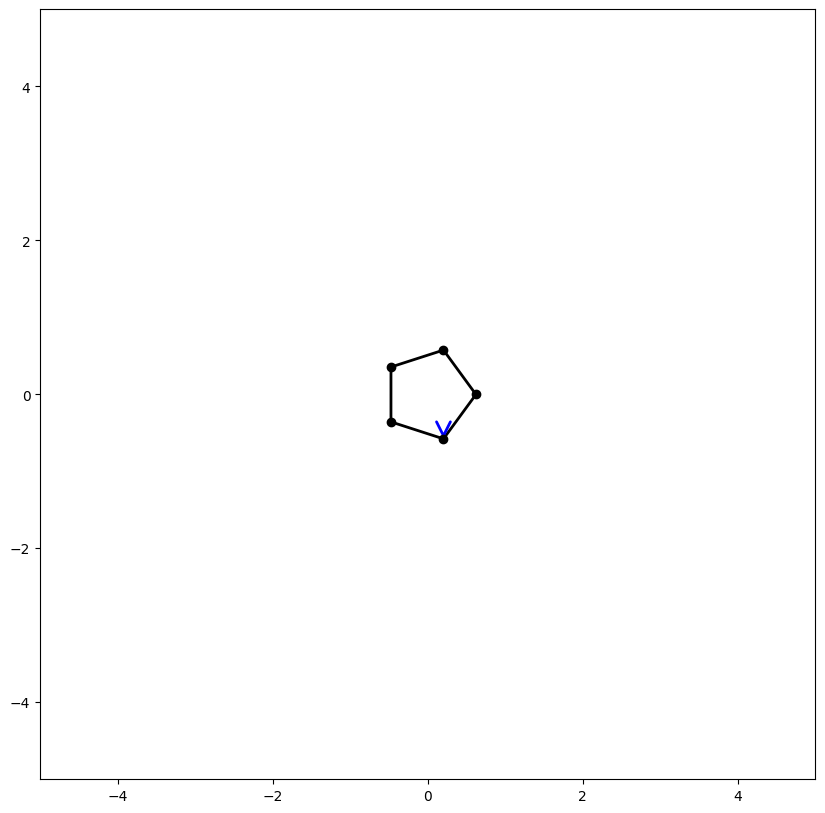

Iteration  347000 ff =  1.0150734971903775e-30 vv =  6.344209357439859e-34 power =  2.5376837429759443e-32


<Figure size 640x480 with 0 Axes>

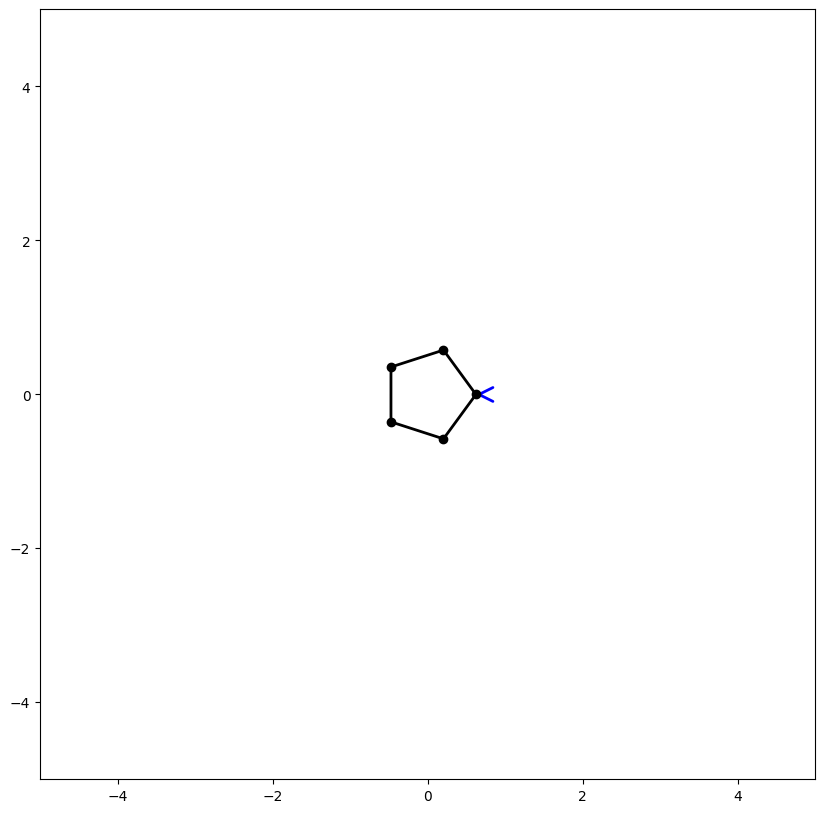

Iteration  348000 ff =  2.4580905233934452e-31 vv =  2.92998398792848e-32 power =  8.486557532015873e-32


<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [24]:
P = initialize_a_polygon()

print(P.perimeter_)
print(P.stress_)
print(P.area_)

plot_configuration(P)
FIREminimize(P)
P.compute_area()
P.compute_perimeter()
P.compute_forces()
print(P.perimeter_)
print(P.area_)
for i in range(len(P.vertices_)):

    print(P.vertices_[i].force_)


Iteration  0 ff =  2.7818966670480435e-31 vv =  1.063536536840287e-30 power =  5.439346235642491e-31


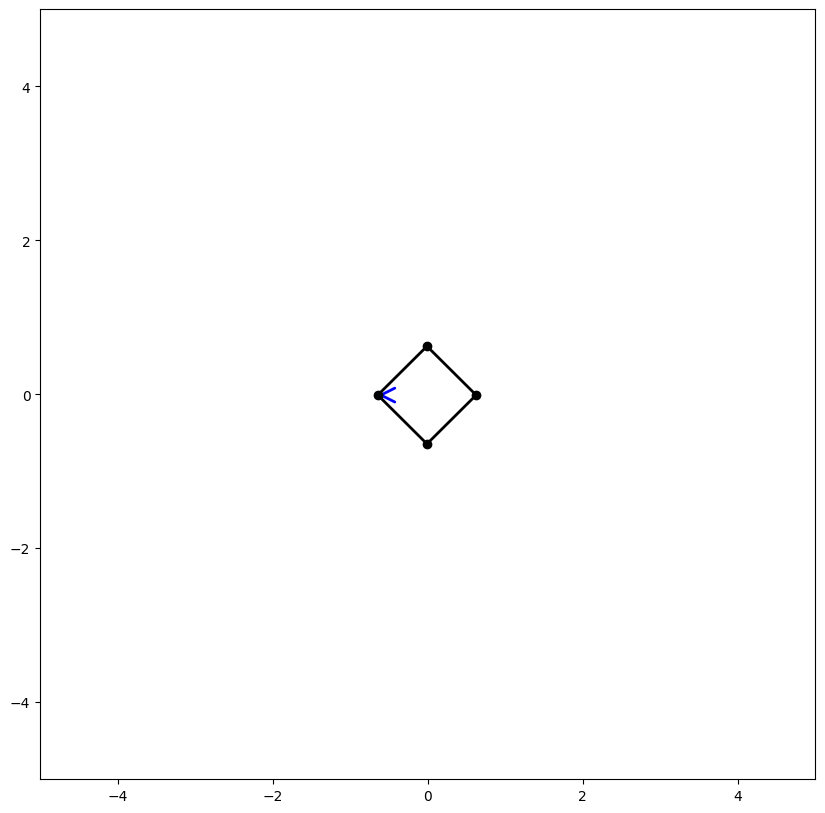

<Figure size 640x480 with 0 Axes>

In [17]:
FIREminimize(P)